# 프로젝트: KOR to ENG Translator Using Transformer 
* 참고 논문: [Attenion is all you need](https://arxiv.org/pdf/1706.03762v5.pdf)

## Matplotlib Font Install 
```
$ sudo apt -qq -y install fonts-nanum # font 설치
```

## Import Library

In [1]:
import numpy as np
import tensorflow as tf
import sentencepiece as spm

import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import io
import time
import random
from tqdm.notebook import tqdm 

import seaborn # Attention map visualization

print(tf.__version__)

2.4.1


## Detrminized random seed 

In [2]:
SEED = 42

# random seed 
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [3]:
set_seeds(SEED)

## Data Load
* [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

In [4]:
# !mkdir -p ~/aiffel/transformer/data
# !cd ~/aiffel/transformer/data

# !wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
# !gzip -d korean-english-park.train.tar.gz
# !tar -xvf korean-english-park.train.tar

In [5]:
!pwd

/home/aiffel-dj19/aiffel/transformer


In [6]:
# !mv korean-english-park.train.en ~/aiffel/transformer/data
# !mv korean-english-park.train.ko ~/aiffel/transformer/data

In [7]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

## Data preprocessing and Tokenizing 
* cleaned_corpus: 중복 제거 후의 corpus

### 중복 제거

In [8]:
with open(kor_path, "r") as f: kor = f.read().splitlines()
with open(eng_path, "r") as f: eng = f.read().splitlines()

type(kor), len(kor), type(eng), len(eng)

(list, 94123, list, 94123)

In [9]:
# set을 사용할 떄 이렇게 하면 쌍을 이뤄서 정제하는 것이 불가능 
cleaned_kor_raw = list(set(kor))
cleaned_eng_raw = list(set(eng))

print(len(cleaned_kor_raw))
print(len(cleaned_eng_raw))

77591
75598


In [10]:
# 데이터 중복 제거 
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng) # 내부적인 점검을 위한 Testing - kor와 eng 쌍 확인 

    df_raw = pd.DataFrame(columns=['korean', 'english'])
    cleaned_corpus = pd.DataFrame(columns=['korean', 'english'])
    df_raw['korean'] = kor
    df_raw['english'] = eng
    
    # kor, eng 둘 중 하나라도 중복이면 해당 행 제거 
    df_raw = df_raw.drop_duplicates(['korean'], keep=False)
    df_raw = df_raw.drop_duplicates(['english'], keep=False)
    
    cleaned_corpus = df_raw
    return cleaned_corpus

In [11]:
cleaned_corpus = clean_corpus(kor_path, eng_path)

In [12]:
cleaned_corpus.head()

korean  \
0               개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"   
1  모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...   
2                         그러나 이것은 또한 책상도 필요로 하지 않는다.   
3  79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...   
4  정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...   

                                             english  
0  Much of personal computing is about "can you t...  
1  so a mention a few weeks ago about a rechargea...  
2  Like all optical mice, But it also doesn't nee...  
3  uses gyroscopic sensors to control the cursor ...  
4  Intelligence officials have revealed a spate o...

In [13]:
cleaned_corpus.describe()

korean  \
count                                   65327   
unique                                  65327   
top     처음엔 그 부위만 아프겠지만 온 몸이 아픔을 느낄 때까지 눌러준다.   
freq                                        1   

                                                  english  
count                                               65327  
unique                                              65327  
top     The suicide bomb killed more than 20 others, a...  
freq                                                    1

=> kor와 eng쌍이 잘 맞는지 확인한다. 

### null값 확인 

In [14]:
cleaned_corpus['korean'].isnull().sum()

0

In [15]:
cleaned_corpus['english'].isnull().sum()

0

### 데이터 정제 - 정규표현식

조건
- 모든 입력을 소문자로 변환합니다.
- 알파벳, 문장부호, 한글, 숫자만 남기고 모두 제거합니다.
- 문장부호 양옆에 공백을 추가합니다.
- 문장 앞뒤의 불필요한 공백을 제거합니다.

In [16]:
# Sentencepiece를 활용한 Preprocessing 
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?!.,])", r" \1 ", sentence) # 특수문자 제거 
    sentence = re.sub(r'[" "]+', " ", sentence) # 공백 제거 

    sentence = re.sub(r"[^0-9|ㄱ-ㅎ가-힣|a-zA-Z?.!,]+", " ", sentence) # 해당하는 문자빼고 제외
    sentence = sentence.strip()
    
    return sentence

In [17]:
cleaned_corpus['korean'] = cleaned_corpus['korean'].map(lambda x : preprocess_sentence(x))

In [18]:
cleaned_corpus['english'] = cleaned_corpus['english'].map(lambda x : preprocess_sentence(x))

In [19]:
cleaned_corpus.describe()

korean english
count                             65327   65327
unique                            65321   65310
top     atlanta , georgia cnn 이수지 joins        
freq                                  2       3

=> 좀 더 디테일하게는 정규표현식에서 index=3일 때를 보면 "79.95"달러같은 경우 어떻게 해야할 지 고민해볼 필요가 있다. 문장 중간에 나타나는 .에 대해서는 띄어쓰기 처리를 한다든지    
=> 데이터 정제 과정을 거치면서 중복데이터가 발생했음을 알 수 있다. 한번 더 전처리를 해준다. 

In [20]:
cleaned_corpus = cleaned_corpus.drop_duplicates(['korean'], keep=False)
cleaned_corpus = cleaned_corpus.drop_duplicates(['english'], keep=False)

In [21]:
cleaned_corpus['korean'].isnull().sum()

0

In [22]:
cleaned_corpus['english'].isnull().sum()

0

In [23]:
cleaned_corpus.describe()

korean  \
count                                               65282   
unique                                              65282   
top     오클라호마 주 털사의 한 식품점 직원들은 온두라스에서 온 바나나 화물을 내릴 때 까...   
freq                                                    1   

                                                  english  
count                                               65282  
unique                                              65282  
top     at other times , people buy products to get th...  
freq                                                    1

### Tokenizing using sentence piece

함수 설명 
- generate_tokenizer 함수 조건
    - 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
    - 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.
    - 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
       * \<PAD> : 0 / \<BOS> : 1 / \<EOS> : 2 / \<UNK> : 3
    - 참고: [google/sentencepiece](https://github.com/google/sentencepiece)
- set_encode_extra_options("bos:eos") 함수: 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함

In [24]:
cleaned_corpus['korean'].tolist()[:1]

['개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?']

In [25]:
file_path = os.getcwd()
file_path

'/home/aiffel-dj19/aiffel/transformer'

In [26]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus_path,
                        vocab_size,
                        lang="kor"):

    spm.SentencePieceTrainer.Train(f'--input={corpus_path} --model_prefix={lang} --model_type=bpe --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3')
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(file_path +'/'+ lang+'.model')
    return tokenizer

In [27]:
with open('korean.temp', 'w', encoding='utf8') as f:
    f.write('\n'.join(cleaned_corpus['korean']))

In [28]:
with open('english.temp', 'w', encoding='utf8') as f:
    f.write('\n'.join(cleaned_corpus['english']))

In [29]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000 # len(cleaned_corpus)

kor_corpus_path = file_path + '/korean.temp'
eng_corpus_path = file_path + '/english.temp'

In [30]:
ko_tokenizer = generate_tokenizer(kor_corpus_path, SRC_VOCAB_SIZE, "kor")
en_tokenizer = generate_tokenizer(eng_corpus_path, TGT_VOCAB_SIZE, "eng")
en_tokenizer.set_encode_extra_options("bos:eos")

True

In [31]:
tokensIDs = ko_tokenizer.EncodeAsIds(cleaned_corpus['korean'][0])
print(tokensIDs)

[1575, 6946, 1099, 375, 6813, 3090, 1792, 6817, 1319, 521, 3296, 7092, 18, 7, 6125, 1008]


In [32]:
tokensIDs = ko_tokenizer.encode_as_pieces(cleaned_corpus['korean'][0])
print(tokensIDs)

['▁개인', '용', '▁컴퓨터', '▁사용', '의', '▁상당', '▁부분', '은', '▁이것', '보다', '▁뛰어', '날', '▁수', '▁있', '느냐', '▁?']


=> 토크나이징 결과를 봤을때 잘못 학습된 것을 확인했다. 공백이 unknown으로 들어가버린다.     
(해결) 대부분의 단어가 Unk 토큰으로 처리되길래 확인해보니, Kor와 eng을 반대로 변수에 넣어줘서 그랬다. 

In [33]:
tokenized_kor = cleaned_corpus['korean'].map(lambda x:ko_tokenizer.EncodeAsIds(x))
tokenized_eng = cleaned_corpus['english'].map(lambda x:en_tokenizer.EncodeAsIds(x))

In [34]:
tokenized_kor

0        [1575, 6946, 1099, 375, 6813, 3090, 1792, 6817...
1        [468, 632, 6872, 6894, 1543, 4914, 167, 5, 632...
2        [190, 2413, 418, 768, 6858, 6843, 6637, 1001, ...
3        [188, 6935, 4, 5395, 405, 41, 5, 98, 7606, 696...
4        [674, 2988, 82, 7008, 1133, 947, 2361, 756, 10...
                               ...                        
94118    [691, 58, 6969, 202, 6842, 605, 7032, 6929, 11...
94119    [1960, 2928, 7079, 483, 7021, 6859, 126, 869, ...
94120    [190, 133, 7220, 6973, 6819, 1591, 1395, 6820,...
94121    [605, 6879, 2122, 338, 21, 51, 4874, 7025, 692...
94122    [533, 605, 6879, 1169, 254, 6888, 4607, 923, 5...
Name: korean, Length: 65282, dtype: object

In [35]:
tokenized_eng

0        [1, 1133, 37, 2793, 1851, 32, 82, 251, 359, 47...
1        [1, 379, 5, 5861, 5, 1243, 1452, 1152, 251, 5,...
2        [1, 596, 295, 3140, 339, 26, 168, 16, 174, 88,...
3        [1, 6058, 7124, 47, 7019, 119, 41, 3129, 327, ...
4        [1, 2180, 450, 158, 5019, 5, 150, 121, 37, 677...
                               ...                        
94118    [1, 87, 154, 5106, 33, 93, 1240, 3060, 2106, 3...
94119    [1, 63, 494, 16, 349, 275, 998, 5024, 142, 752...
94120    [1, 174, 9, 2976, 37, 3060, 2106, 82, 1562, 88...
94121    [1, 1049, 45, 159, 2102, 1000, 7882, 9, 3122, ...
94122    [1, 349, 154, 3330, 33, 3804, 988, 4445, 650, ...
Name: english, Length: 65282, dtype: object

In [36]:
cleaned_corpus['korean'] = tokenized_kor
cleaned_corpus['english'] = tokenized_eng

### Corpus to Tensor

4) 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환하세요! (❗모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다.)

In [37]:
max_len = 50

In [38]:
limited_corpus = cleaned_corpus[(cleaned_corpus['korean'].map(lambda x : len(x)) <= max_len) & (cleaned_corpus['english'].map(lambda x : len(x)) <= max_len)]
limited_corpus

korean  \
0      [1575, 6946, 1099, 375, 6813, 3090, 1792, 6817...   
1      [468, 632, 6872, 6894, 1543, 4914, 167, 5, 632...   
2      [190, 2413, 418, 768, 6858, 6843, 6637, 1001, ...   
3      [188, 6935, 4, 5395, 405, 41, 5, 98, 7606, 696...   
7      [5, 6323, 10, 1967, 10, 949, 249, 1637, 151, 5...   
...                                                  ...   
94118  [691, 58, 6969, 202, 6842, 605, 7032, 6929, 11...   
94119  [1960, 2928, 7079, 483, 7021, 6859, 126, 869, ...   
94120  [190, 133, 7220, 6973, 6819, 1591, 1395, 6820,...   
94121  [605, 6879, 2122, 338, 21, 51, 4874, 7025, 692...   
94122  [533, 605, 6879, 1169, 254, 6888, 4607, 923, 5...   

                                                 english  
0      [1, 1133, 37, 2793, 1851, 32, 82, 251, 359, 47...  
1      [1, 379, 5, 5861, 5, 1243, 1452, 1152, 251, 5,...  
2      [1, 596, 295, 3140, 339, 26, 168, 16, 174, 88,...  
3      [1, 6058, 7124, 47, 7019, 119, 41, 3129, 327, ...  
7      [1, 7507, 16, 88, 359, 57, 1102, 29, 3195, 132...  
...                                                  ...  
94118  [1, 87, 154, 5106, 33, 93, 1240, 3060, 2106, 3...  
94119  [1, 63, 494, 16, 349, 275, 998, 5024, 142, 752...  
94120  [1, 174, 9, 2976, 37, 3060, 2106, 82, 1562, 88...  
94121  [1, 1049, 45, 159, 2102, 1000, 7882, 9, 3122, ...  
94122  [1, 349, 154, 3330, 33, 3804, 988, 4445, 650, ...  

[58167 rows x 2 columns]

In [39]:
# 토큰의 길이가 50 이하인 문장만 남깁니다. 
src_corpus = limited_corpus['korean'].tolist()
tgt_corpus = limited_corpus['english'].tolist()

In [40]:
print(len(src_corpus))
print(len(tgt_corpus))

58167
58167


In [41]:
# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

In [42]:
print(len(enc_train))
print(len(dec_train))

58167
58167


## Model Architecture
#### 논문 Result 참고 - (E)
![image](https://user-images.githubusercontent.com/69677950/115481914-807f2400-a288-11eb-8951-564bff250468.png)

1. 입력 데이터 → [ batch_size x length ]
2. Source & Target Embedding → [ batch_size x length x d_emb ]
3. Positional Encoding → shape 유지 
4. Multi-Head Attention 
    1. Split Heads → [ batch_size x length x heads x (d_emb / n_heads) ]
    2. Masking for Masked Attention
    3. Scaled Dot Product Attention
    4. Combine Heads →[ batch_size x length x d_emb ]
5. Residual Connection
6. Layer Normalization
7. Position-wise Feed-Forward Network → [ batch_size x length x d_ff ]
8. Output Linear Layer → [ batch_size x length x vocab_size ]    

### Positional Encoding       

![image](https://user-images.githubusercontent.com/69677950/117036114-11053c00-ad40-11eb-9441-f0d112776bfb.png)
* pos: 단어가 위치한 Time-step
* i: encoding 차원의 index
* d_model: model의 Embedding 차원 수 = Sinusoid embedding

In [43]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(int(i))) / d_model) # 곱하기 2로 수정

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)]) 

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2]) # 짝수 인덱스에는 sin 함수 적용
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2]) # 홀수 인덱스에는 cos 함수 적용 

    return sinusoid_table

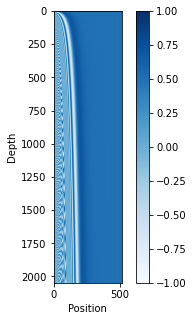

In [44]:
plt.figure(figsize=(5, 5))
plt.imshow(positional_encoding(2048, 512), cmap='Blues')
# plt.pcolormesh(positional_encoding(2048, 512), cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

###  Masking

* generate_padding_mask(): Attention을 할 때에 <PAD> 토큰에도 Attention을 주는 것을 방지해 주는 역할, Sequence-to-Sequence 모델에서 Loss에 대한 Masking과 동일한 방법
* generate_causality_mask    

=> 해당 함수는 기존 코드에 있던 함수이나, Batch 사이즈 에러 등 Shape 관련된 오류가 계속 떴음. 아래 자료와 코드를 참고해서 해결했습니다.
    
#### 참고 자료
* [transformer translator](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb#scrollTo=a1jXoAMRZyvu)
* [수희님 코드](https://github.com/suheeeee/aiffel_project_report/blob/main/going_deeper/GD_NLP_5_transformer_translation.ipynb)

In [45]:
# 한 배치의 데이터에서 <PAD> 토큰으로 이뤄진 부분을 모두 찾아내는 마스크를 생성
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [80]:
def generate_masks(inp, tar):
  # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
    look_ahead_mask = create_look_ahead_mask(np.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

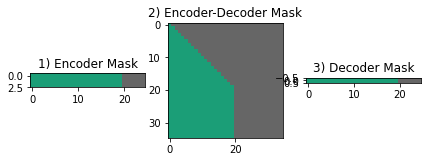

In [81]:
batch, length = 64, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

sample_enc_mask, sample_dec_enc_mask, sample_dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask') # Causality Mask와 Padding Mask 결합
ax3.set_title('3) Decoder Mask')

ax1.imshow(sample_enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(sample_dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(sample_dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

### Multi-Head Attention
- masked multi-head attention과 구분해서 만들어주지 않는지
* split_heads(): Embedding된 입력을 Head 수로 분할
    - 질문: 왜 transpose에서 축 바꿔주는 건지 궁금하다.
* scaled_dot_product_attention(): 분할된 입력으로부터 Attention 값 계산 
    - K(key): encoder의 state
    - Q(query): decoder의 state
    - V(value)
    - scaled_qk: Attention을 위한 Softmax 직전의 Scaled QK
    - Casuality Masking 
* combine_heads(): 연산이 종료되고 분할된 Head를 다시 하나로 결합

In [82]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads # generally, using num_heads = 8
        self.d_model = d_model

        self.depth = d_model // self.num_heads # head 개수로 차원을 쪼개준다. 

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

        
    def scaled_dot_product_attention(self, Q, K, V, mask):
        """Calculate the attention weights.
        q, k, v must have matching leading dimensions.
        k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
        The mask has different shapes depending on its type(padding or look ahead)
        but it must be broadcastable for addition.

        Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable
              to (..., seq_len_q, seq_len_k). Defaults to None.

        Returns:
        output, attention_weights
        """

        QK = tf.matmul(Q, K, transpose_b=True) # 텐서 사이의 행렬곱(내적) - Q와 K간 유사도 연산 

        # scale matmul_qk
        d_k = tf.cast(K.shape[-1], tf.float32)
        scaled_qk = QK / tf.math.sqrt(d_k)  

        # add the mask to the scaled tensor.
        if mask is not None: 
            scaled_qk += (mask * -1e9) # masked attention 

        # softmax is normalized on the last axis (seq_len_k) so that the scores
        # add up to 1.
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions

    
    def split_heads(self, x):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        bsz = x.shape[0] # bsz: batch_size 
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth)) # head 개수로 쪼개준다. 
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3]) # perm으로 0~3번째 축중에 1, 2 축을 바꿔줌.

        return split_x

    
    def combine_heads(self, x):
        bsz = x.shape[0]
        # (batch_size, seq_len_q, num_heads, depth)
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        # (batch_size, seq_len_q, d_model)
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q) # (batch_size, seq_len, d_model)
        WK = self.W_k(K) # (batch_size, seq_len, d_model)
        WV = self.W_v(V) # (batch_size, seq_len, d_model)
        
        # Q, K, V의 Dimension을 Head개수 만큼 쪼개준다. 
        WQ_splits = self.split_heads(WQ) # (batch_size, num_heads, seq_len_q, depth)
        WK_splits = self.split_heads(WK) # (batch_size, num_heads, seq_len_k, depth)
        WV_splits = self.split_heads(WV) # (batch_size, num_heads, seq_len_v, depth)

        # scaled_dot_product_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out) # linear로 데이터를 특정 분포로 매핑시켜준다. 

        return out, attention_weights

### Position-wise Feed-Forward Network
![image](https://user-images.githubusercontent.com/69677950/117044829-d3a5ac00-ad49-11eb-9eeb-c9bebe354b74.png)
* x: input, [ batch x length x d_model ]
* d_ff: 2048 차원 
* d_model: dimension인데 512로 설정되어있음 
* max(0,f): ReLU

#### position-wise인 이유
개별 단어(position)마다 적용되기 때문에

In [83]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu') # Fully-connected layer
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x) # 선형변환 후, relu 적용 
        out = self.w_2(out)
            
        return out

### Encoder 레이어 구현

In [84]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

### Normalization Layer의 위치 
* 논문: [ Input ] - [ Module ] - [ Residual ] - [ Norm ] (Module = MHA, FFN)
* 구글의 Tensor2Tensor: [ Input ] - [ Norm ] - [ Module ] - [ Residual ] 
     - 모듈 앞에 Normalization Layer를 두는 pre-LN 방식: 트랜스포머의 Layer Normalization의 위치에 대한 논의를 다룬 [On Layer Normalization in the Transformer Architecture](https://arxiv.org/pdf/2002.04745.pdf)

### Decoder 레이어 구현

In [85]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [86]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [87]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### Transformer
조건    
1. shared 변수를 매개변수로 받아 True 일 경우 Decoder Embedding과 출력층 Linear의 Weight를 공유
    - Weight가 공유될 경우 Embedding 값에 sqrt(d_model)을 곱해줘야함 (참고: tf.keras.layers.Layer.set_weights())
2. positional_encoding 의 반환값 형태는 [ Length x d_model ] 인데, 이를 더해줄 Embedding 값 형태가 [ Batch x Length x d_model ] 이라서 연산이 불가능합니다. 연산이 가능하도록 수정(참고: tf.expand_dims(), np.newaxis)

In [88]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

### Learning rate scheduler
가변적인 lr 사용할 수 있도록 

In [89]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

In [90]:
transformer = Transformer(n_layers=2,  # 인코더와 디코더의 층의 개수
                          d_model=512, # 인코더와 디코더 내부의 입, 출력의 고정 차원
                          n_heads=8,   # 멀티 헤드 어텐션에서의 헤드 수 
                          d_ff=2048,
                          src_vocab_size=SRC_VOCAB_SIZE,
                          tgt_vocab_size=TGT_VOCAB_SIZE,
                          pos_len=max_len,
                          dropout=0.3)

In [91]:
learning_rate = LearningRateScheduler(512) # 논문에서 정의된 d_model = 512
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [92]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## Train and Test

* [참고 공식문서](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit?hl=ko)

In [93]:
# # Train Step 함수 정의
# @tf.function()
# def train_step(src, tgt, model, optimizer):
#     tgt_real = tgt[:, 1:]
        
#     enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

#     # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
#     with tf.GradientTape() as tape:
#         predictions, enc_attns, dec_attns, dec_enc_attns = \
#         model(src, tgt_inp, enc_mask, dec_enc_mask, dec_mask)
#         loss = loss_function(tgt_real, predictions[:, :-1])

#     # 최종적으로 optimizer.apply_gradients()가 사용됩니다.
#     # compute gradients
#     grads = tape.gradient(loss, model.trainable_variables)
#     # update weights
#     optimizer.apply_gradients(zip(grads, model.trainable_variables), experimental_aggregate_gradients=False)

#     return loss, enc_attns, dec_attns, dec_enc_attns

In [110]:
# Train Step 함수 정의
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions) # predictions[:, :-1] => predictions

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

## Translation and Visualization

예문
1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

In [111]:
tokensIDs = ko_tokenizer.EncodeAsIds('오바마는 대통령이다.')
print(tokensIDs)

[1193, 80, 134, 6811]


In [112]:
tokensIDs = ko_tokenizer.EncodeAsIds('시민들은 도시 속에 산다.')
print(tokensIDs)

[1075, 51, 870, 3544, 333, 6809, 6811]


In [113]:
tokensIDs = ko_tokenizer.EncodeAsIds('커피는 필요 없다.')
print(tokensIDs)

[4706, 6812, 518, 572, 6811]


In [114]:
tokensIDs = ko_tokenizer.EncodeAsIds('일곱 명의 사망자가 발생했다.')
print(tokensIDs)

[44, 7786, 890, 4402, 1359, 6811]


결과(output)
Translations
> 1. obama is the president elect .
> 2. they are in the city .
> 3. they don t need to be a lot of drink .
> 4. seven other people have been killed in the attacks .

In [115]:
# Attention 시각화 함수
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [117]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.EncodeAsIds(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)
        
        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [118]:
# 번역 생성 및 Attention 시각화 결합
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=True):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At: 20

  0%|          | 0/909 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Input: 오바마는 대통령이다.
Predicted translation: clinton s presidential presidential presidential presidential presidential presidential election
Encoder Layer 1


/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 45716 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)


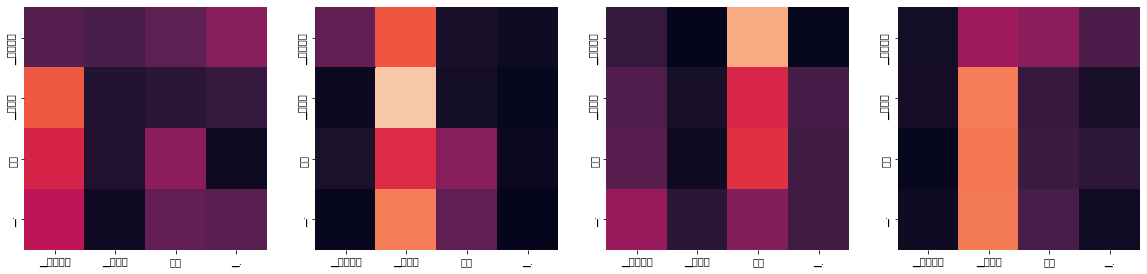

Encoder Layer 2


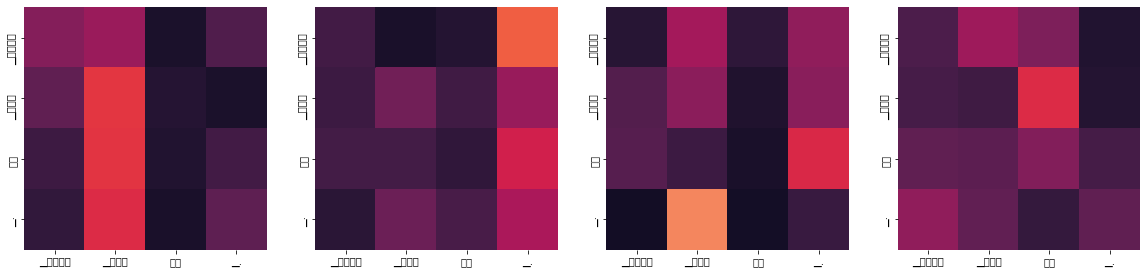

Decoder Self Layer 1


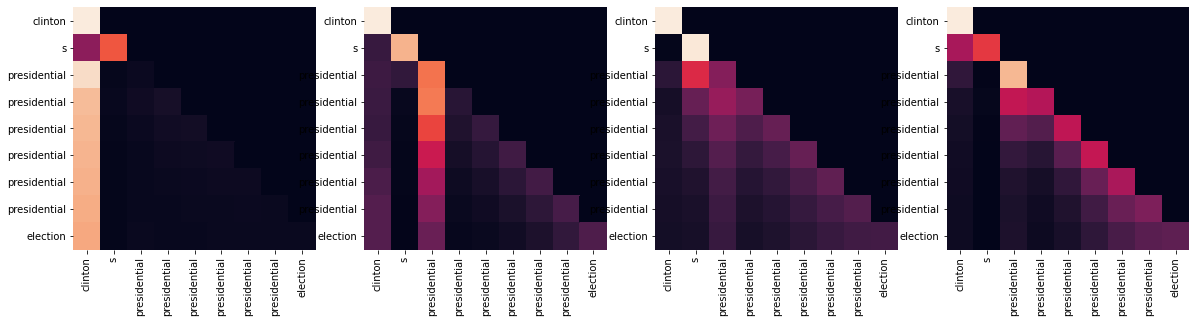

Decoder Src Layer 1


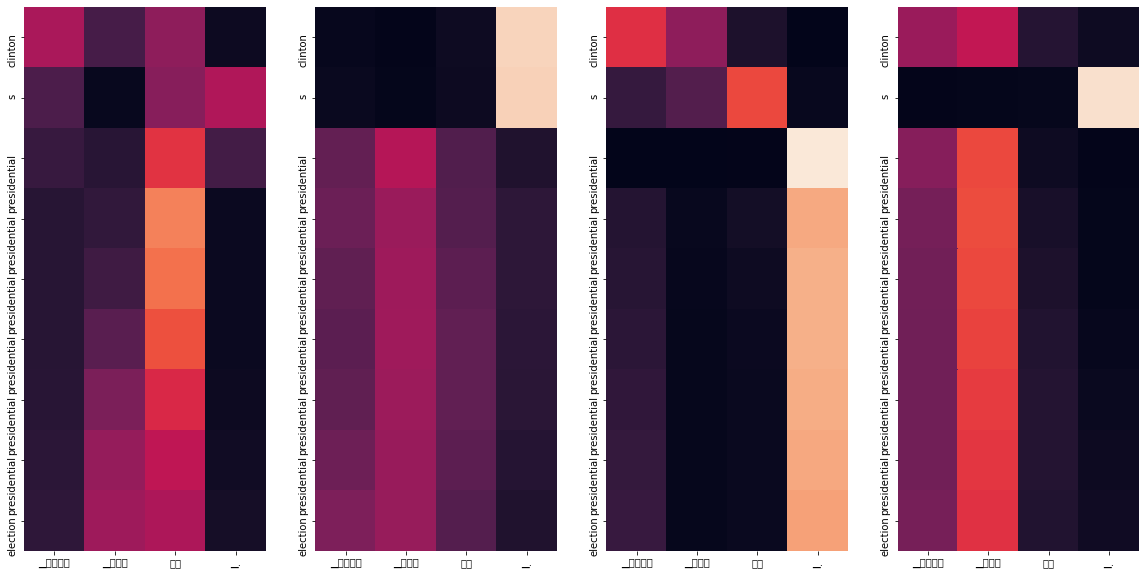

Decoder Self Layer 2


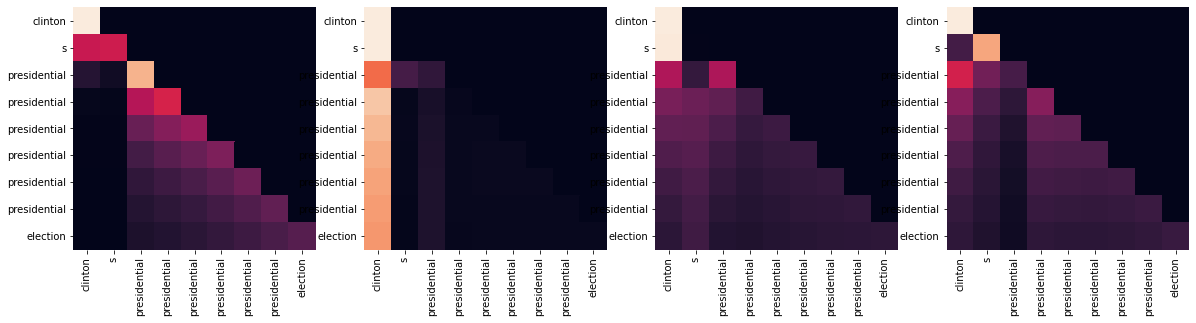

Decoder Src Layer 2


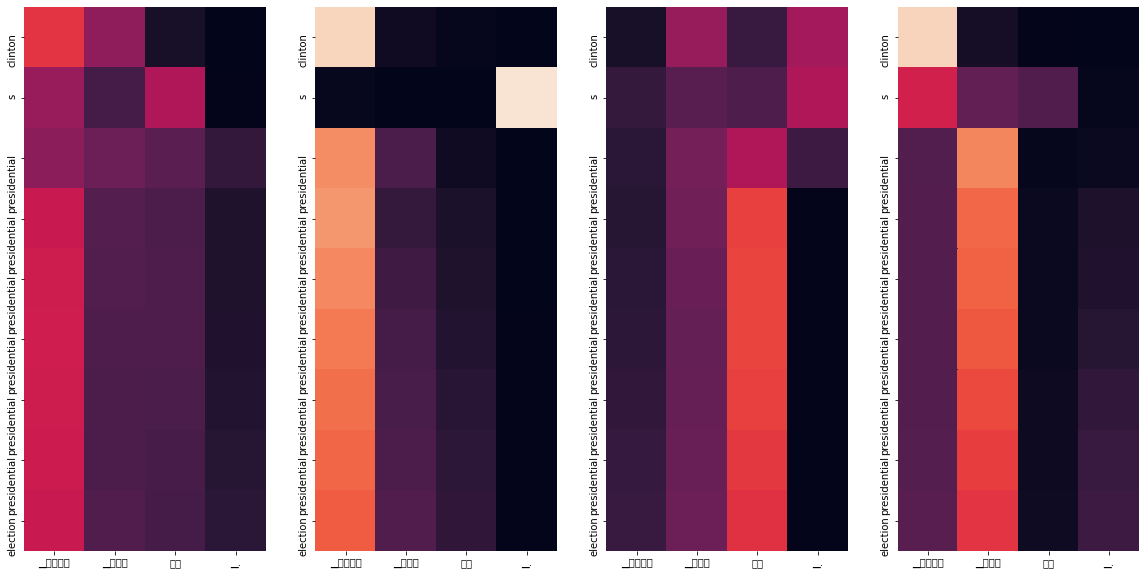

Input: 시민들은 도시 속에 산다.
Predicted translation: the same time
Encoder Layer 1


/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48124 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46308 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51008 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)


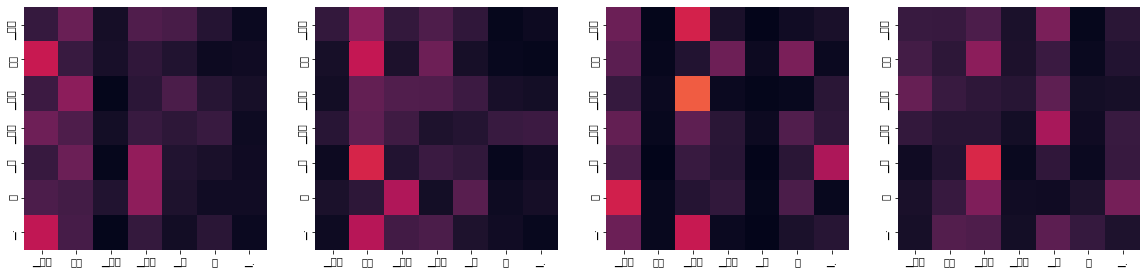

Encoder Layer 2


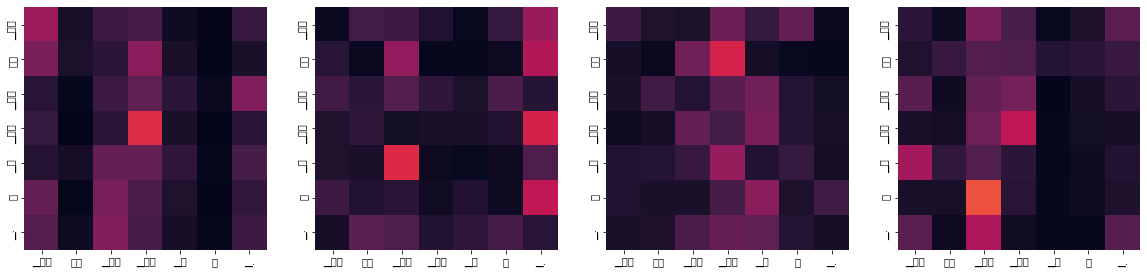

Decoder Self Layer 1


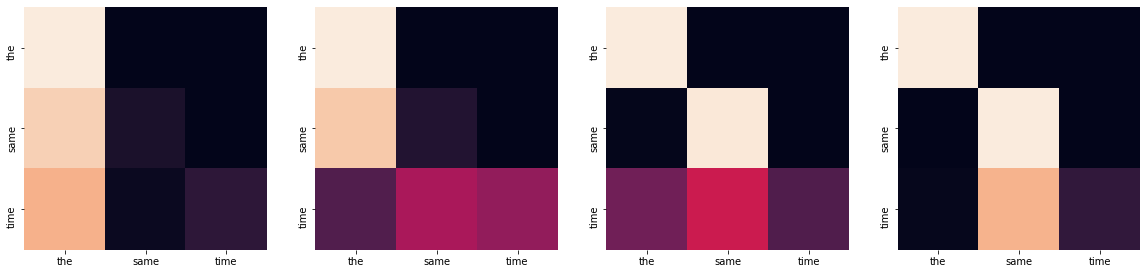

Decoder Src Layer 1


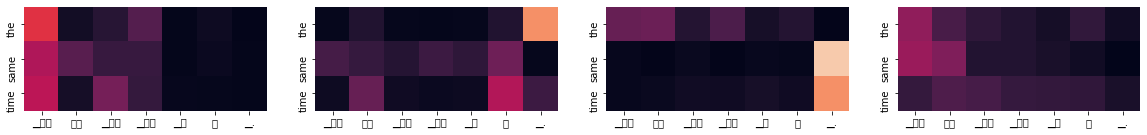

Decoder Self Layer 2


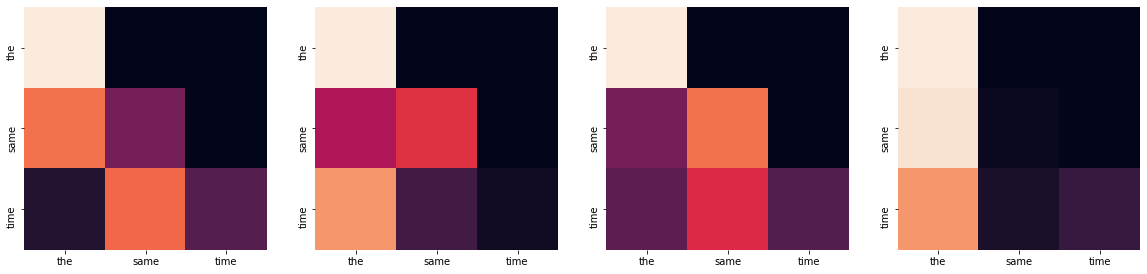

Decoder Src Layer 2


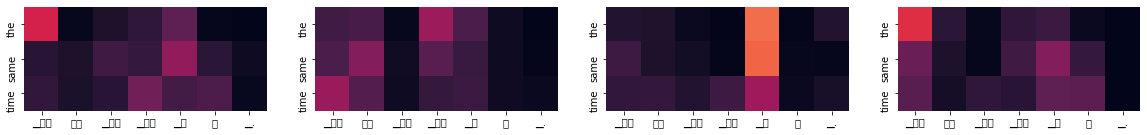

Input: 커피는 필요 없다.
Predicted translation: the people have been a lot of the time .
Encoder Layer 1


/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 52964 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54596 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50630 missing from current font.
  font.set_text(s, 0.0, flags=flags)


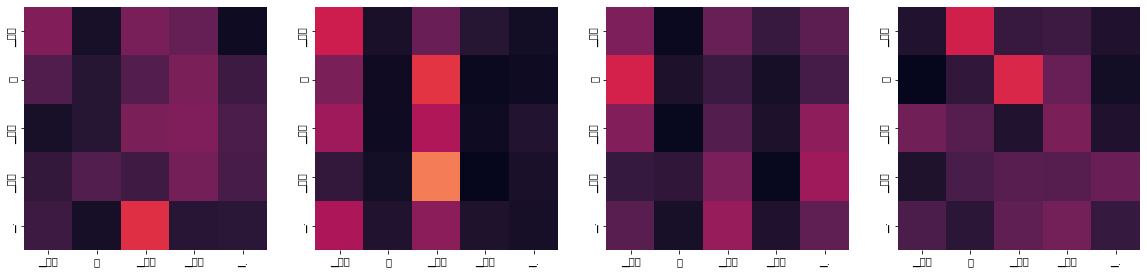

Encoder Layer 2


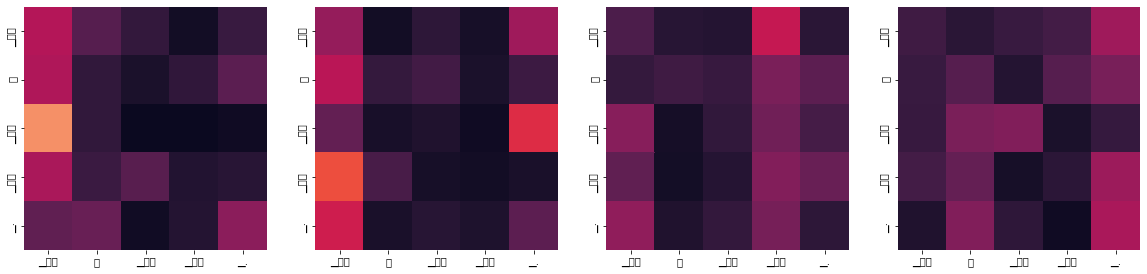

Decoder Self Layer 1


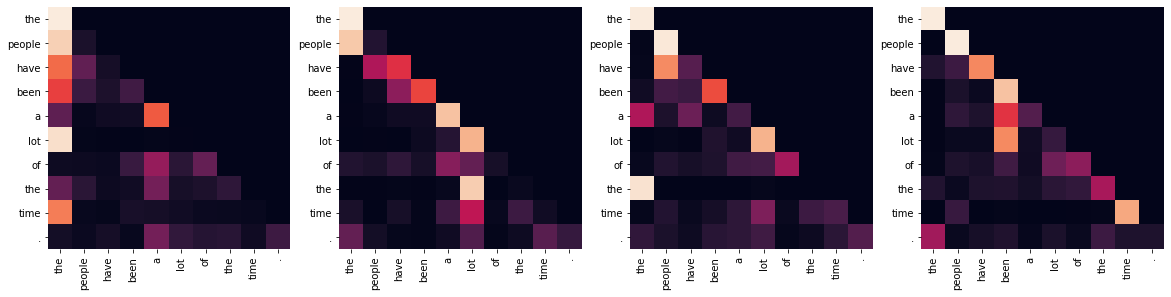

Decoder Src Layer 1


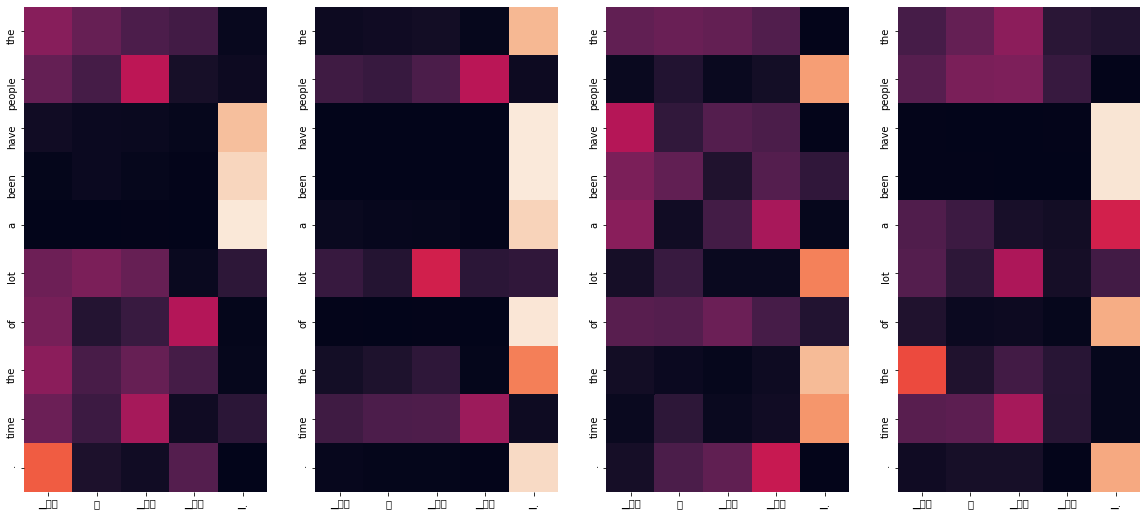

Decoder Self Layer 2


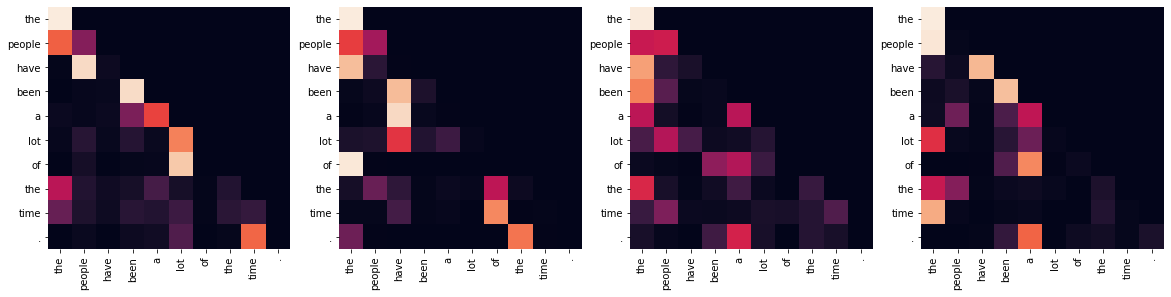

Decoder Src Layer 2


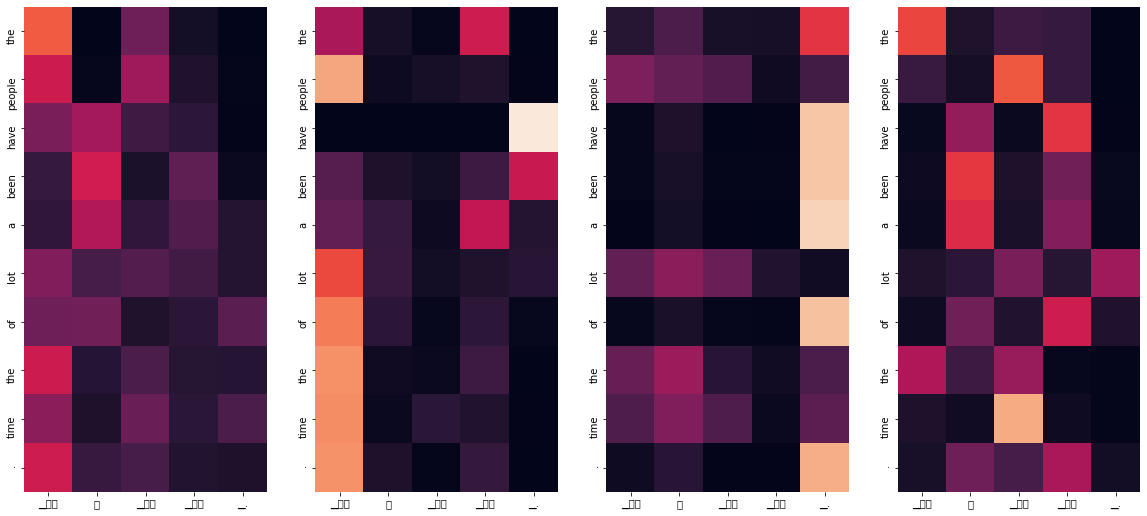

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the number of the hospital were killed in the hospital .
Encoder Layer 1


/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44273 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj19/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)


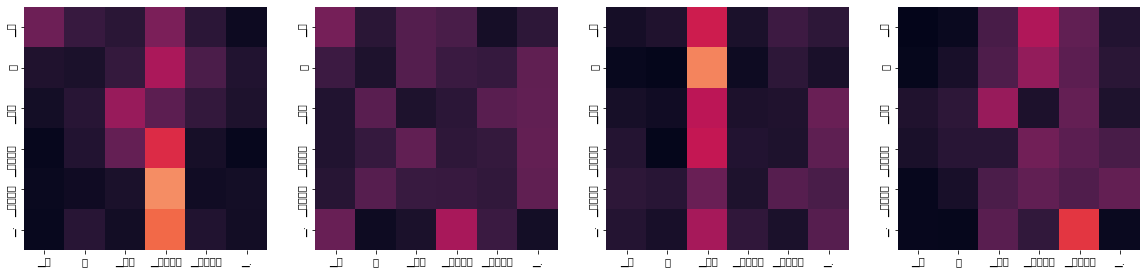

Encoder Layer 2


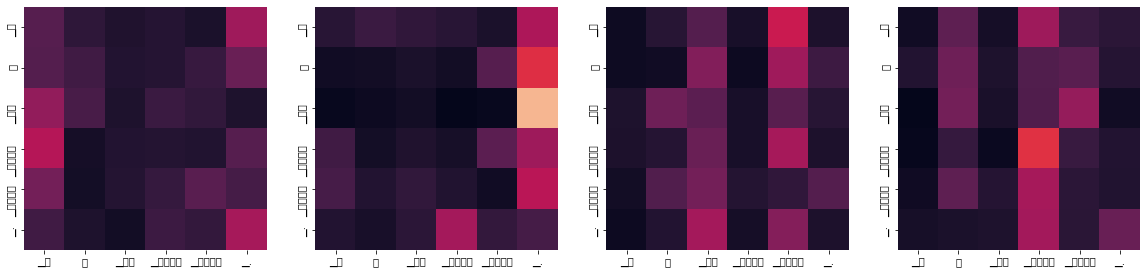

Decoder Self Layer 1


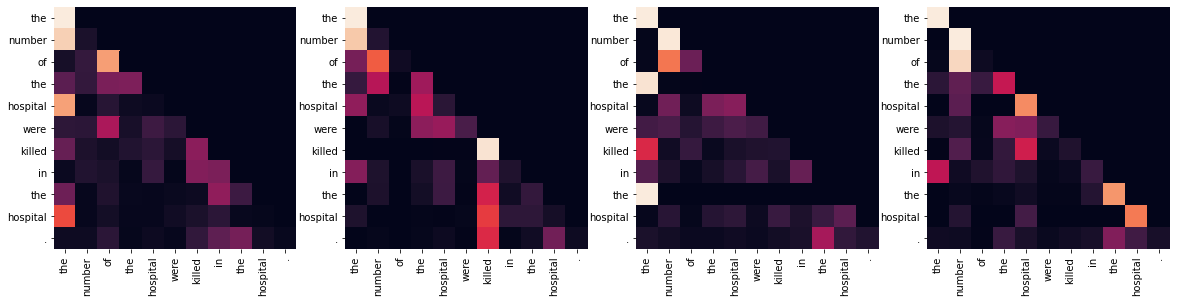

Decoder Src Layer 1


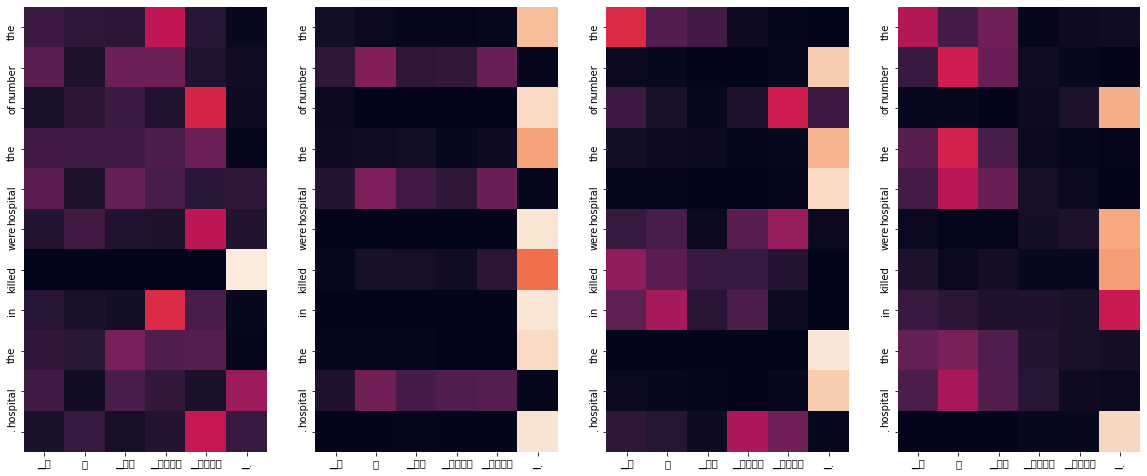

Decoder Self Layer 2


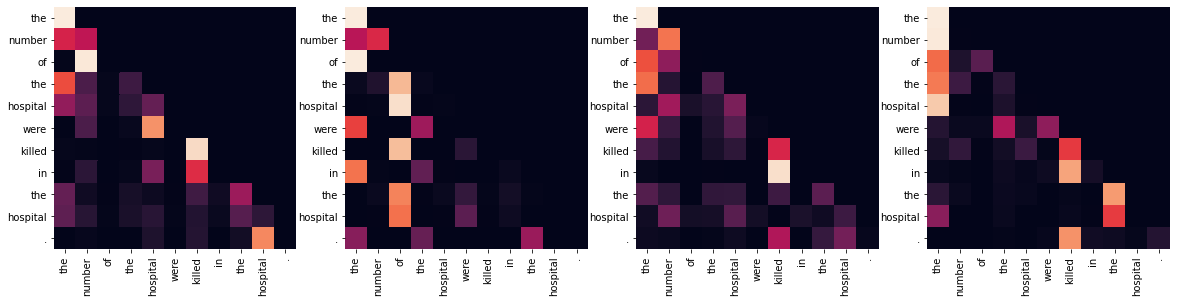

Decoder Src Layer 2


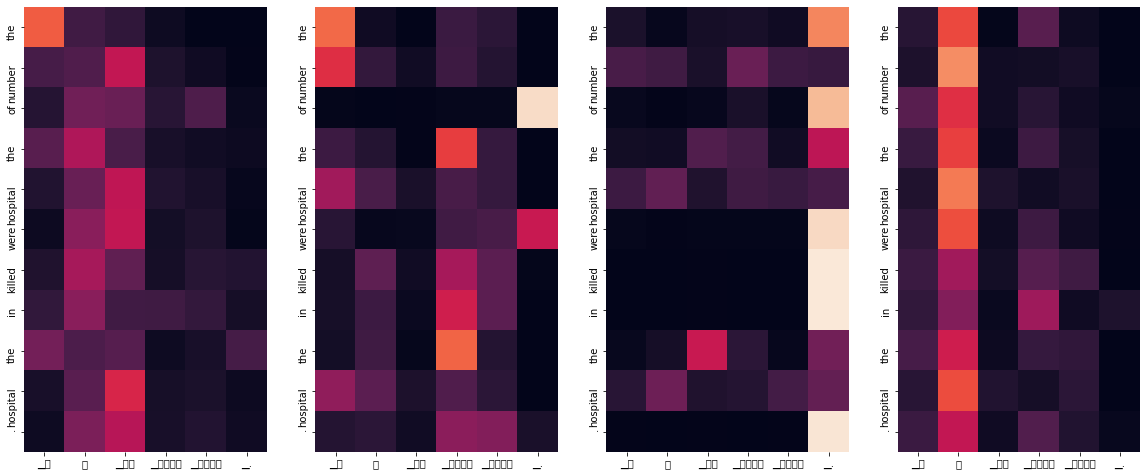

  0%|          | 0/909 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is obama .
Encoder Layer 1


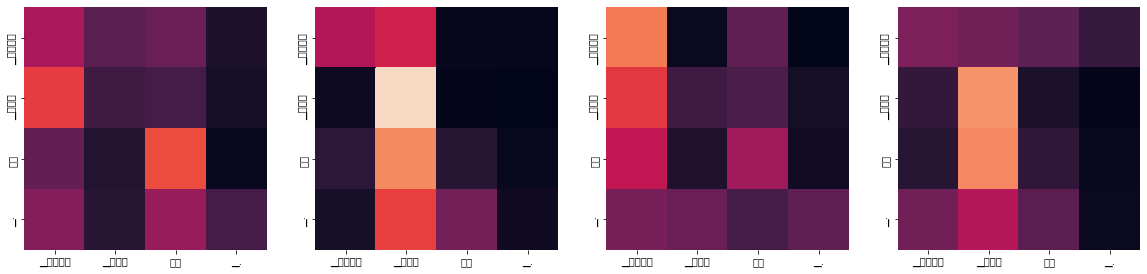

Encoder Layer 2


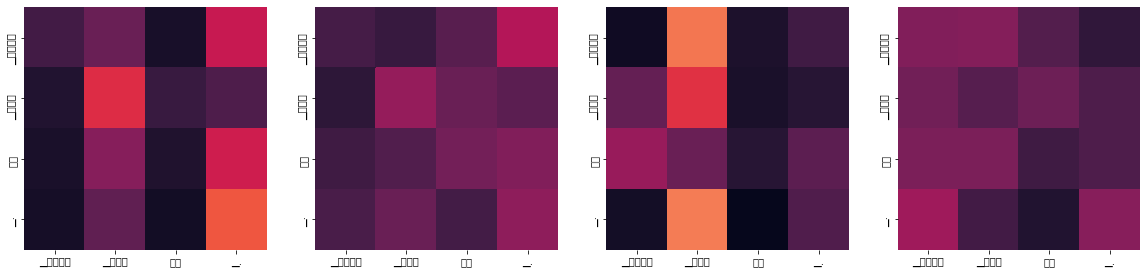

Decoder Self Layer 1


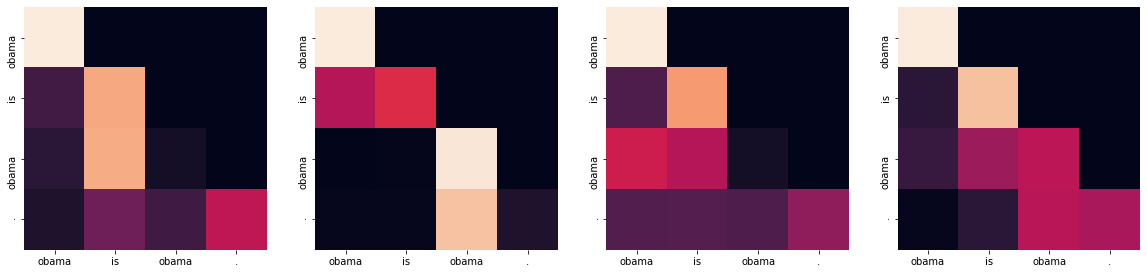

Decoder Src Layer 1


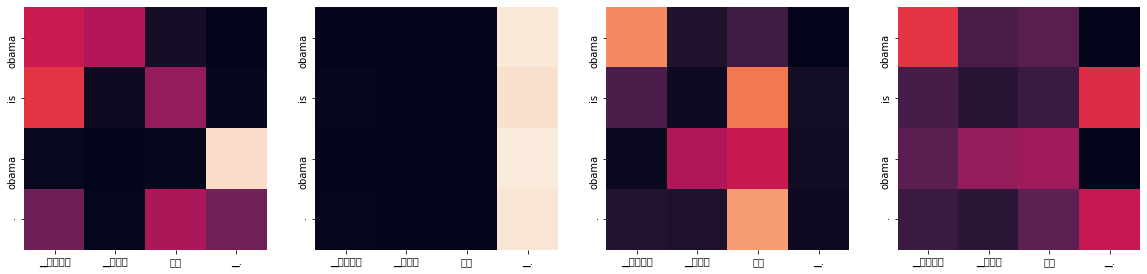

Decoder Self Layer 2


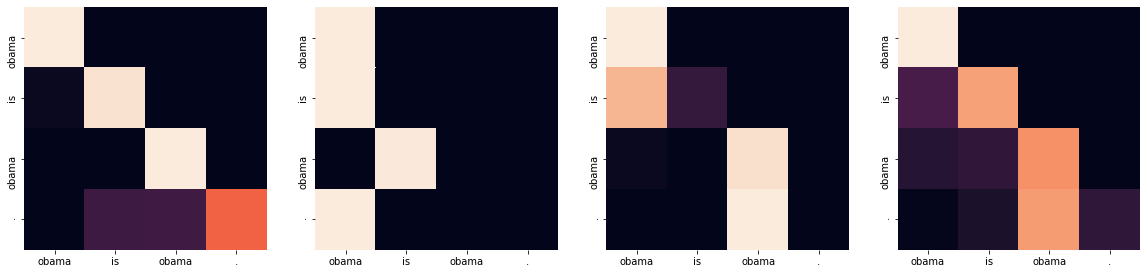

Decoder Src Layer 2


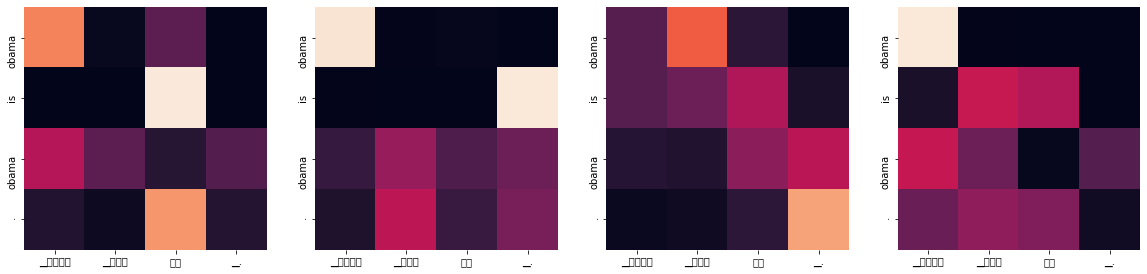

Input: 시민들은 도시 속에 산다.
Predicted translation: the city of the city s city .
Encoder Layer 1


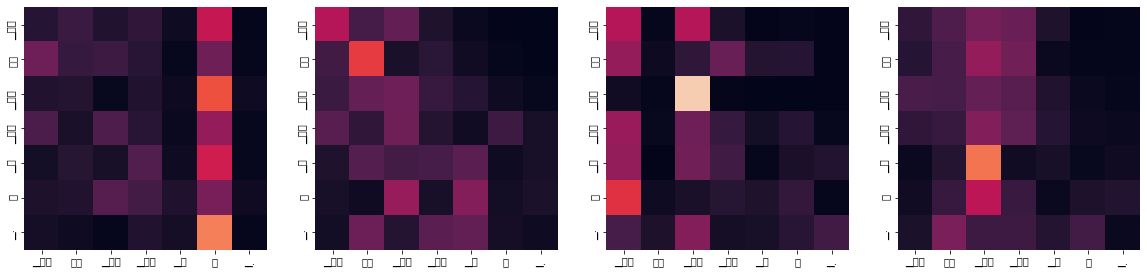

Encoder Layer 2


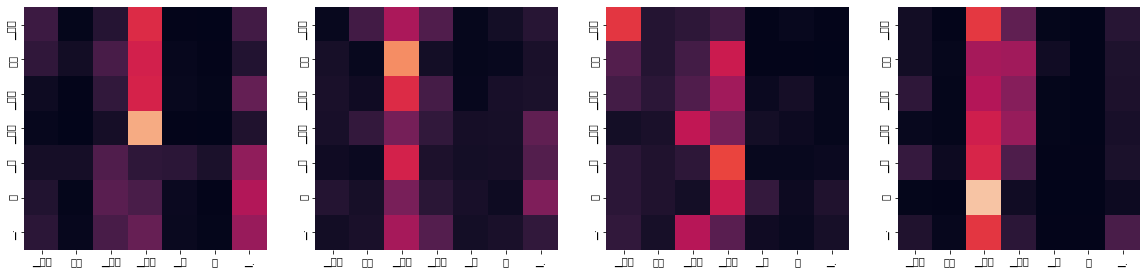

Decoder Self Layer 1


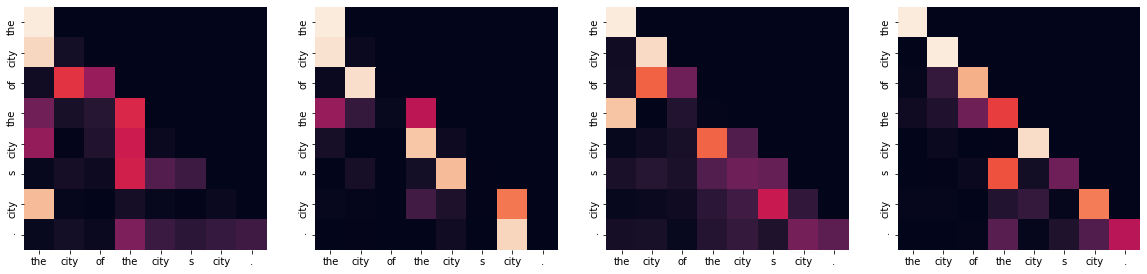

Decoder Src Layer 1


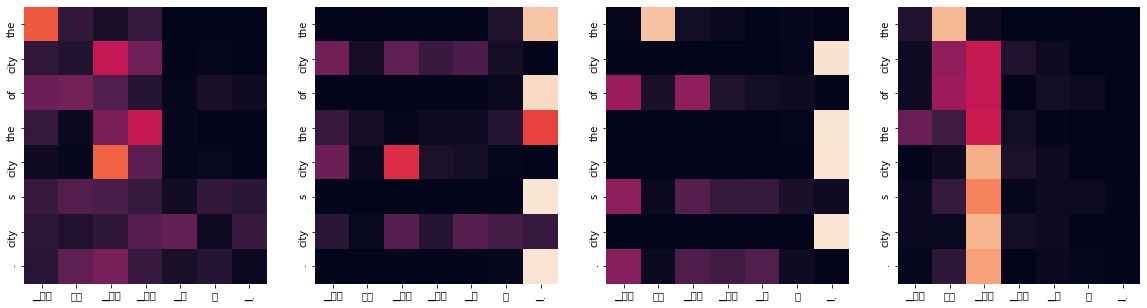

Decoder Self Layer 2


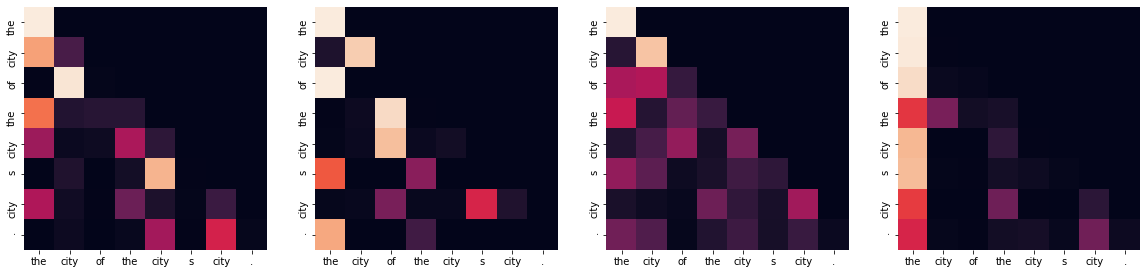

Decoder Src Layer 2


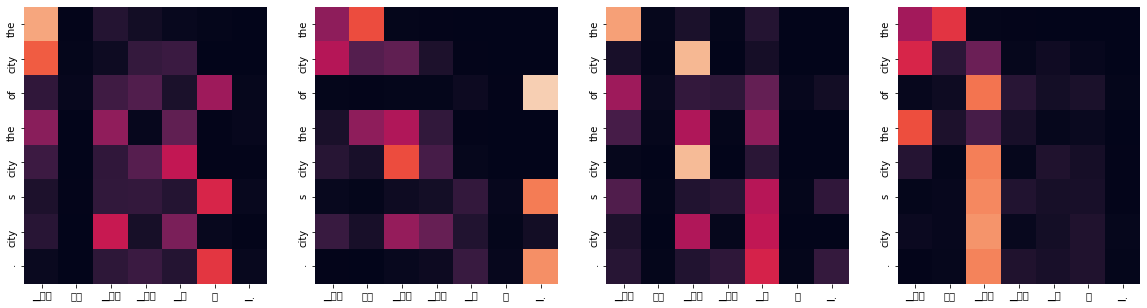

Input: 커피는 필요 없다.
Predicted translation: it s a lot of people .
Encoder Layer 1


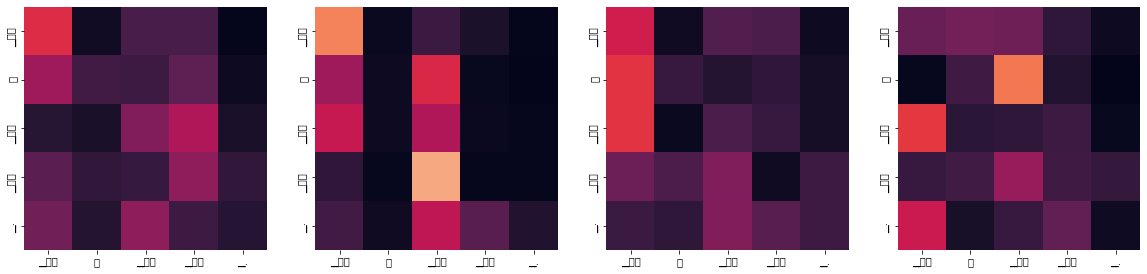

Encoder Layer 2


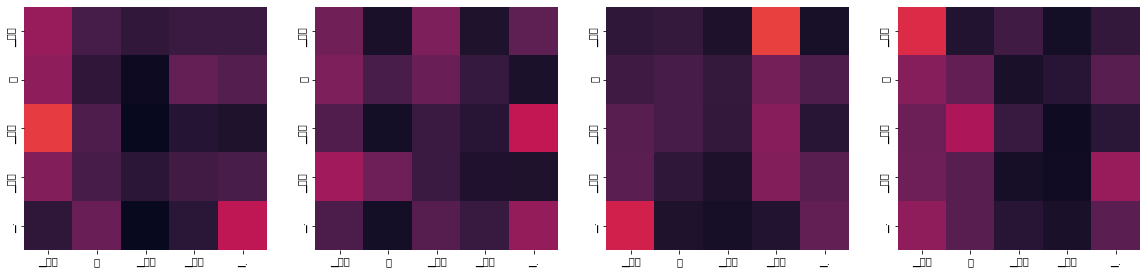

Decoder Self Layer 1


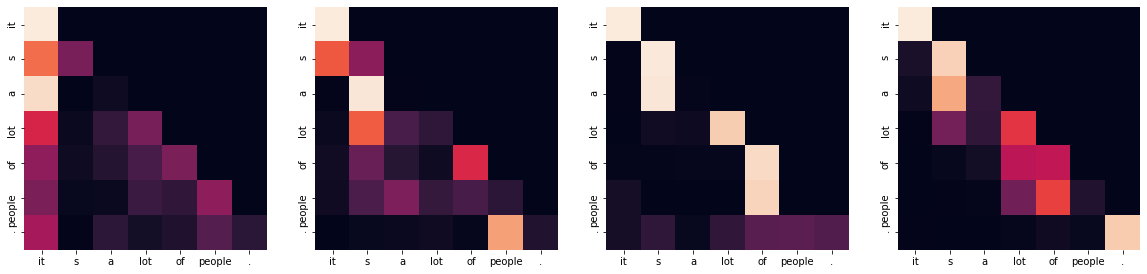

Decoder Src Layer 1


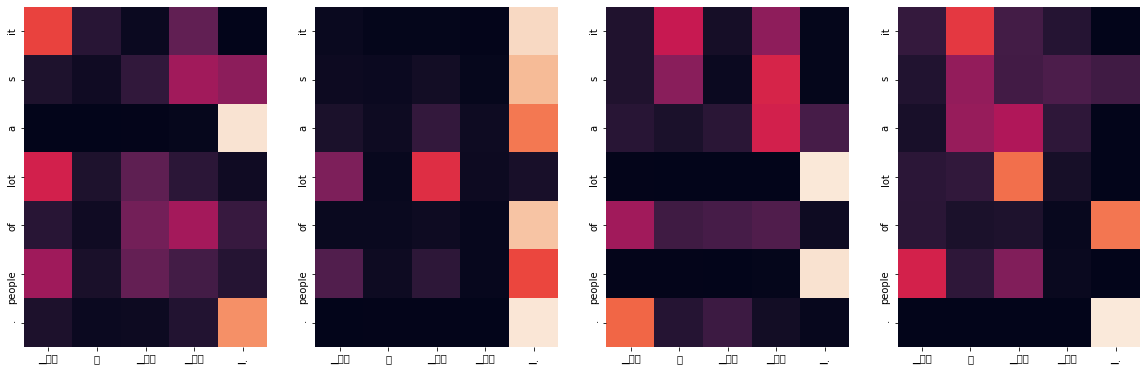

Decoder Self Layer 2


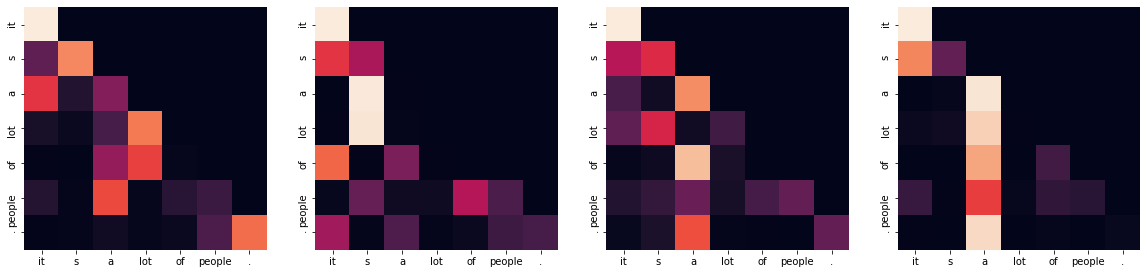

Decoder Src Layer 2


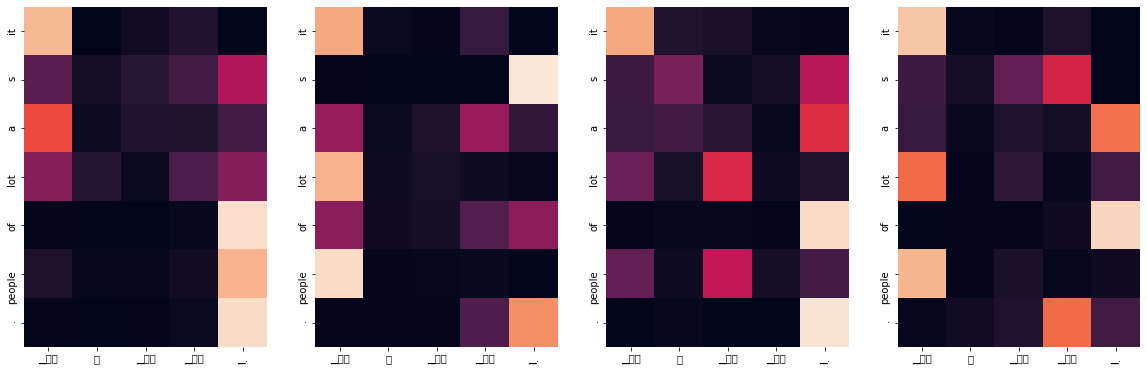

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the plane were killed in the city of the city s capital .
Encoder Layer 1


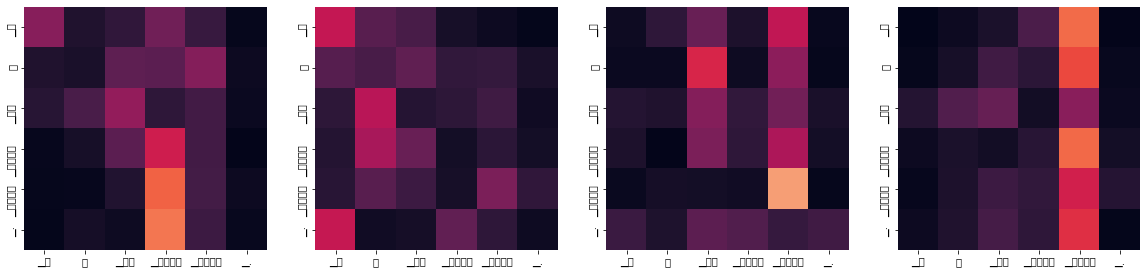

Encoder Layer 2


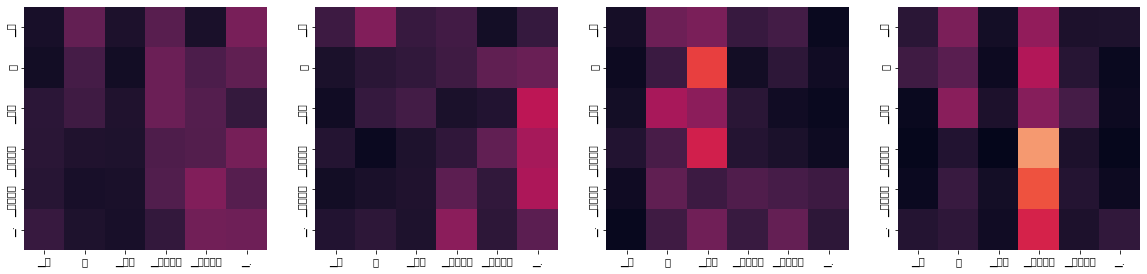

Decoder Self Layer 1


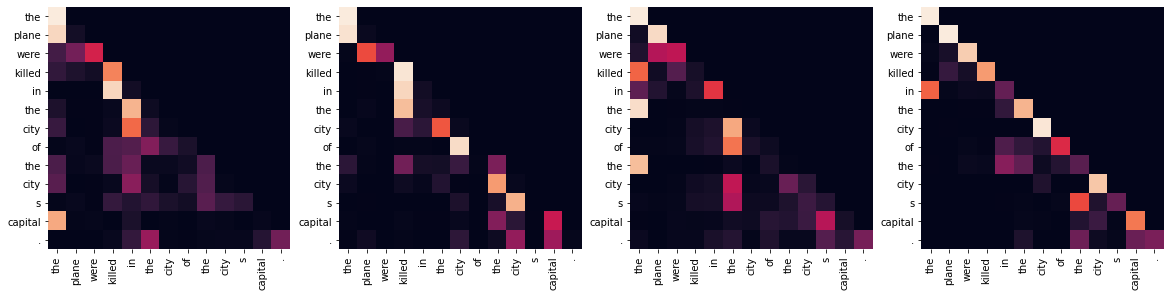

Decoder Src Layer 1


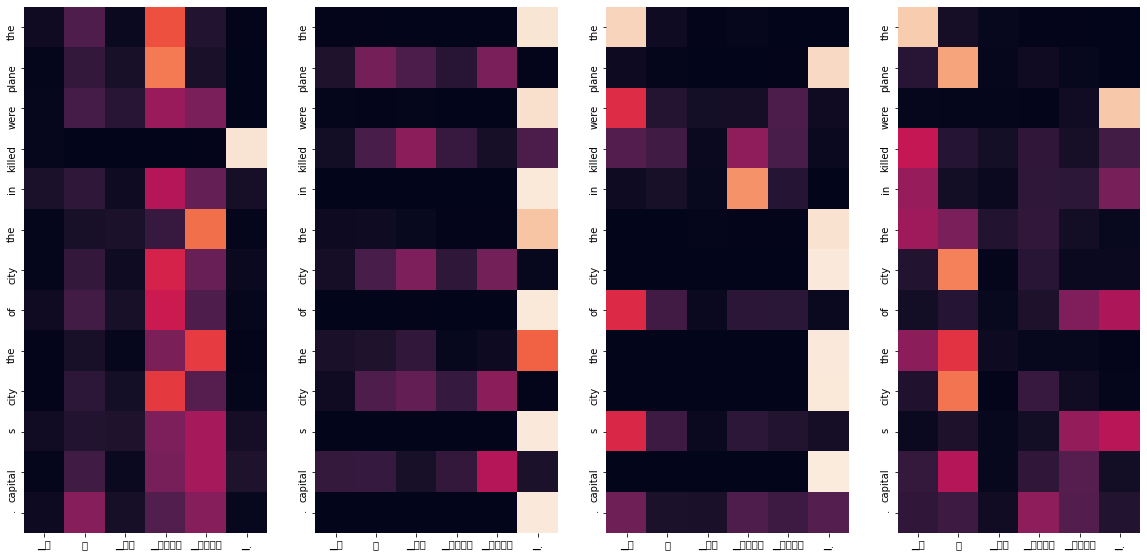

Decoder Self Layer 2


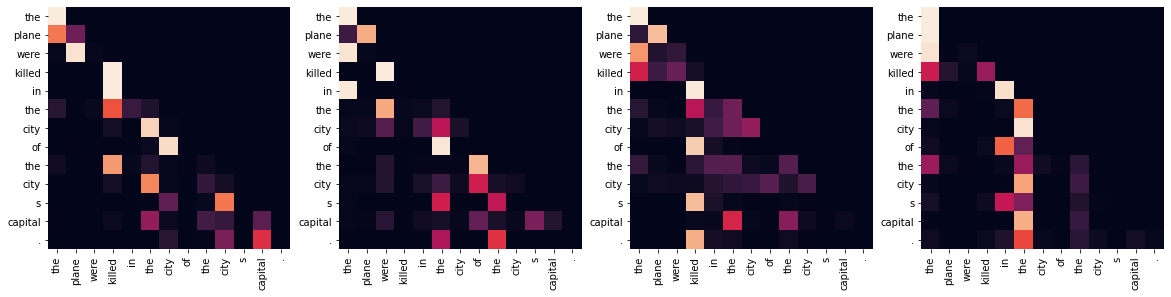

Decoder Src Layer 2


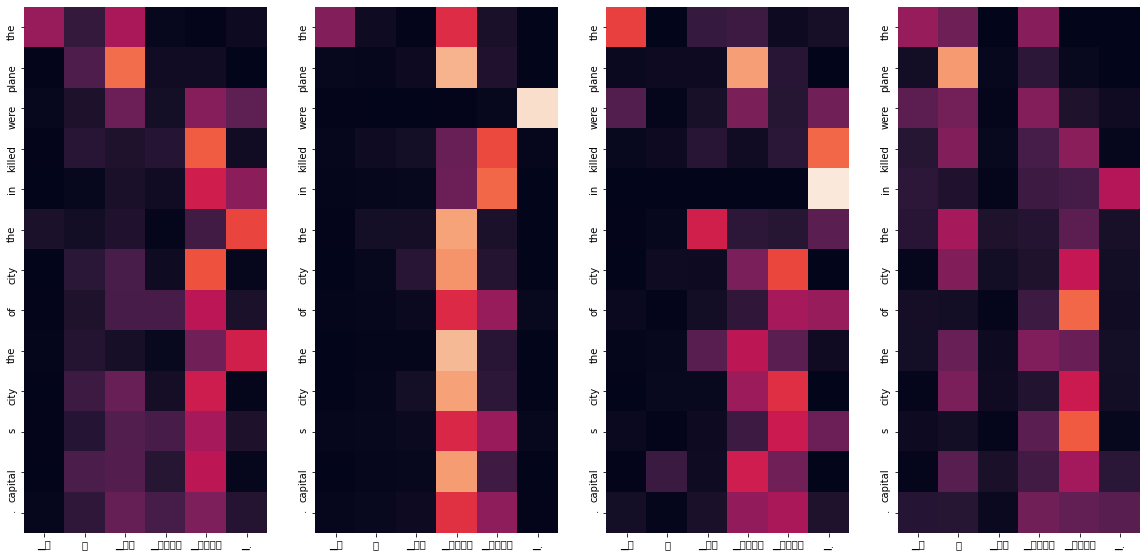

  0%|          | 0/909 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a candidate for the presidential nomination .
Encoder Layer 1


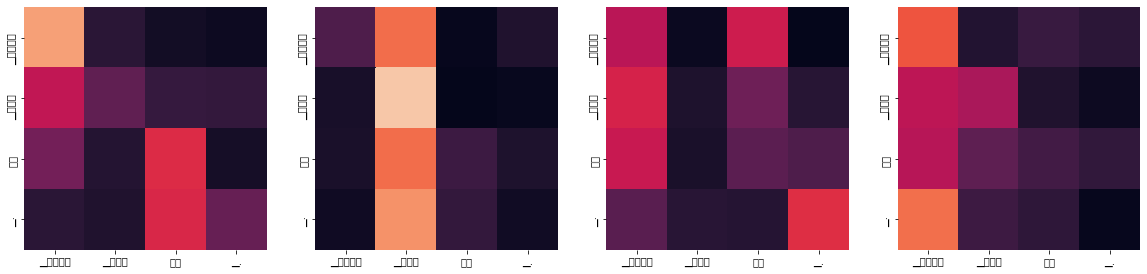

Encoder Layer 2


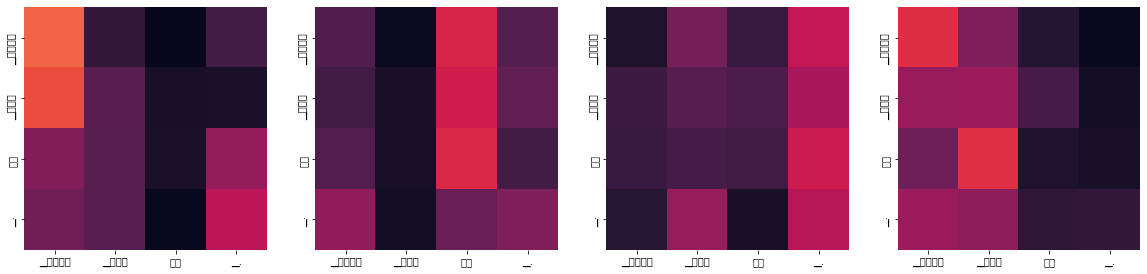

Decoder Self Layer 1


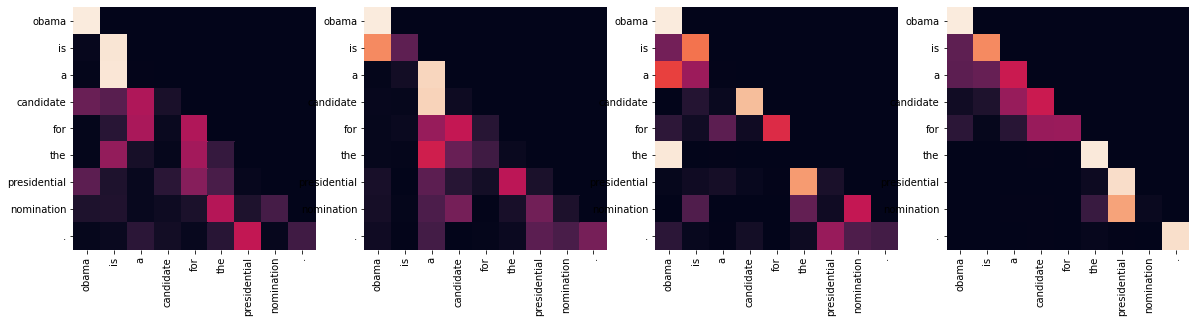

Decoder Src Layer 1


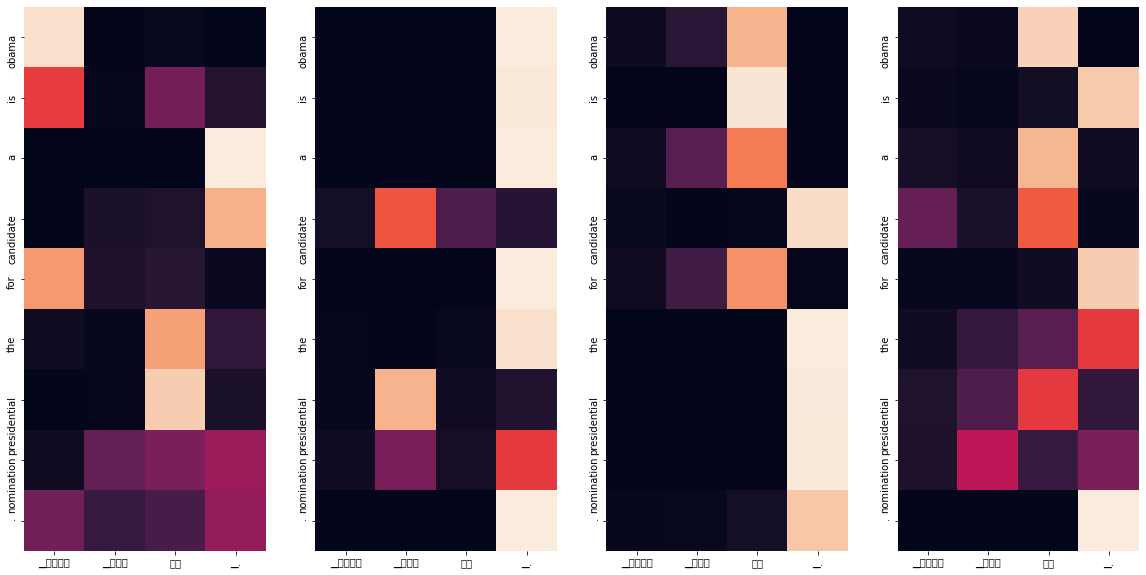

Decoder Self Layer 2


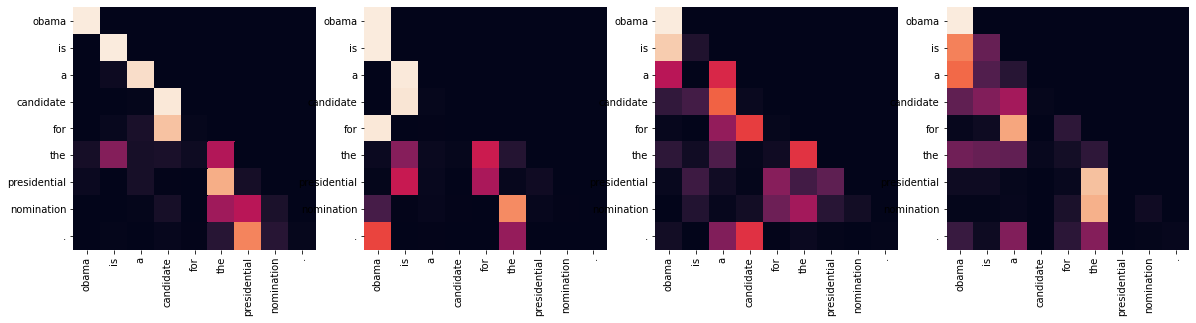

Decoder Src Layer 2


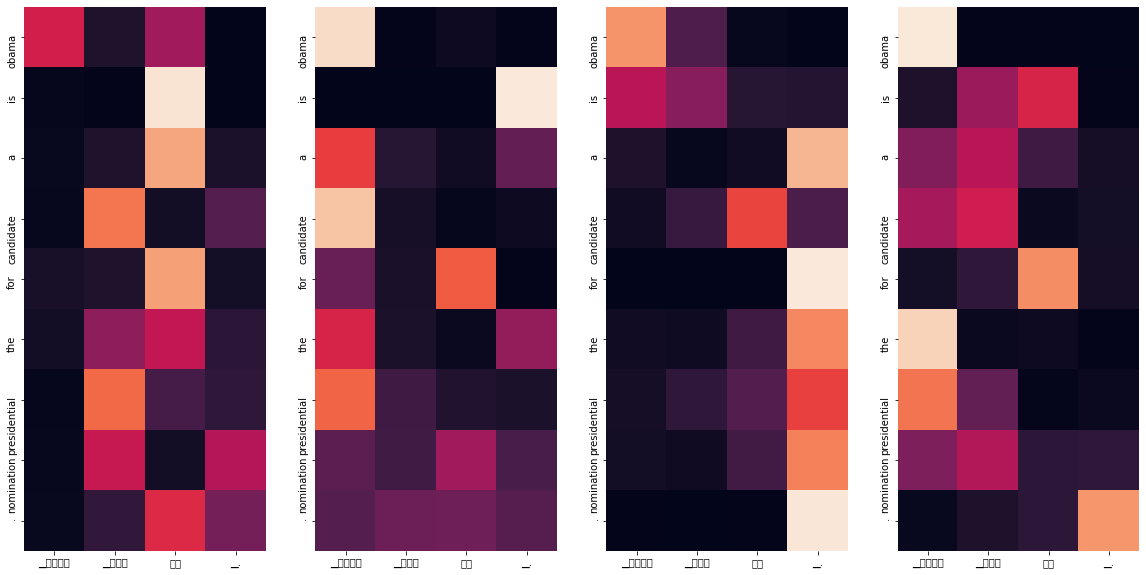

Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city is the city s city .
Encoder Layer 1


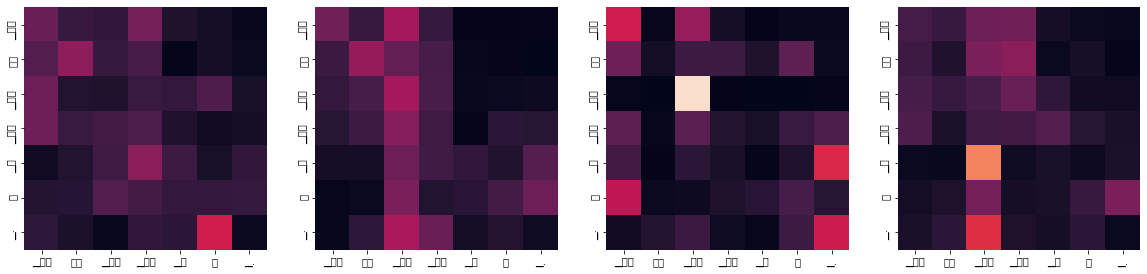

Encoder Layer 2


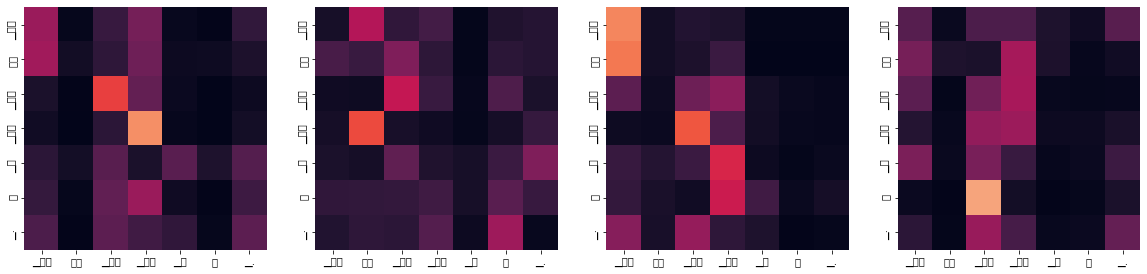

Decoder Self Layer 1


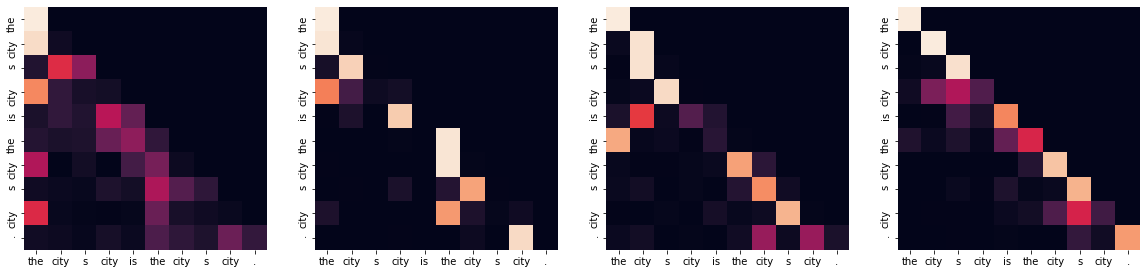

Decoder Src Layer 1


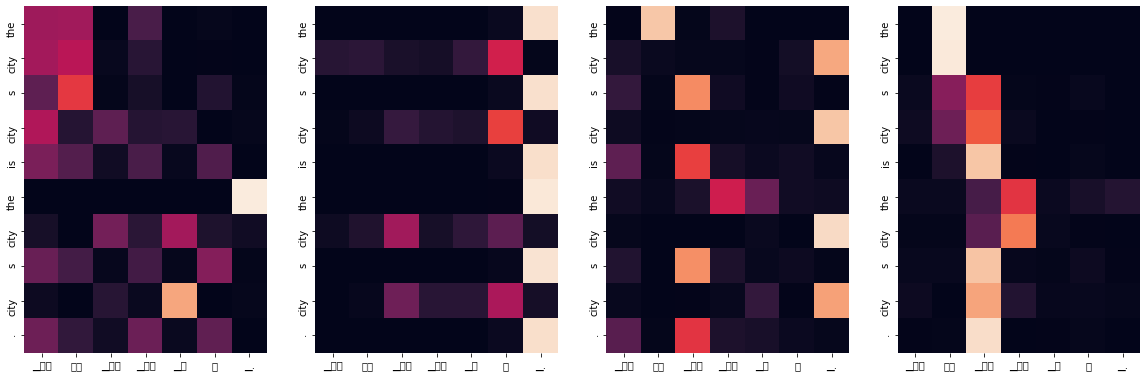

Decoder Self Layer 2


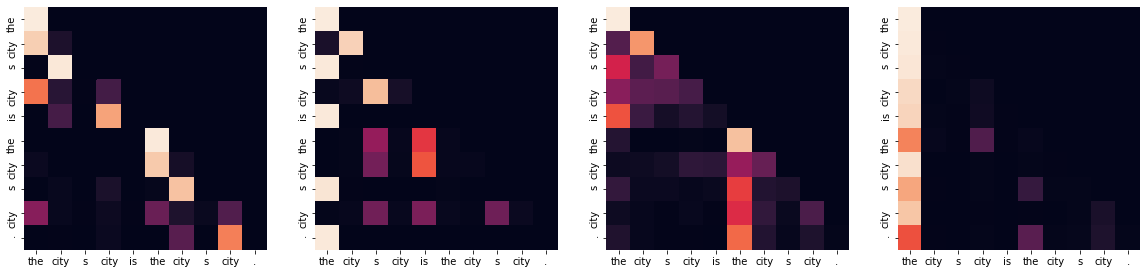

Decoder Src Layer 2


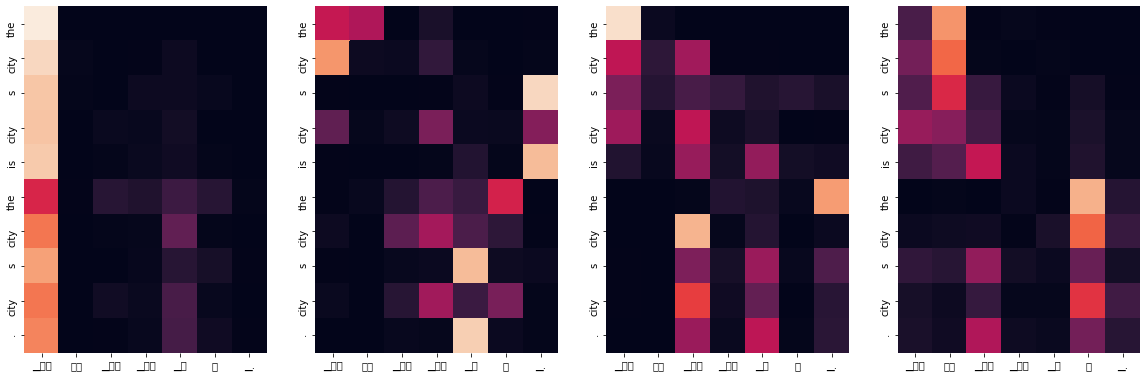

Input: 커피는 필요 없다.
Predicted translation: the coffee is no longer in the coffee .
Encoder Layer 1


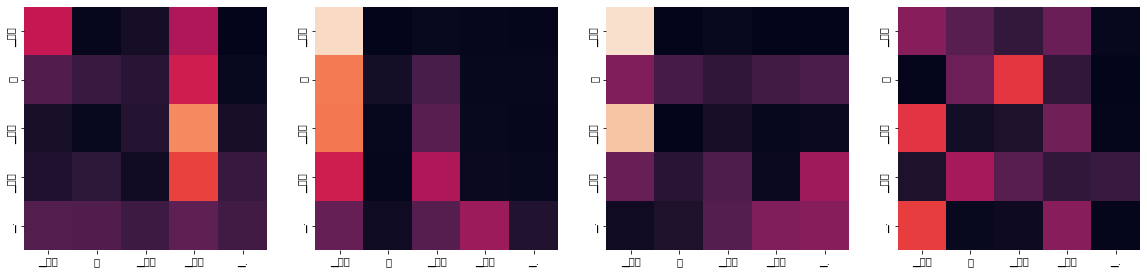

Encoder Layer 2


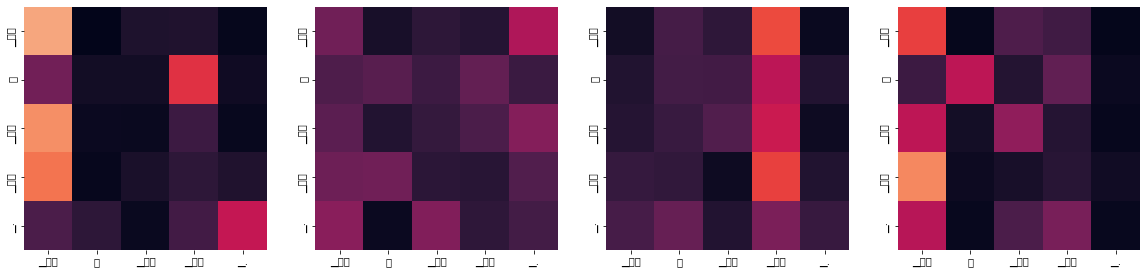

Decoder Self Layer 1


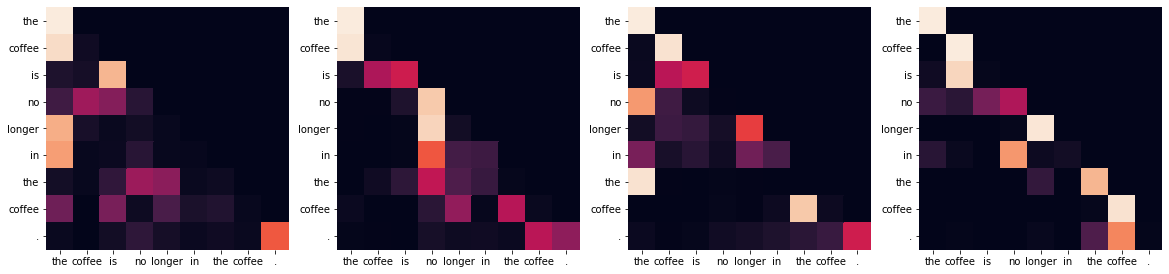

Decoder Src Layer 1


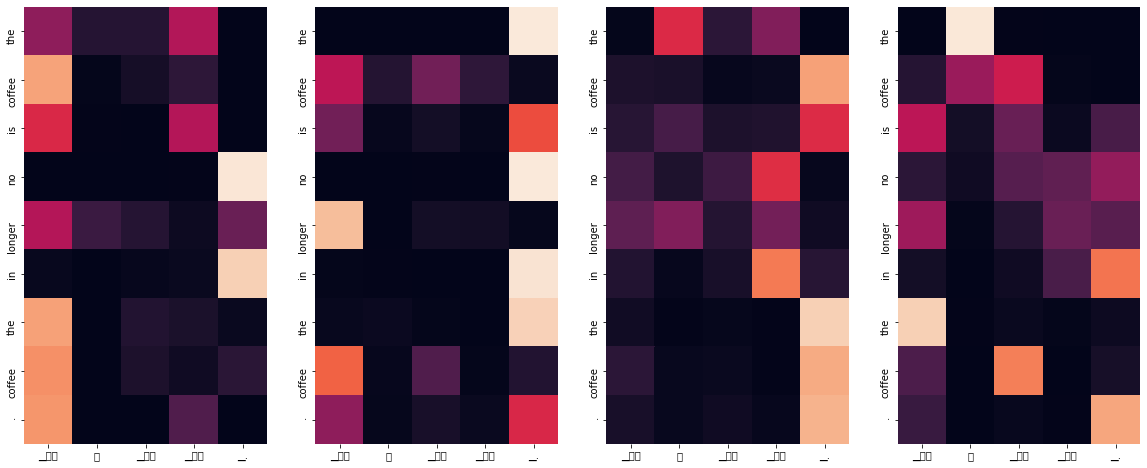

Decoder Self Layer 2


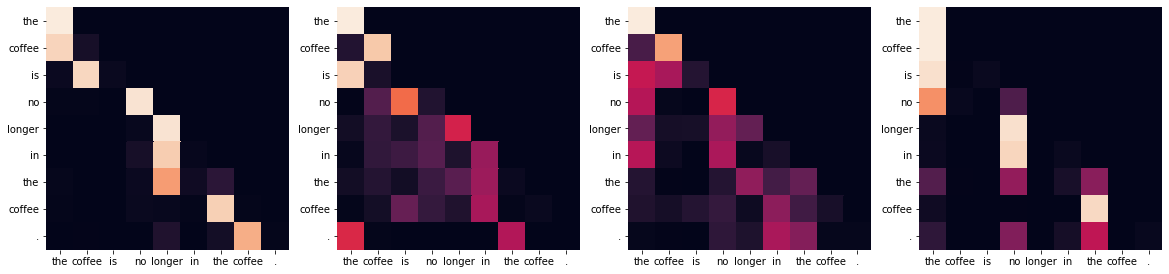

Decoder Src Layer 2


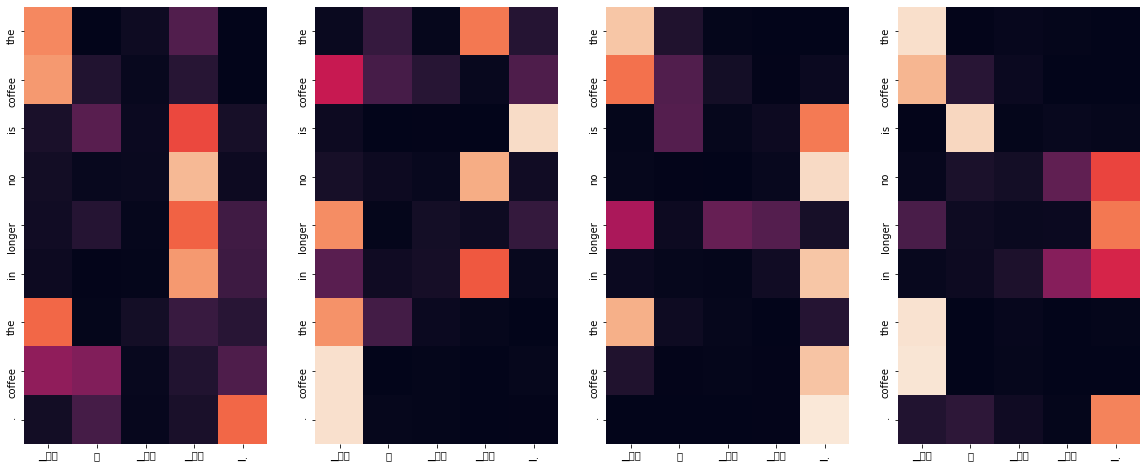

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead were killed .
Encoder Layer 1


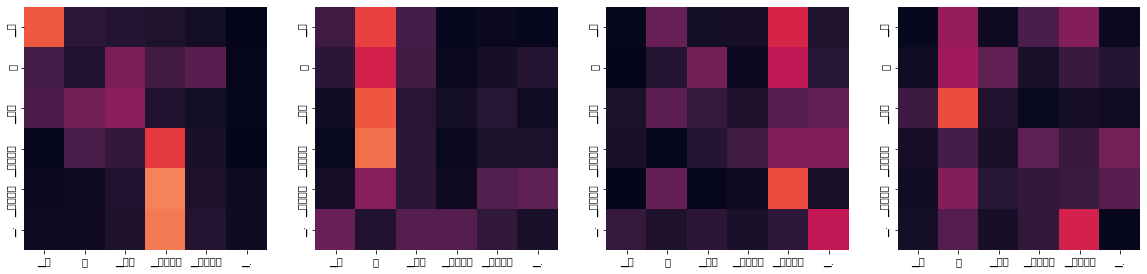

Encoder Layer 2


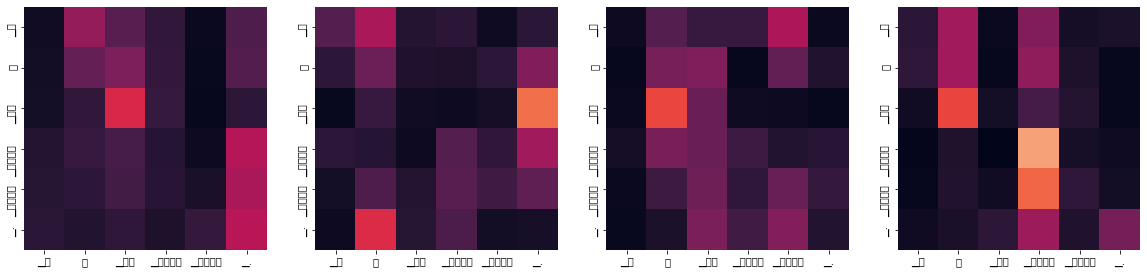

Decoder Self Layer 1


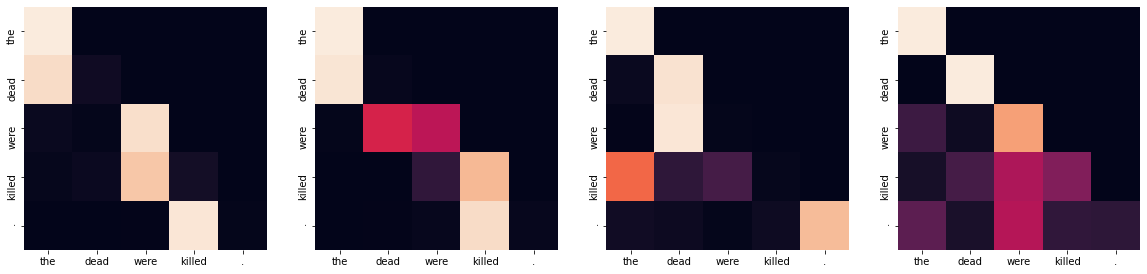

Decoder Src Layer 1


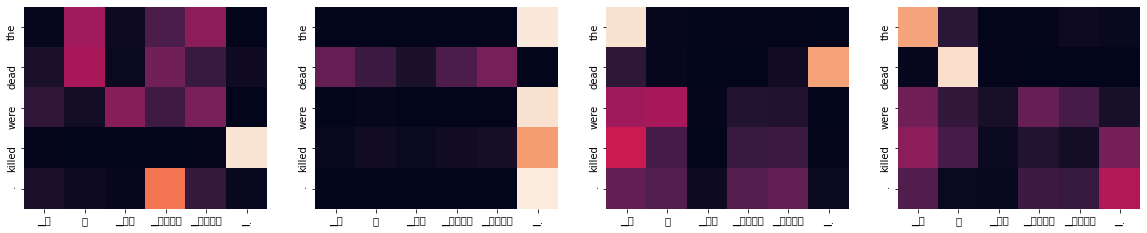

Decoder Self Layer 2


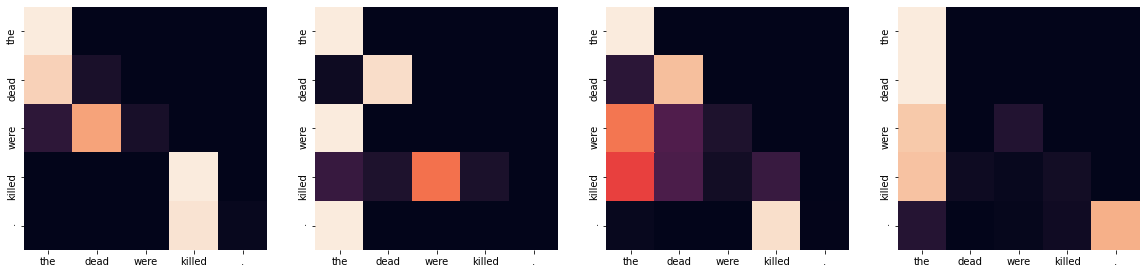

Decoder Src Layer 2


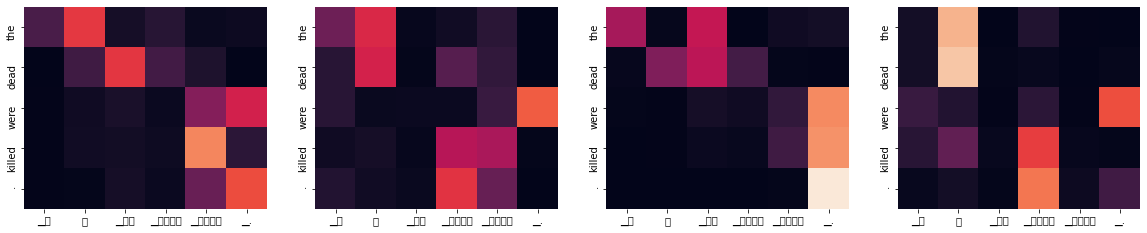

  0%|          | 0/909 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president elect lee is the president .
Encoder Layer 1


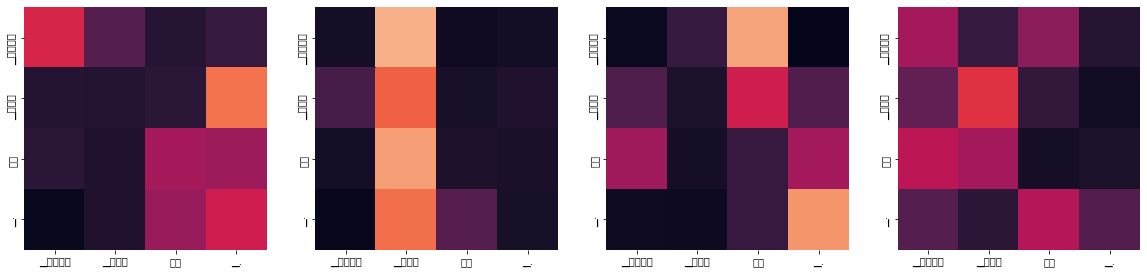

Encoder Layer 2


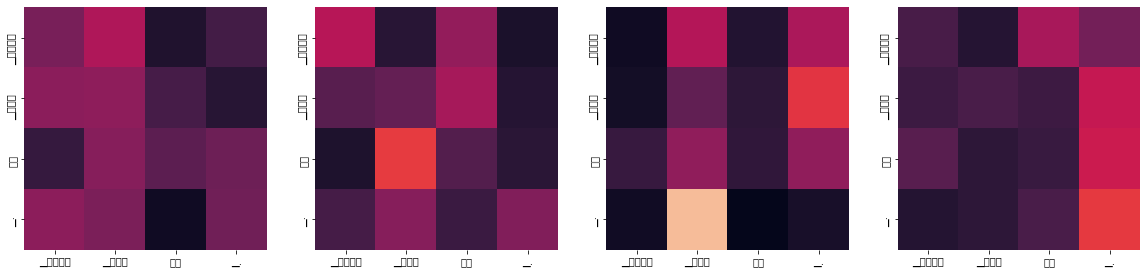

Decoder Self Layer 1


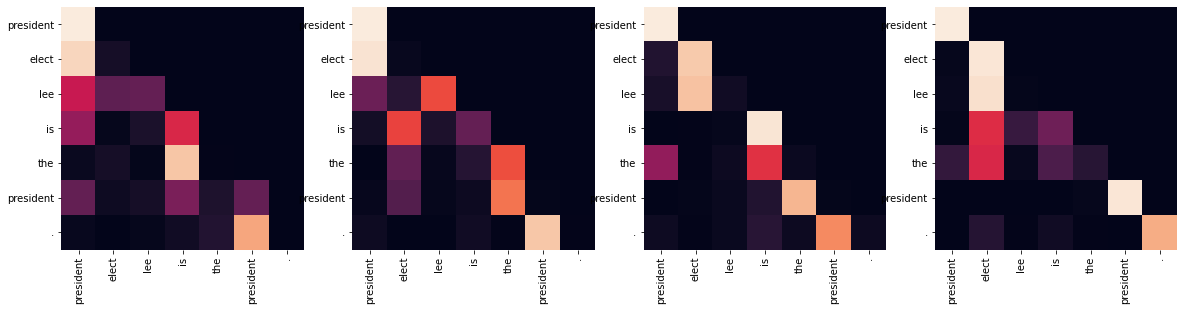

Decoder Src Layer 1


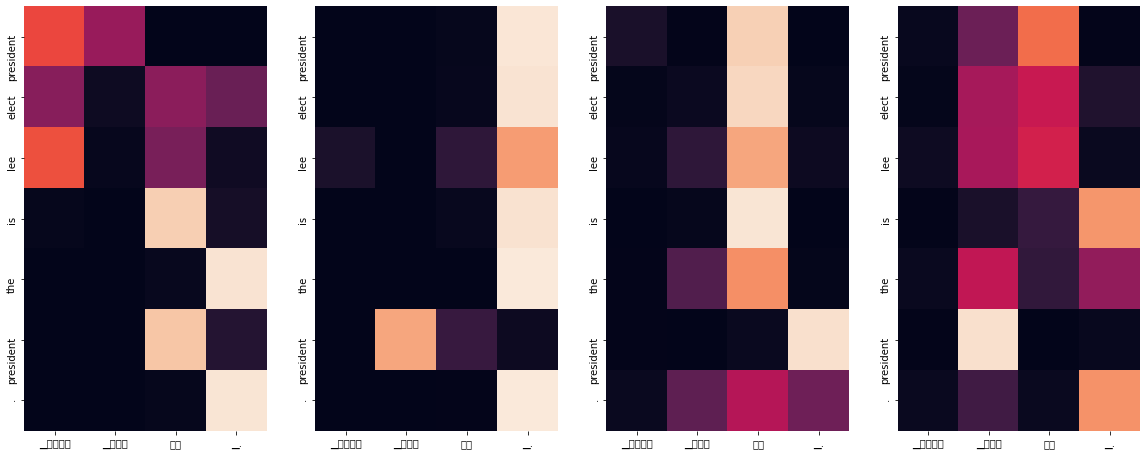

Decoder Self Layer 2


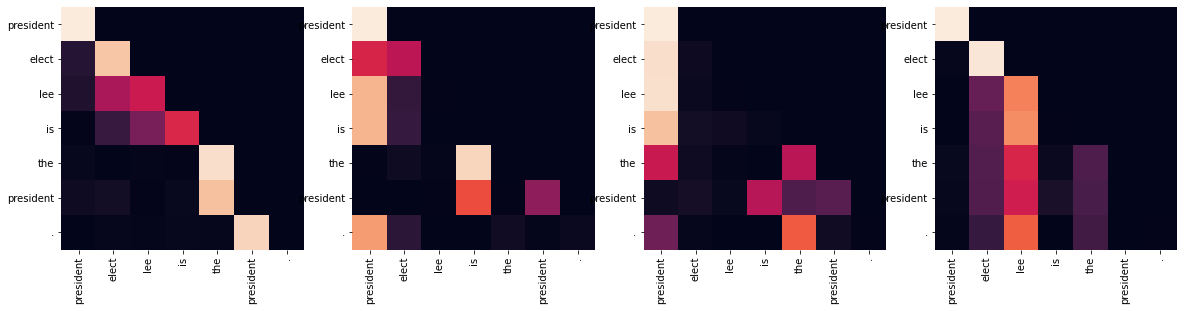

Decoder Src Layer 2


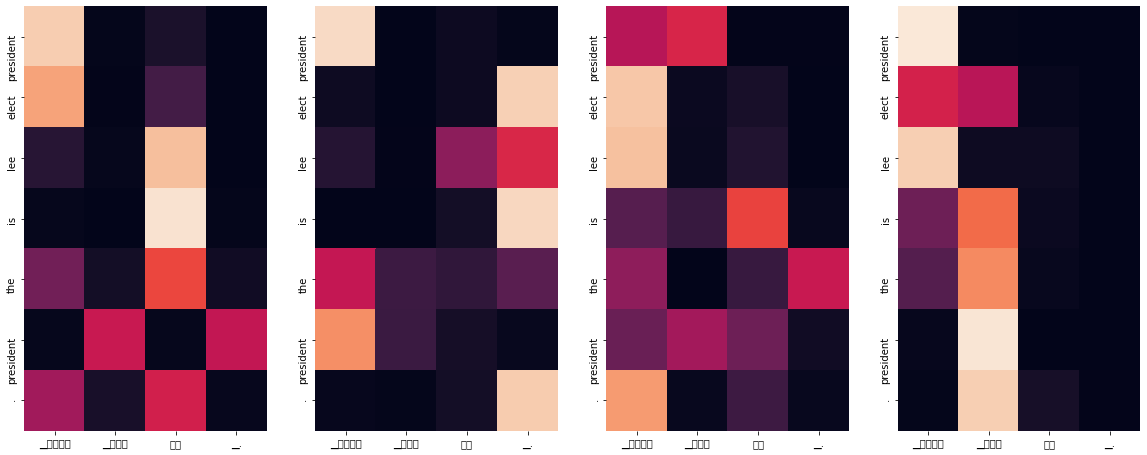

Input: 시민들은 도시 속에 산다.
Predicted translation: the city s civic cities are in the town of the cities .
Encoder Layer 1


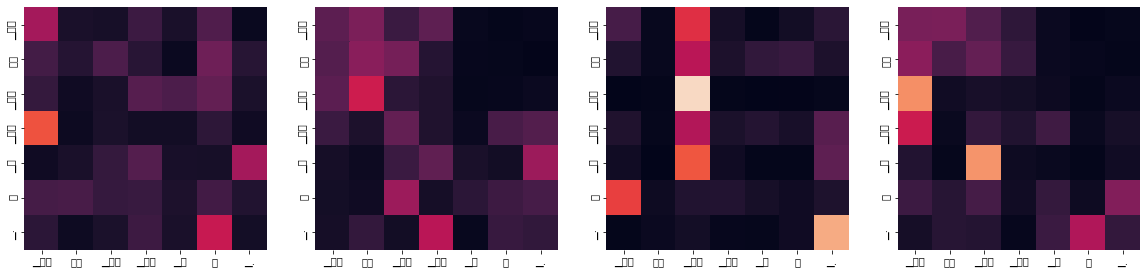

Encoder Layer 2


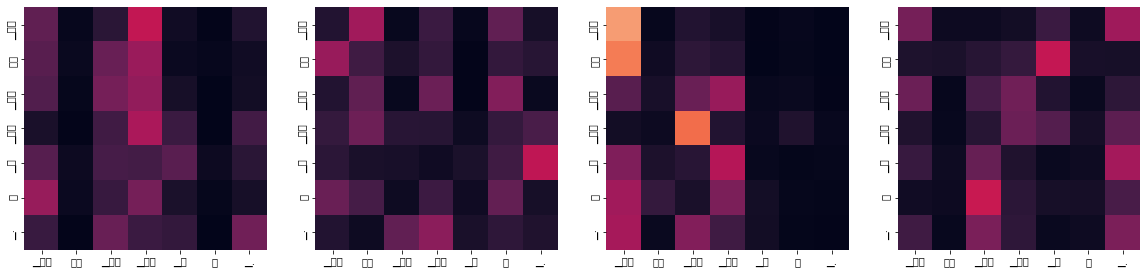

Decoder Self Layer 1


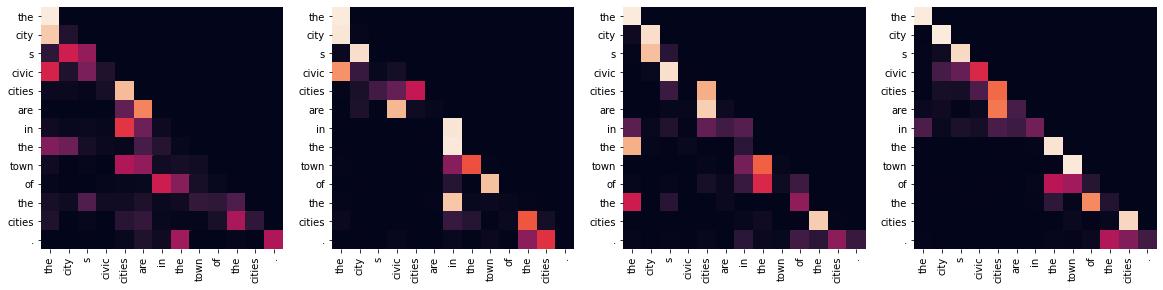

Decoder Src Layer 1


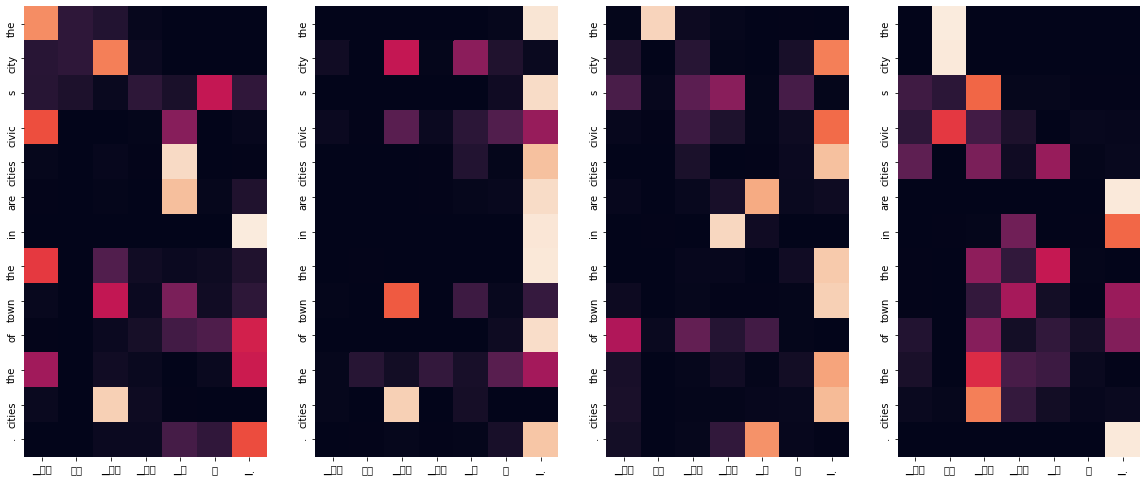

Decoder Self Layer 2


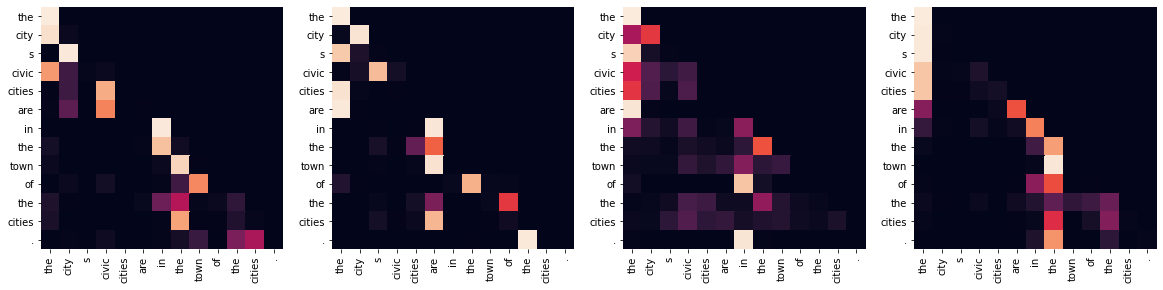

Decoder Src Layer 2


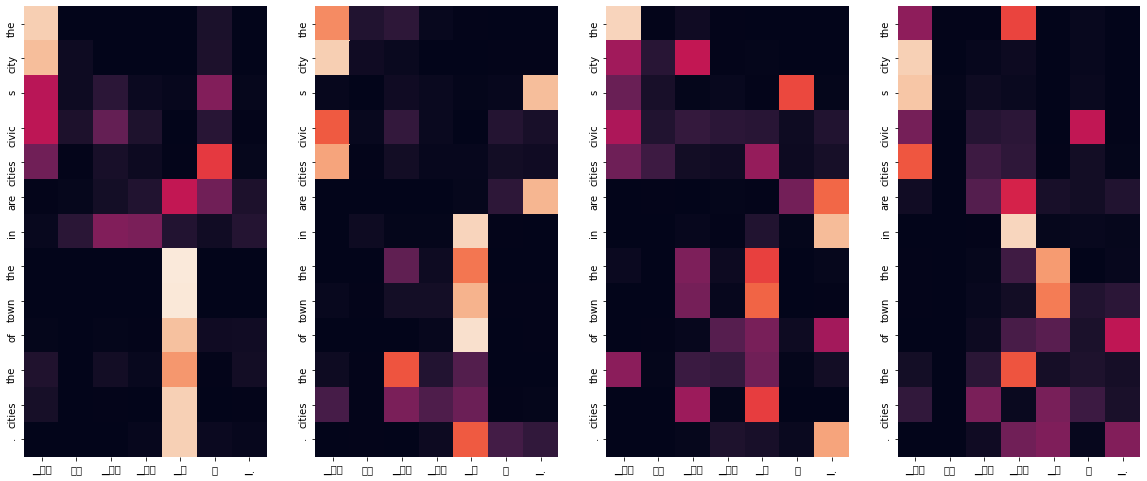

Input: 커피는 필요 없다.
Predicted translation: coffee don t need coffee .
Encoder Layer 1


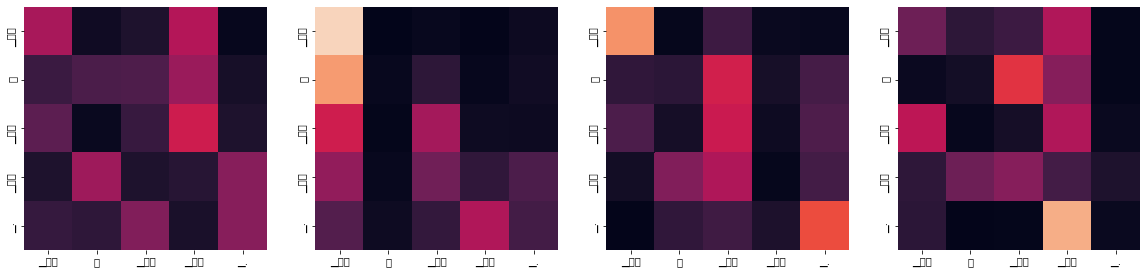

Encoder Layer 2


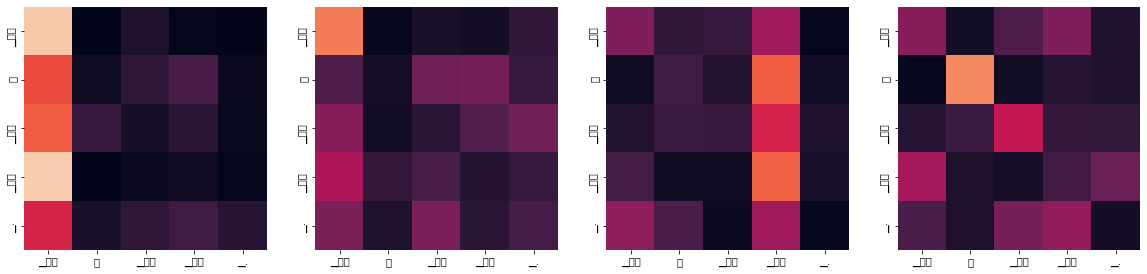

Decoder Self Layer 1


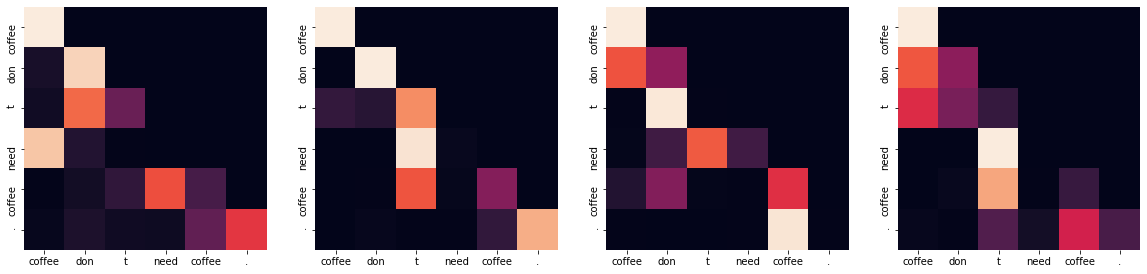

Decoder Src Layer 1


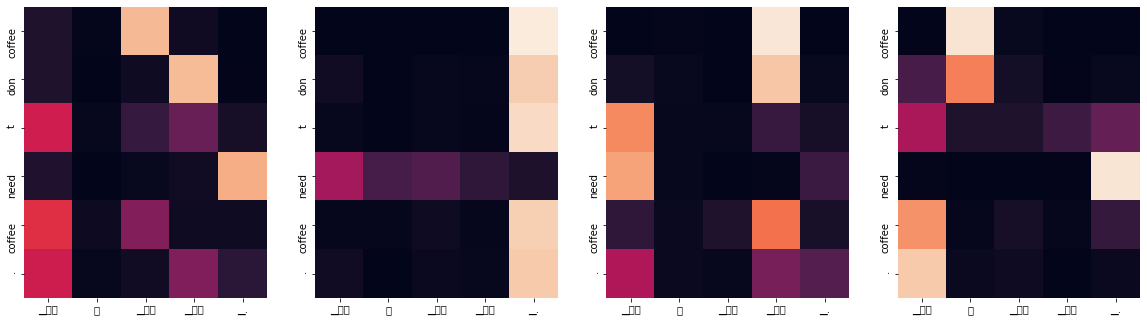

Decoder Self Layer 2


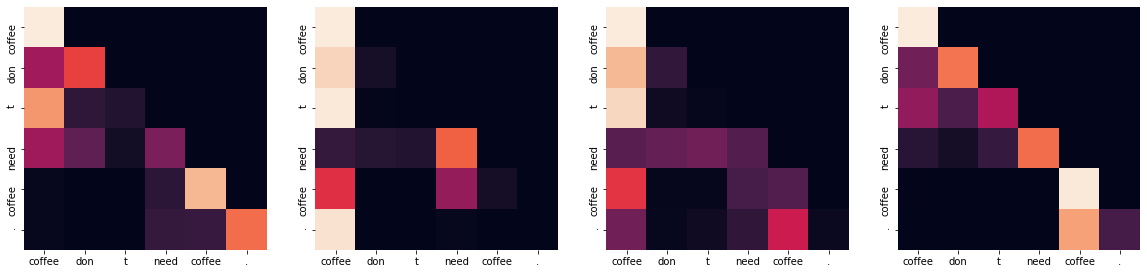

Decoder Src Layer 2


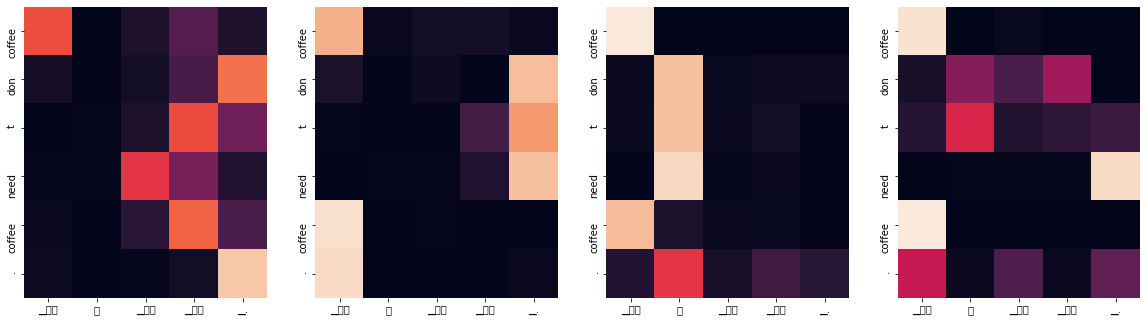

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven were killed , including one of the seven were in the area .
Encoder Layer 1


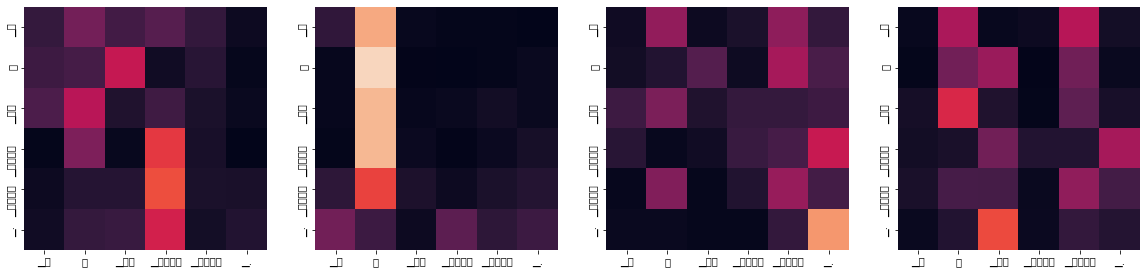

Encoder Layer 2


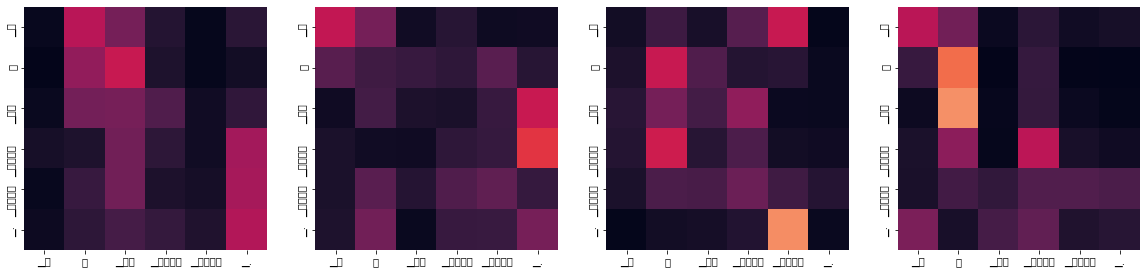

Decoder Self Layer 1


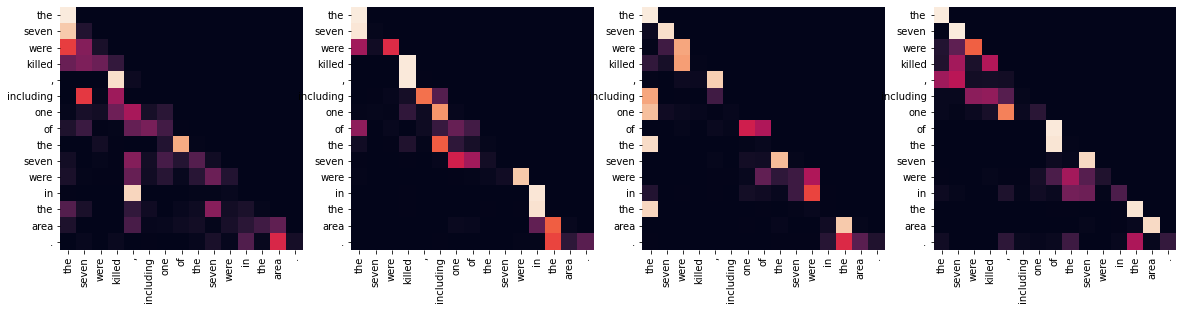

Decoder Src Layer 1


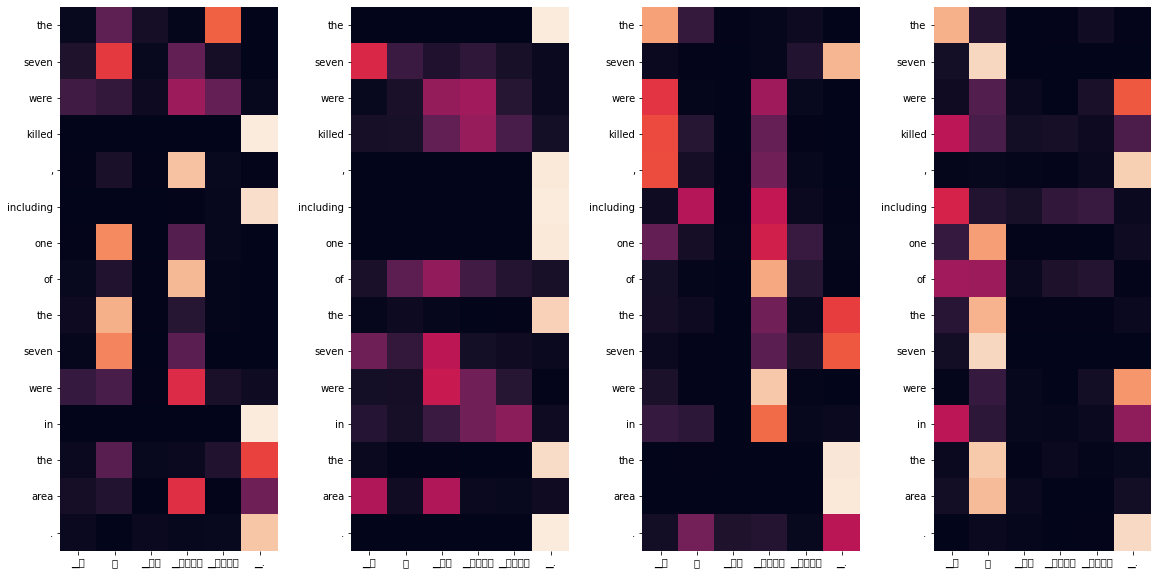

Decoder Self Layer 2


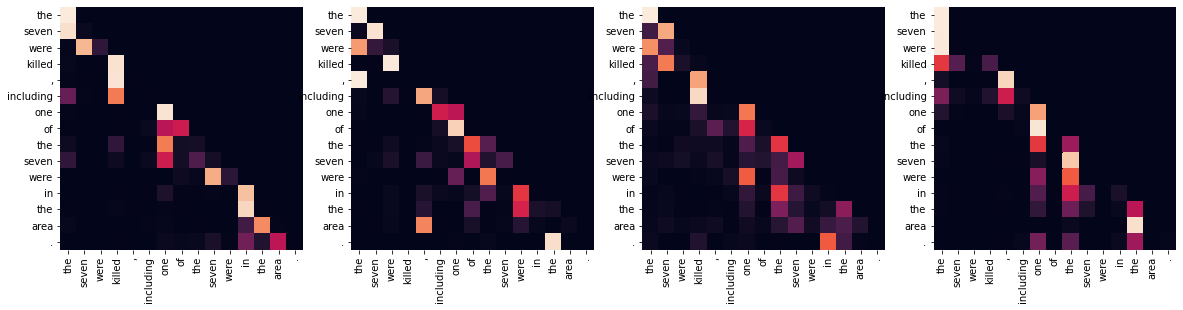

Decoder Src Layer 2


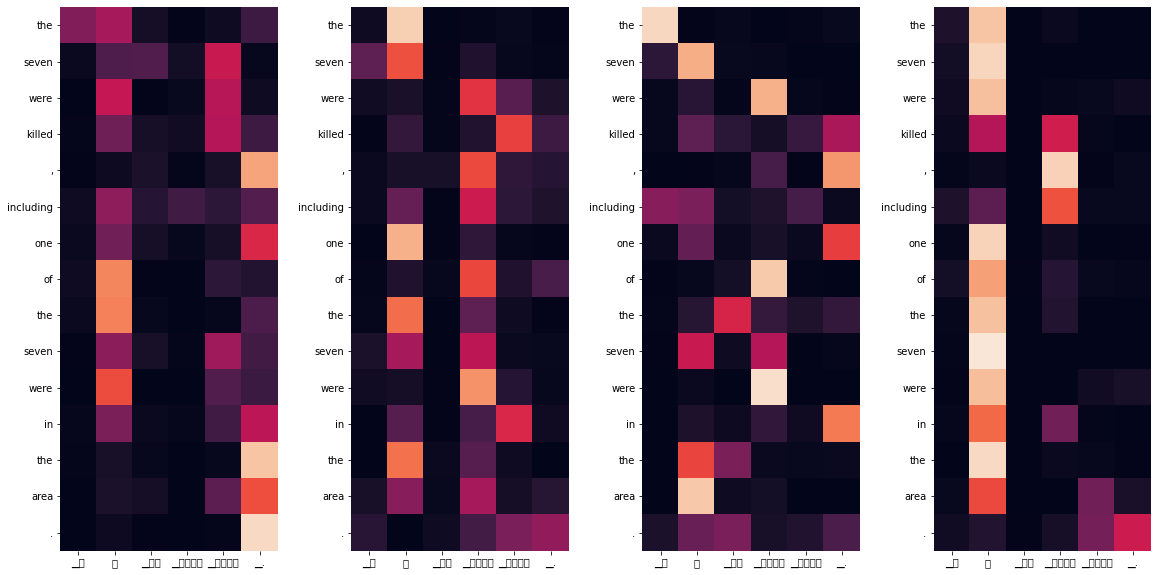

  0%|          | 0/909 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president elect
Encoder Layer 1


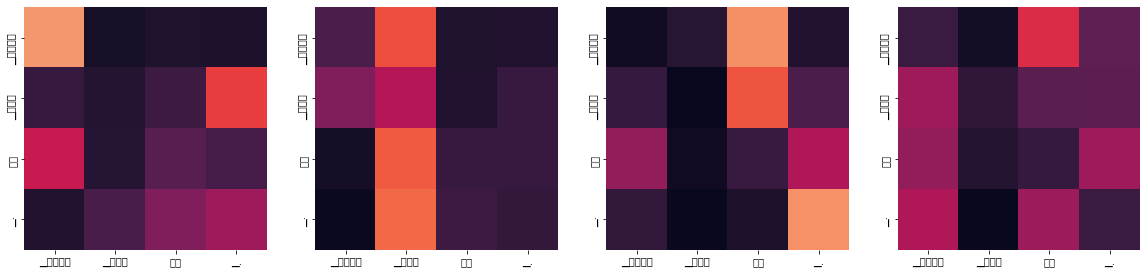

Encoder Layer 2


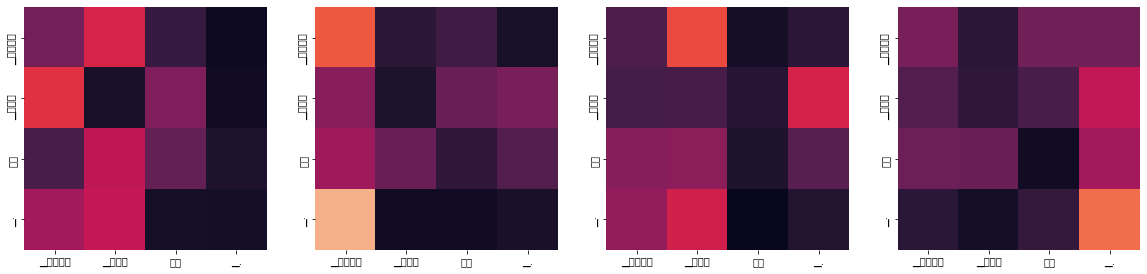

Decoder Self Layer 1


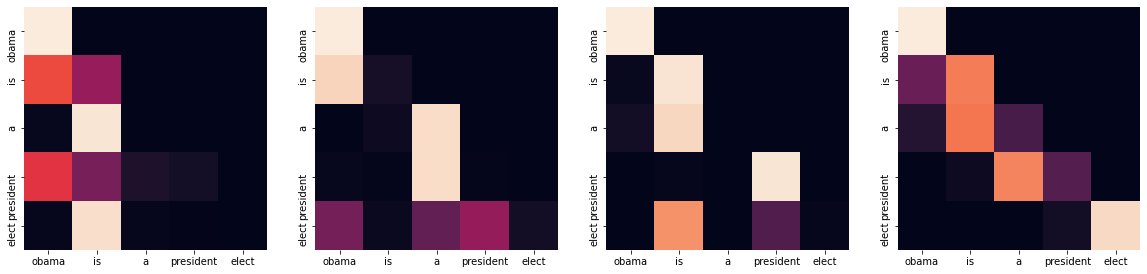

Decoder Src Layer 1


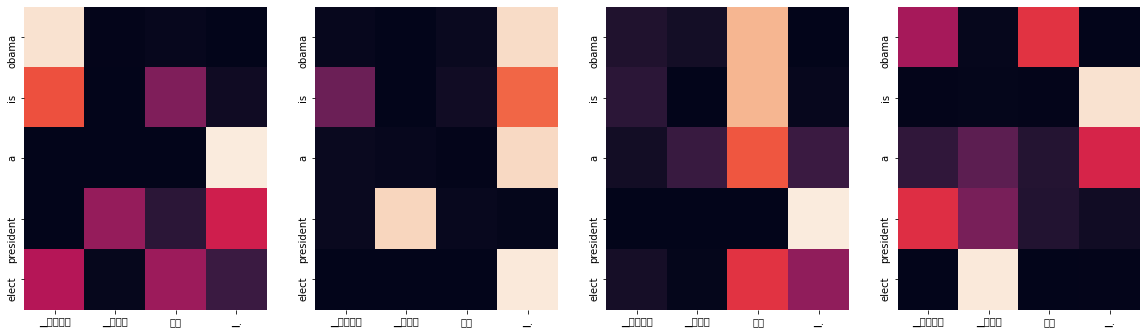

Decoder Self Layer 2


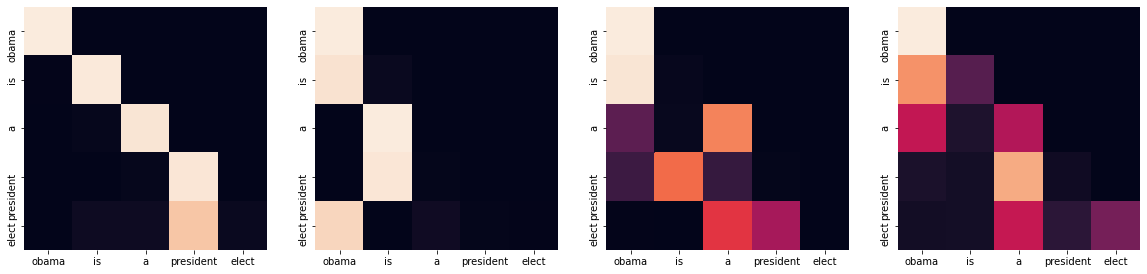

Decoder Src Layer 2


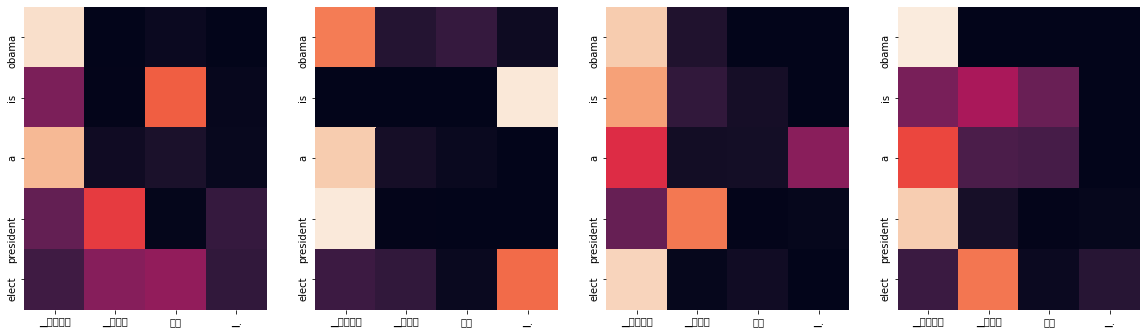

Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are in cities across the city .
Encoder Layer 1


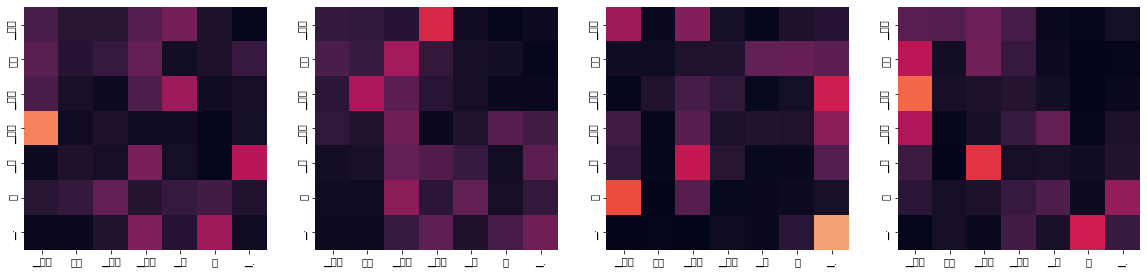

Encoder Layer 2


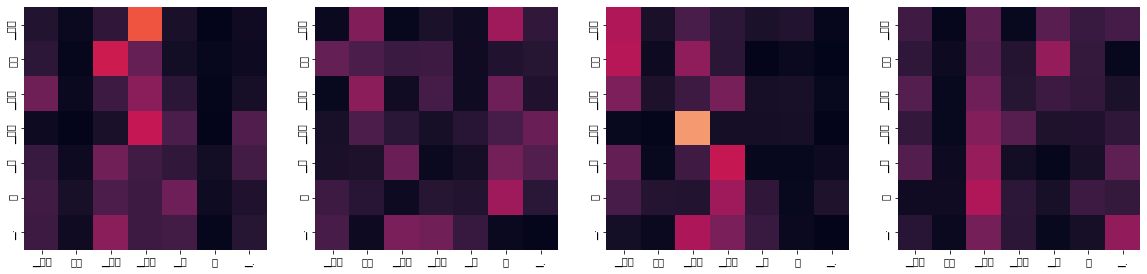

Decoder Self Layer 1


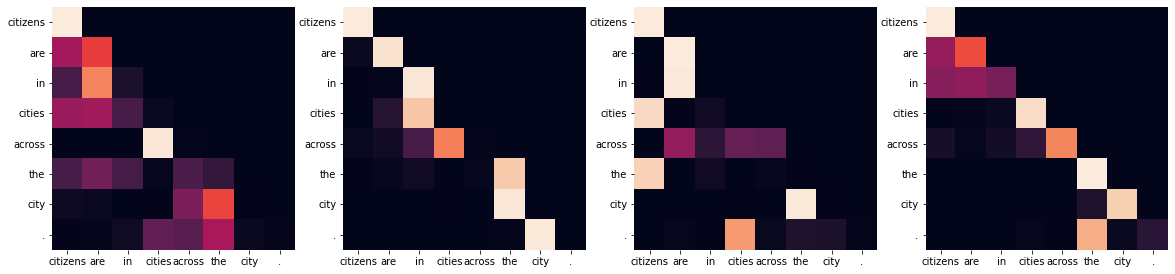

Decoder Src Layer 1


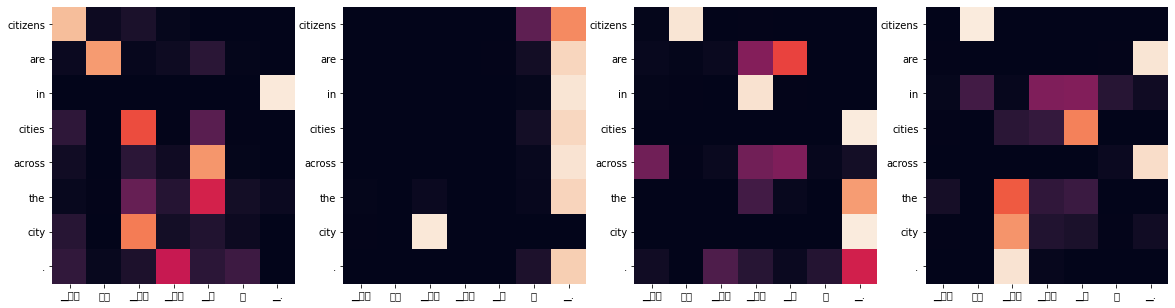

Decoder Self Layer 2


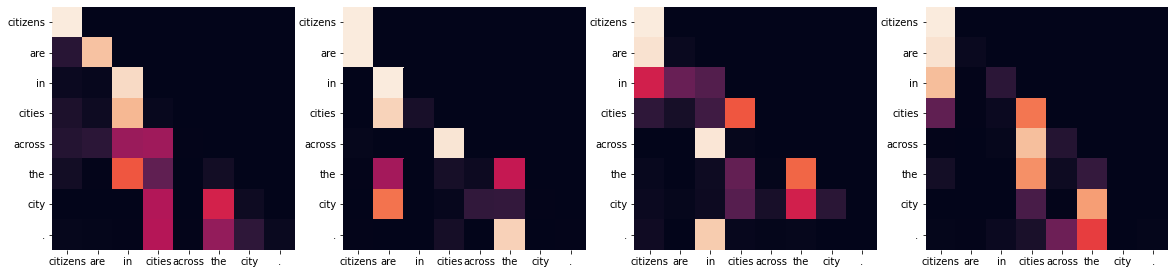

Decoder Src Layer 2


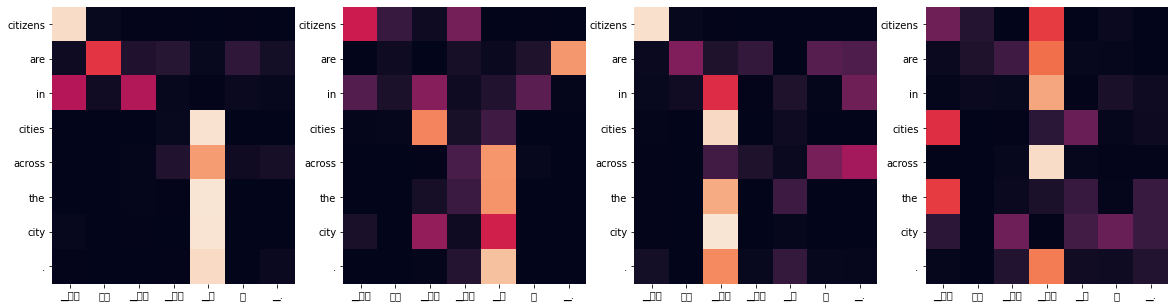

Input: 커피는 필요 없다.
Predicted translation: there s no need for coffee .
Encoder Layer 1


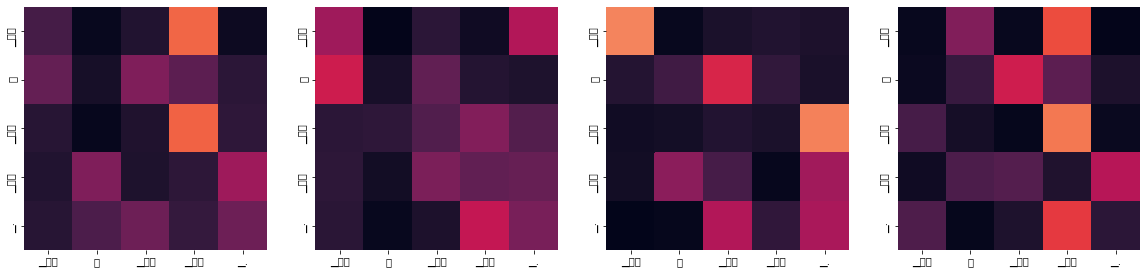

Encoder Layer 2


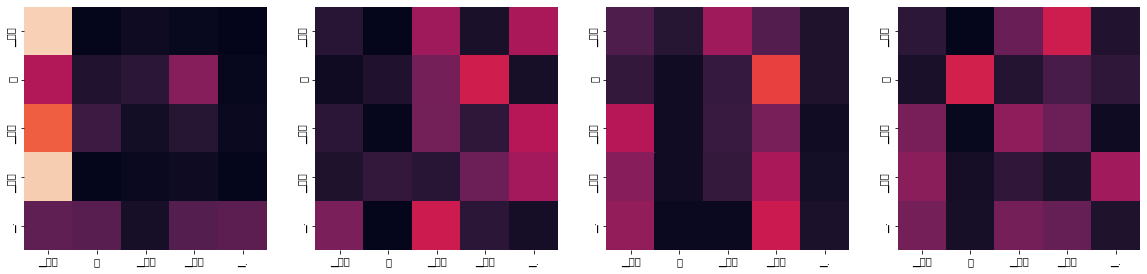

Decoder Self Layer 1


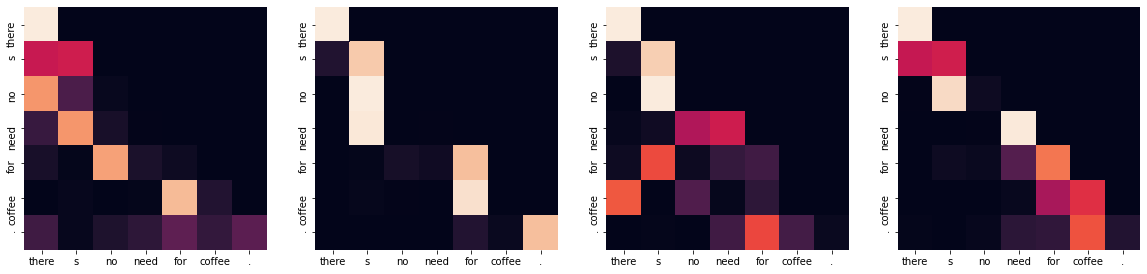

Decoder Src Layer 1


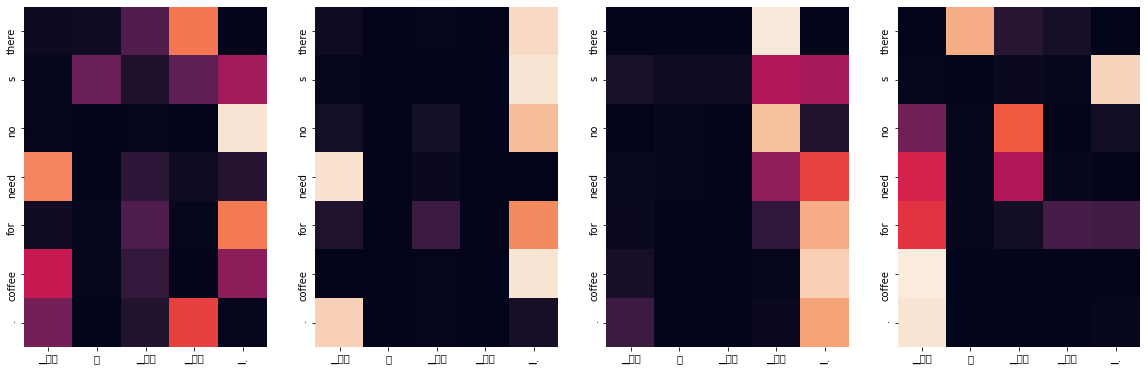

Decoder Self Layer 2


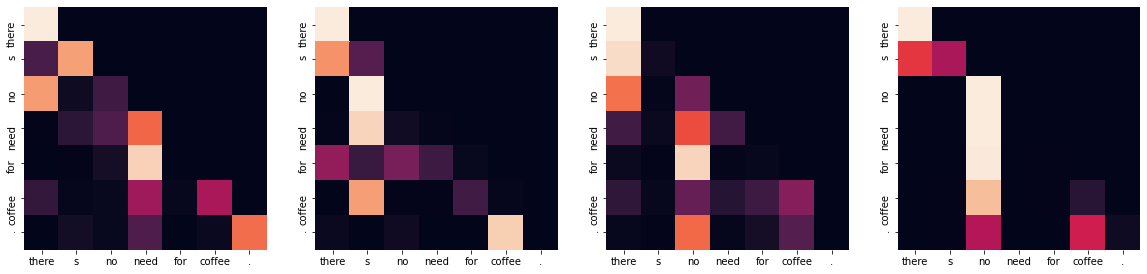

Decoder Src Layer 2


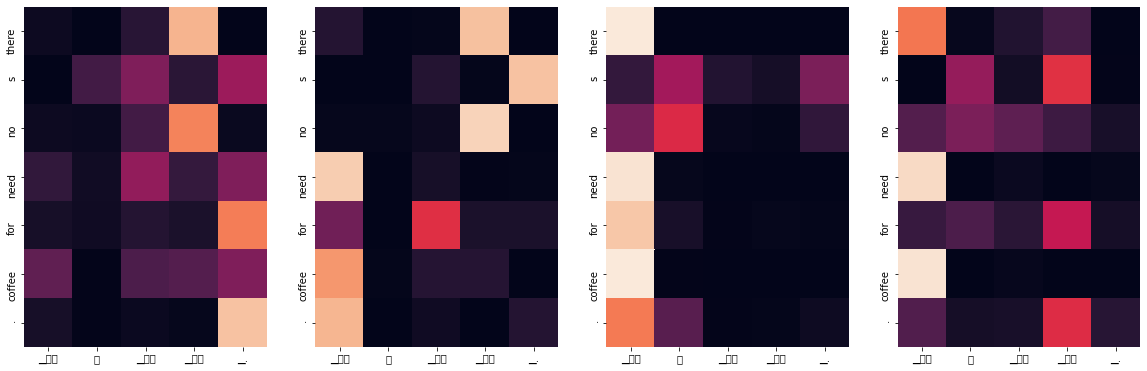

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were reported killed .
Encoder Layer 1


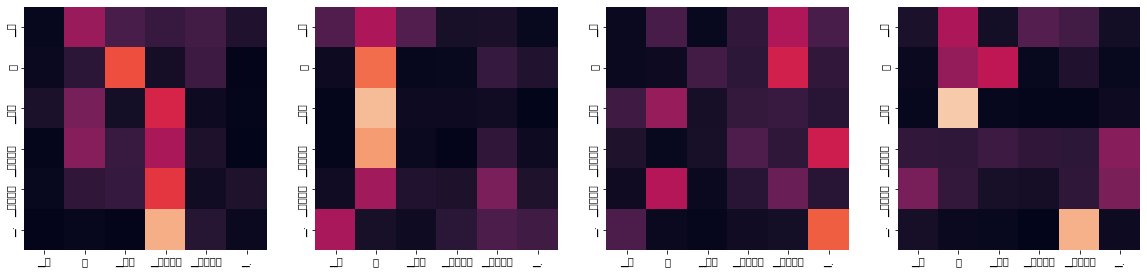

Encoder Layer 2


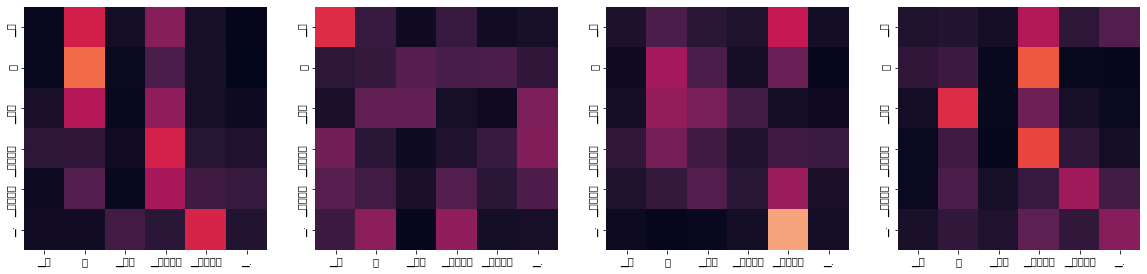

Decoder Self Layer 1


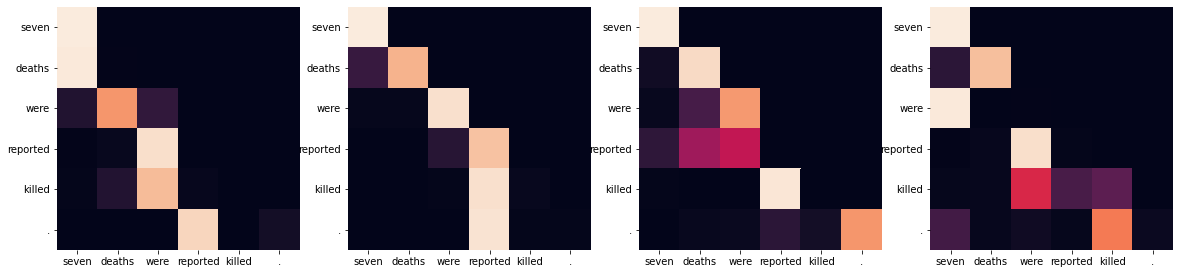

Decoder Src Layer 1


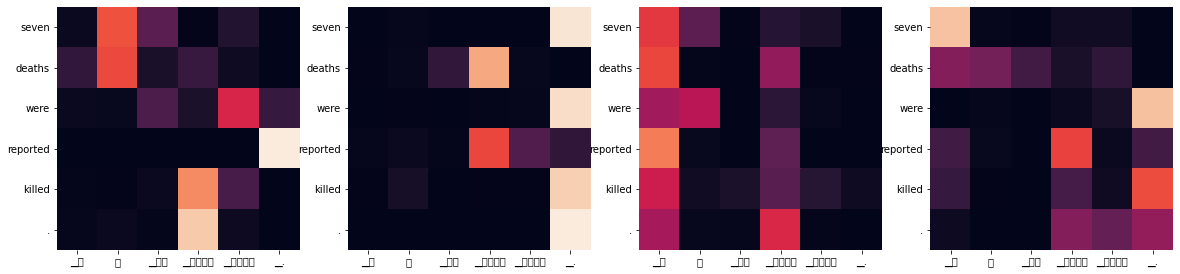

Decoder Self Layer 2


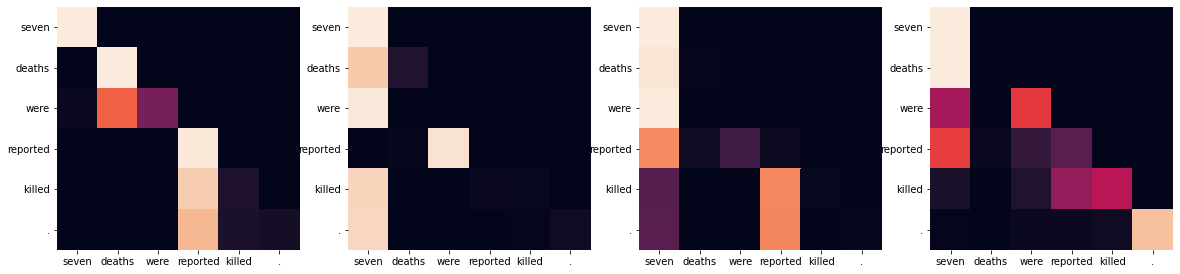

Decoder Src Layer 2


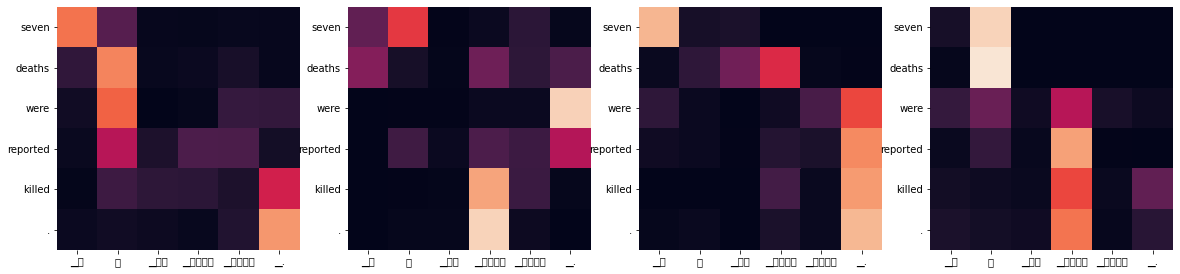

  0%|          | 0/909 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president , illinois .
Encoder Layer 1


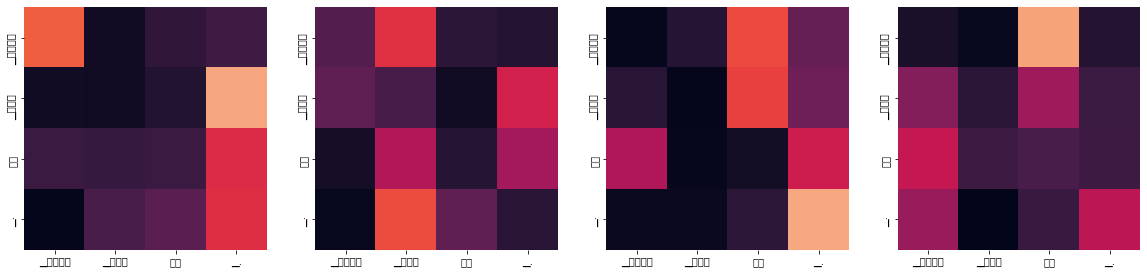

Encoder Layer 2


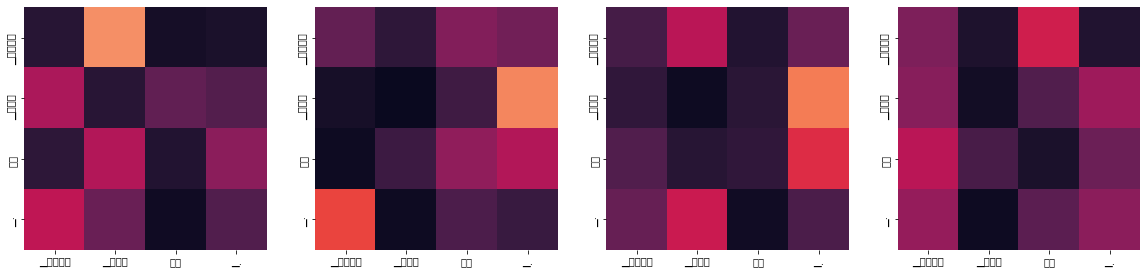

Decoder Self Layer 1


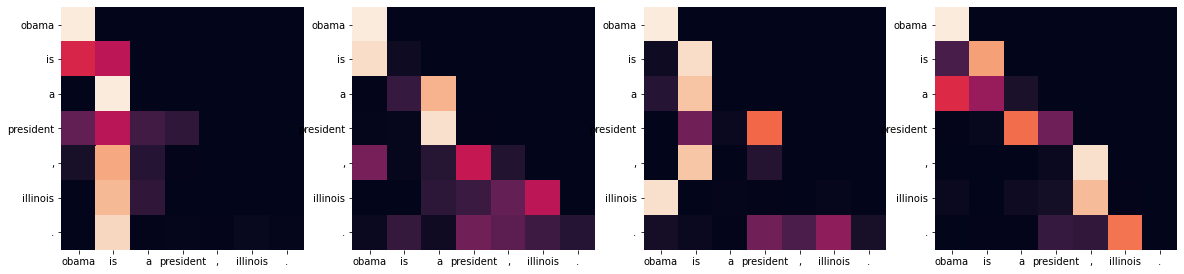

Decoder Src Layer 1


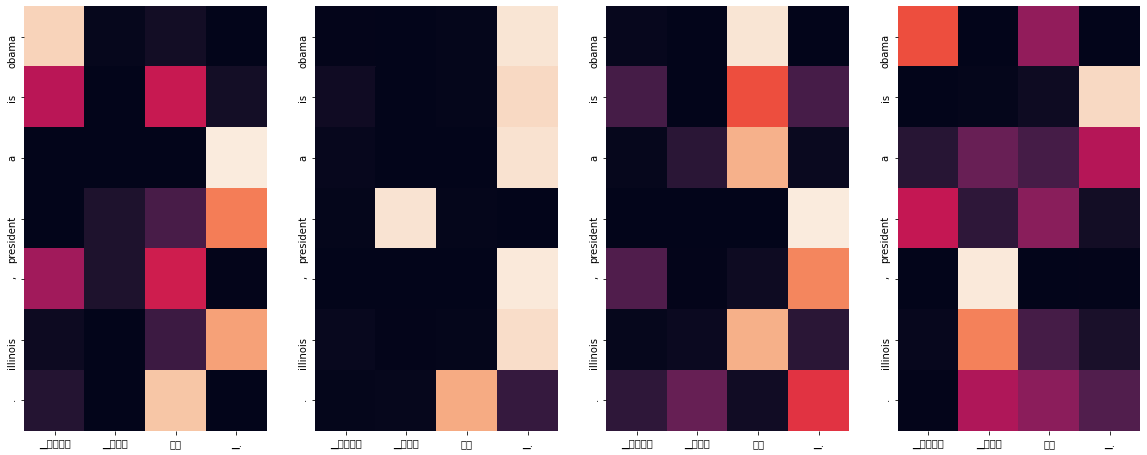

Decoder Self Layer 2


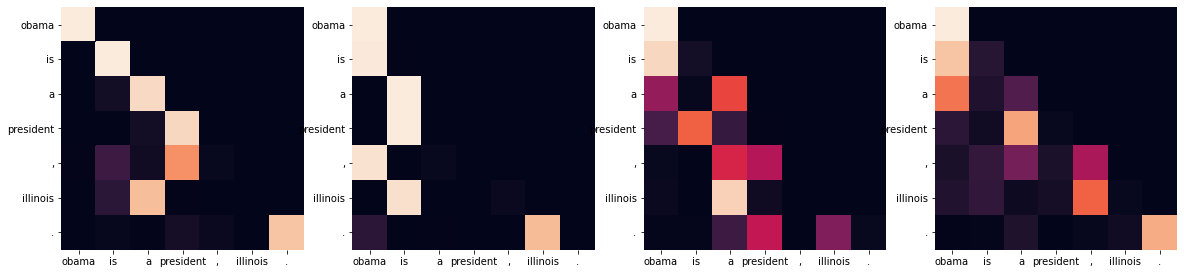

Decoder Src Layer 2


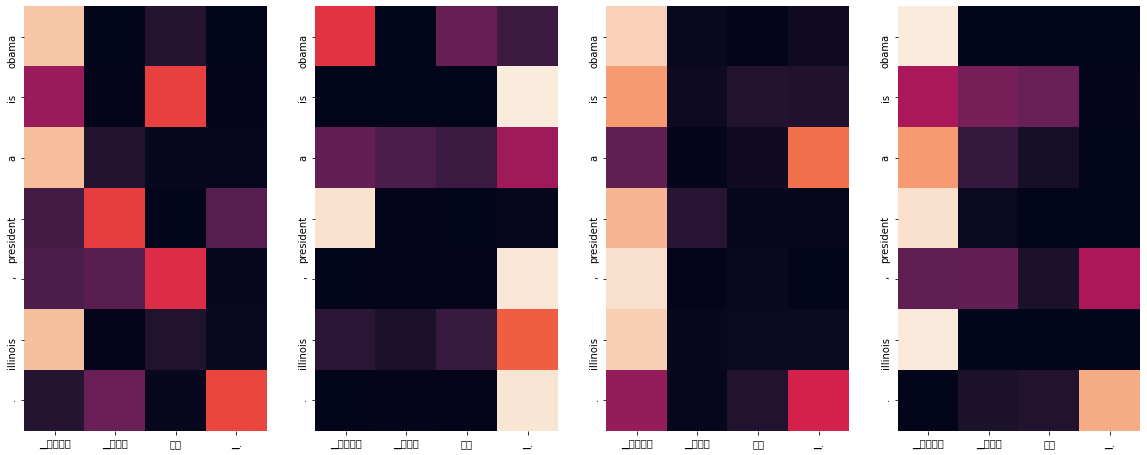

Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city is a city of the city s city of the city .
Encoder Layer 1


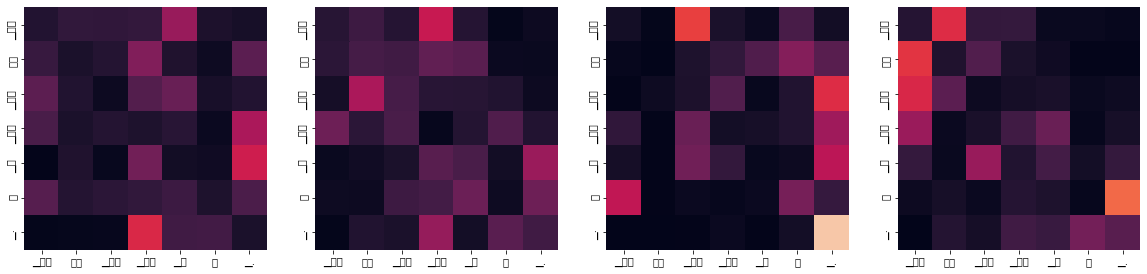

Encoder Layer 2


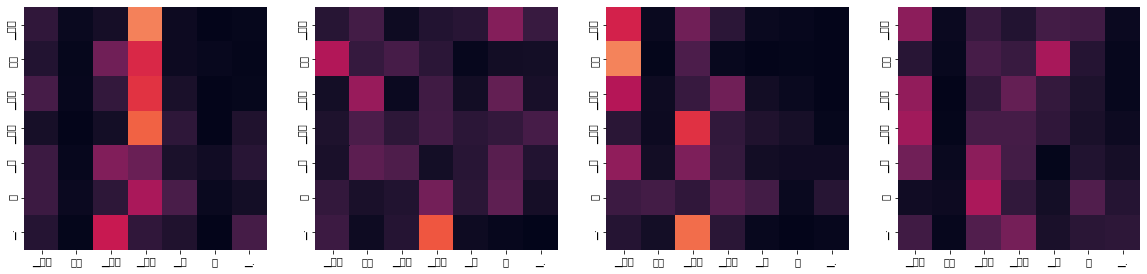

Decoder Self Layer 1


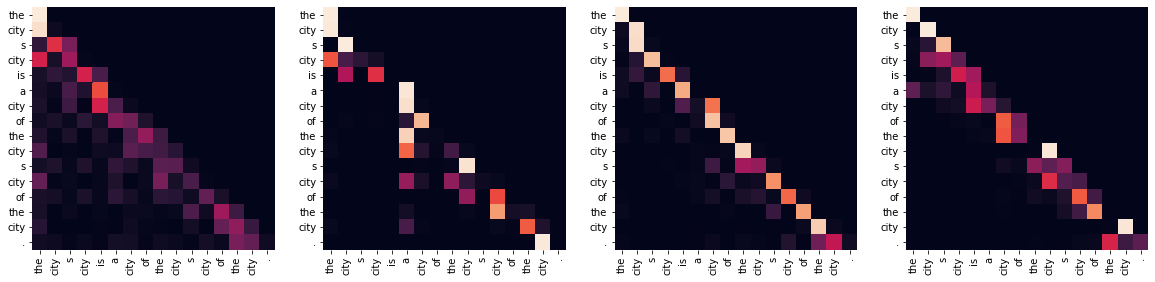

Decoder Src Layer 1


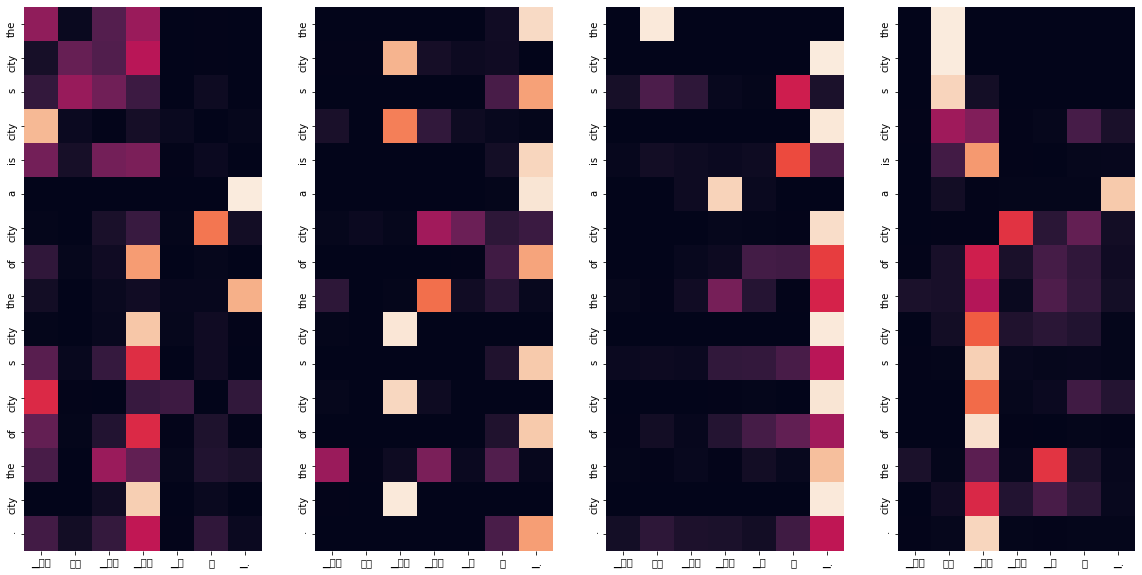

Decoder Self Layer 2


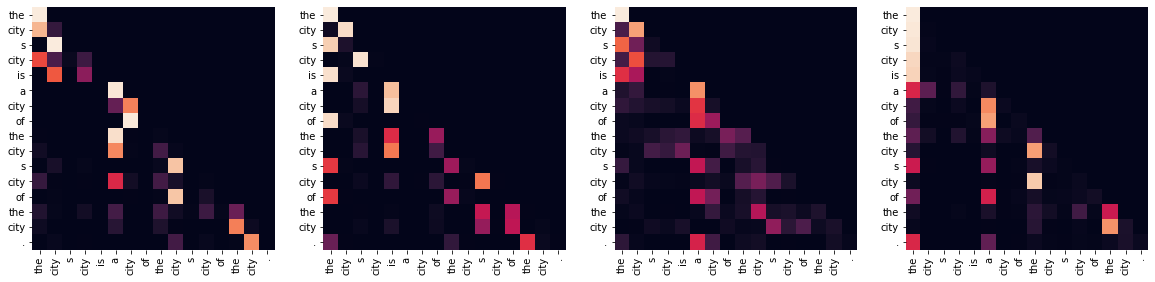

Decoder Src Layer 2


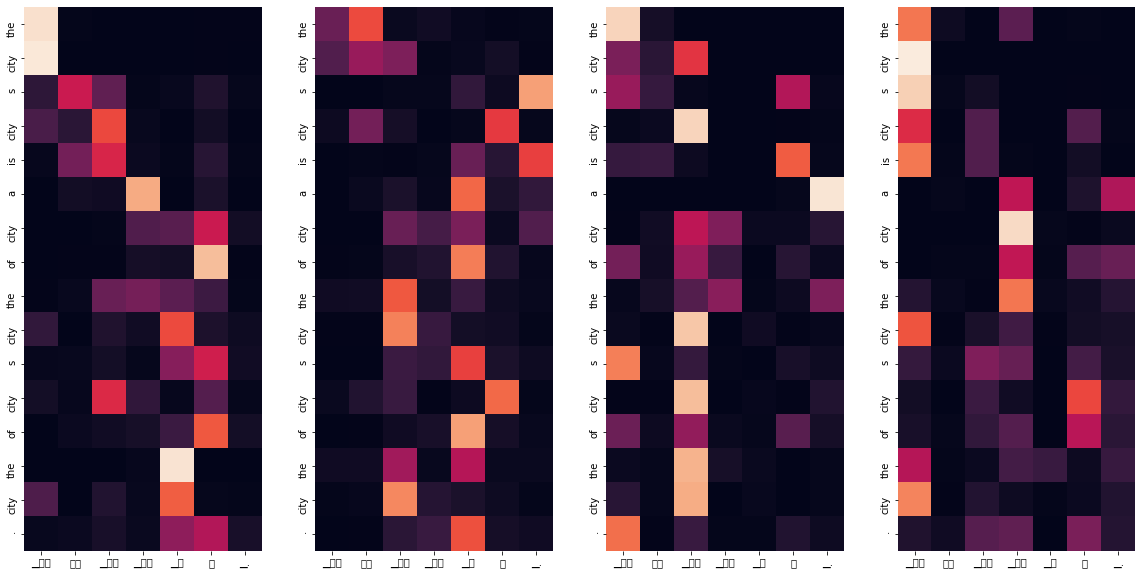

Input: 커피는 필요 없다.
Predicted translation: no need for a cautious .
Encoder Layer 1


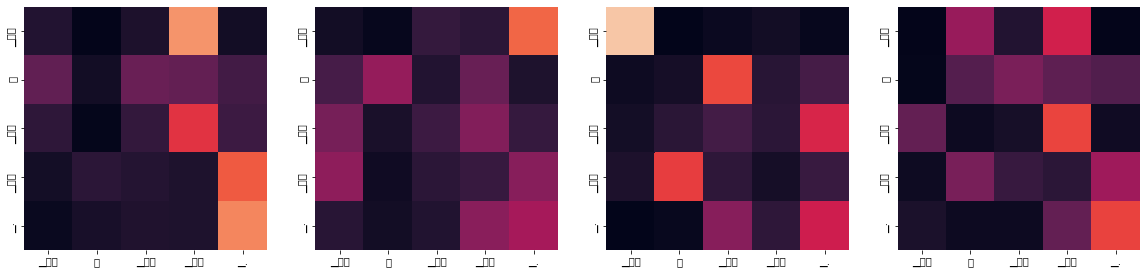

Encoder Layer 2


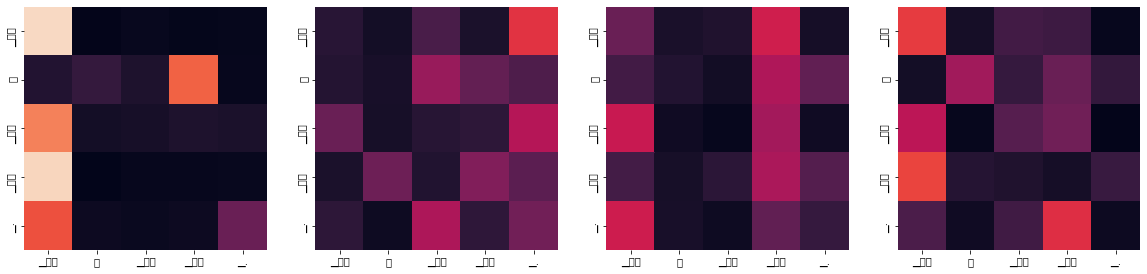

Decoder Self Layer 1


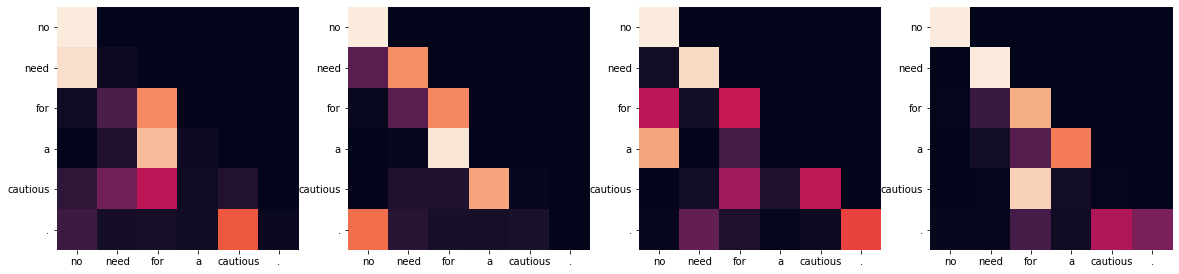

Decoder Src Layer 1


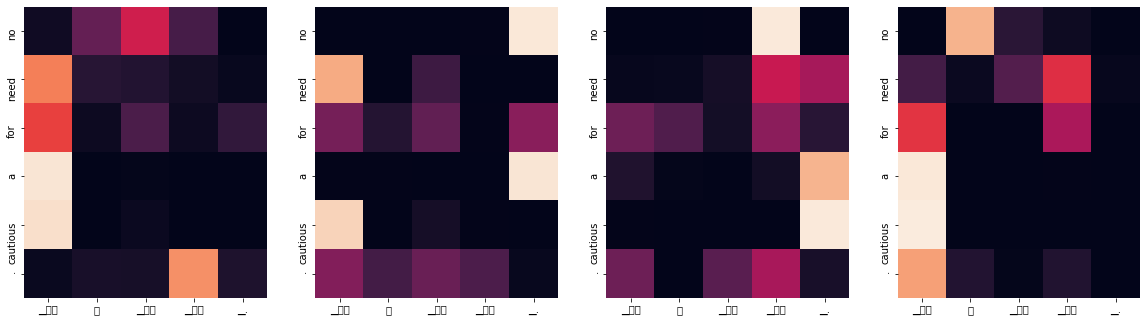

Decoder Self Layer 2


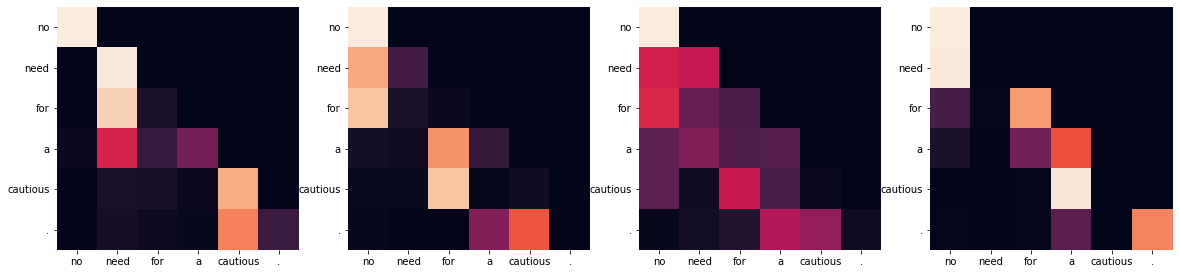

Decoder Src Layer 2


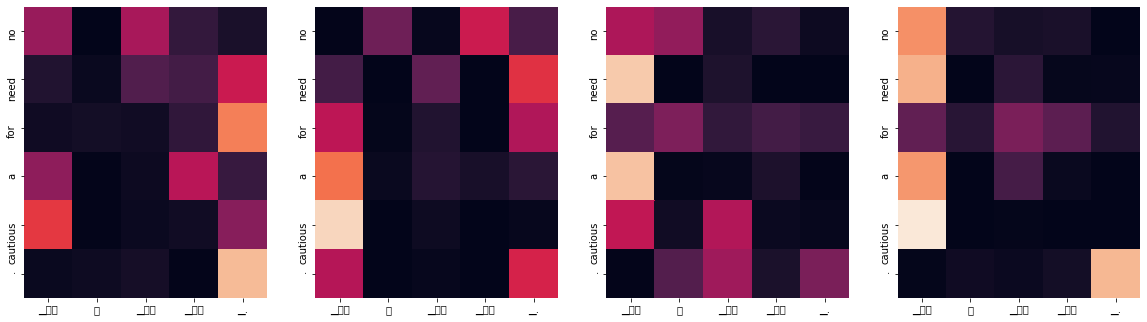

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven seven deaths were in seven deaths .
Encoder Layer 1


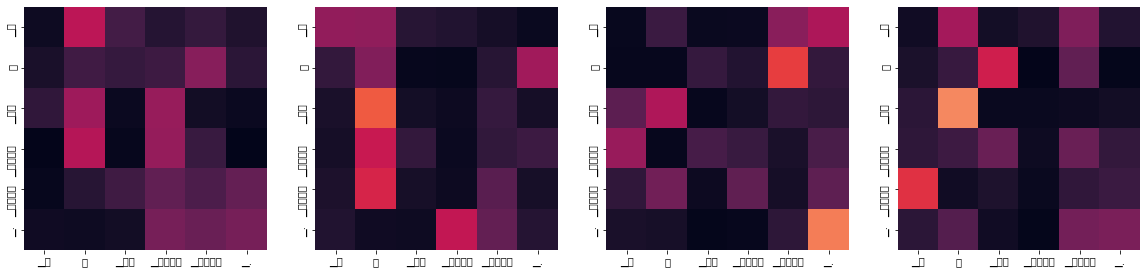

Encoder Layer 2


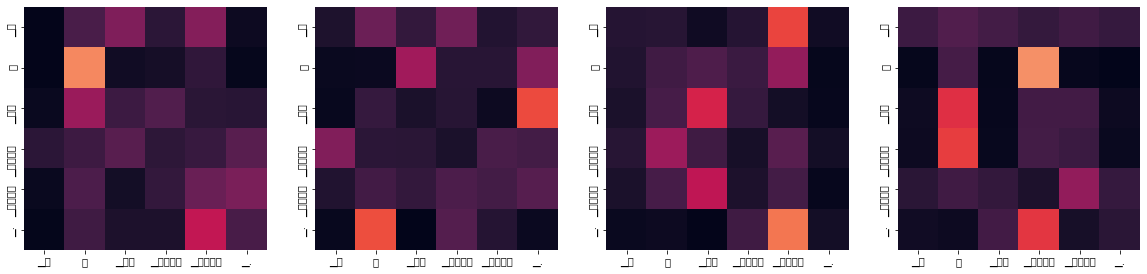

Decoder Self Layer 1


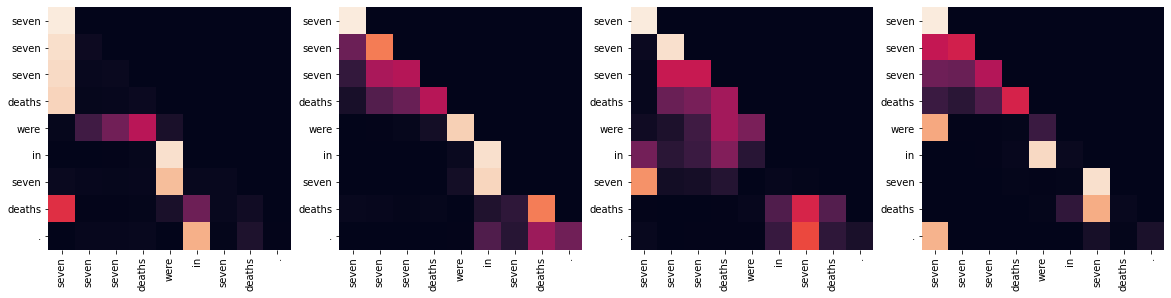

Decoder Src Layer 1


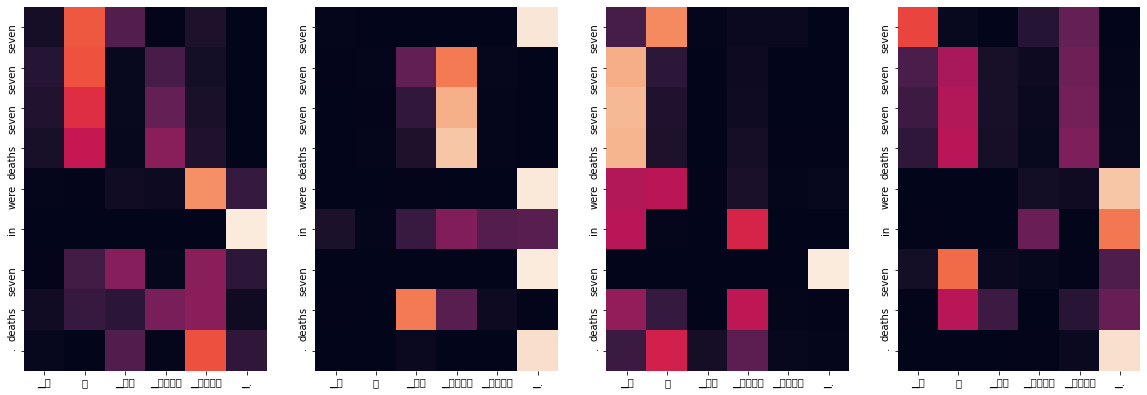

Decoder Self Layer 2


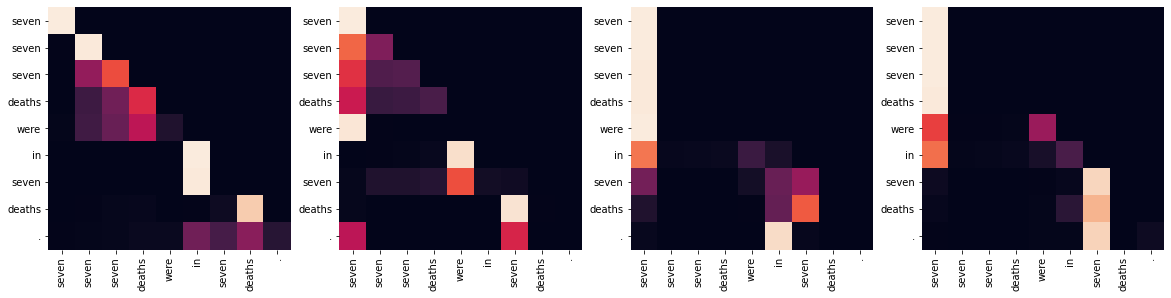

Decoder Src Layer 2


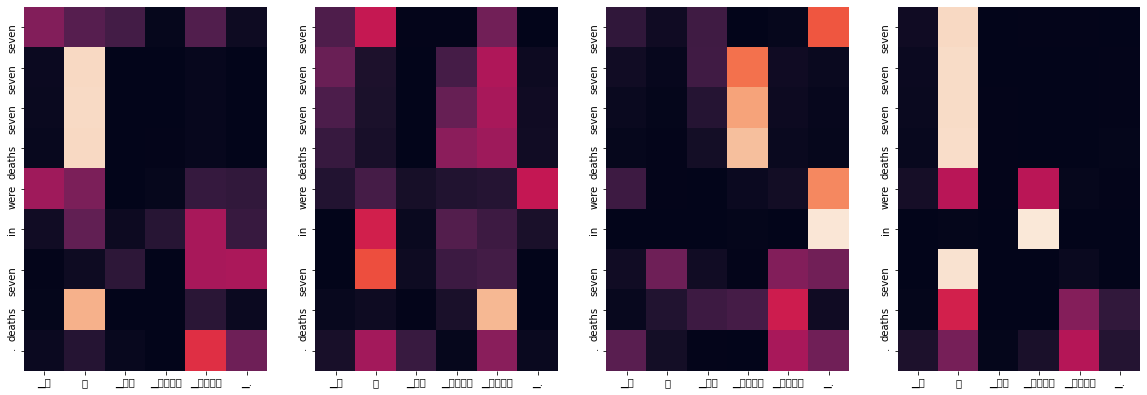

  0%|          | 0/909 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama .
Encoder Layer 1


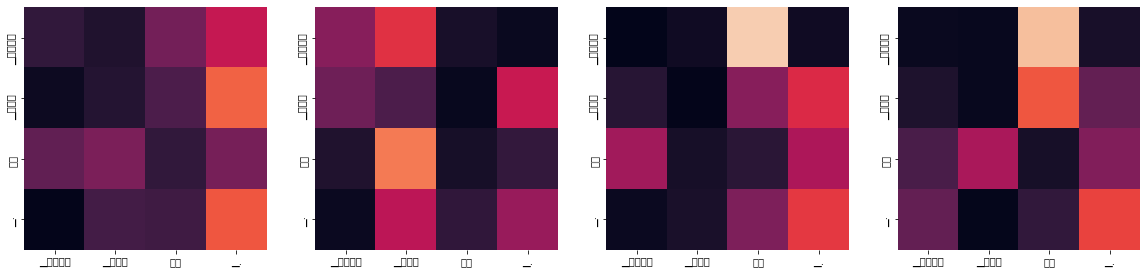

Encoder Layer 2


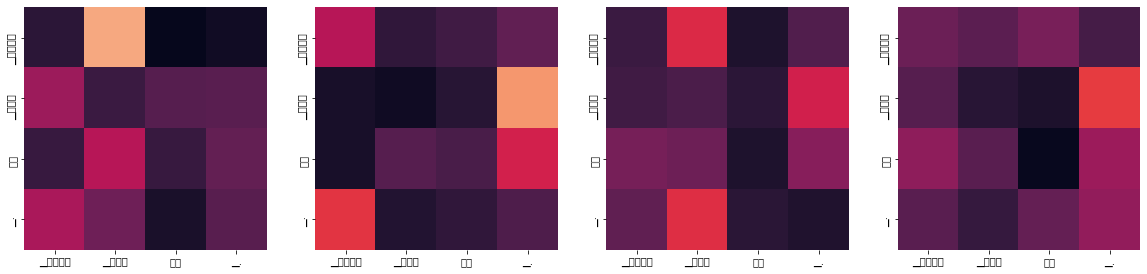

Decoder Self Layer 1


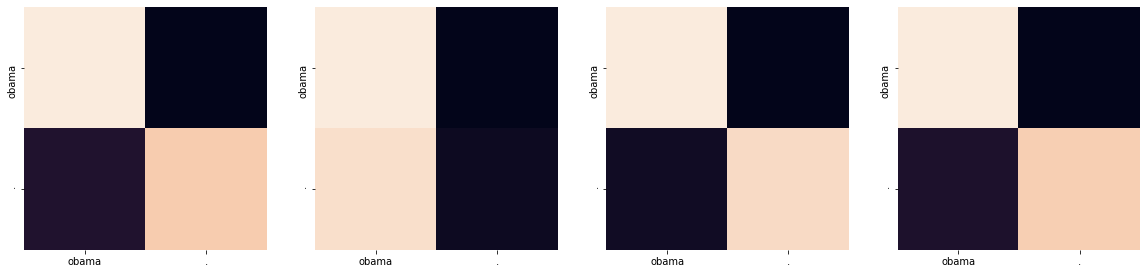

Decoder Src Layer 1


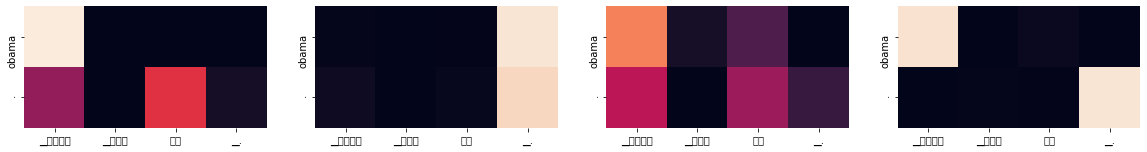

Decoder Self Layer 2


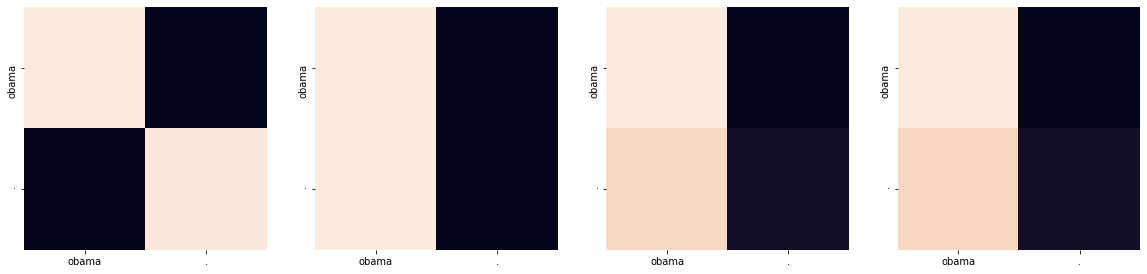

Decoder Src Layer 2


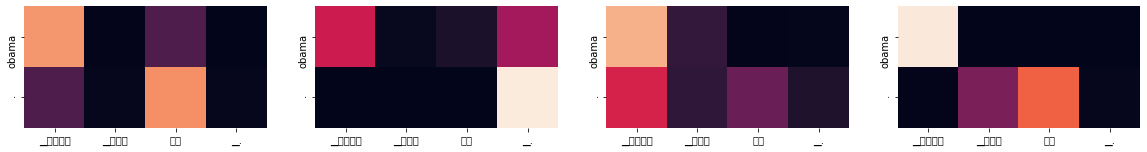

Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the city city city of s city is located in the city .
Encoder Layer 1


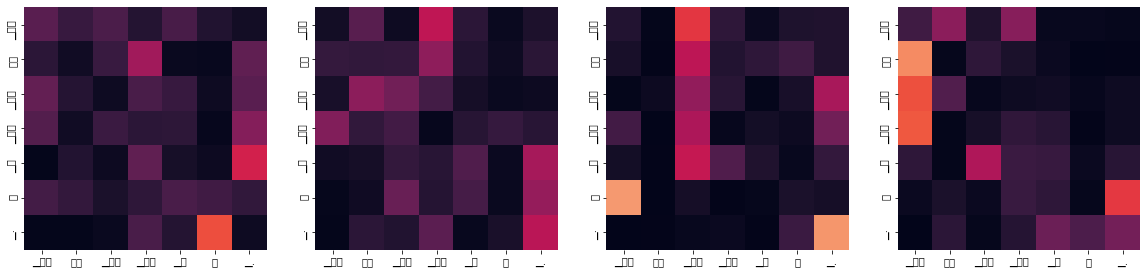

Encoder Layer 2


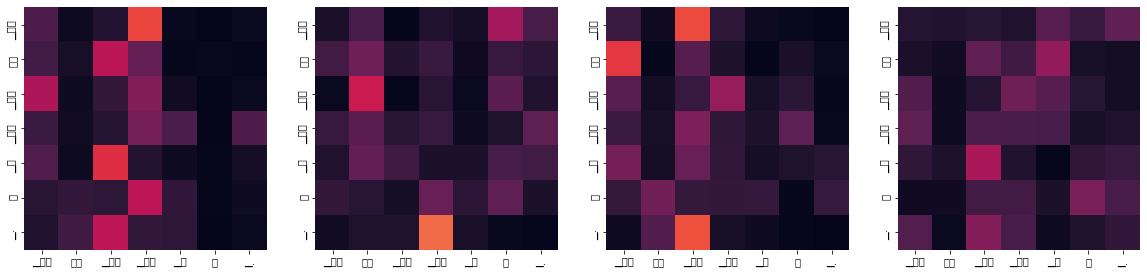

Decoder Self Layer 1


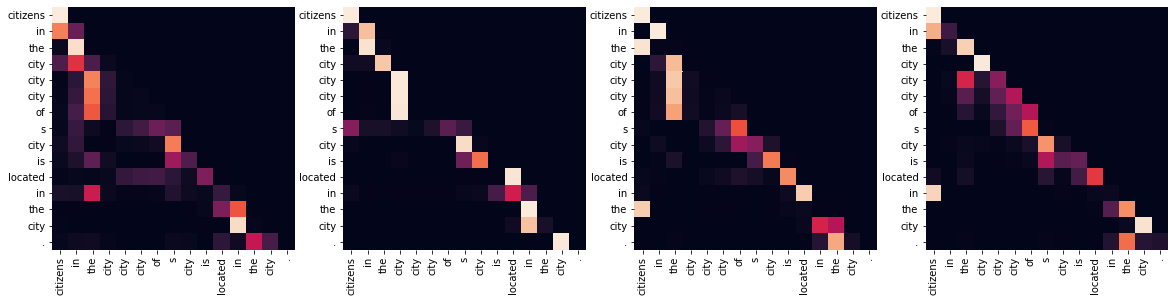

Decoder Src Layer 1


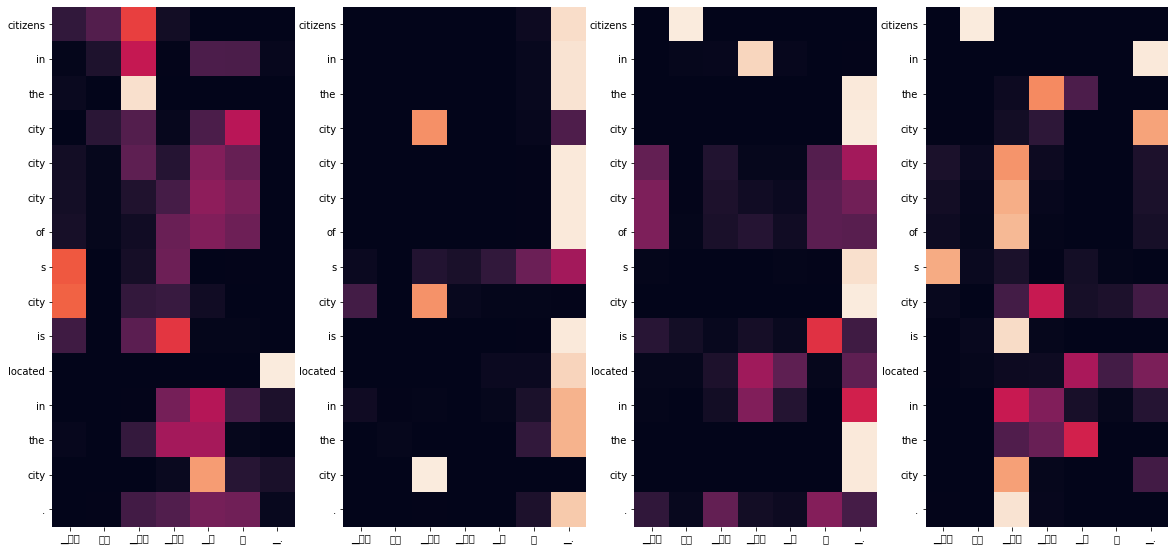

Decoder Self Layer 2


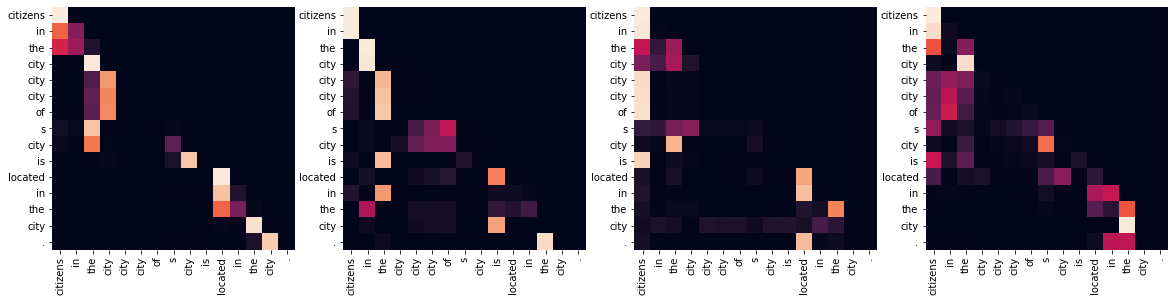

Decoder Src Layer 2


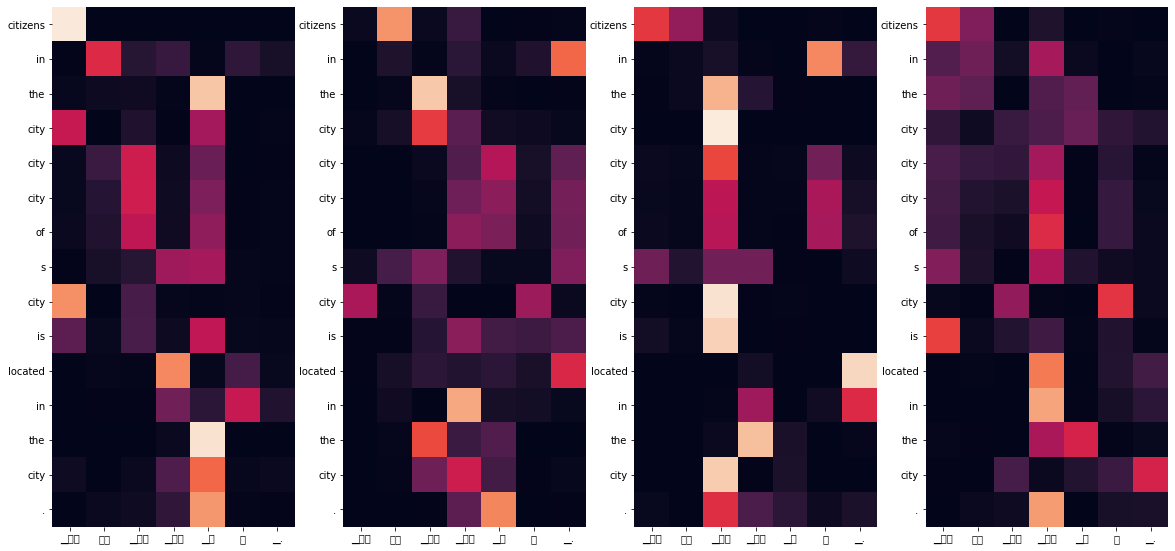

Input: 커피는 필요 없다.
Predicted translation: coffee is no substation .
Encoder Layer 1


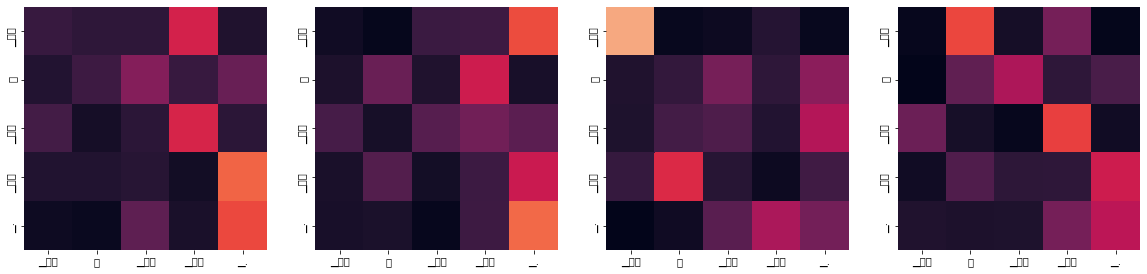

Encoder Layer 2


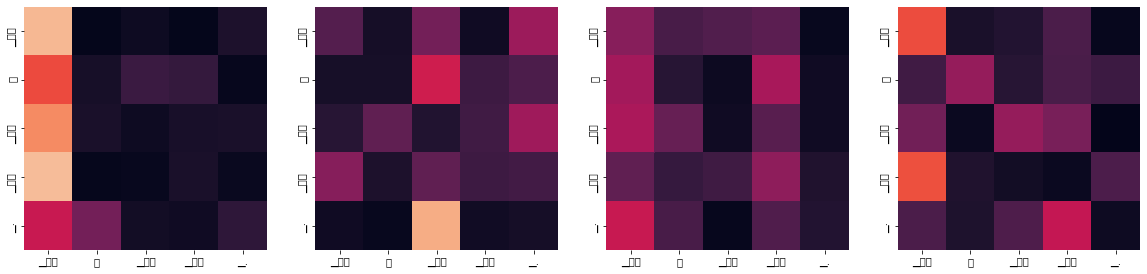

Decoder Self Layer 1


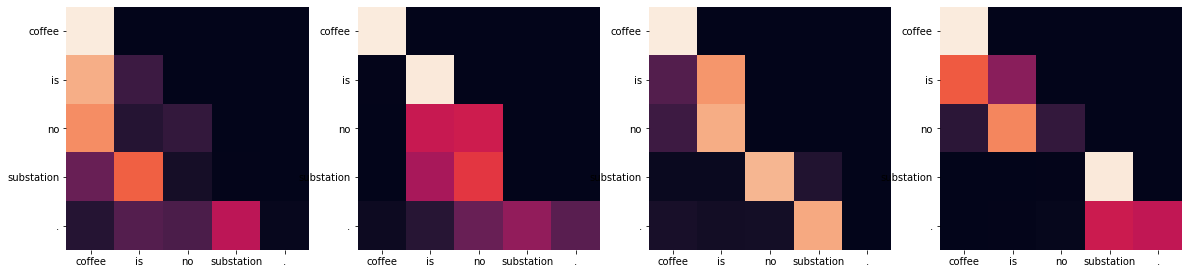

Decoder Src Layer 1


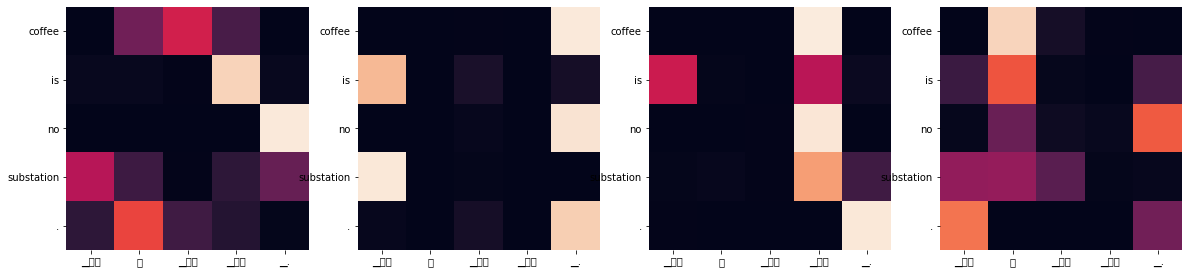

Decoder Self Layer 2


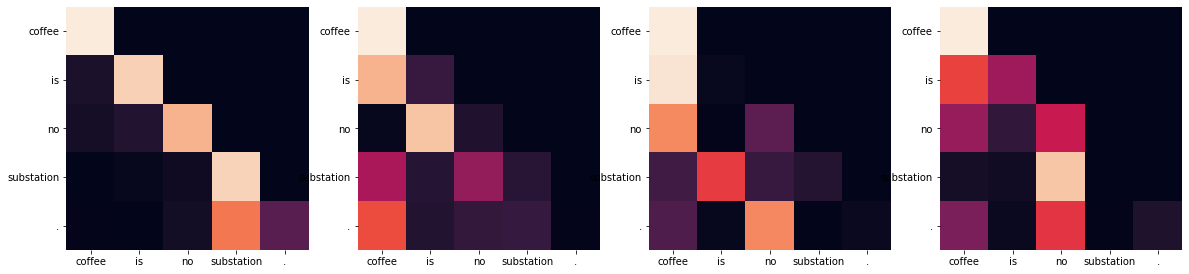

Decoder Src Layer 2


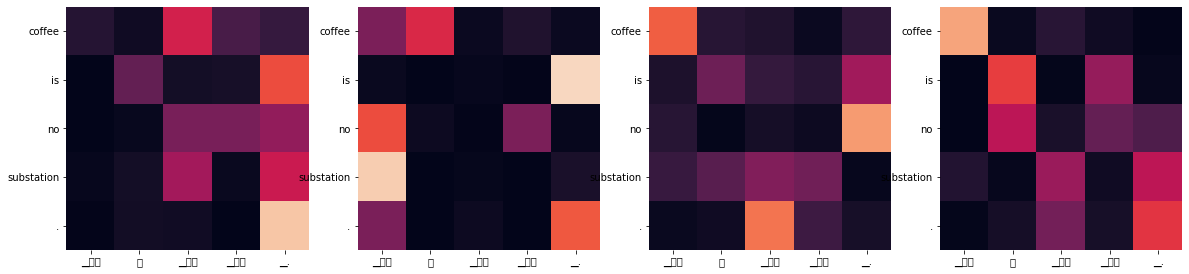

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the raid .
Encoder Layer 1


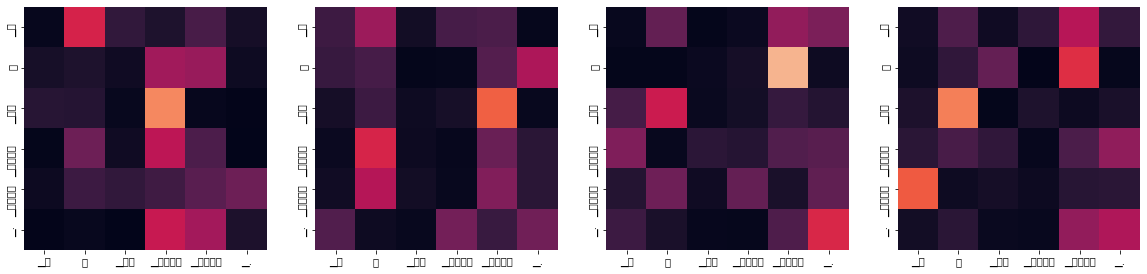

Encoder Layer 2


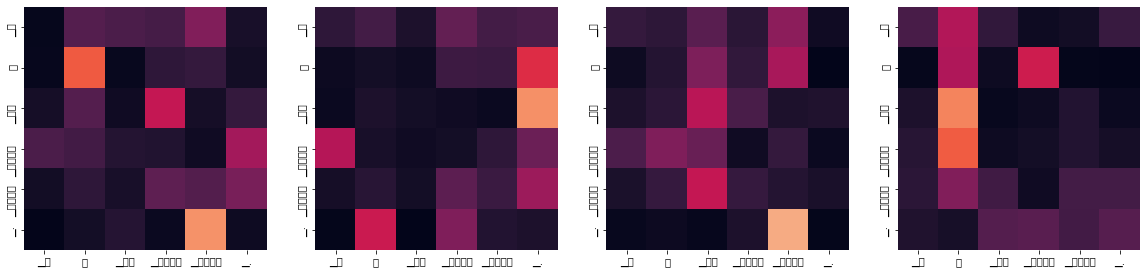

Decoder Self Layer 1


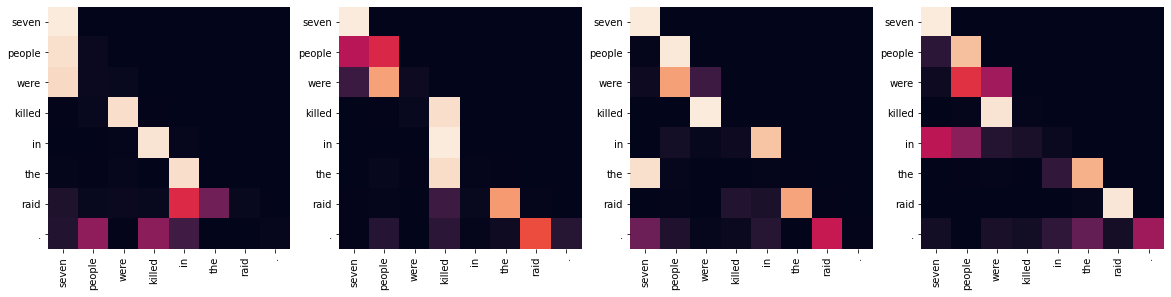

Decoder Src Layer 1


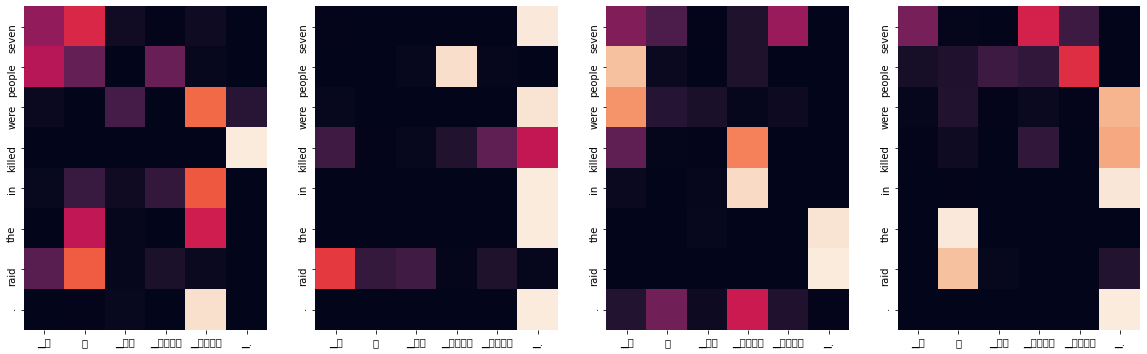

Decoder Self Layer 2


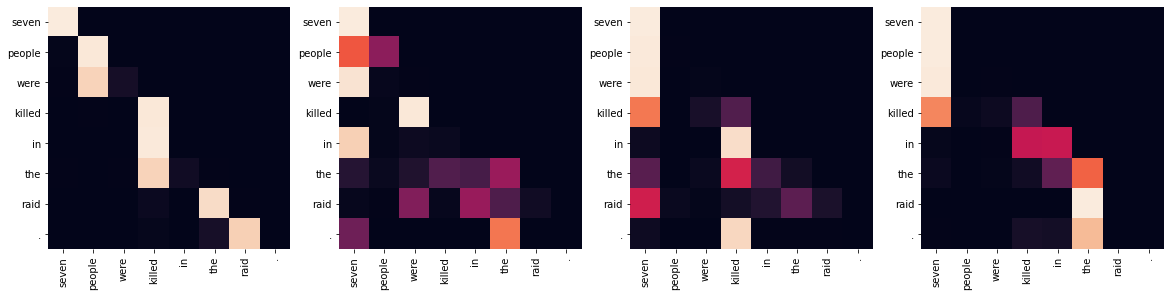

Decoder Src Layer 2


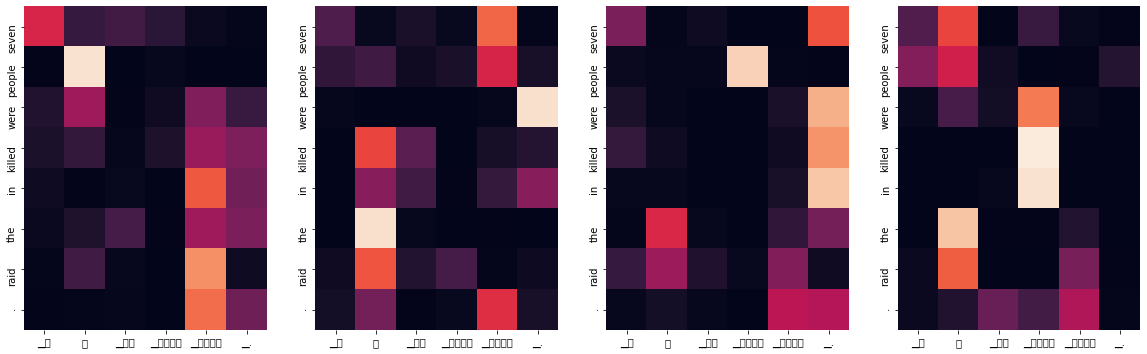

  0%|          | 0/909 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama .
Encoder Layer 1


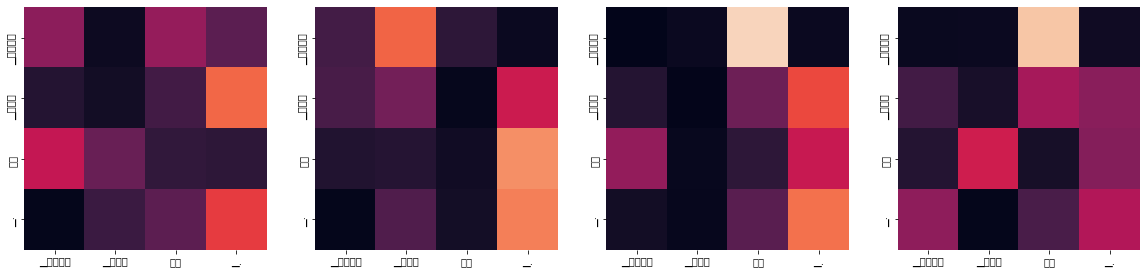

Encoder Layer 2


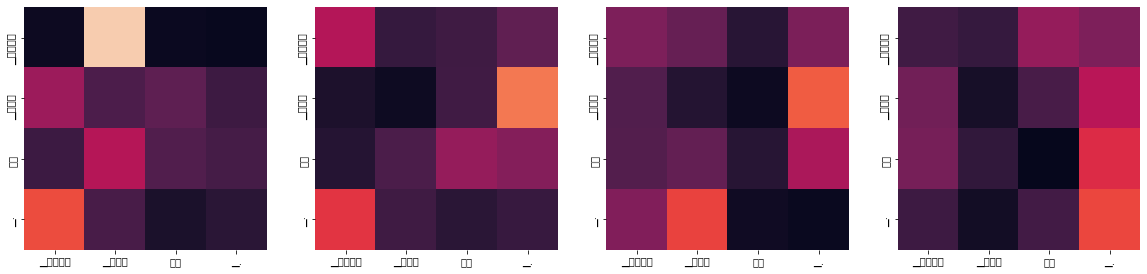

Decoder Self Layer 1


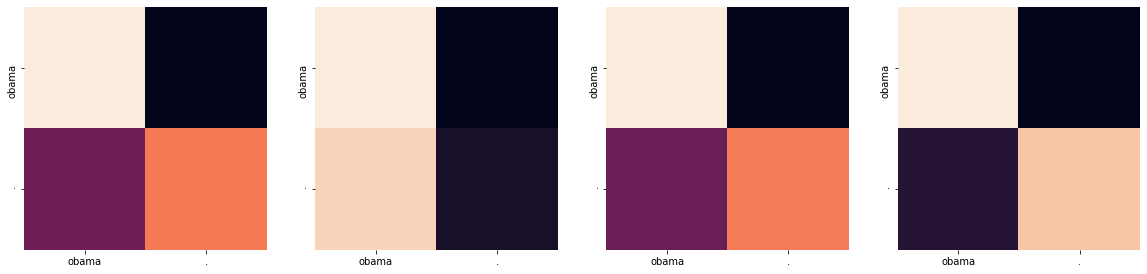

Decoder Src Layer 1


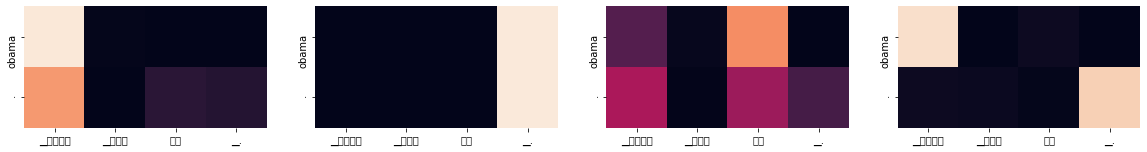

Decoder Self Layer 2


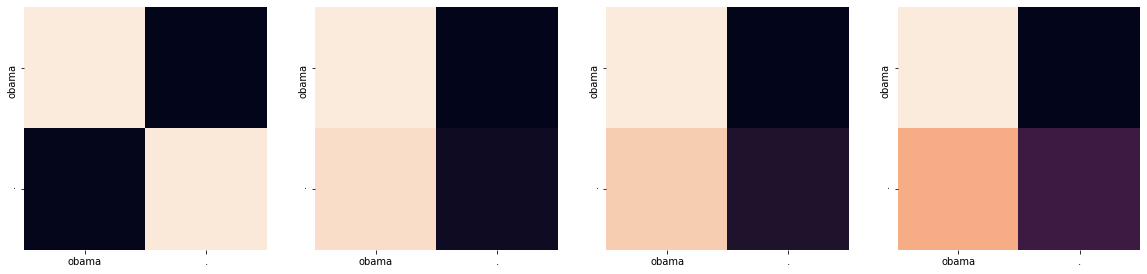

Decoder Src Layer 2


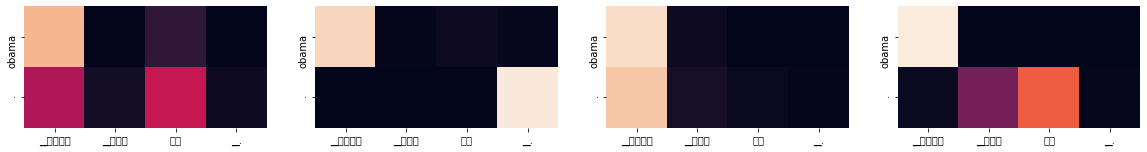

Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are among the cities of the city s city .
Encoder Layer 1


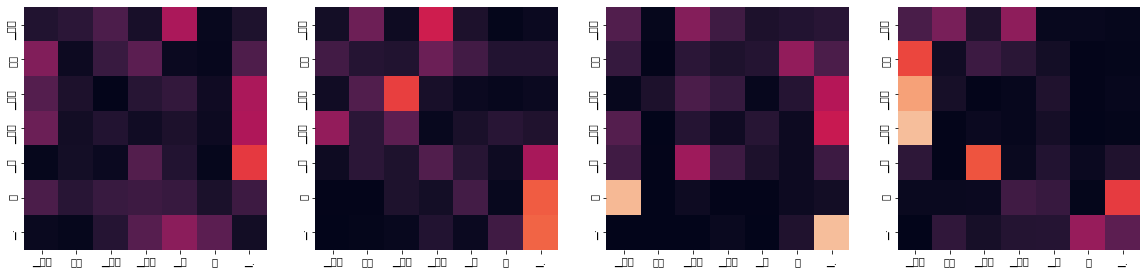

Encoder Layer 2


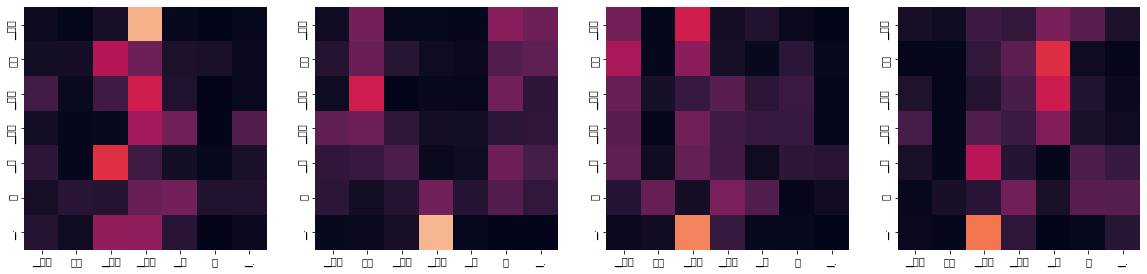

Decoder Self Layer 1


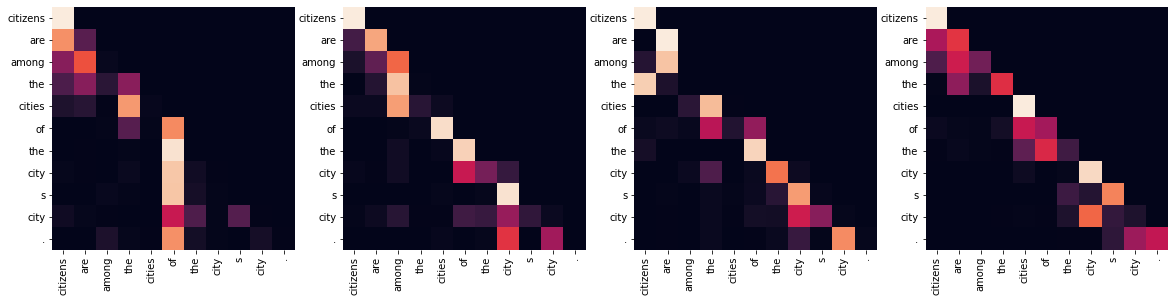

Decoder Src Layer 1


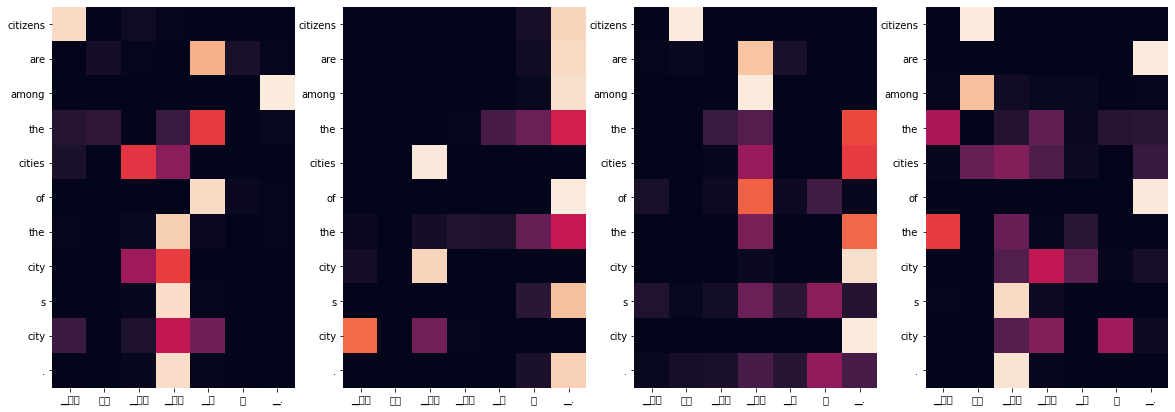

Decoder Self Layer 2


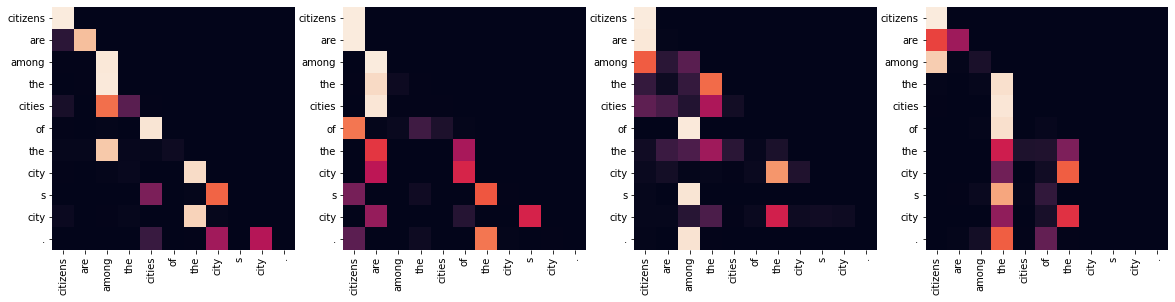

Decoder Src Layer 2


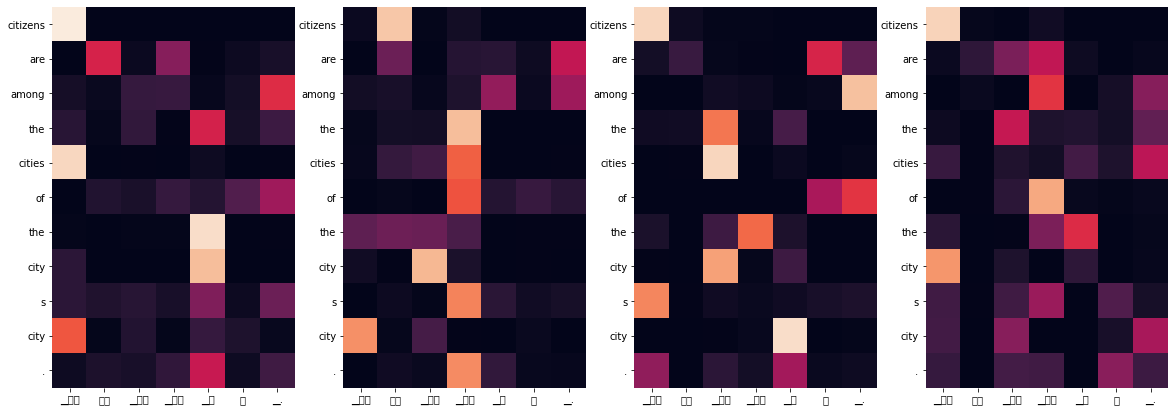

Input: 커피는 필요 없다.
Predicted translation: don t need a coffee one .
Encoder Layer 1


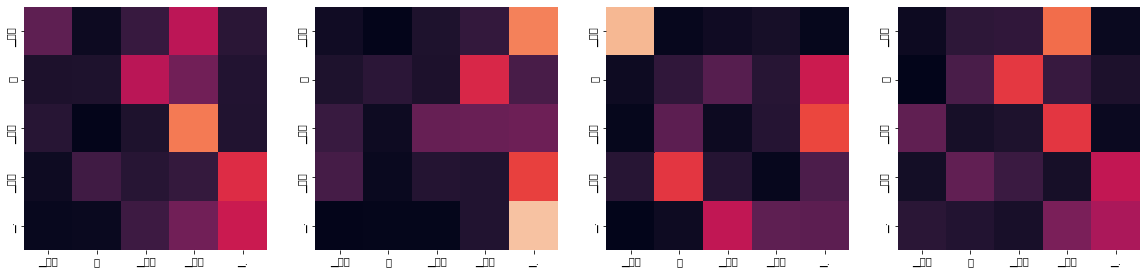

Encoder Layer 2


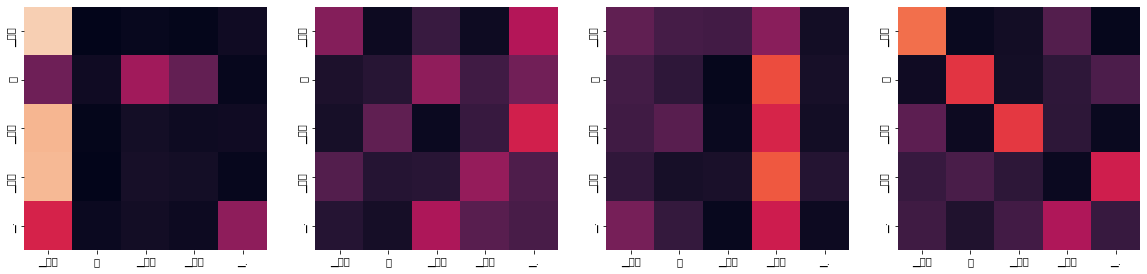

Decoder Self Layer 1


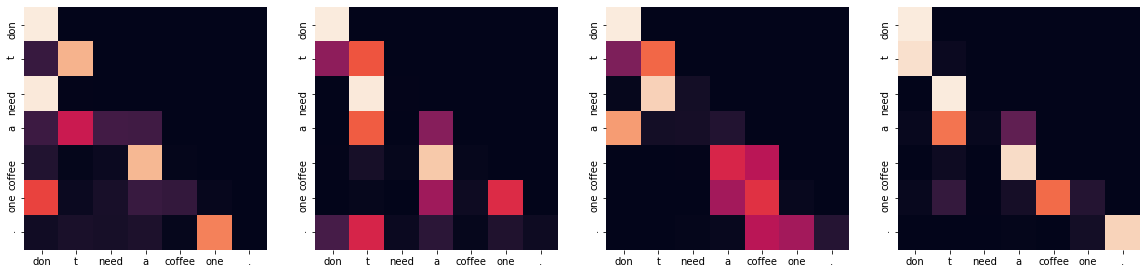

Decoder Src Layer 1


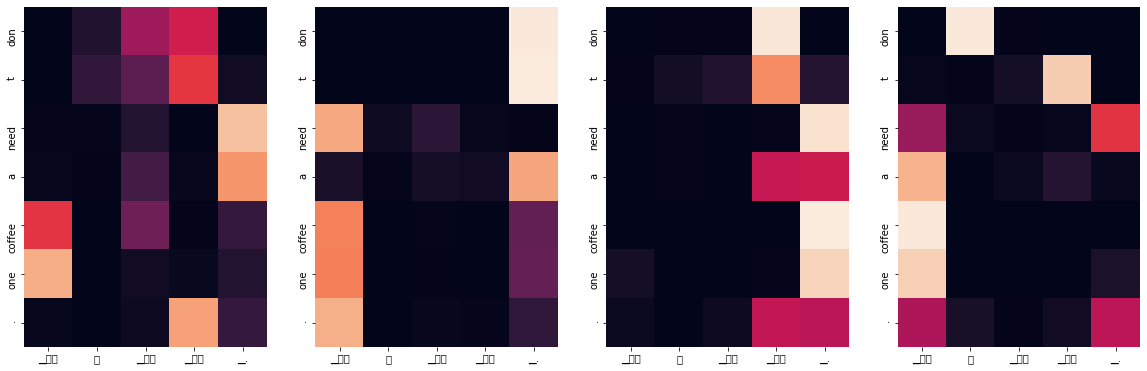

Decoder Self Layer 2


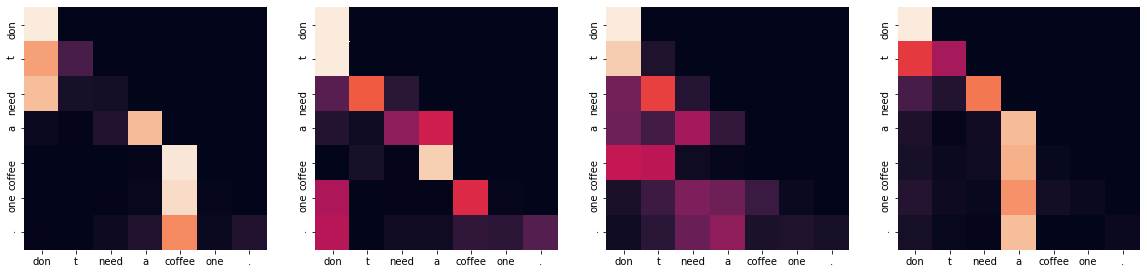

Decoder Src Layer 2


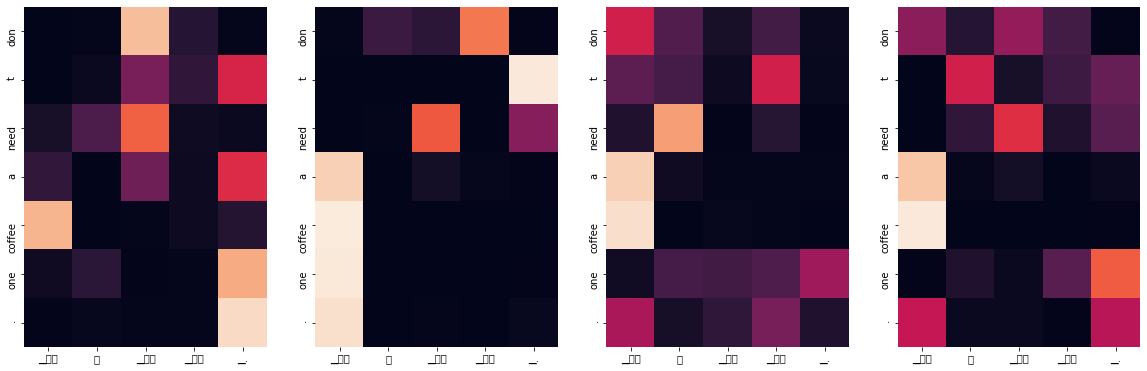

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were among the seven were victims .
Encoder Layer 1


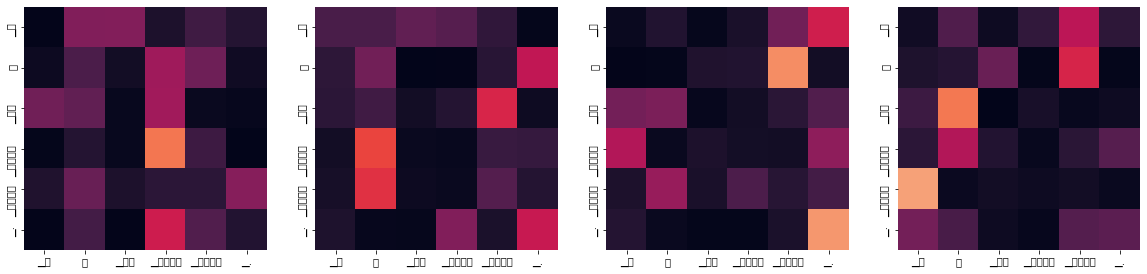

Encoder Layer 2


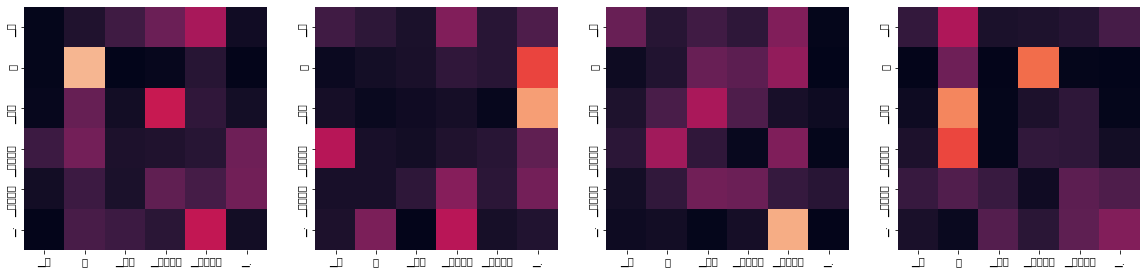

Decoder Self Layer 1


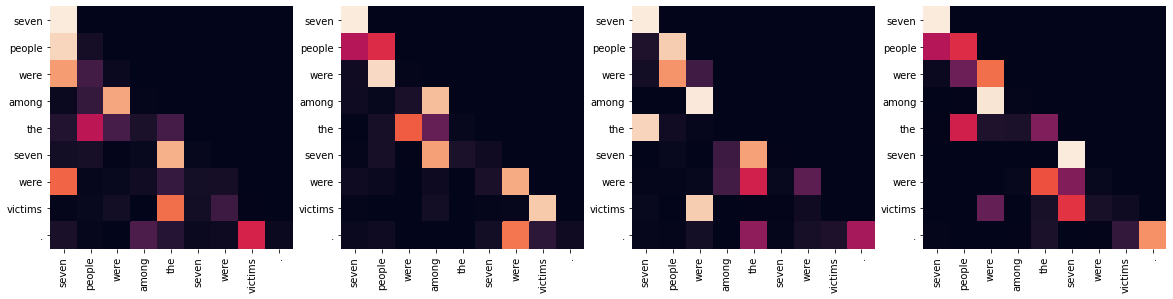

Decoder Src Layer 1


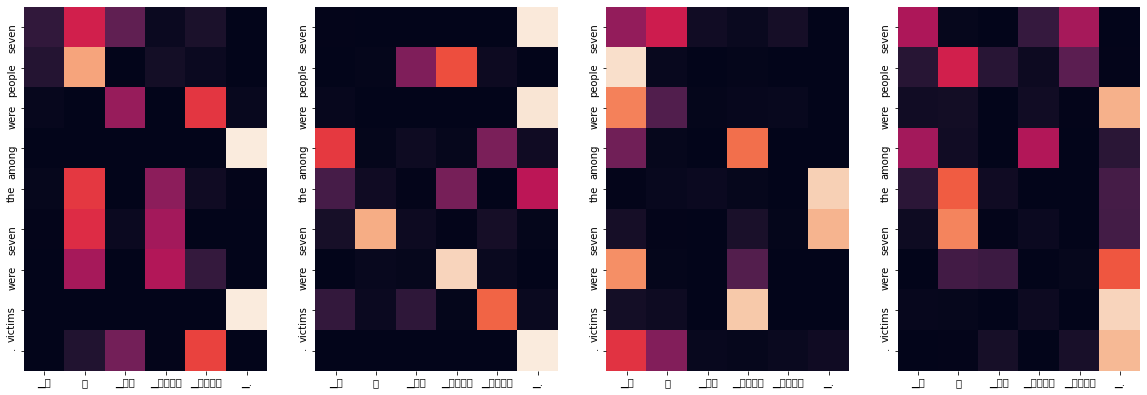

Decoder Self Layer 2


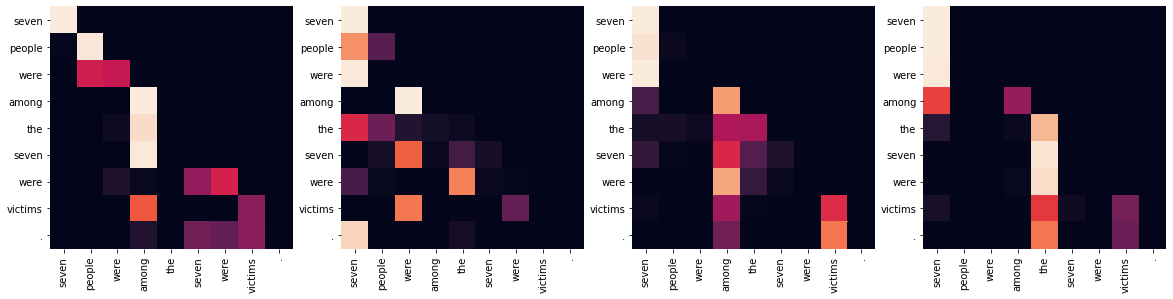

Decoder Src Layer 2


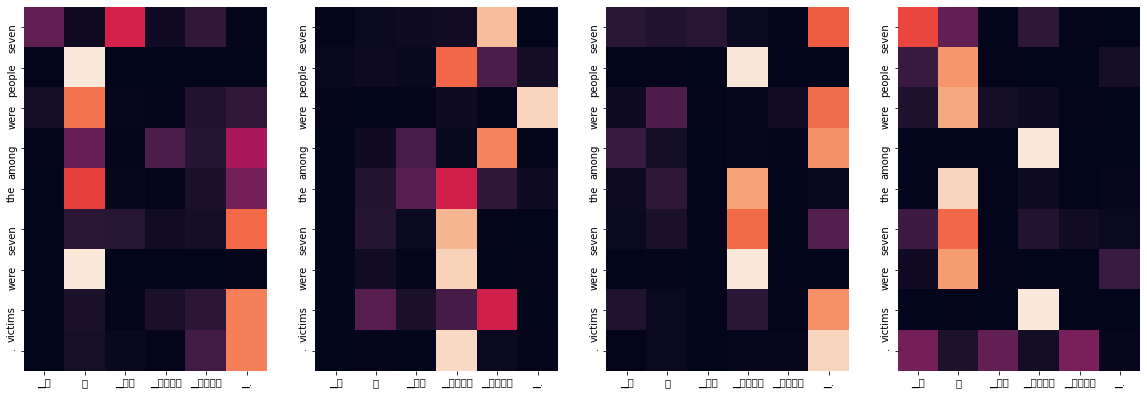

  0%|          | 0/909 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he is a president .
Encoder Layer 1


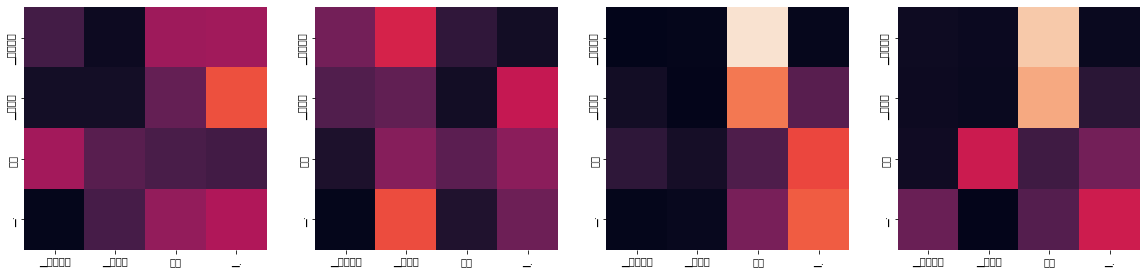

Encoder Layer 2


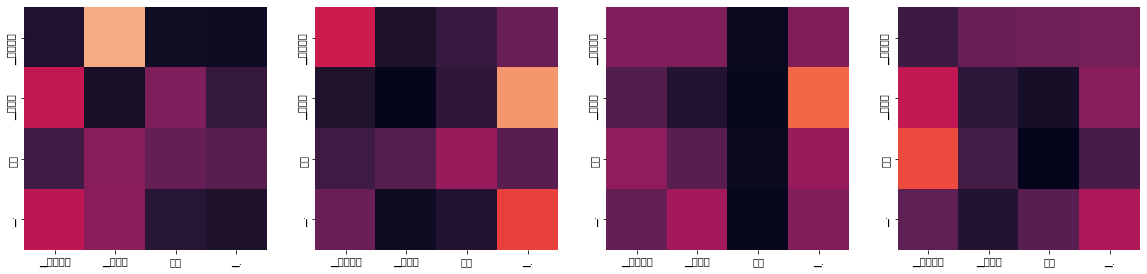

Decoder Self Layer 1


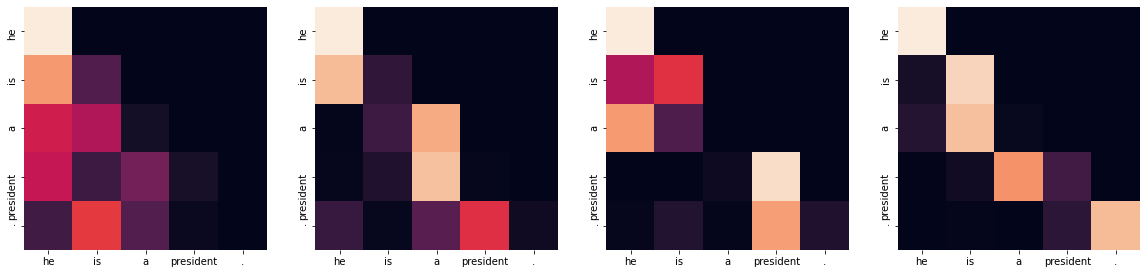

Decoder Src Layer 1


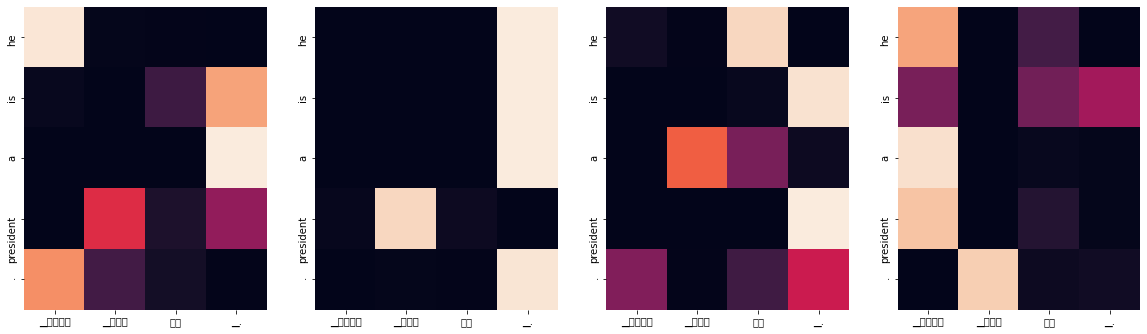

Decoder Self Layer 2


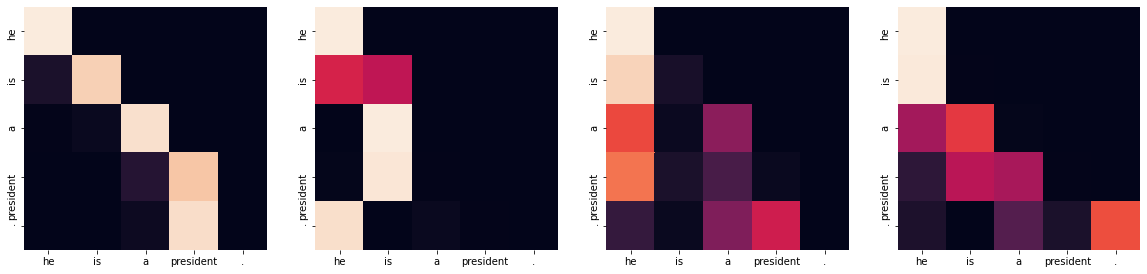

Decoder Src Layer 2


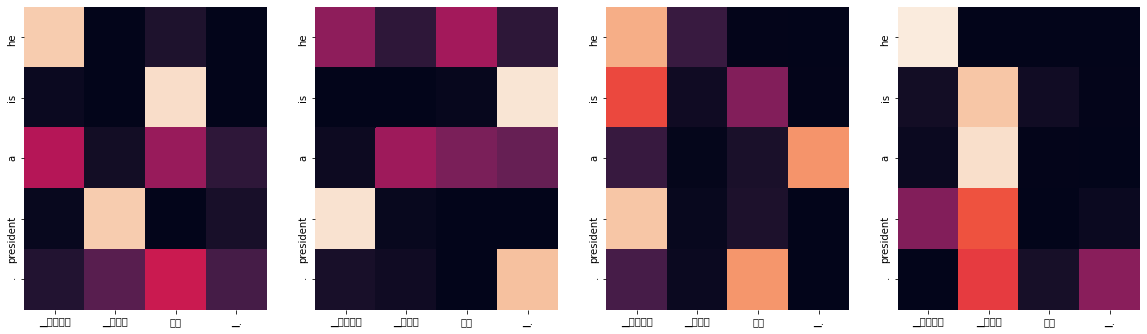

Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in cities are cities in the city .
Encoder Layer 1


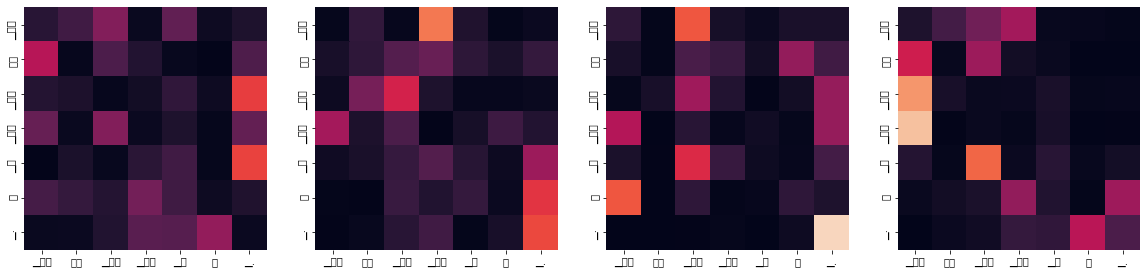

Encoder Layer 2


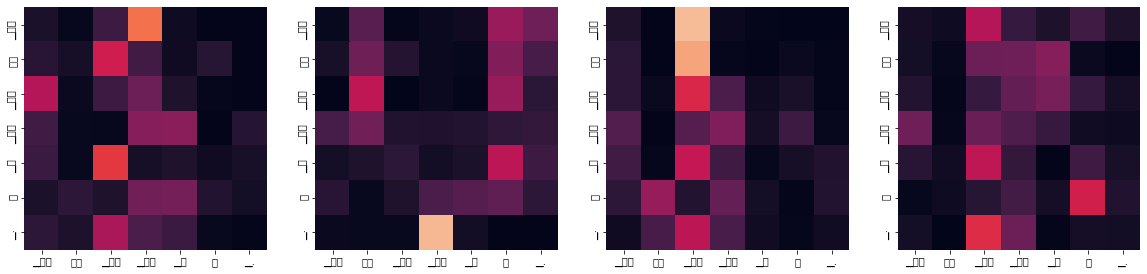

Decoder Self Layer 1


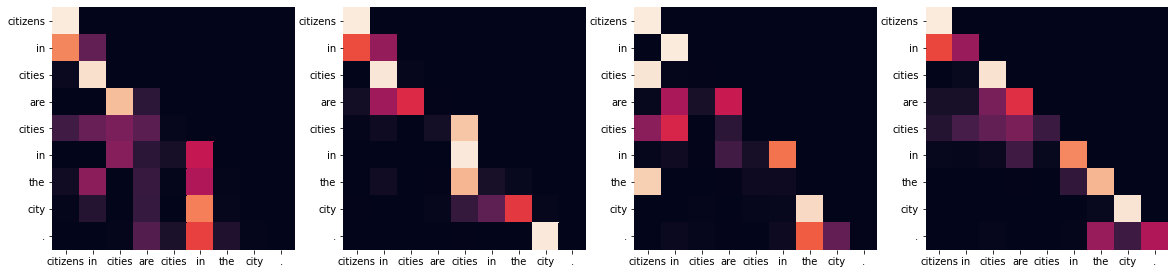

Decoder Src Layer 1


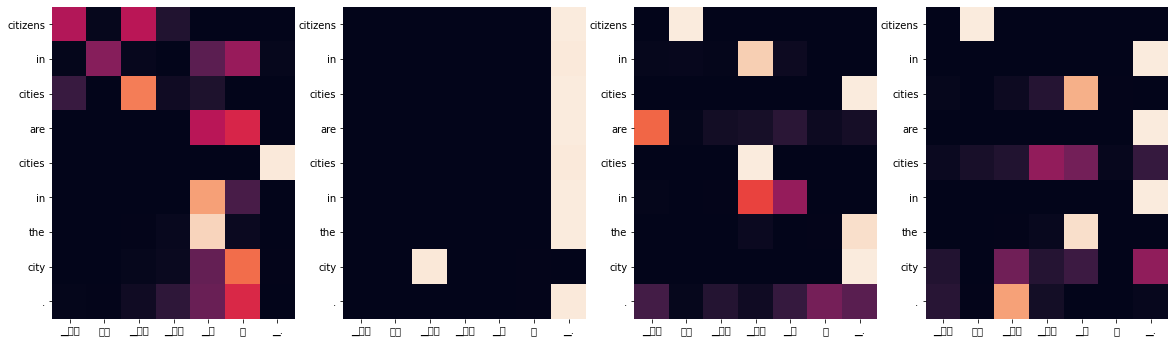

Decoder Self Layer 2


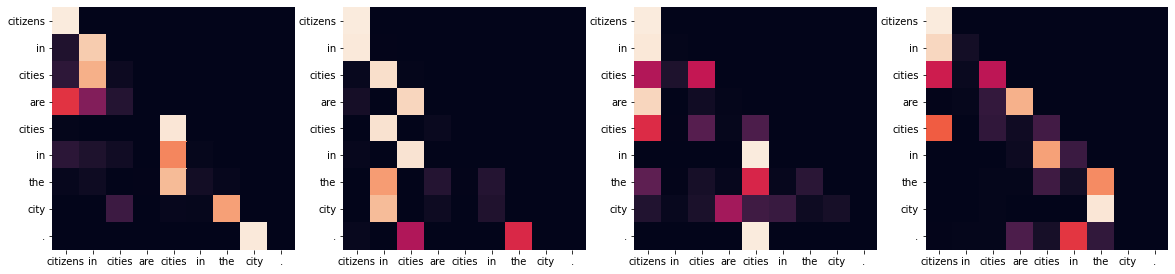

Decoder Src Layer 2


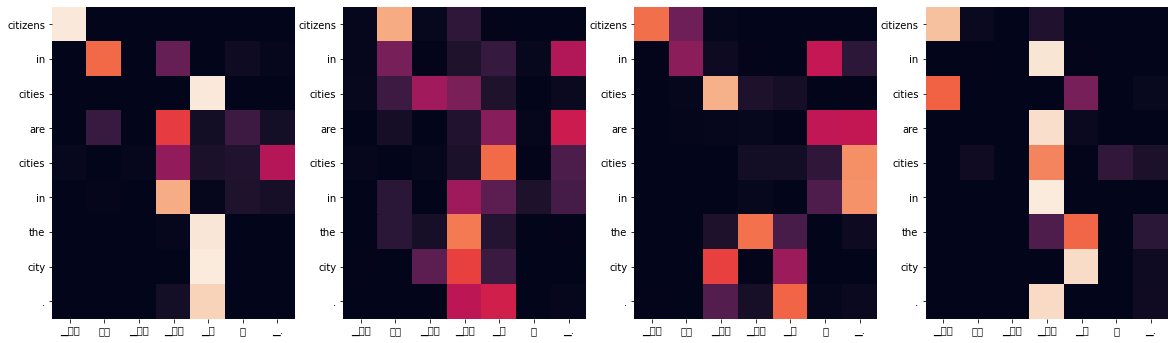

Input: 커피는 필요 없다.
Predicted translation: don t be afraid for coffee .
Encoder Layer 1


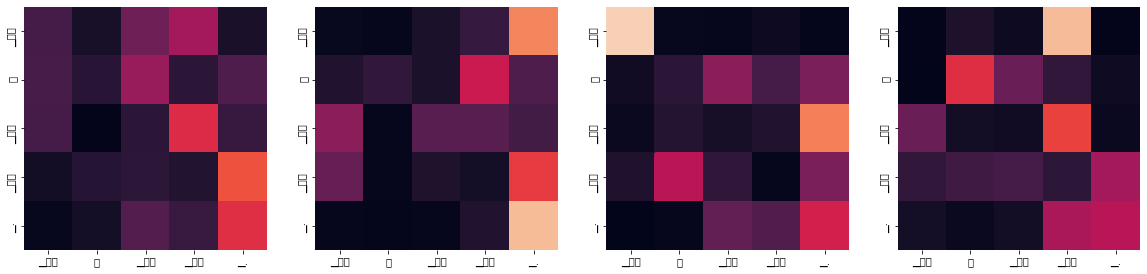

Encoder Layer 2


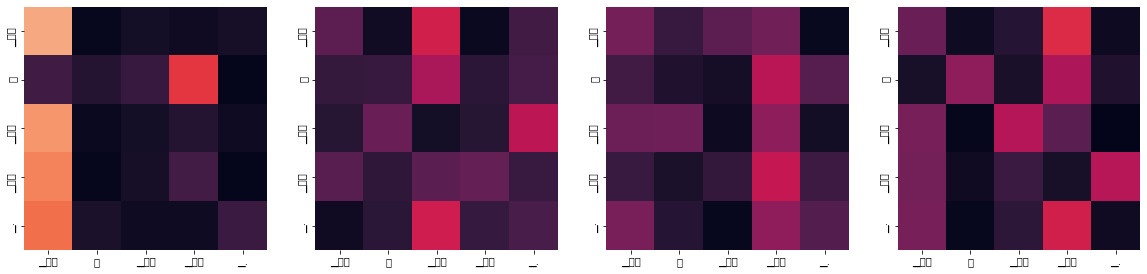

Decoder Self Layer 1


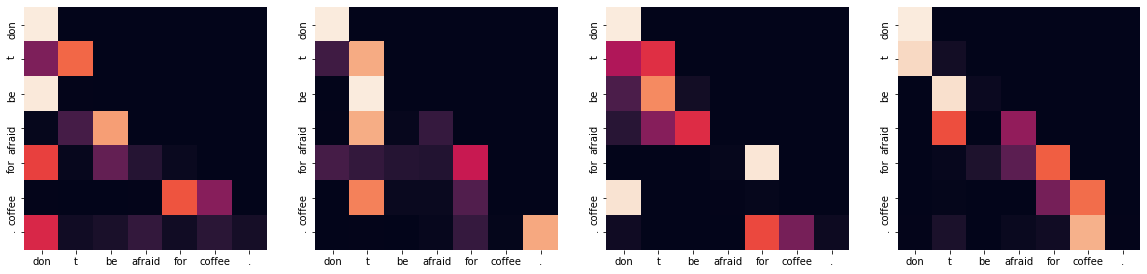

Decoder Src Layer 1


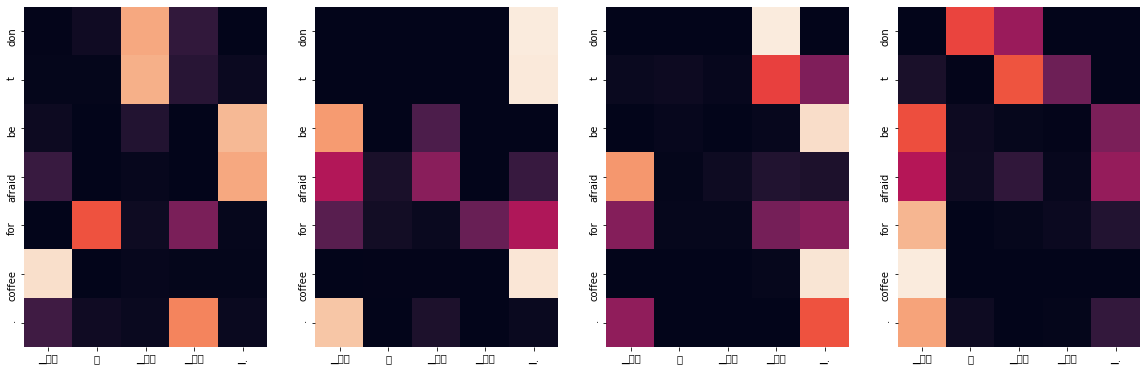

Decoder Self Layer 2


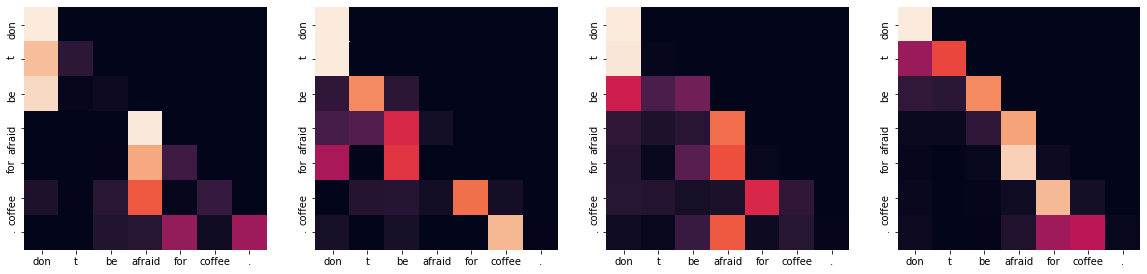

Decoder Src Layer 2


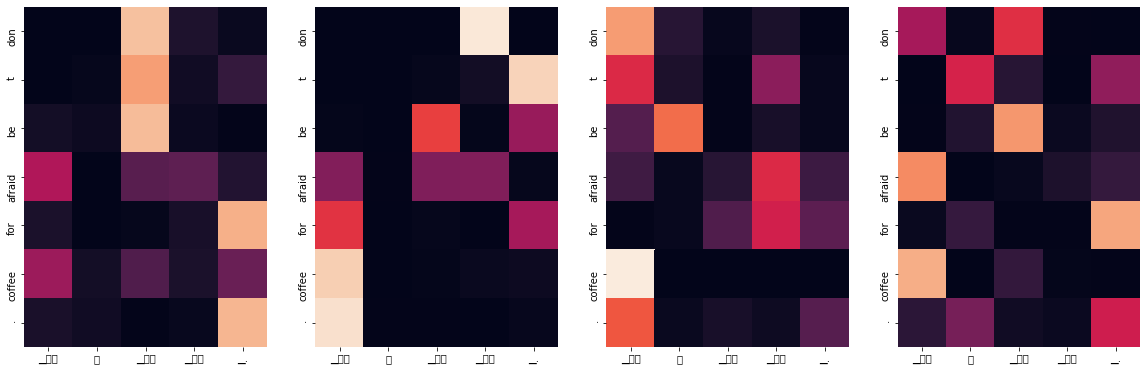

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven were in seven towns .
Encoder Layer 1


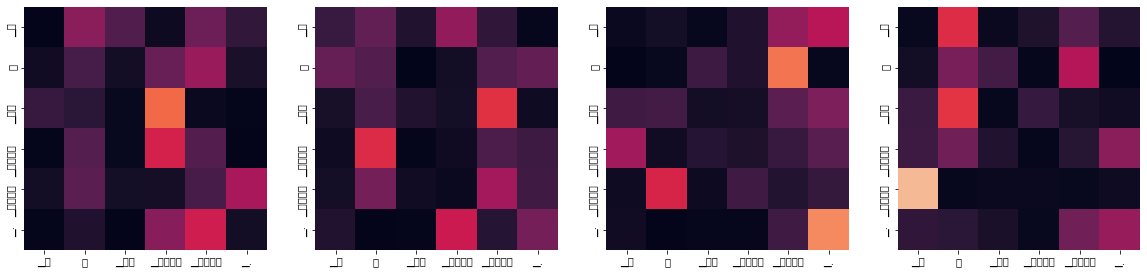

Encoder Layer 2


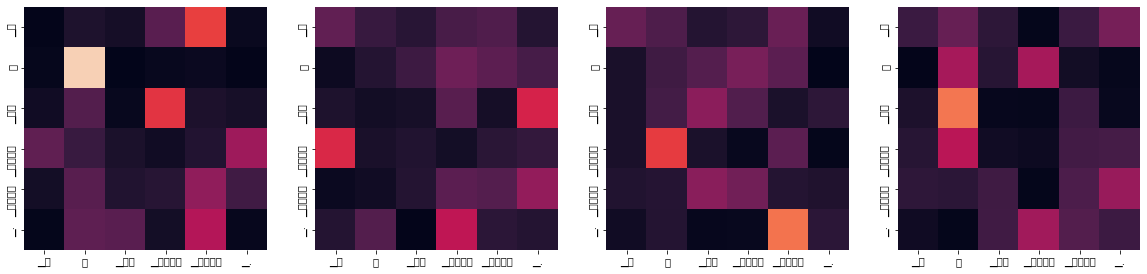

Decoder Self Layer 1


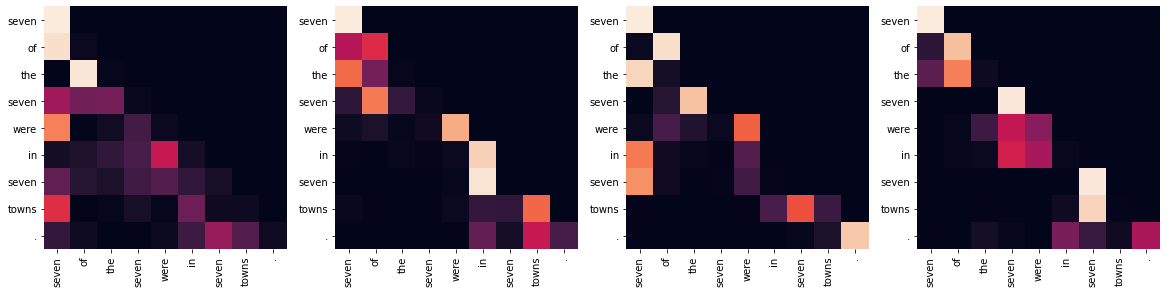

Decoder Src Layer 1


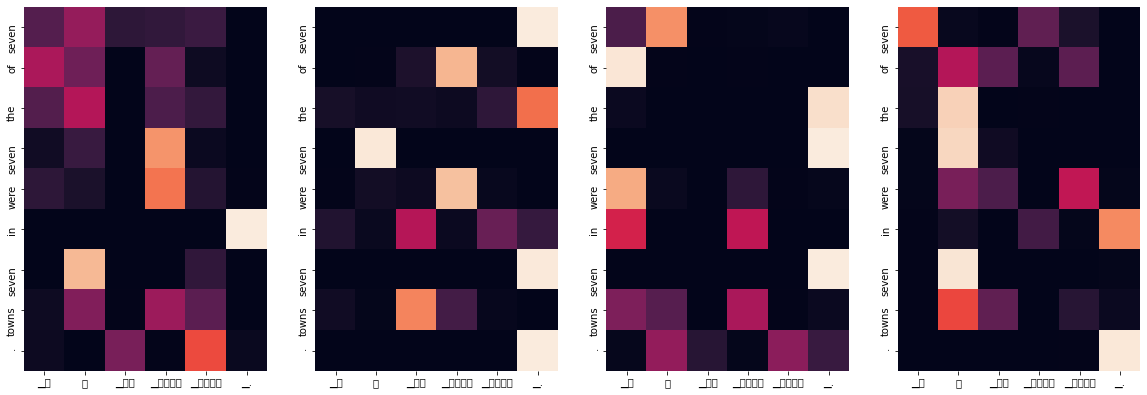

Decoder Self Layer 2


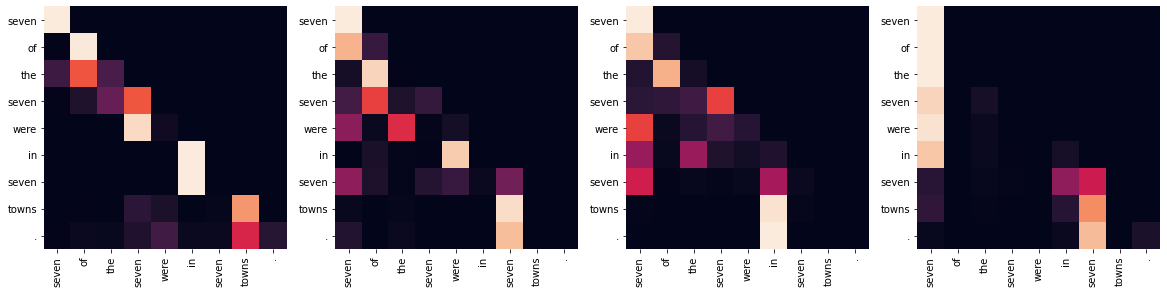

Decoder Src Layer 2


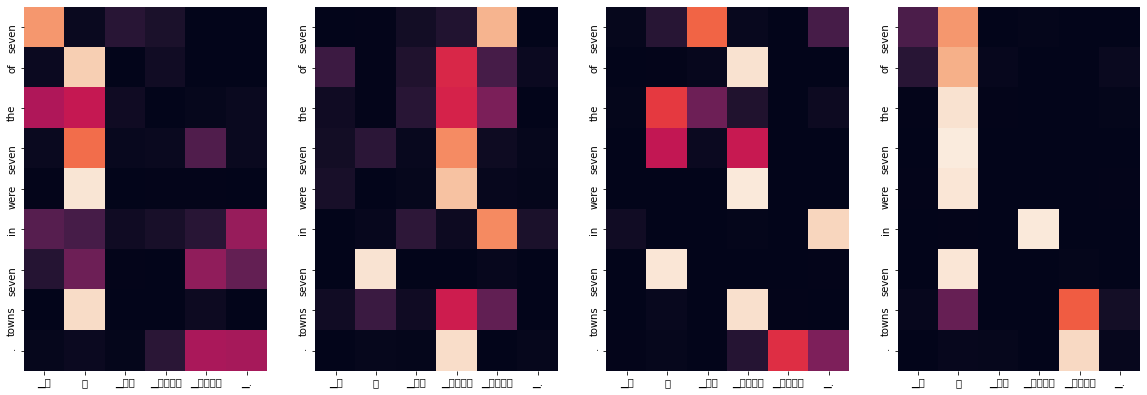

  0%|          | 0/909 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he is a president of the presidency .
Encoder Layer 1


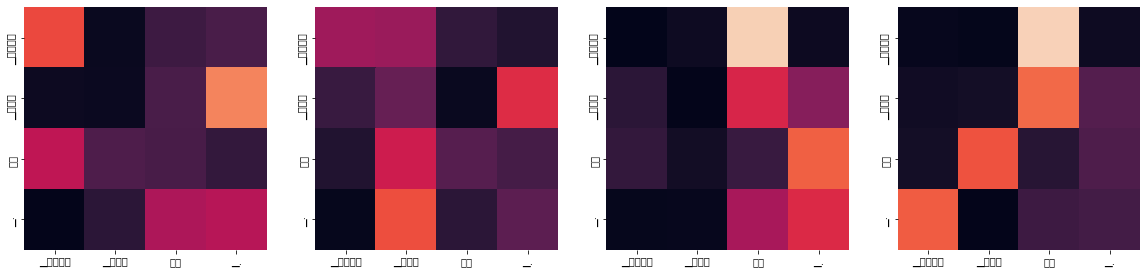

Encoder Layer 2


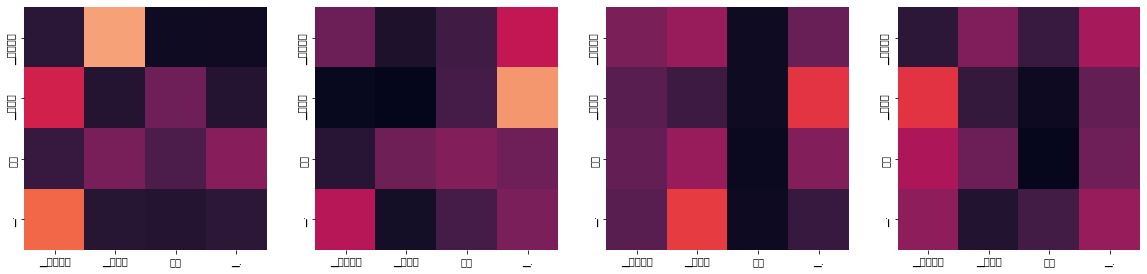

Decoder Self Layer 1


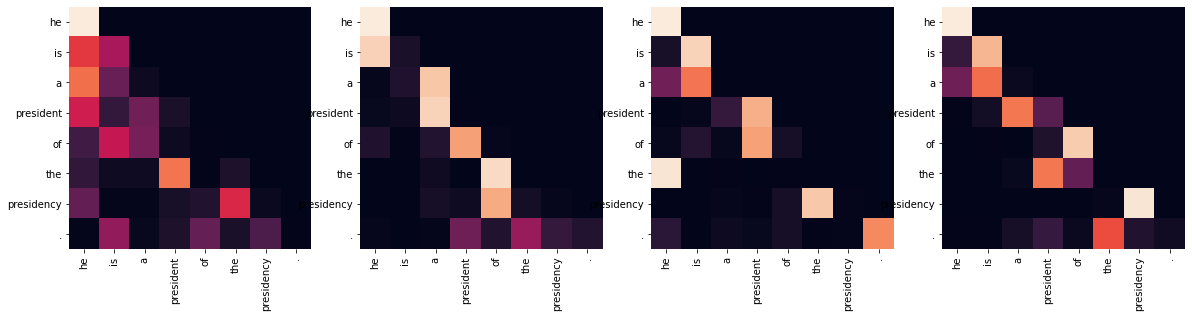

Decoder Src Layer 1


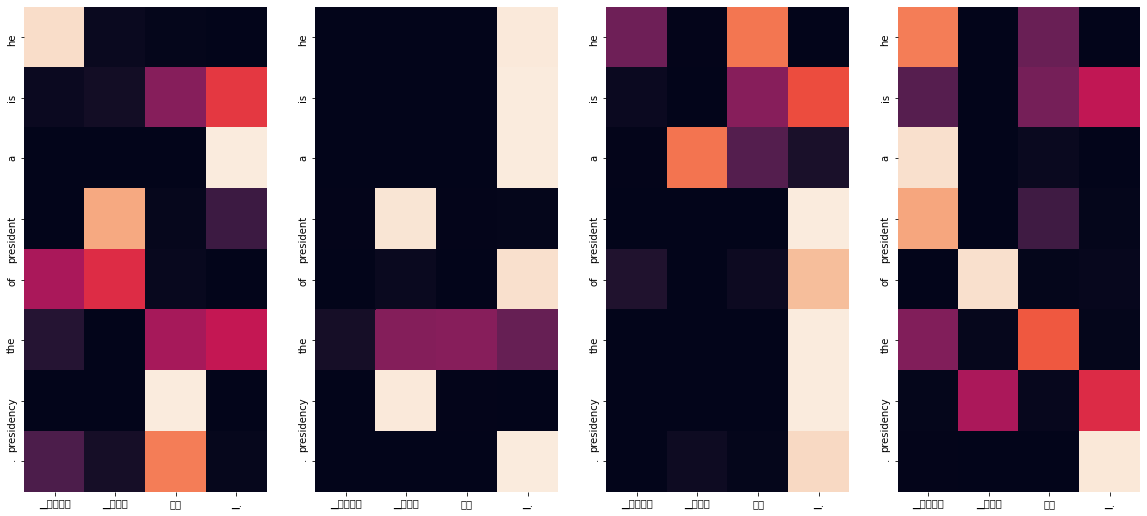

Decoder Self Layer 2


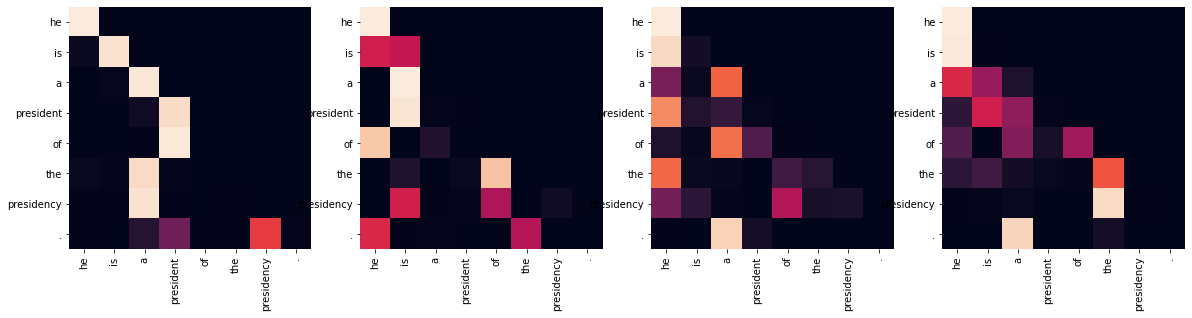

Decoder Src Layer 2


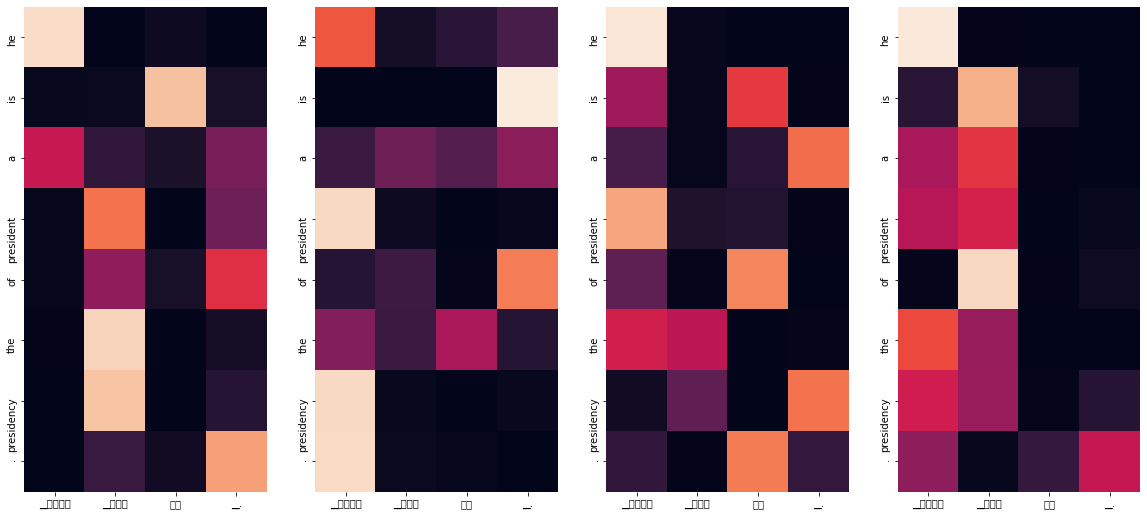

Input: 시민들은 도시 속에 산다.
Predicted translation: citizens of the city cities are among the city s turks in the presence of the city .
Encoder Layer 1


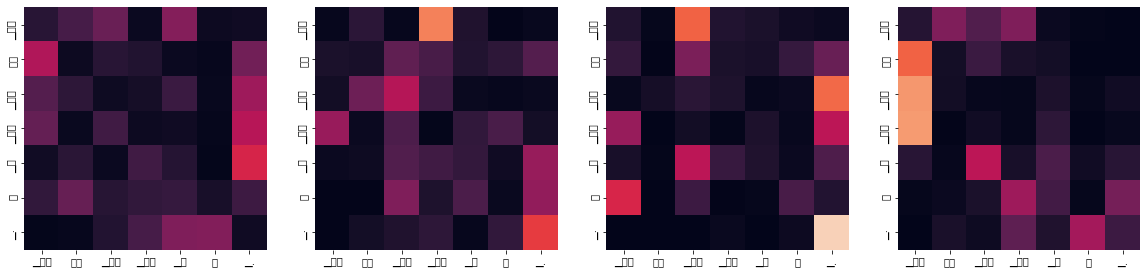

Encoder Layer 2


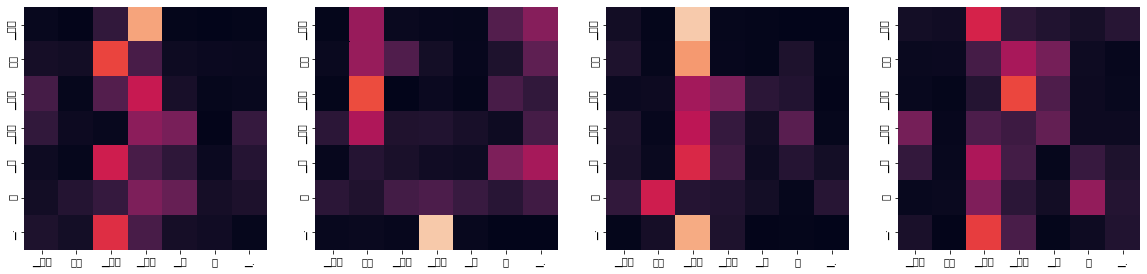

Decoder Self Layer 1


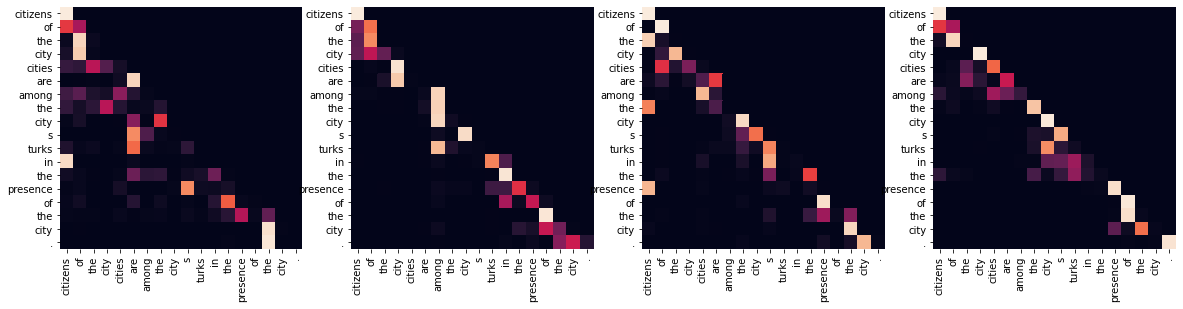

Decoder Src Layer 1


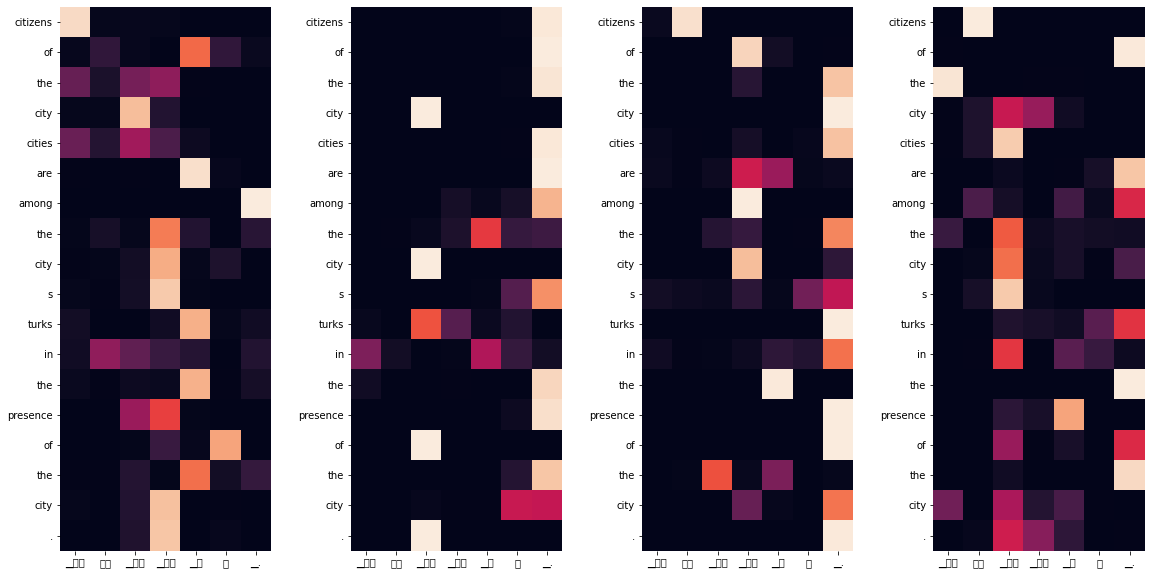

Decoder Self Layer 2


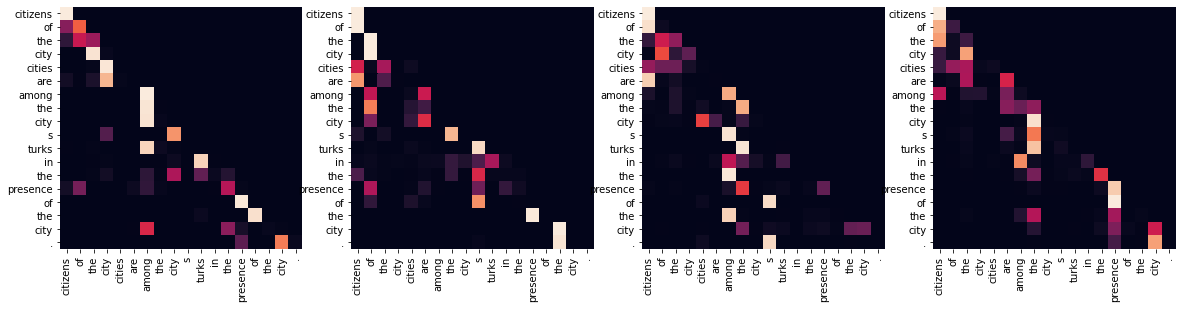

Decoder Src Layer 2


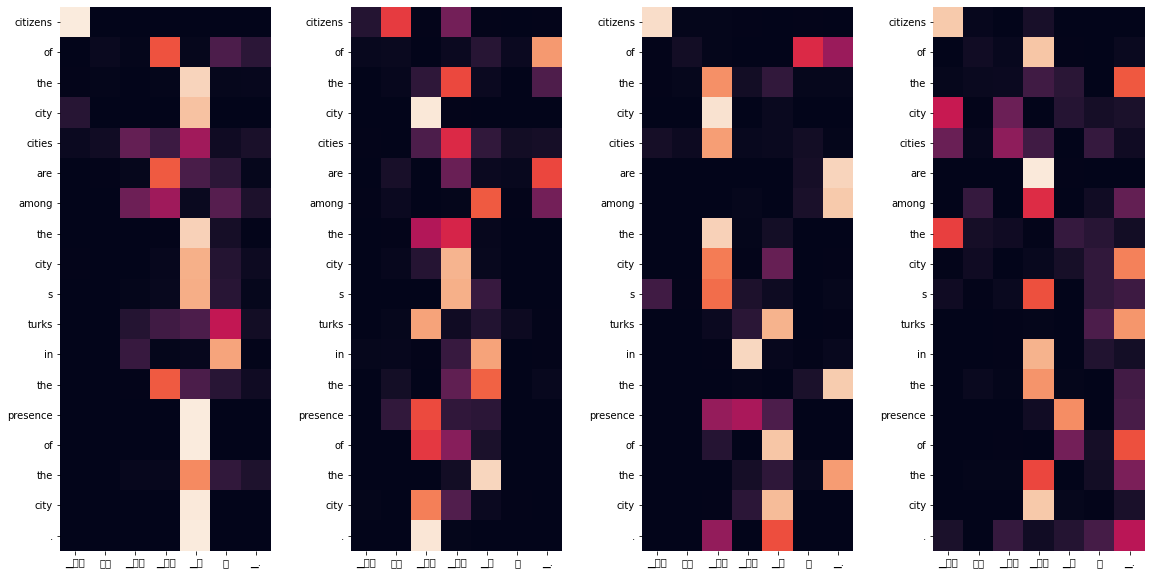

Input: 커피는 필요 없다.
Predicted translation: don t need coffee .
Encoder Layer 1


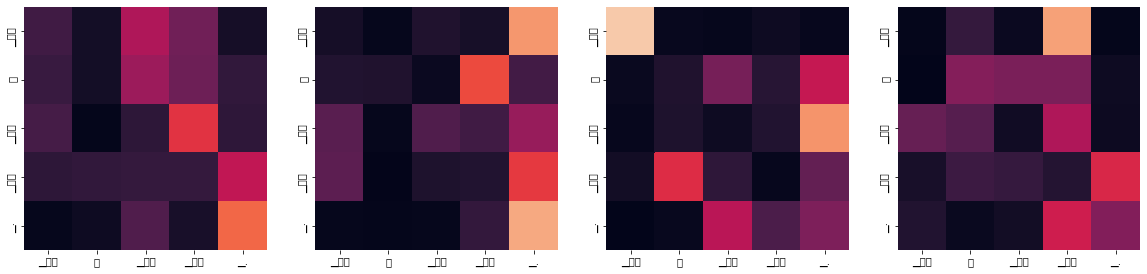

Encoder Layer 2


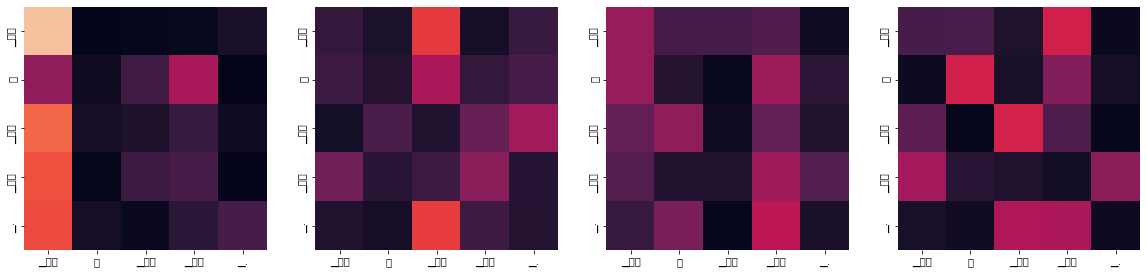

Decoder Self Layer 1


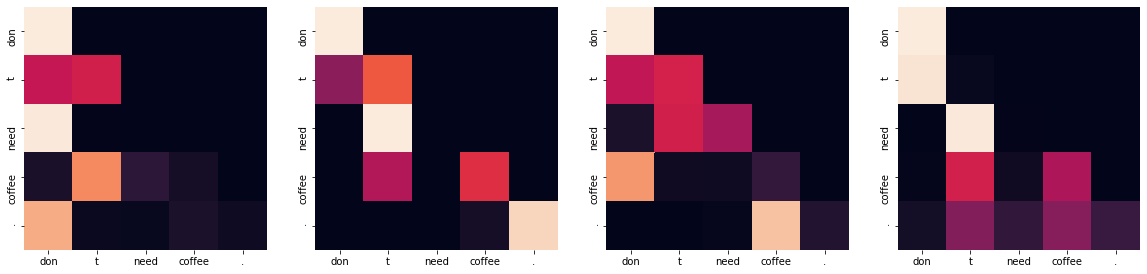

Decoder Src Layer 1


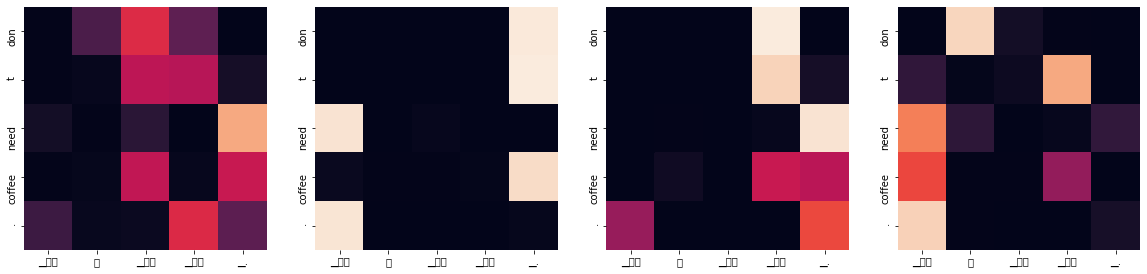

Decoder Self Layer 2


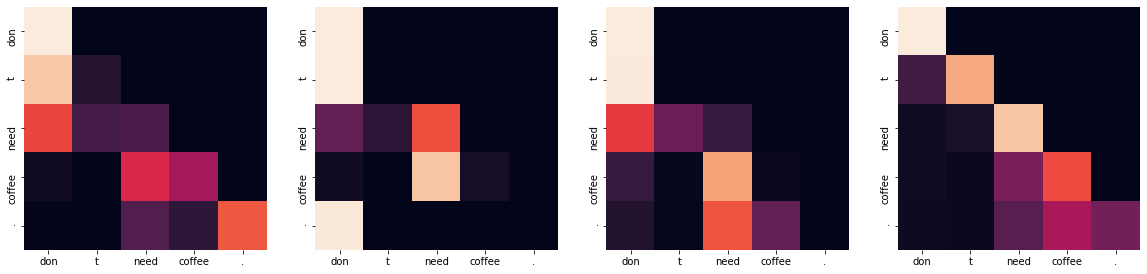

Decoder Src Layer 2


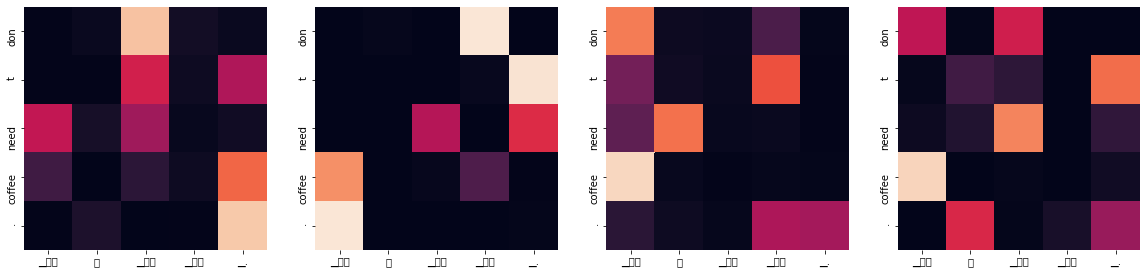

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were reported killed .
Encoder Layer 1


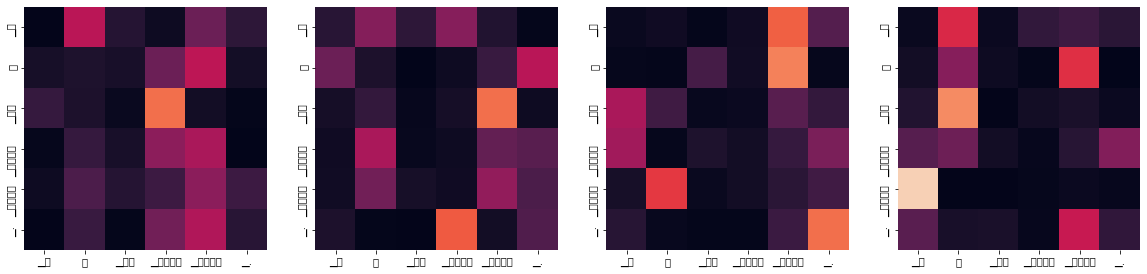

Encoder Layer 2


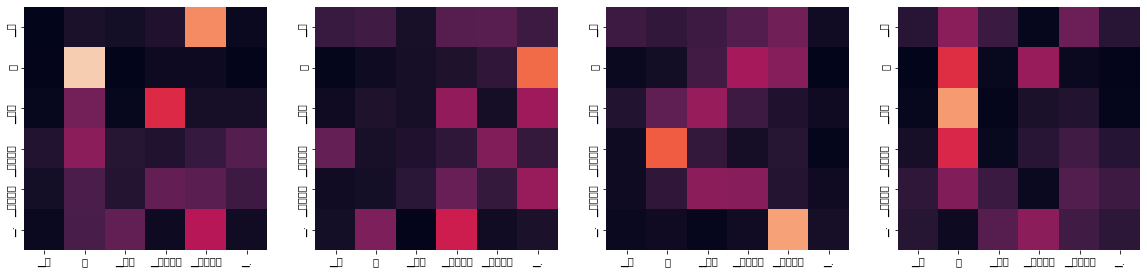

Decoder Self Layer 1


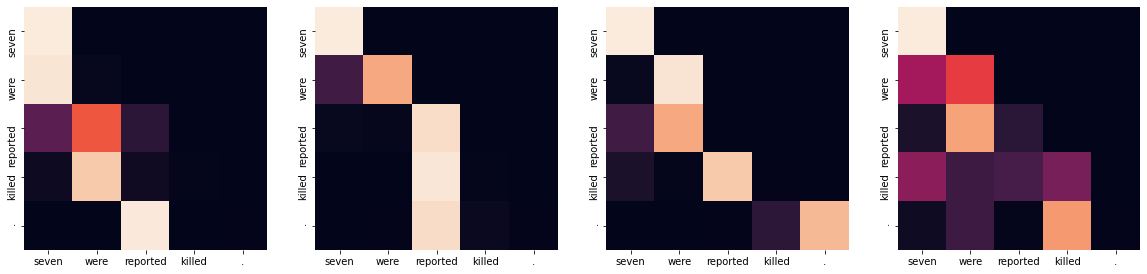

Decoder Src Layer 1


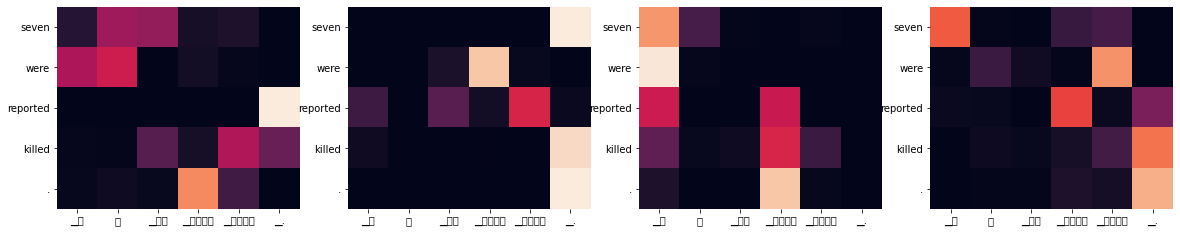

Decoder Self Layer 2


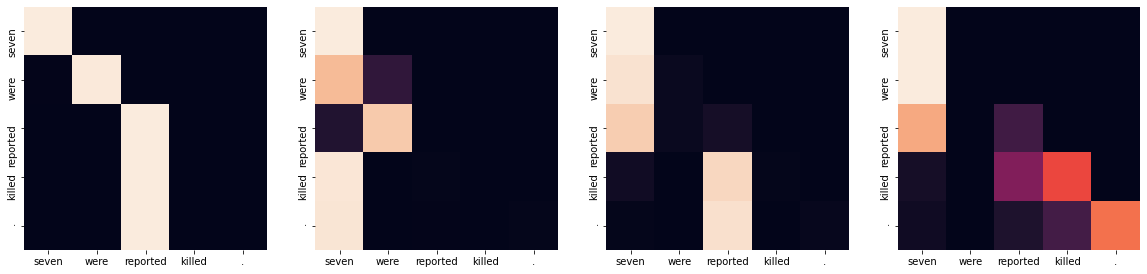

Decoder Src Layer 2


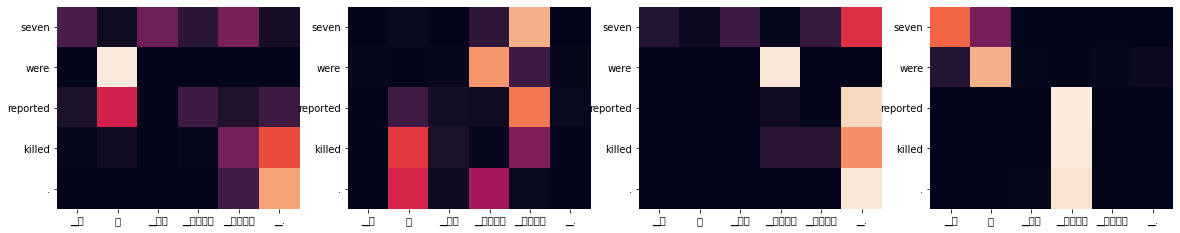

  0%|          | 0/909 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: i do have competed with president .
Encoder Layer 1


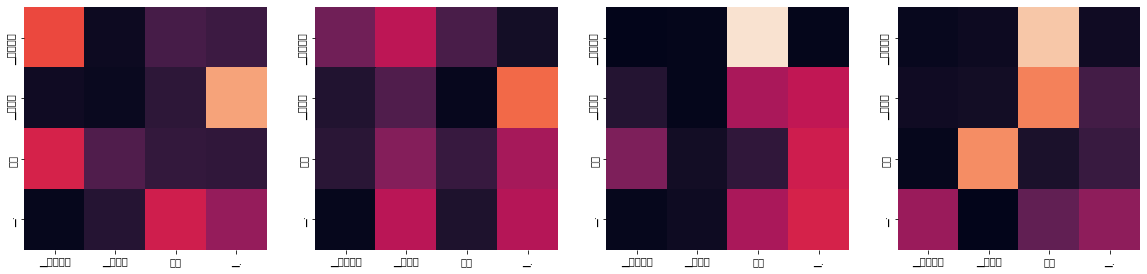

Encoder Layer 2


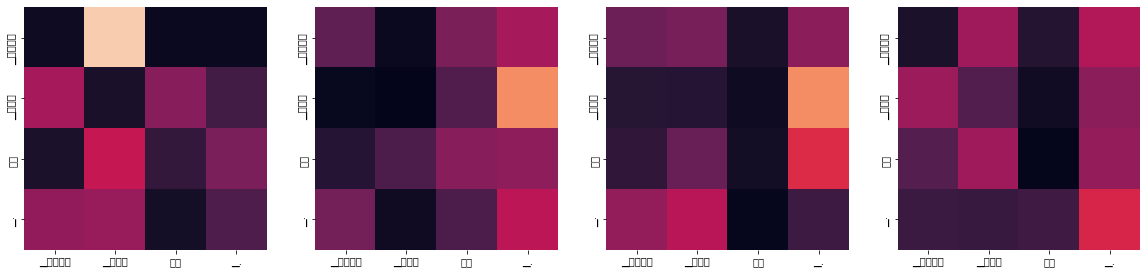

Decoder Self Layer 1


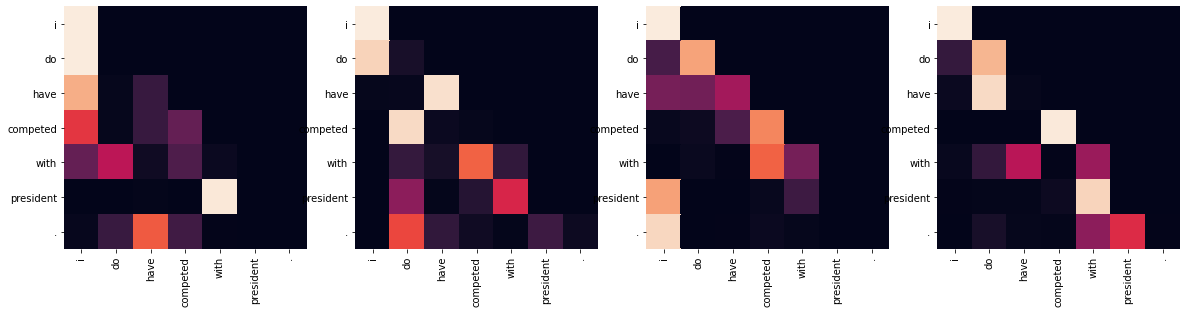

Decoder Src Layer 1


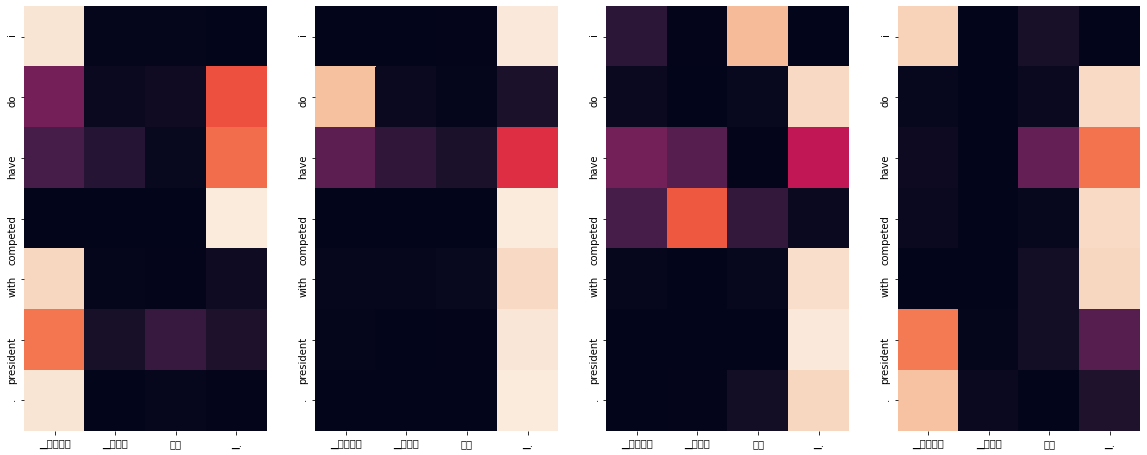

Decoder Self Layer 2


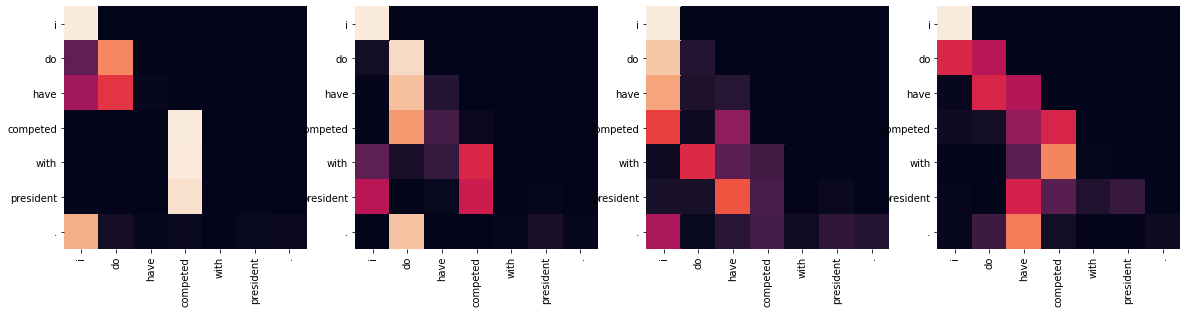

Decoder Src Layer 2


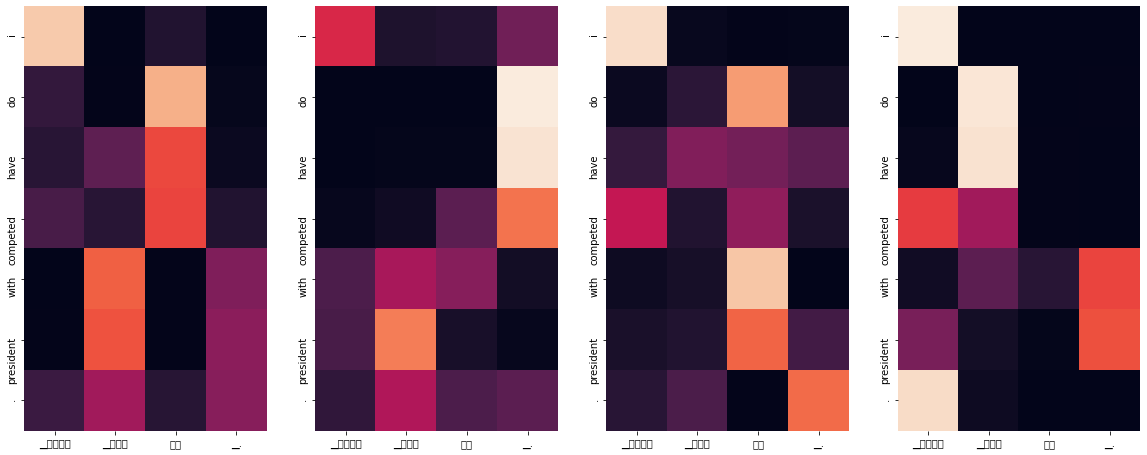

Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the city of in the city .
Encoder Layer 1


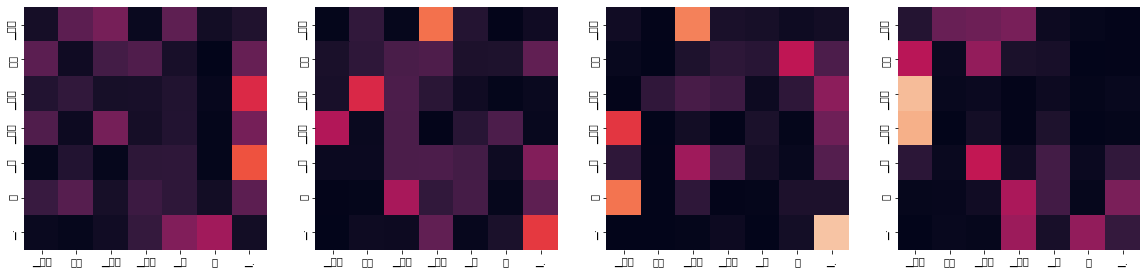

Encoder Layer 2


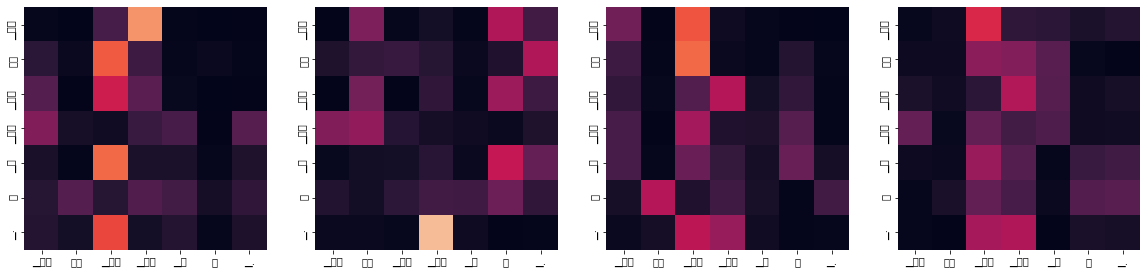

Decoder Self Layer 1


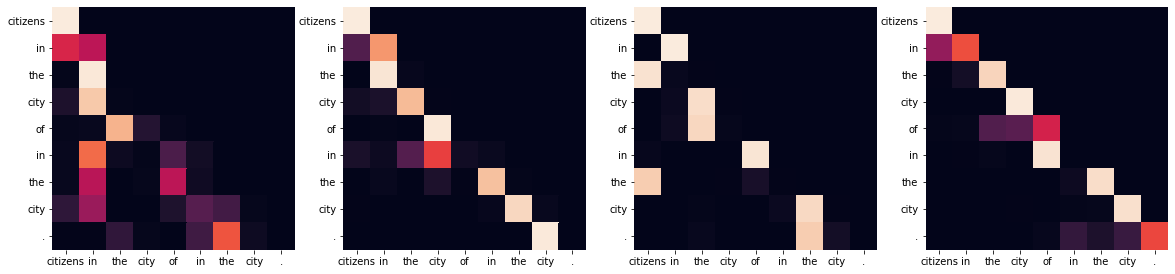

Decoder Src Layer 1


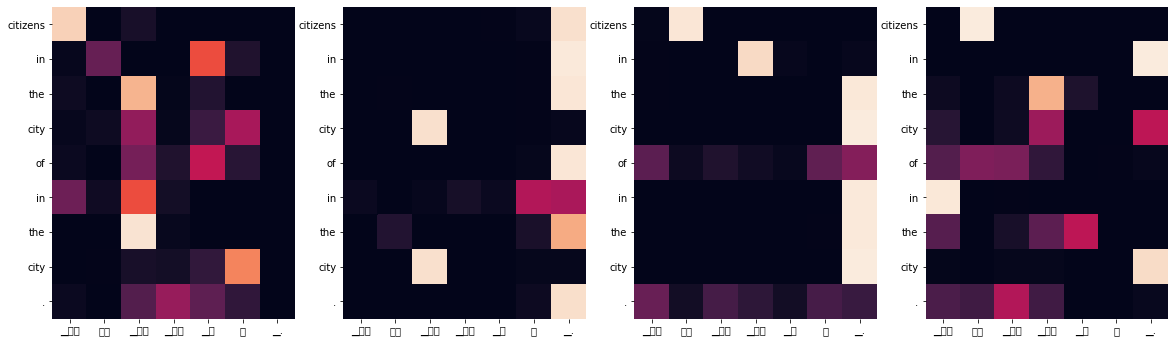

Decoder Self Layer 2


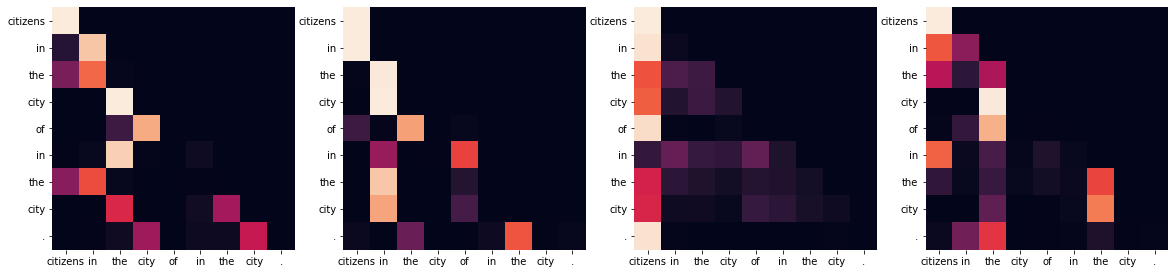

Decoder Src Layer 2


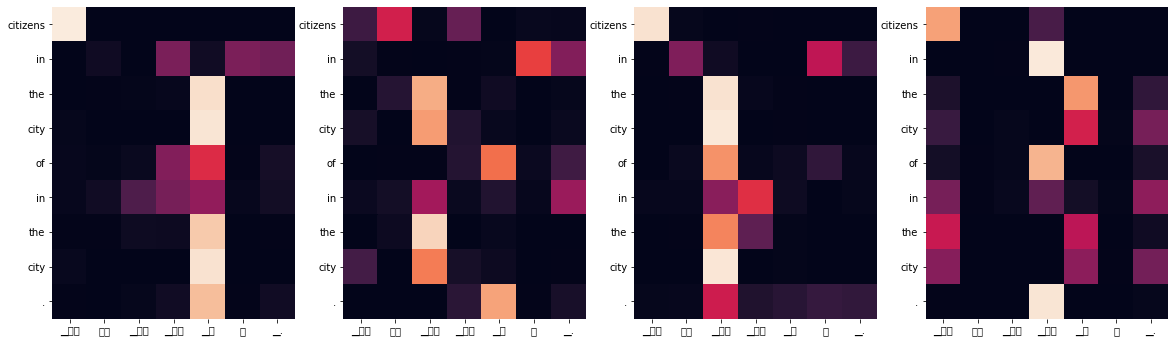

Input: 커피는 필요 없다.
Predicted translation: there is no price caislem is unacceptable .
Encoder Layer 1


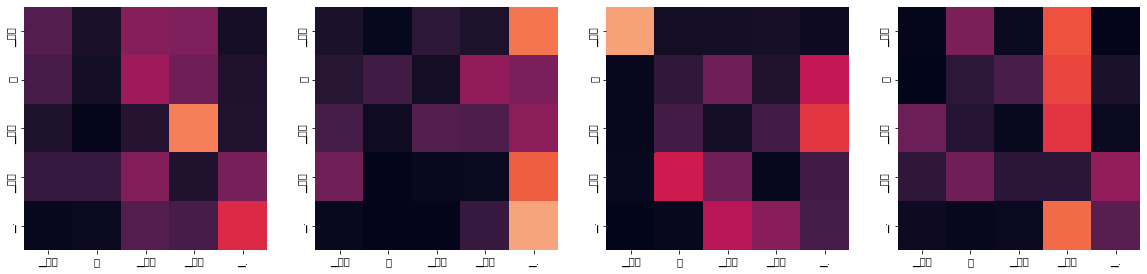

Encoder Layer 2


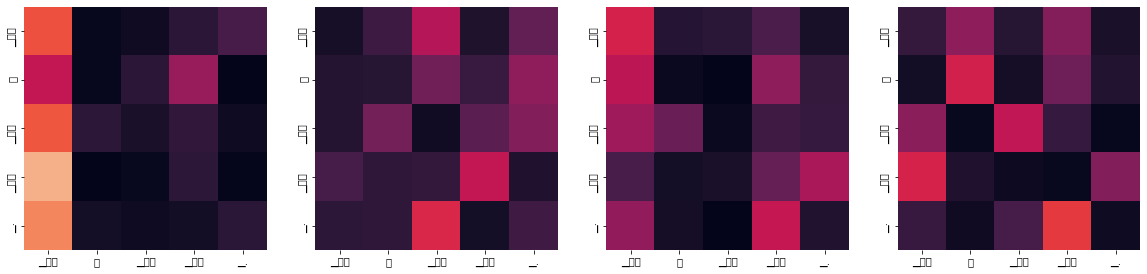

Decoder Self Layer 1


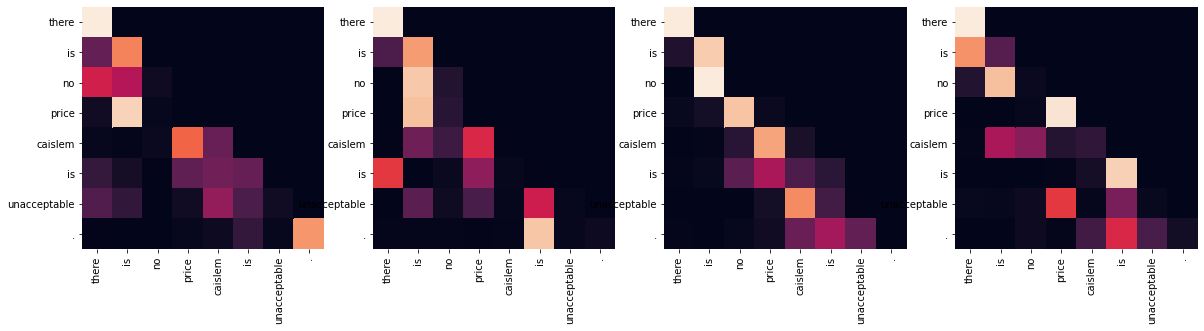

Decoder Src Layer 1


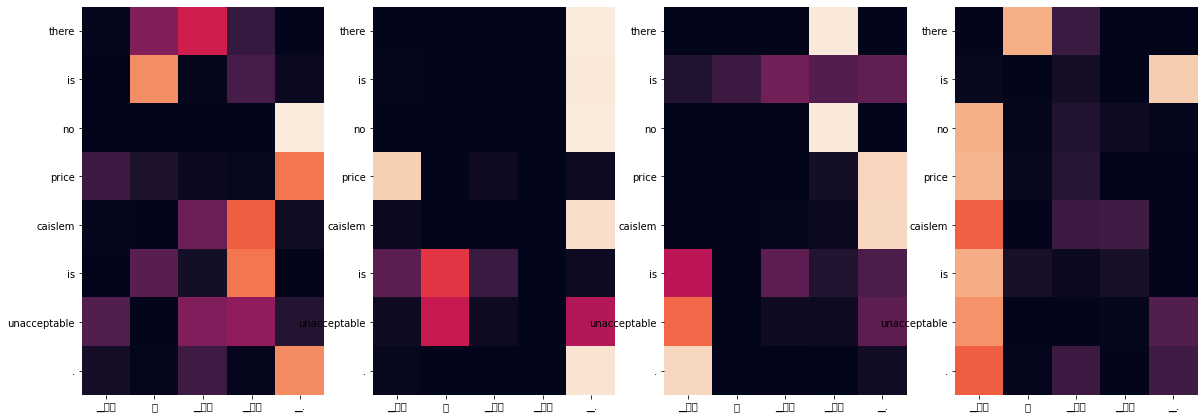

Decoder Self Layer 2


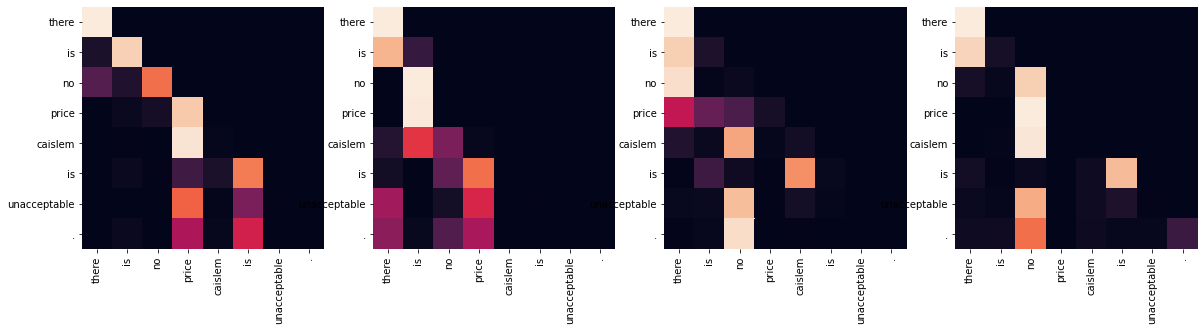

Decoder Src Layer 2


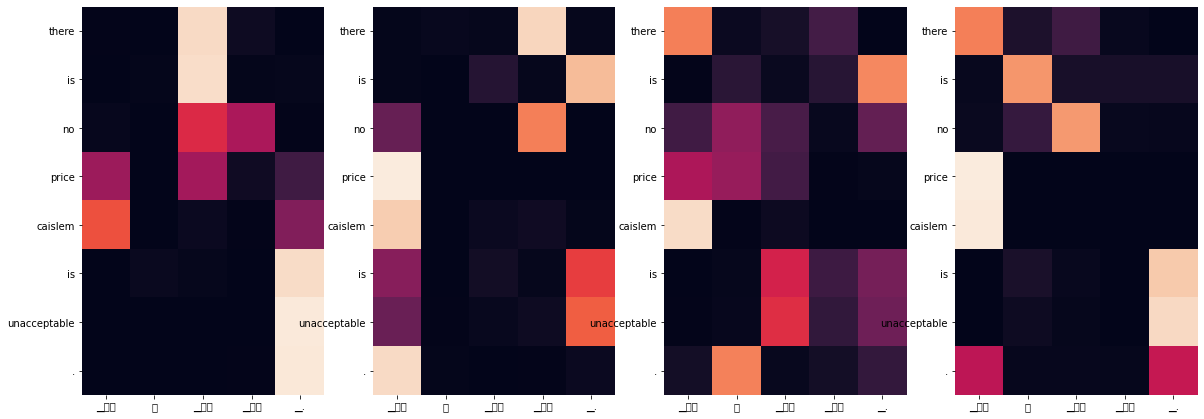

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were reported in the seven deaths .
Encoder Layer 1


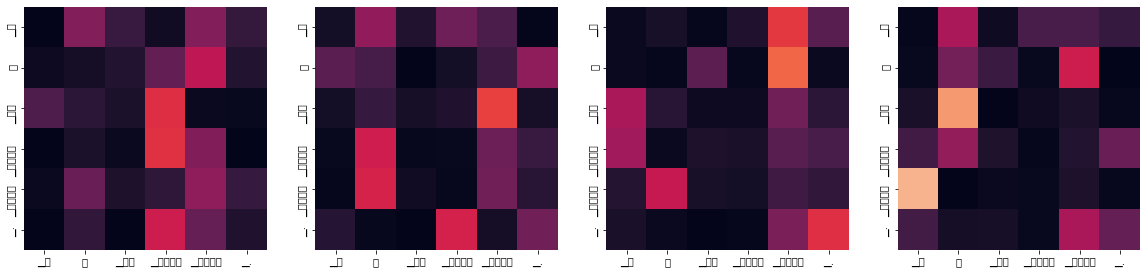

Encoder Layer 2


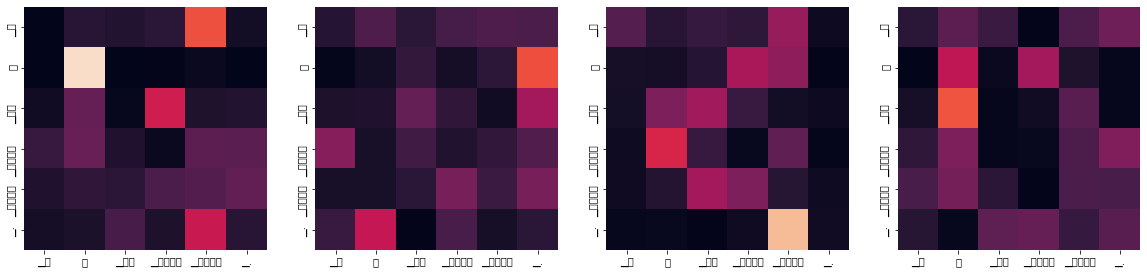

Decoder Self Layer 1


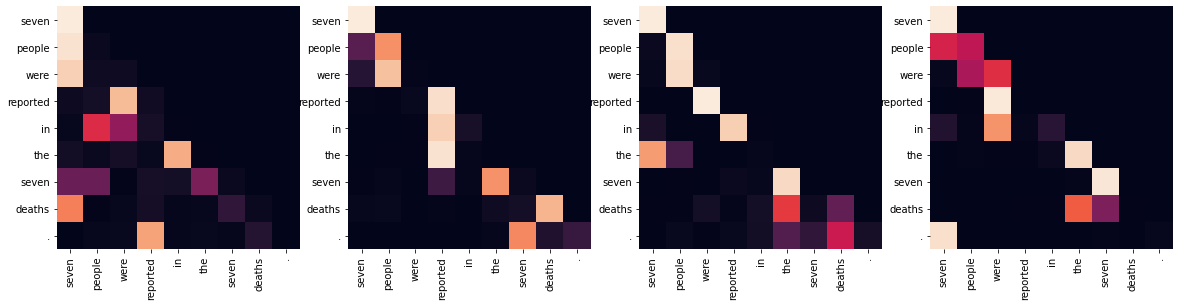

Decoder Src Layer 1


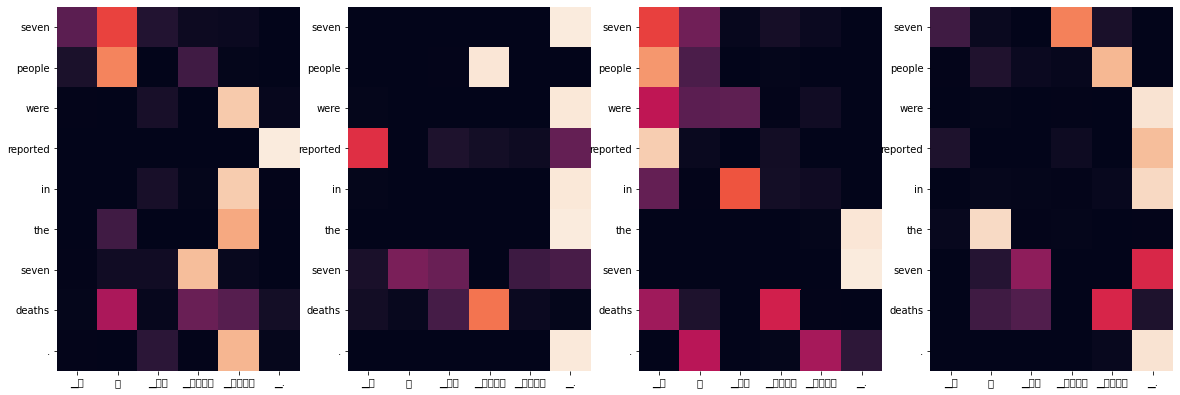

Decoder Self Layer 2


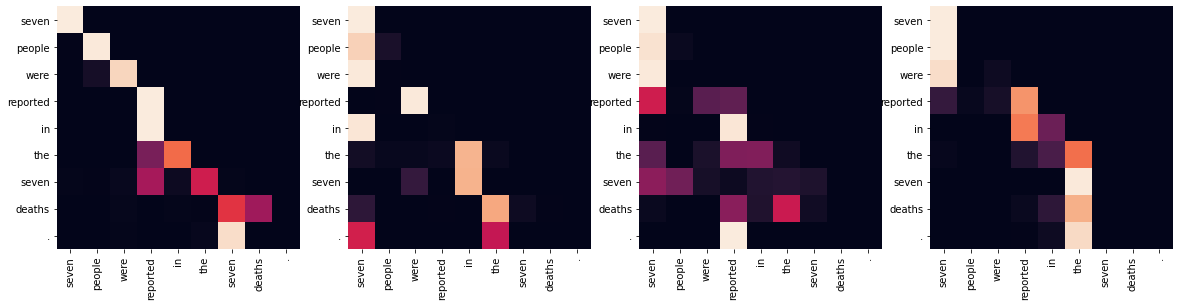

Decoder Src Layer 2


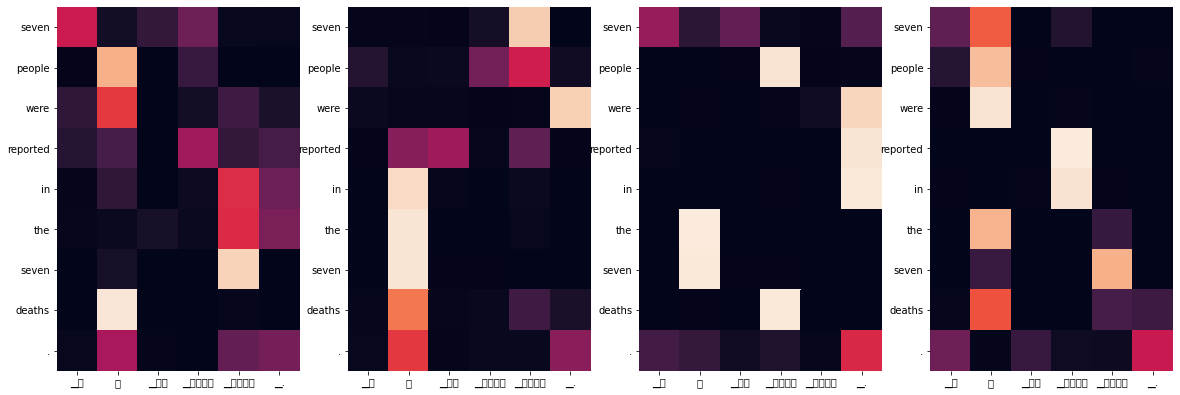

  0%|          | 0/909 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama .
Encoder Layer 1


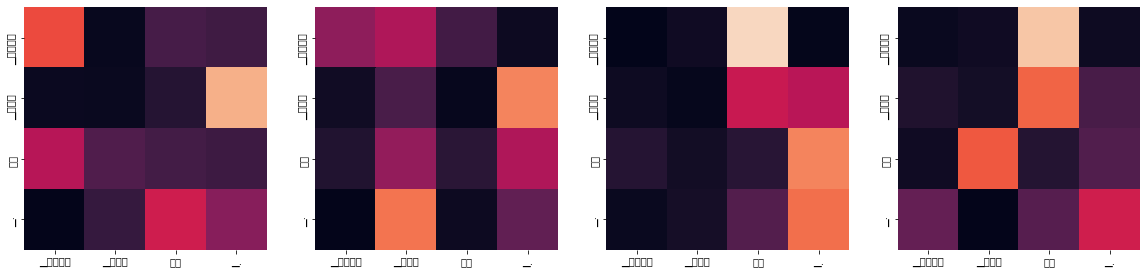

Encoder Layer 2


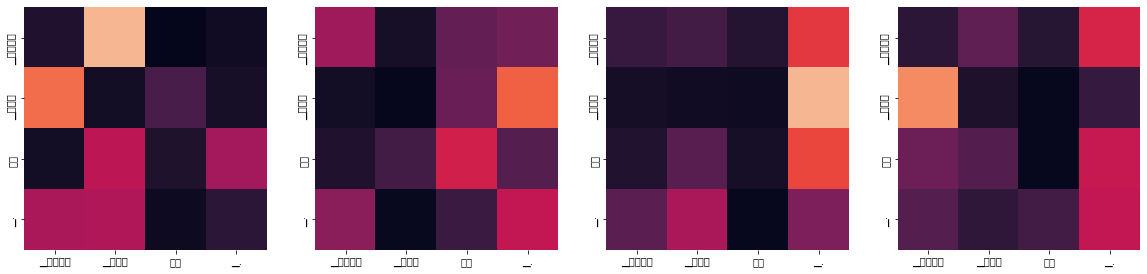

Decoder Self Layer 1


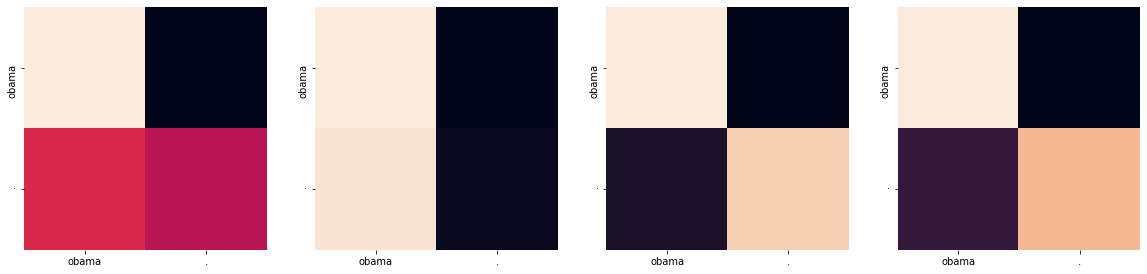

Decoder Src Layer 1


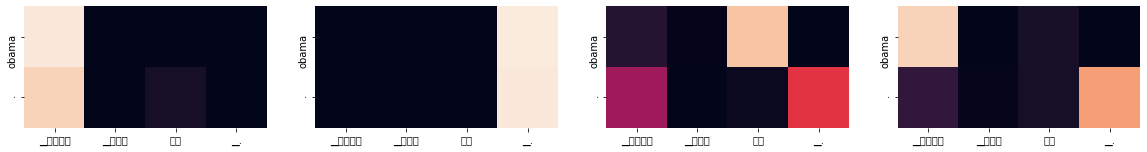

Decoder Self Layer 2


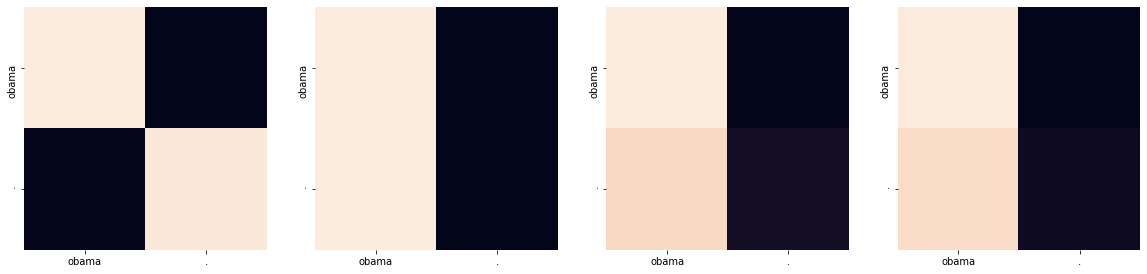

Decoder Src Layer 2


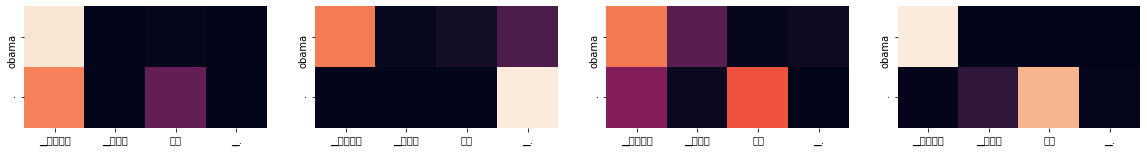

Input: 시민들은 도시 속에 산다.
Predicted translation: there are many in the city s city .
Encoder Layer 1


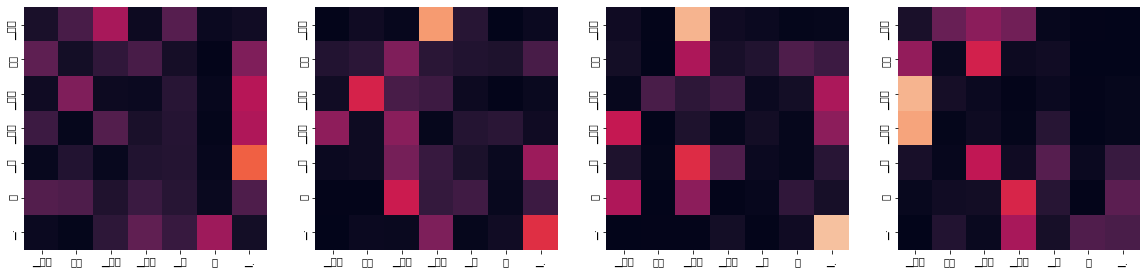

Encoder Layer 2


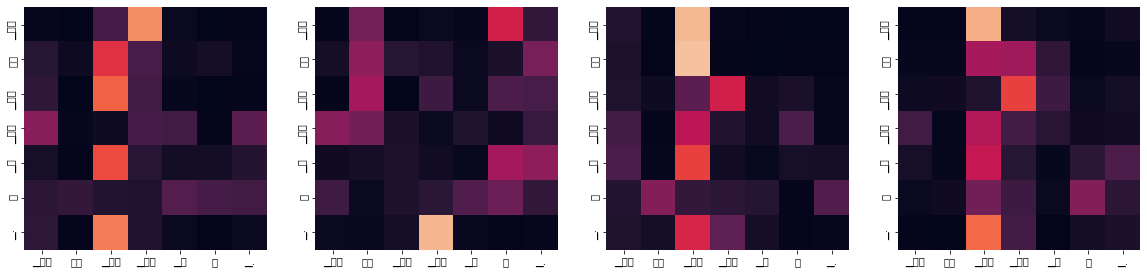

Decoder Self Layer 1


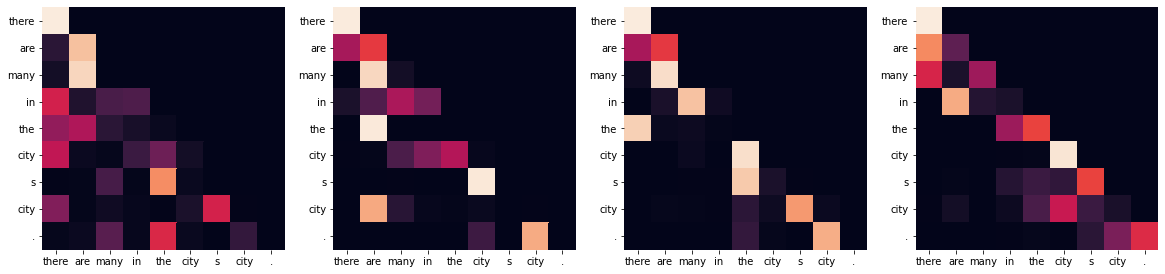

Decoder Src Layer 1


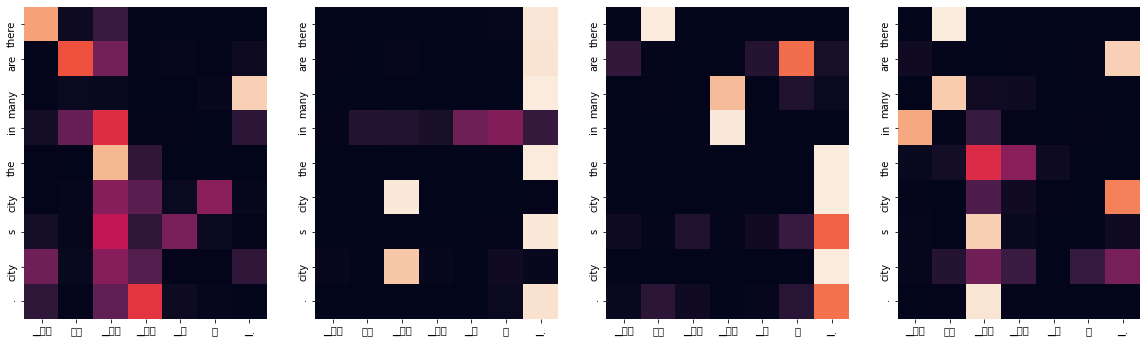

Decoder Self Layer 2


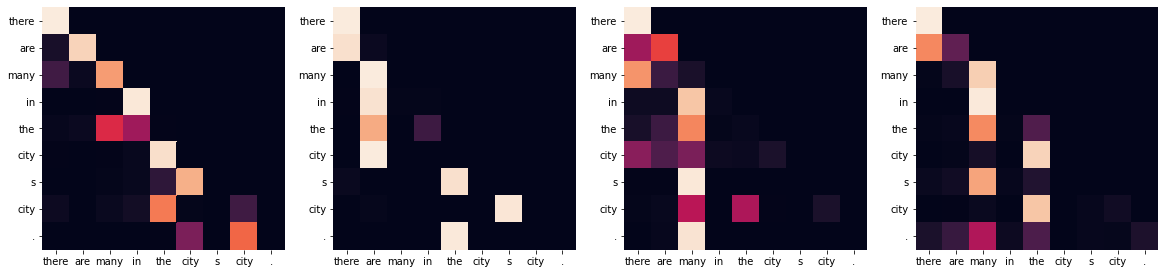

Decoder Src Layer 2


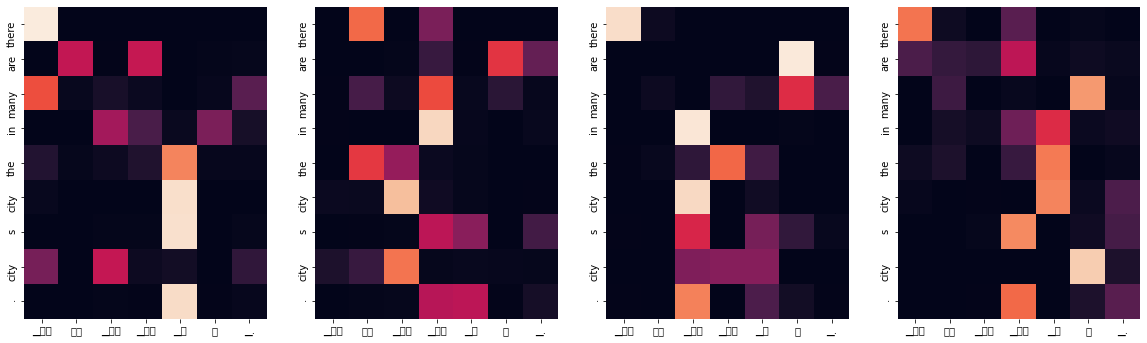

Input: 커피는 필요 없다.
Predicted translation: there is a coffee one won .
Encoder Layer 1


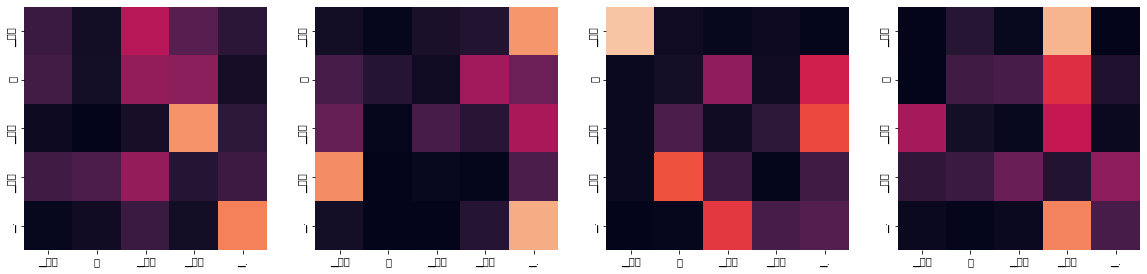

Encoder Layer 2


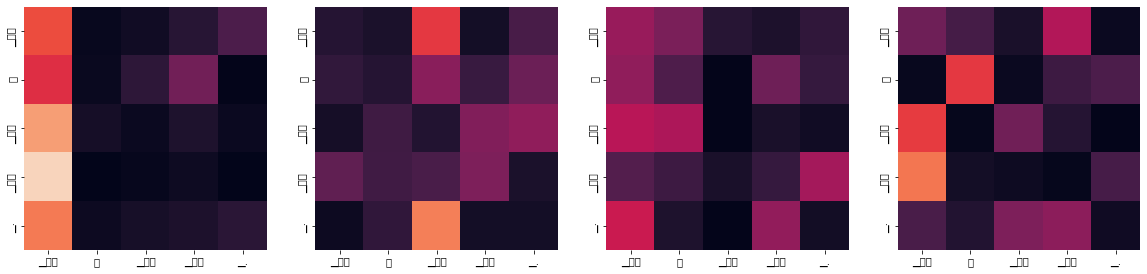

Decoder Self Layer 1


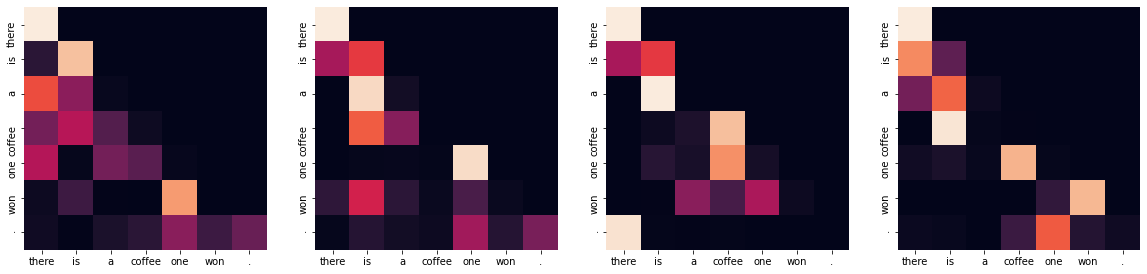

Decoder Src Layer 1


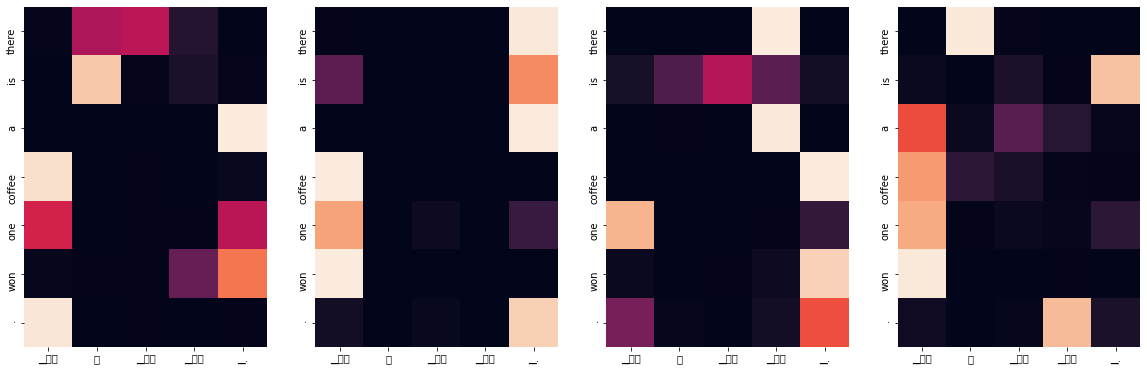

Decoder Self Layer 2


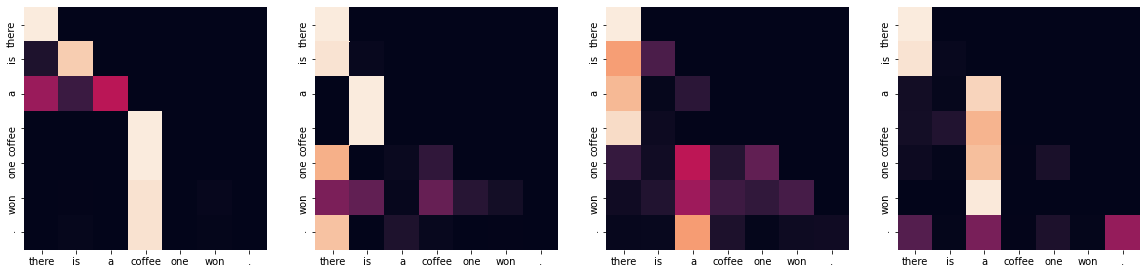

Decoder Src Layer 2


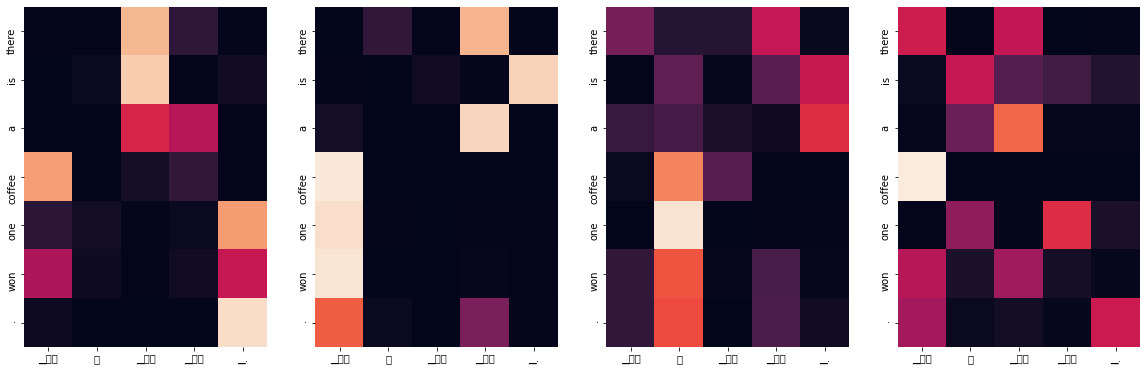

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other officers were reported to the seven deaths .
Encoder Layer 1


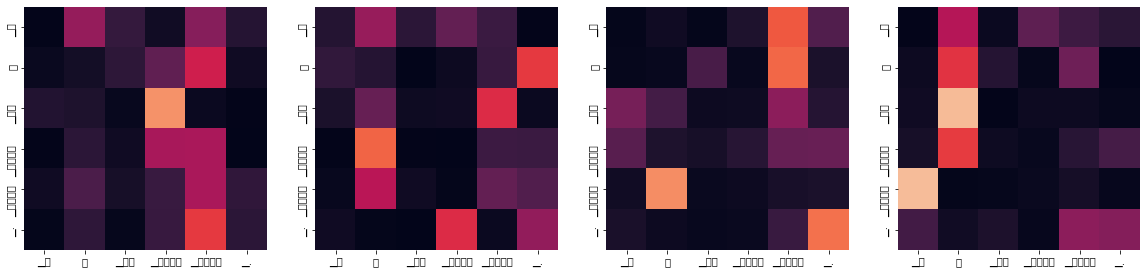

Encoder Layer 2


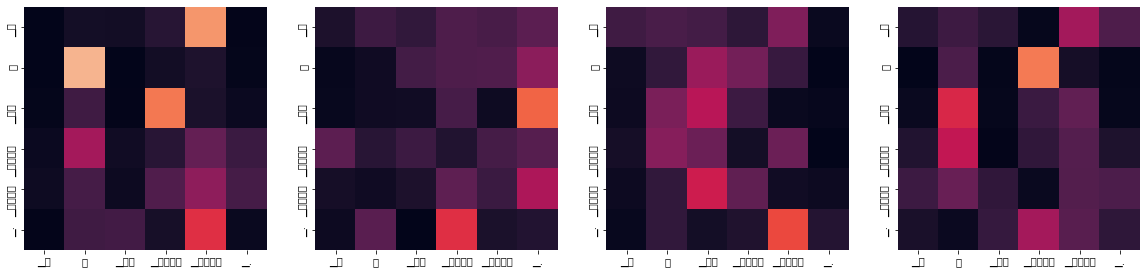

Decoder Self Layer 1


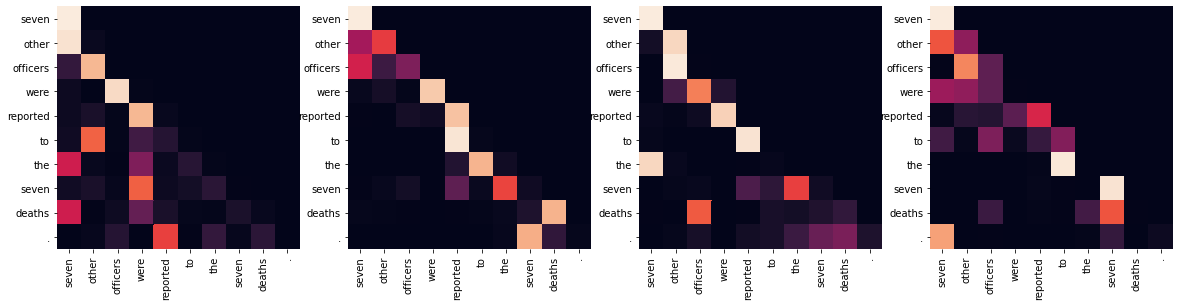

Decoder Src Layer 1


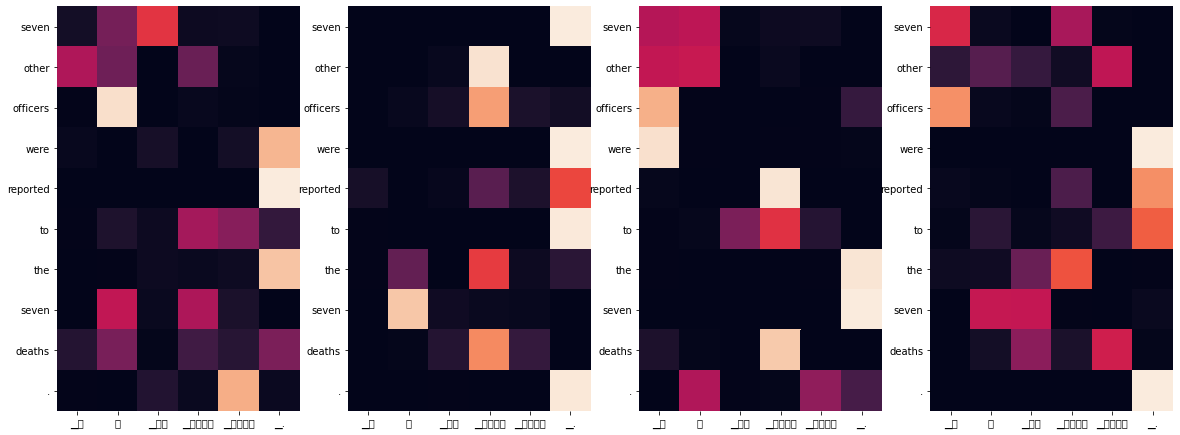

Decoder Self Layer 2


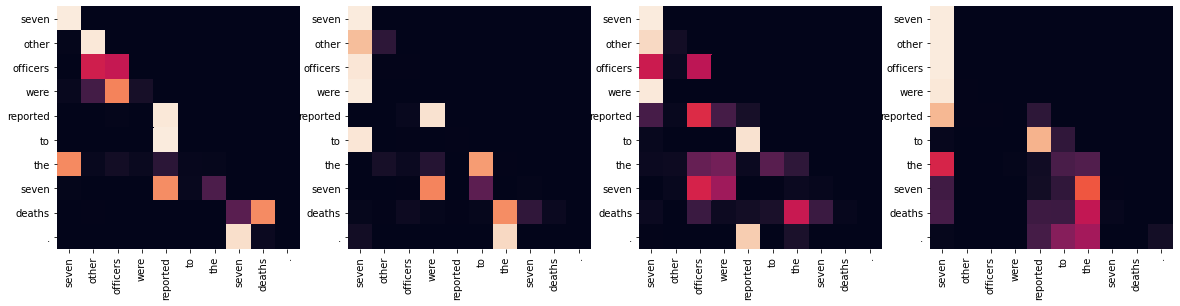

Decoder Src Layer 2


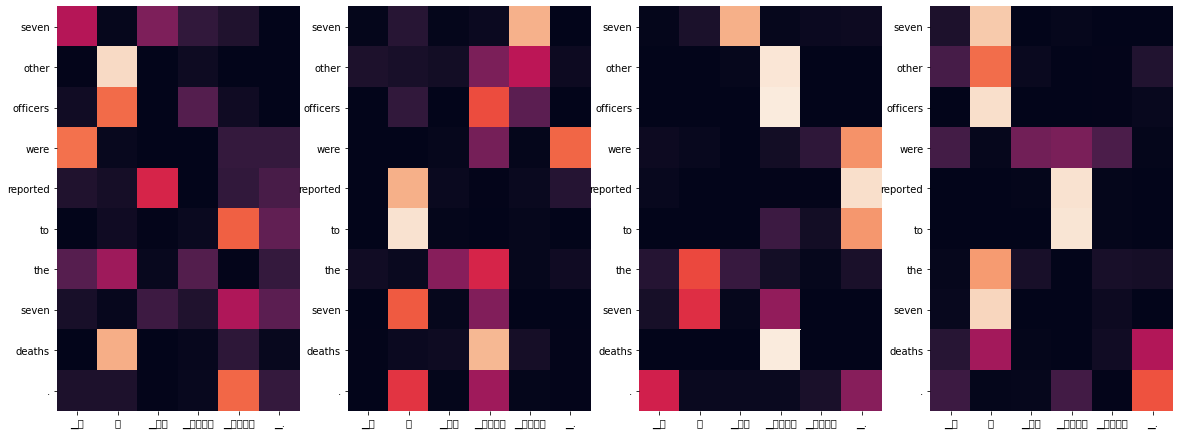

  0%|          | 0/909 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama .
Encoder Layer 1


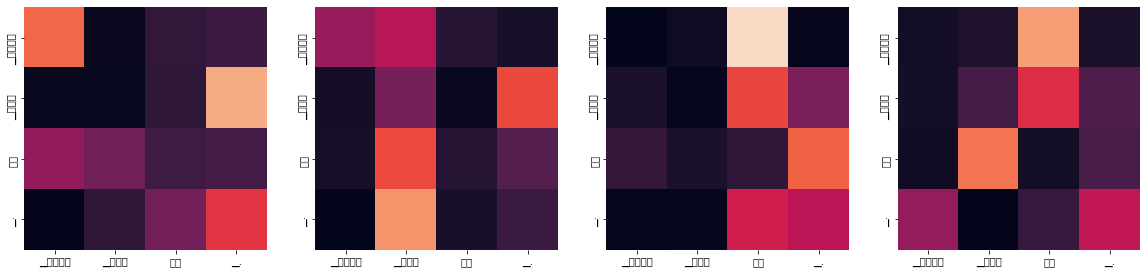

Encoder Layer 2


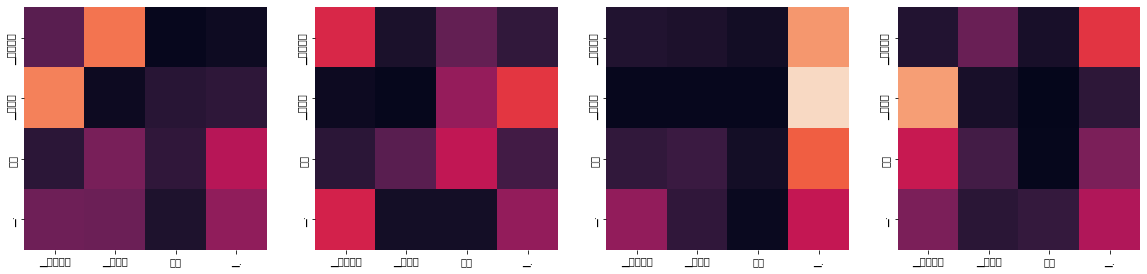

Decoder Self Layer 1


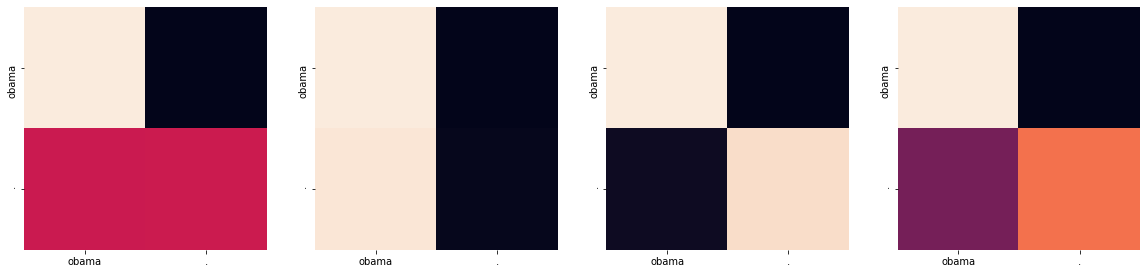

Decoder Src Layer 1


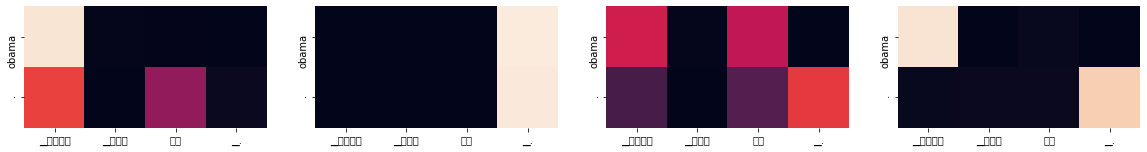

Decoder Self Layer 2


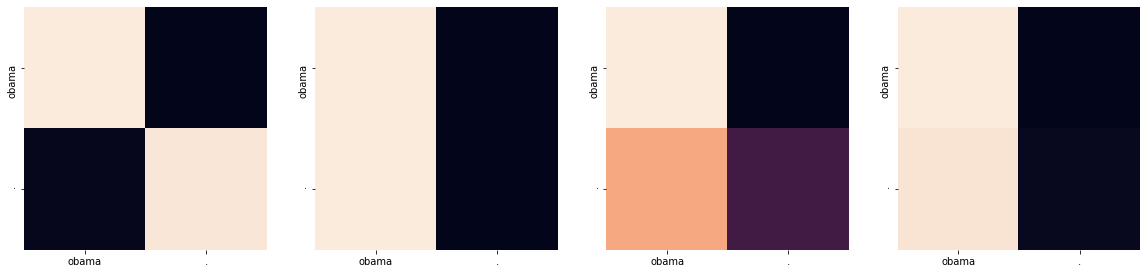

Decoder Src Layer 2


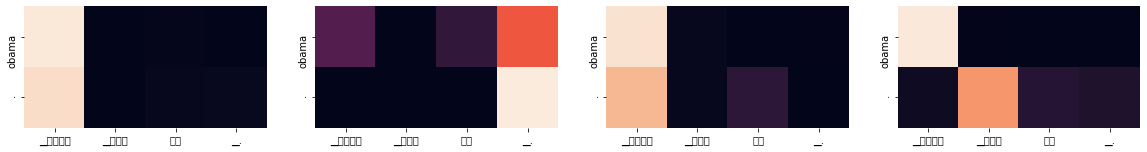

Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the city of the city .
Encoder Layer 1


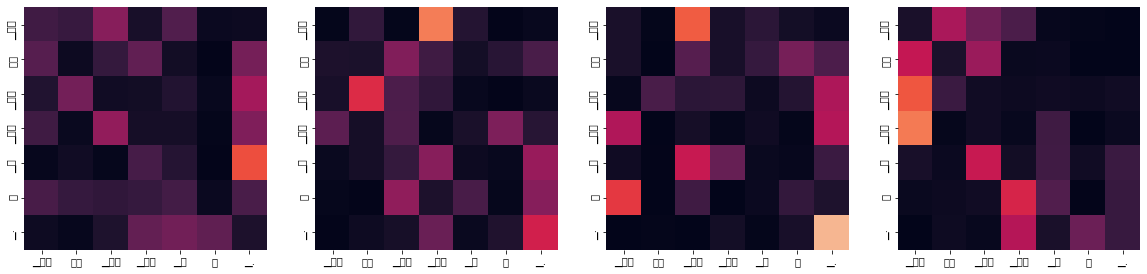

Encoder Layer 2


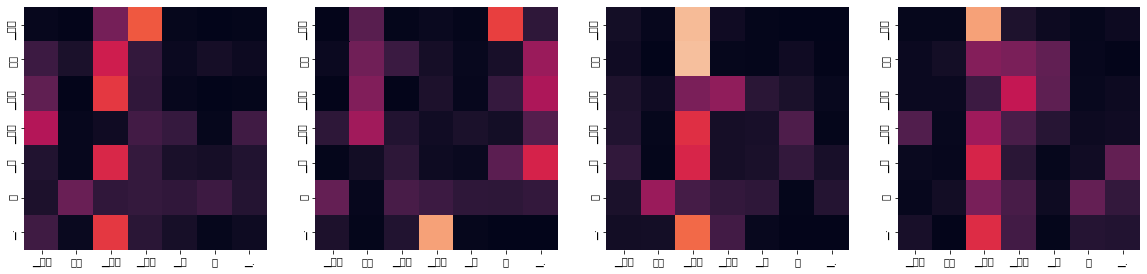

Decoder Self Layer 1


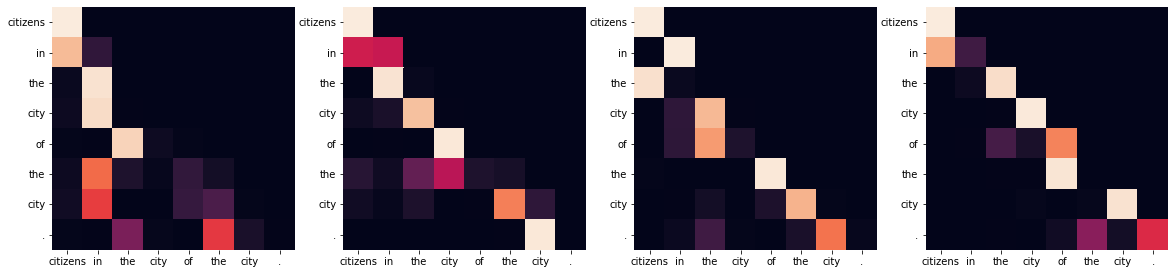

Decoder Src Layer 1


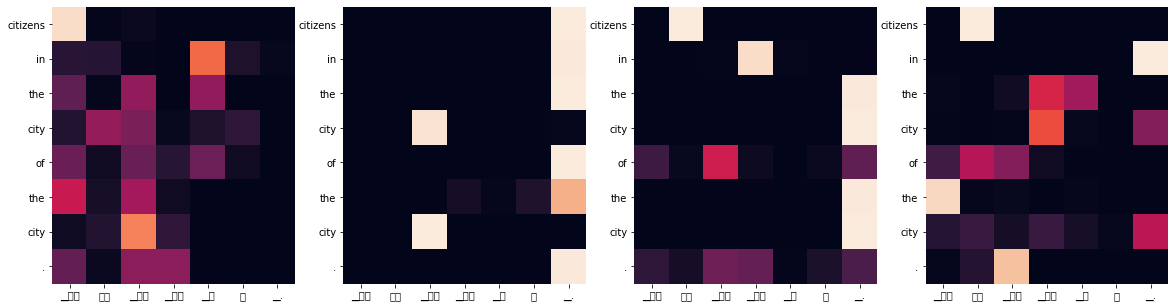

Decoder Self Layer 2


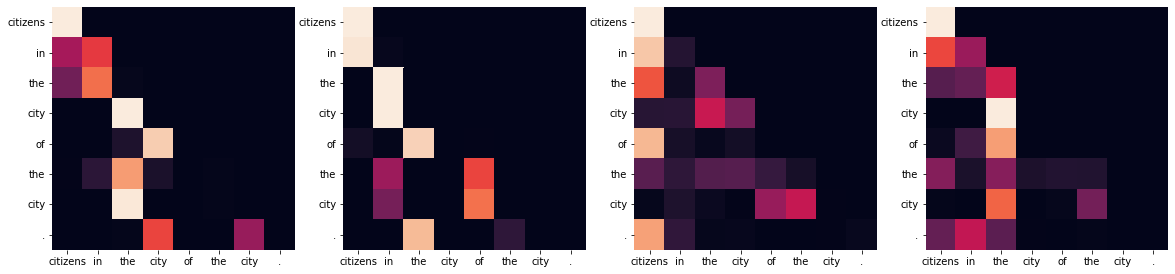

Decoder Src Layer 2


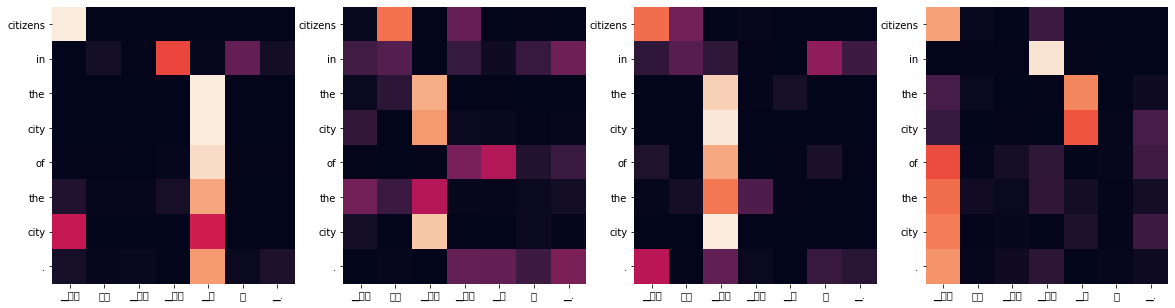

Input: 커피는 필요 없다.
Predicted translation: there s need to strongures on his greenent des raquo
Encoder Layer 1


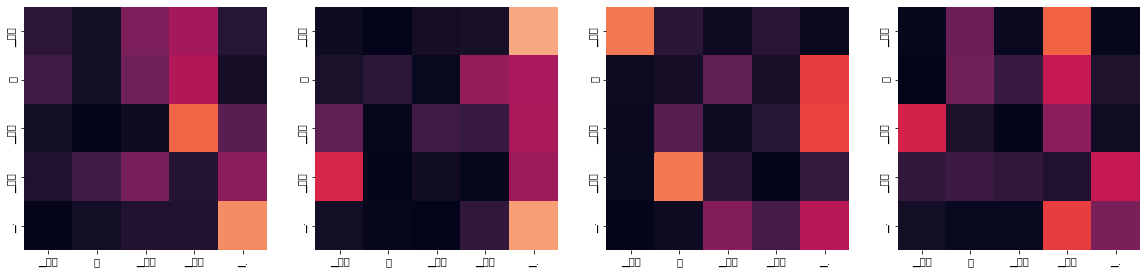

Encoder Layer 2


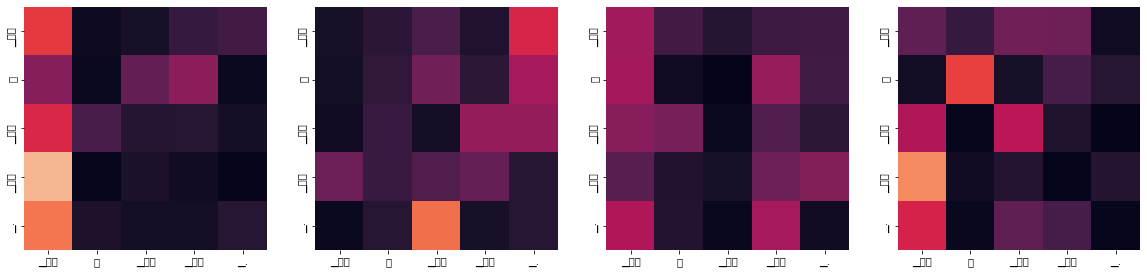

Decoder Self Layer 1


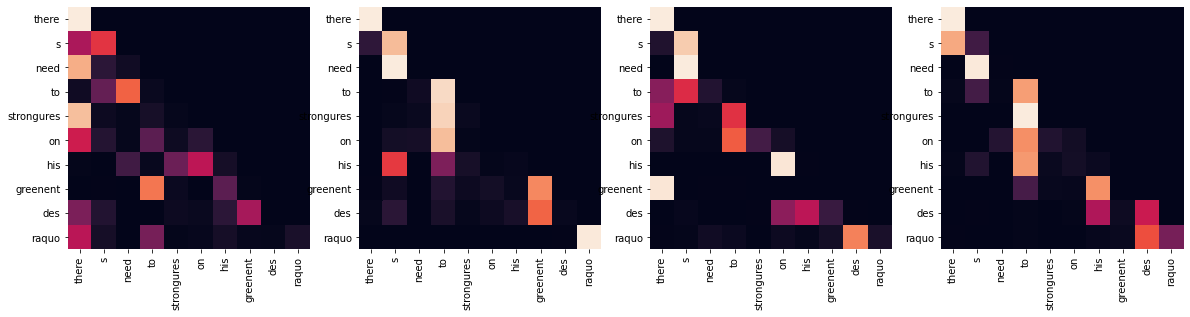

Decoder Src Layer 1


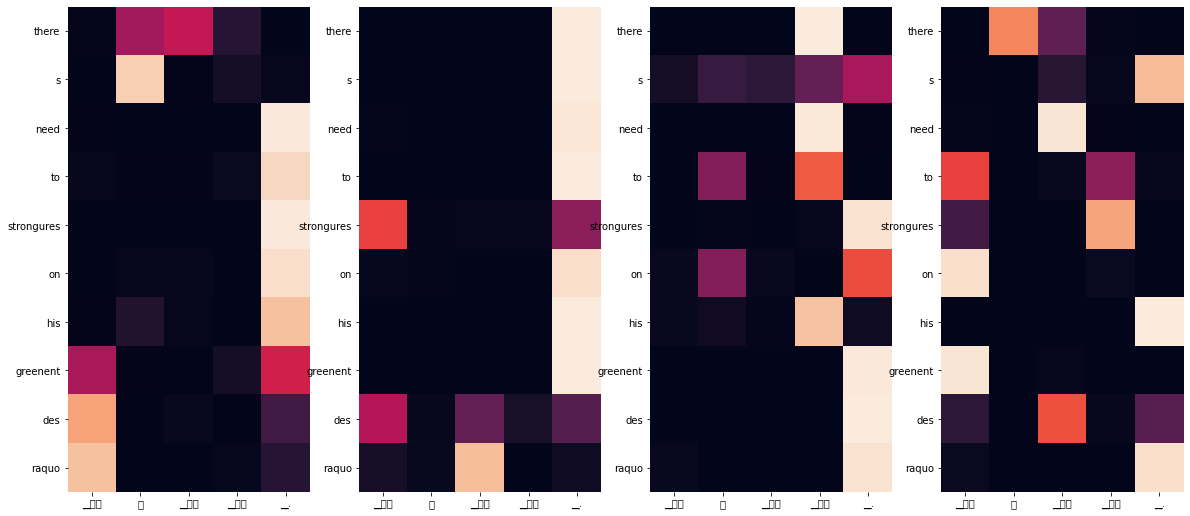

Decoder Self Layer 2


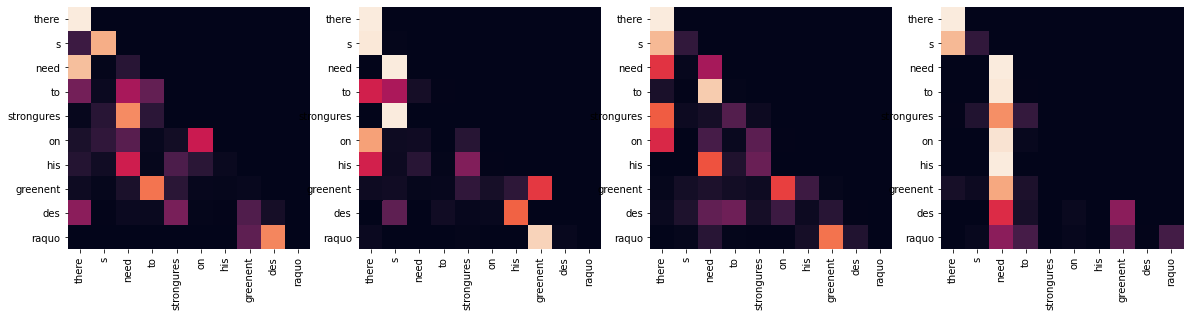

Decoder Src Layer 2


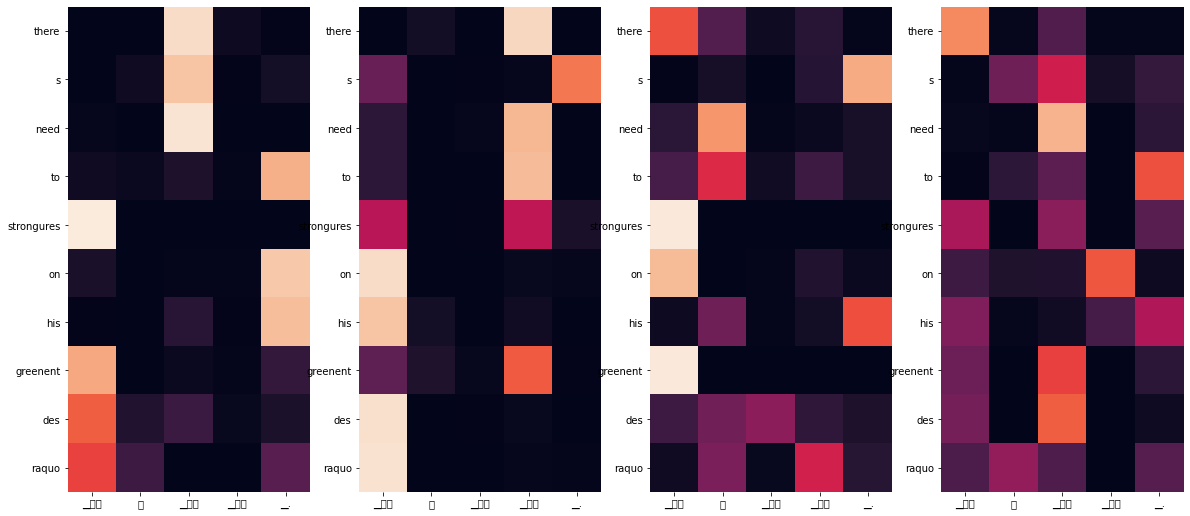

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed .
Encoder Layer 1


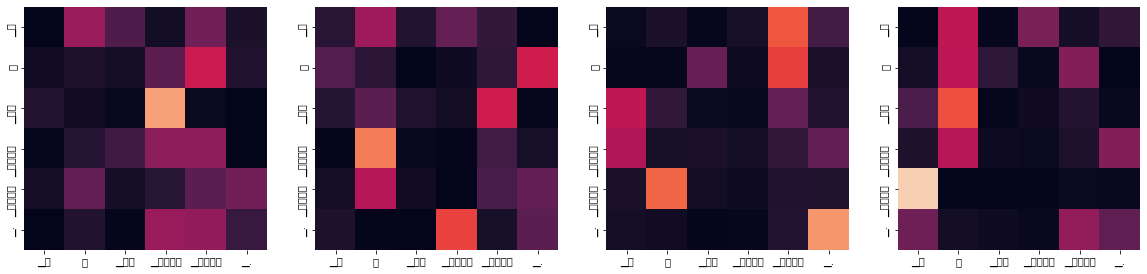

Encoder Layer 2


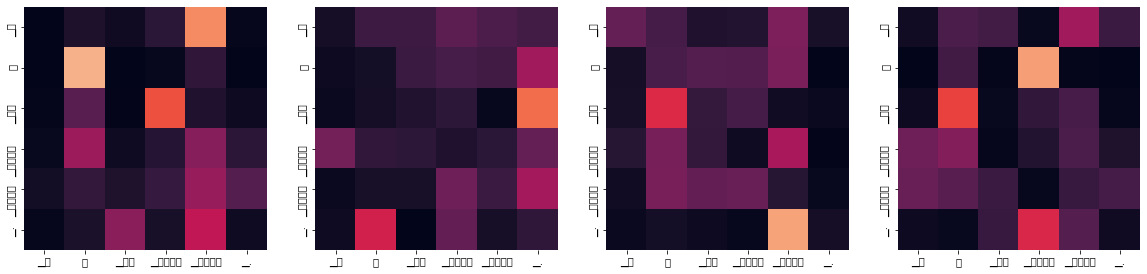

Decoder Self Layer 1


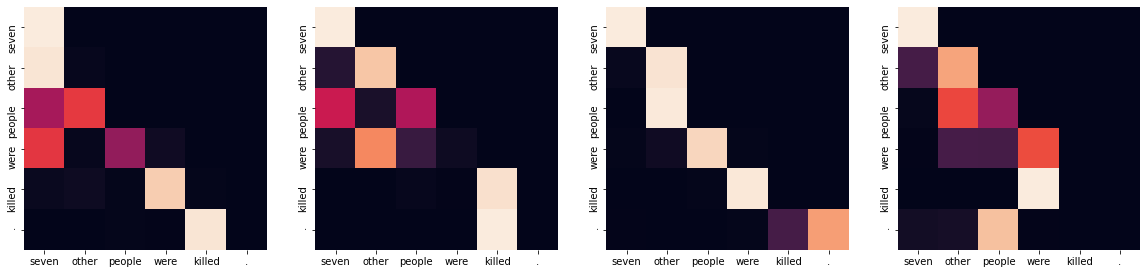

Decoder Src Layer 1


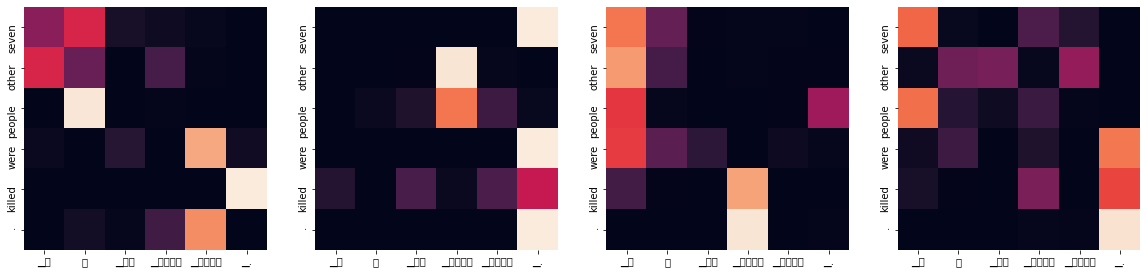

Decoder Self Layer 2


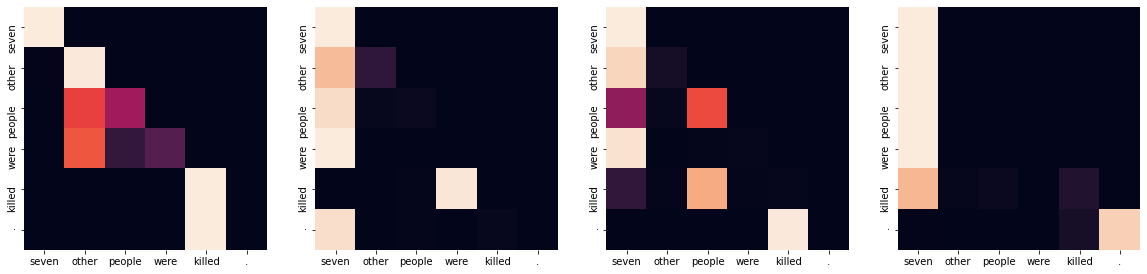

Decoder Src Layer 2


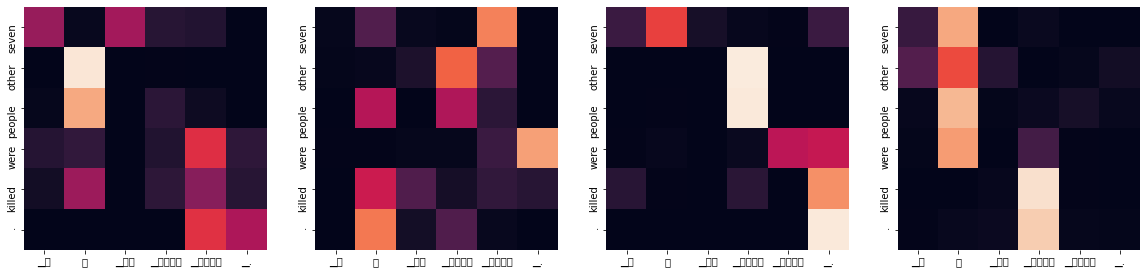

  0%|          | 0/909 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he is a president , obama s term as president .
Encoder Layer 1


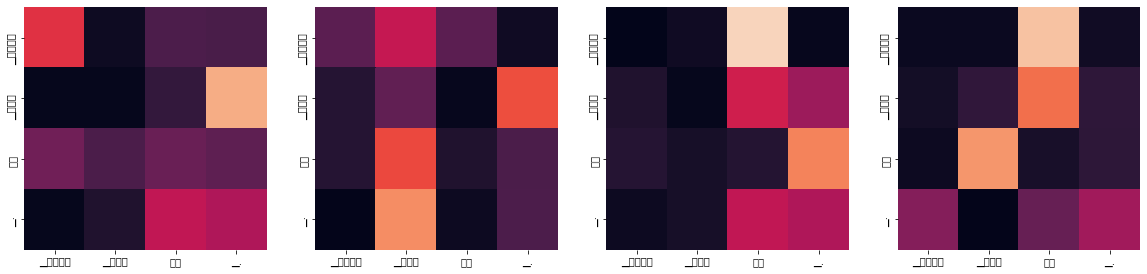

Encoder Layer 2


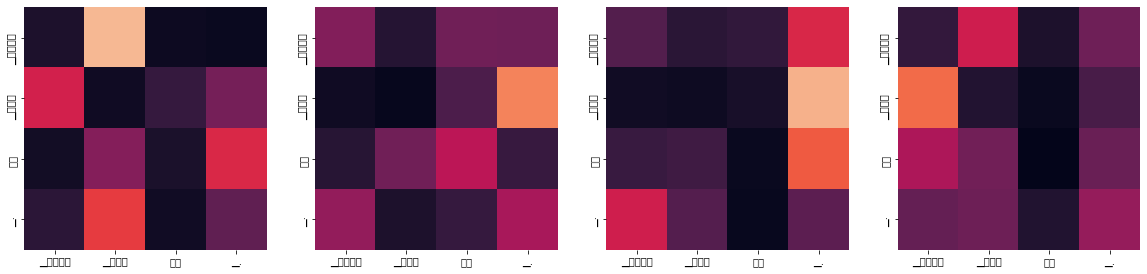

Decoder Self Layer 1


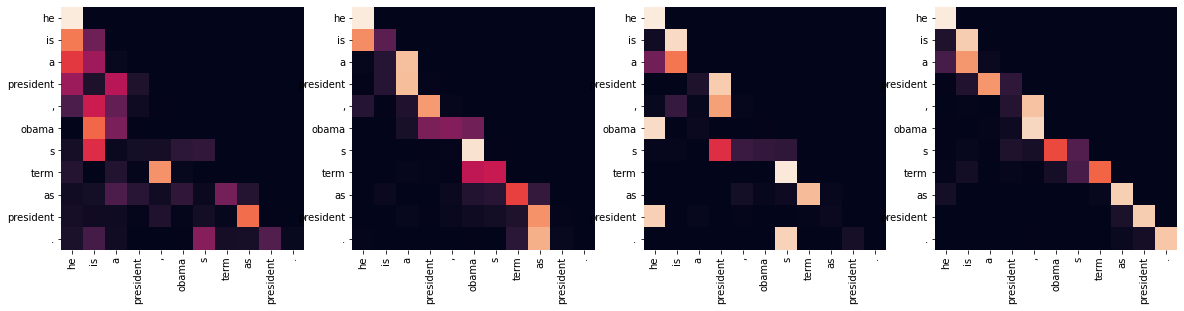

Decoder Src Layer 1


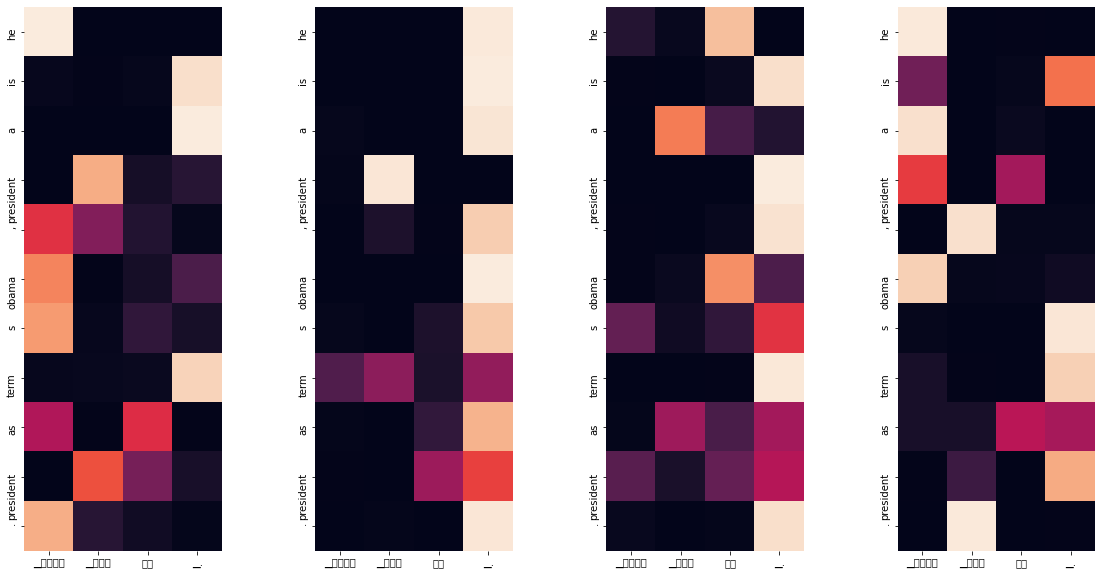

Decoder Self Layer 2


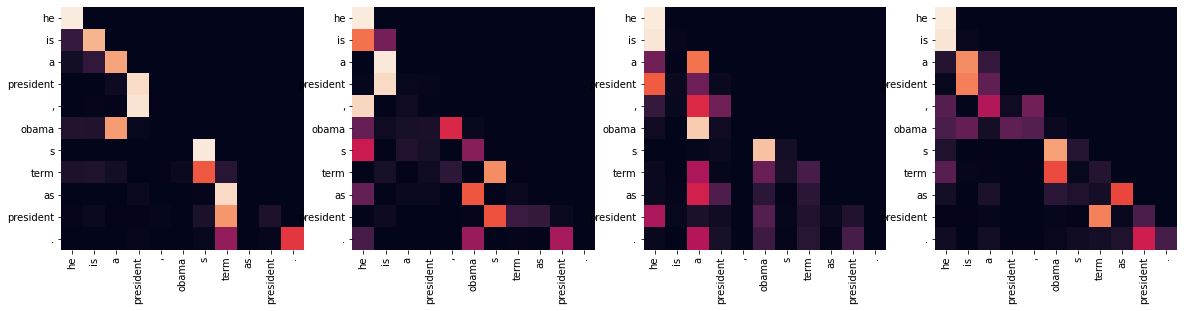

Decoder Src Layer 2


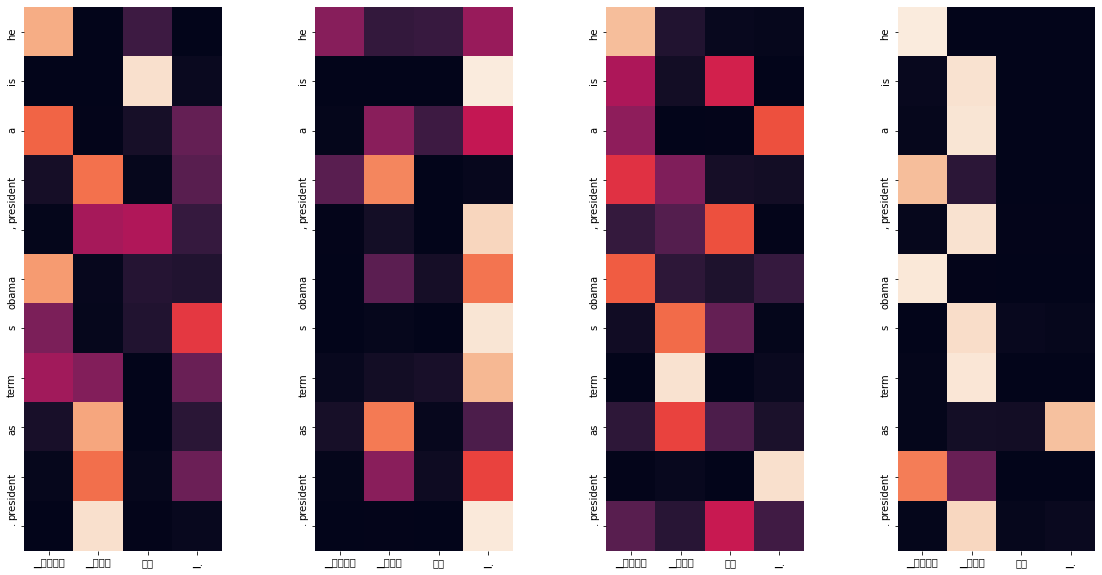

Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are in the city sanca colored city .
Encoder Layer 1


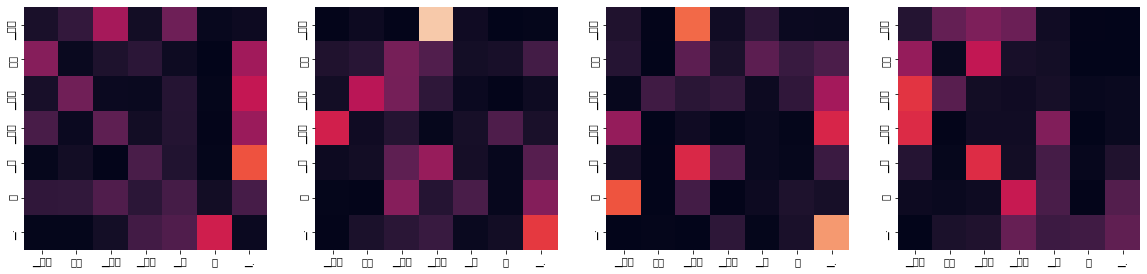

Encoder Layer 2


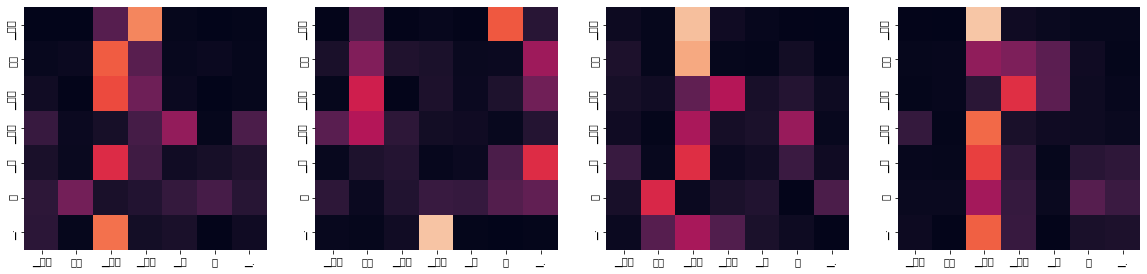

Decoder Self Layer 1


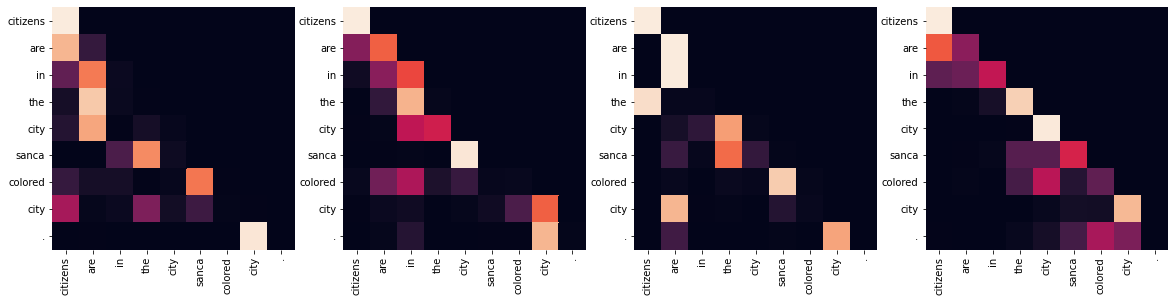

Decoder Src Layer 1


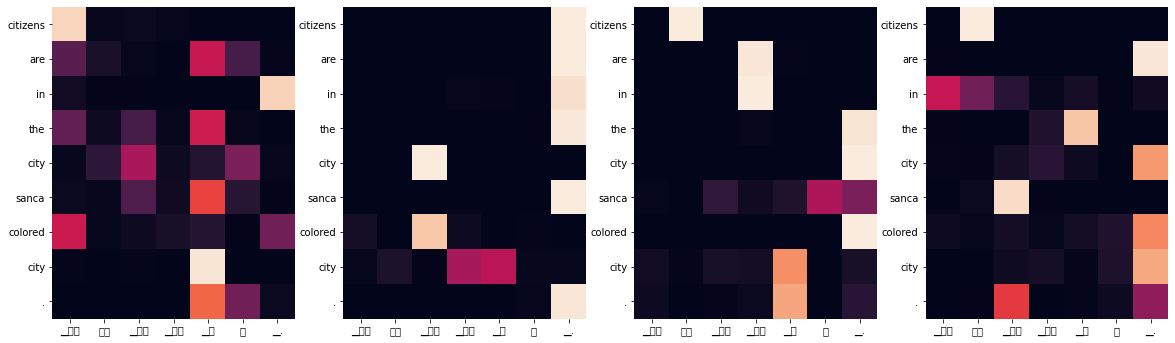

Decoder Self Layer 2


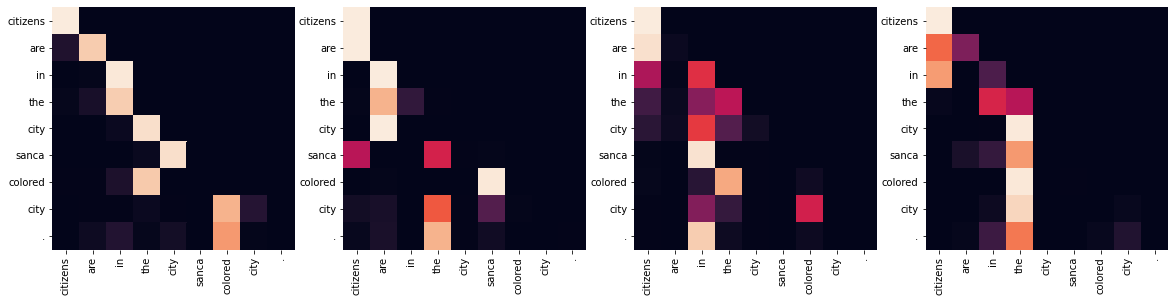

Decoder Src Layer 2


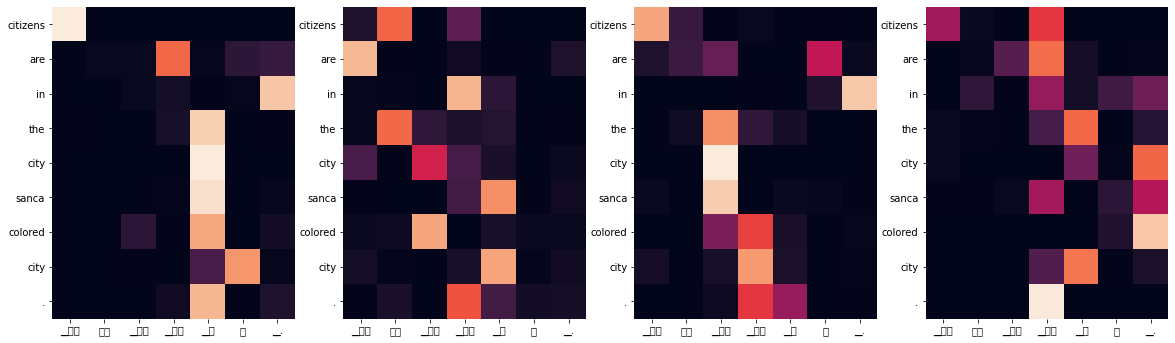

Input: 커피는 필요 없다.
Predicted translation: there are no need for coffee .
Encoder Layer 1


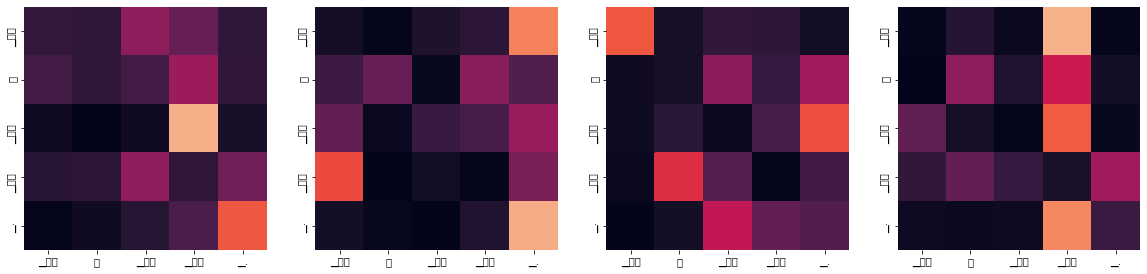

Encoder Layer 2


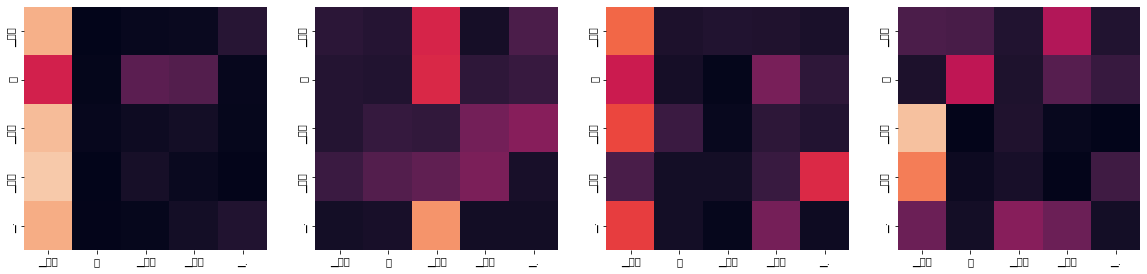

Decoder Self Layer 1


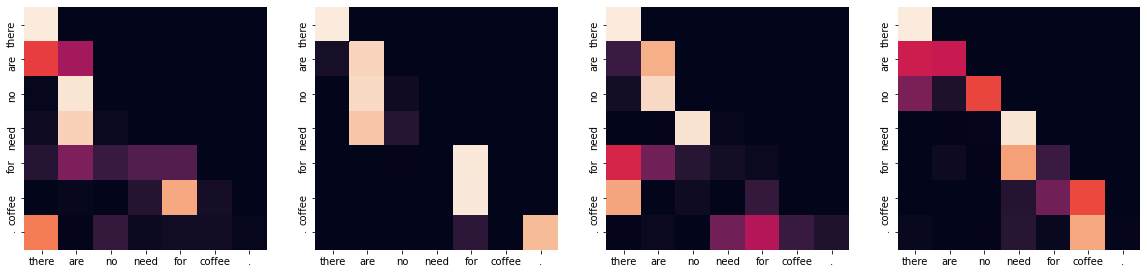

Decoder Src Layer 1


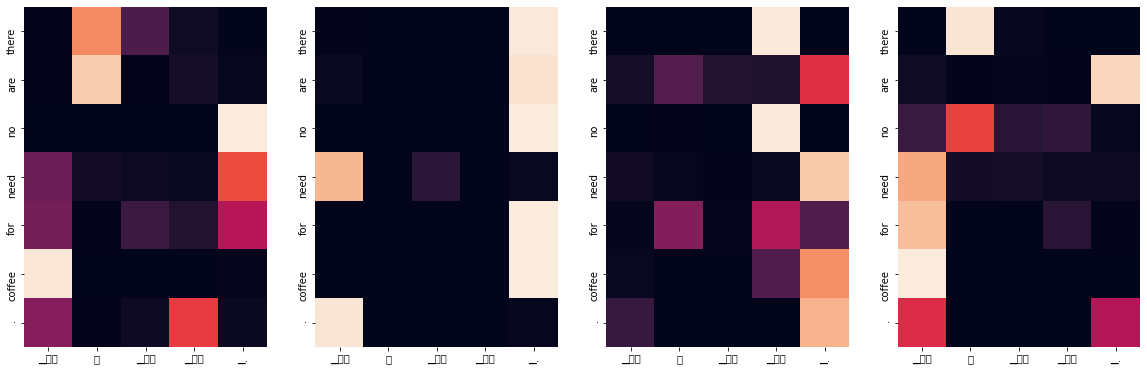

Decoder Self Layer 2


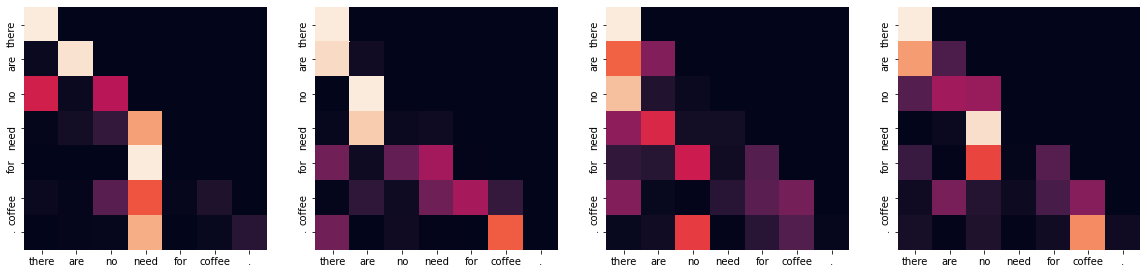

Decoder Src Layer 2


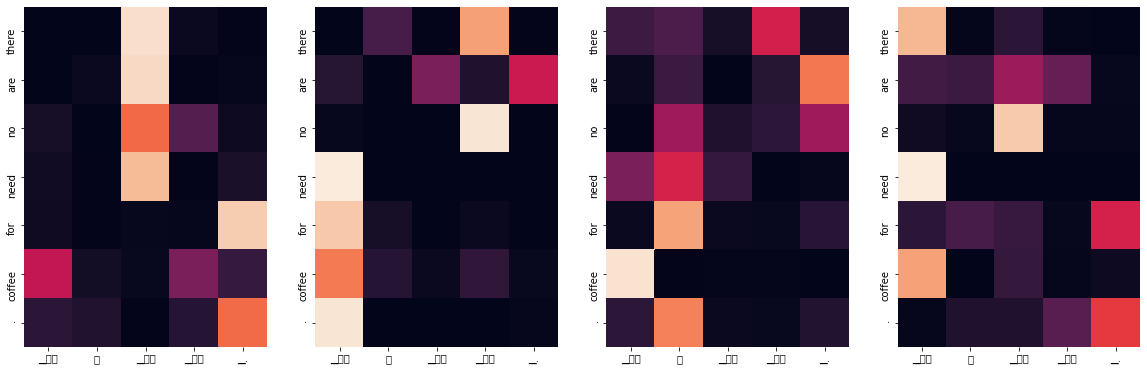

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were killed .
Encoder Layer 1


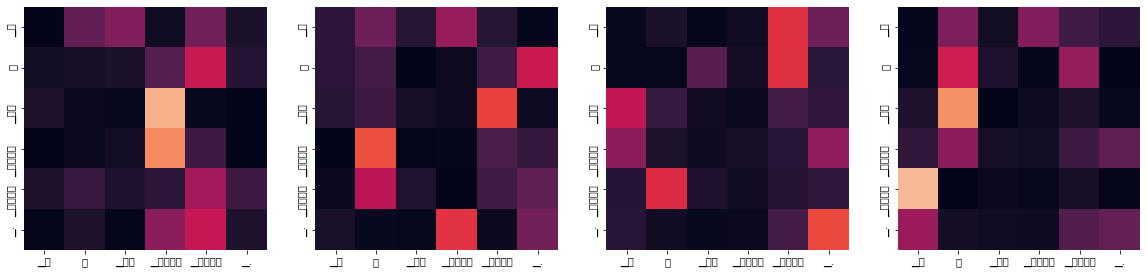

Encoder Layer 2


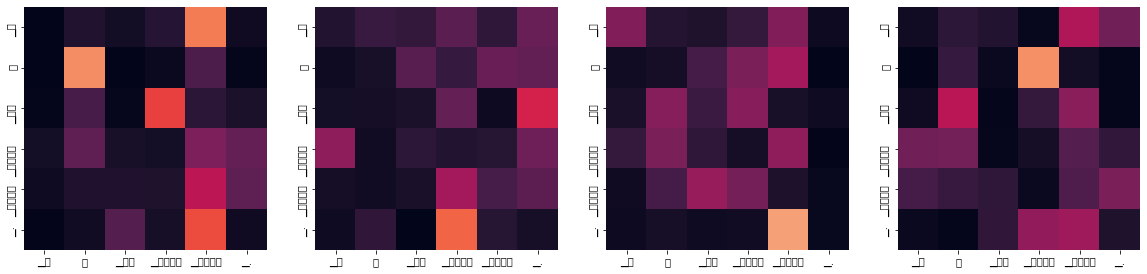

Decoder Self Layer 1


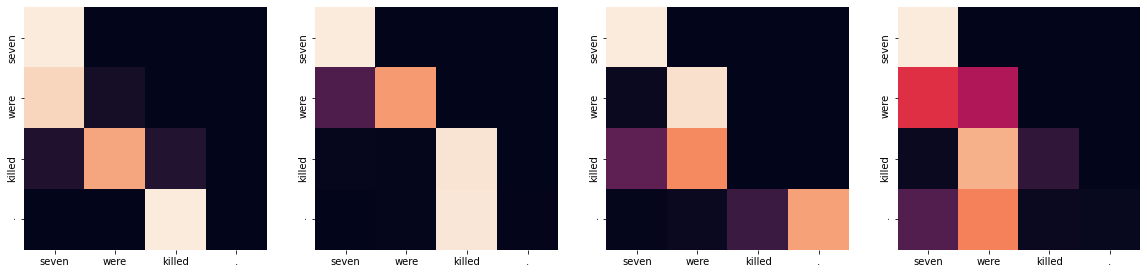

Decoder Src Layer 1


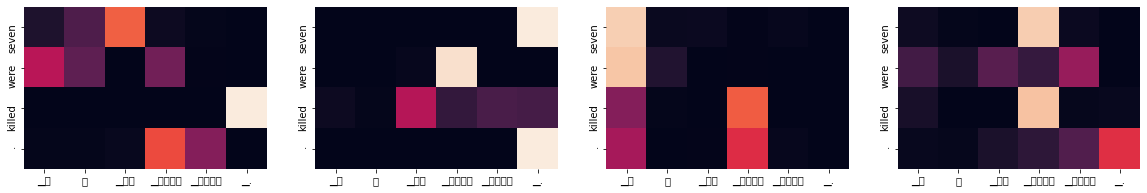

Decoder Self Layer 2


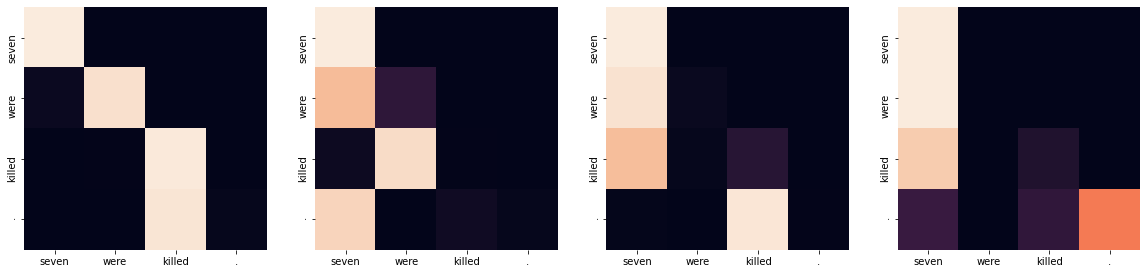

Decoder Src Layer 2


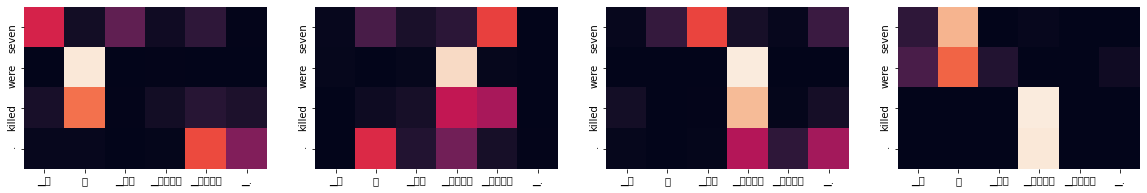

  0%|          | 0/909 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he s president .
Encoder Layer 1


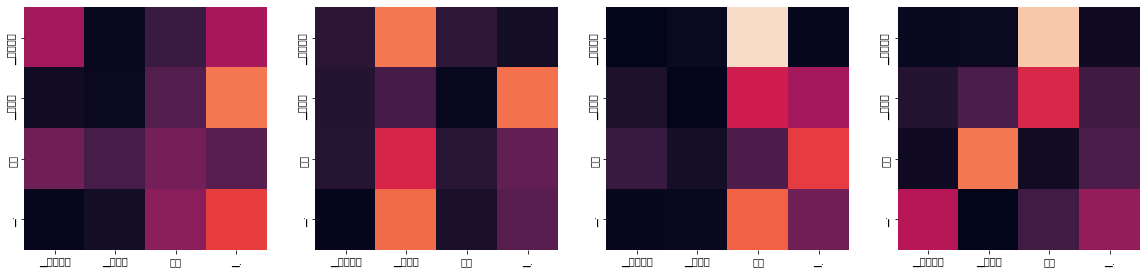

Encoder Layer 2


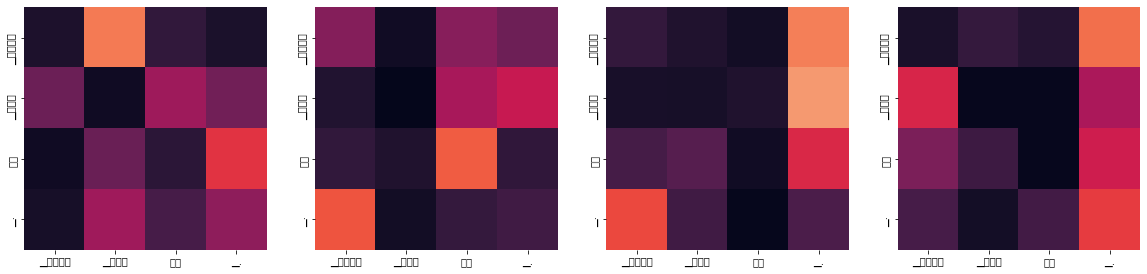

Decoder Self Layer 1


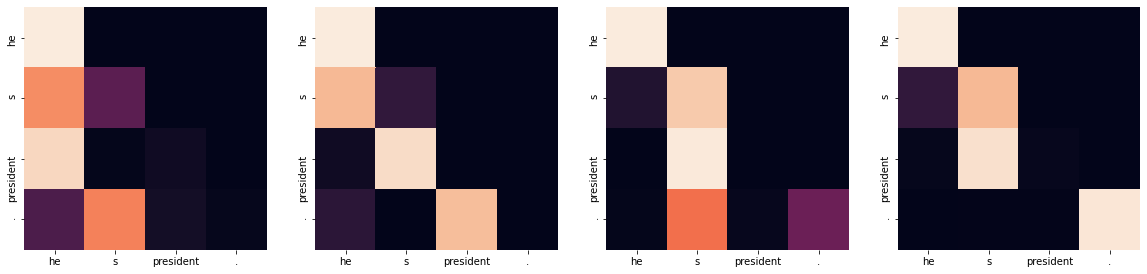

Decoder Src Layer 1


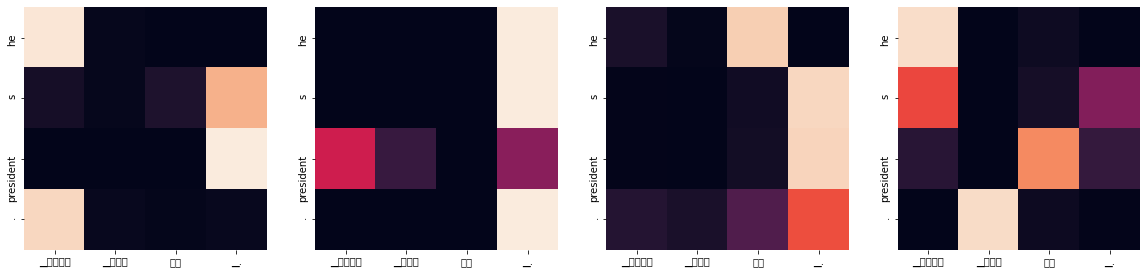

Decoder Self Layer 2


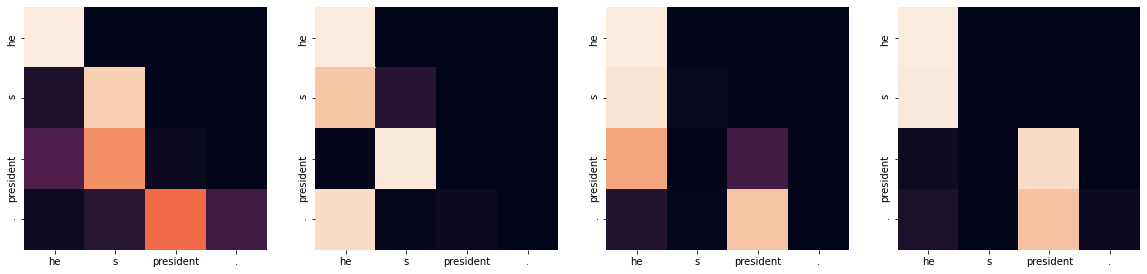

Decoder Src Layer 2


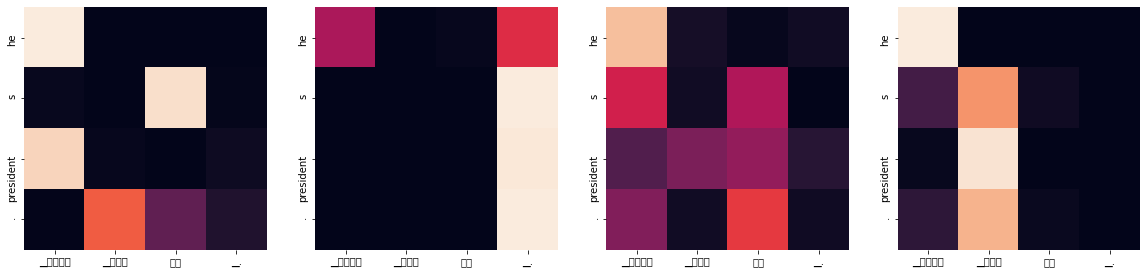

Input: 시민들은 도시 속에 산다.
Predicted translation: civilians are among the city in the city .
Encoder Layer 1


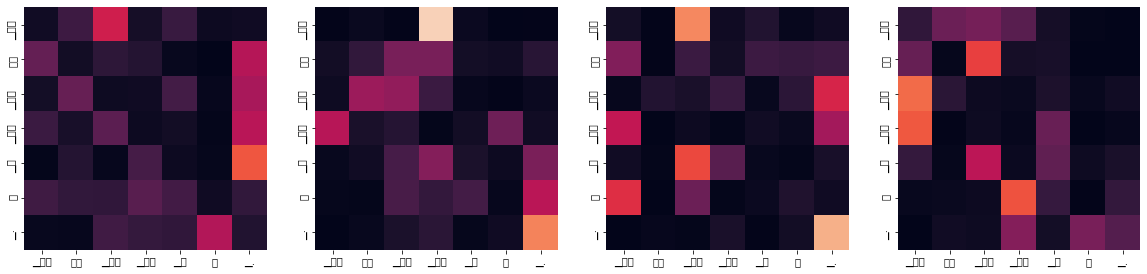

Encoder Layer 2


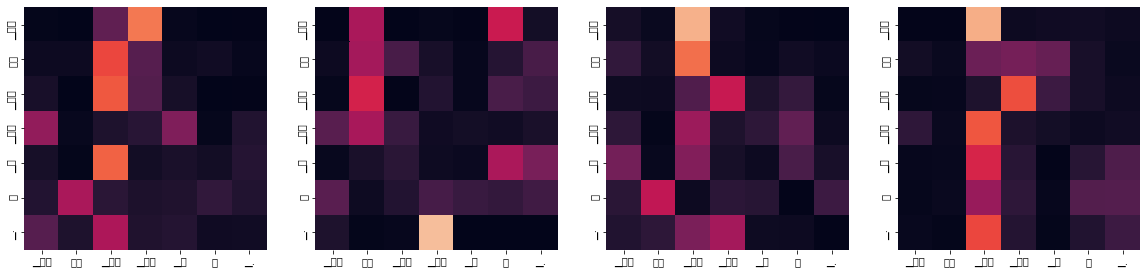

Decoder Self Layer 1


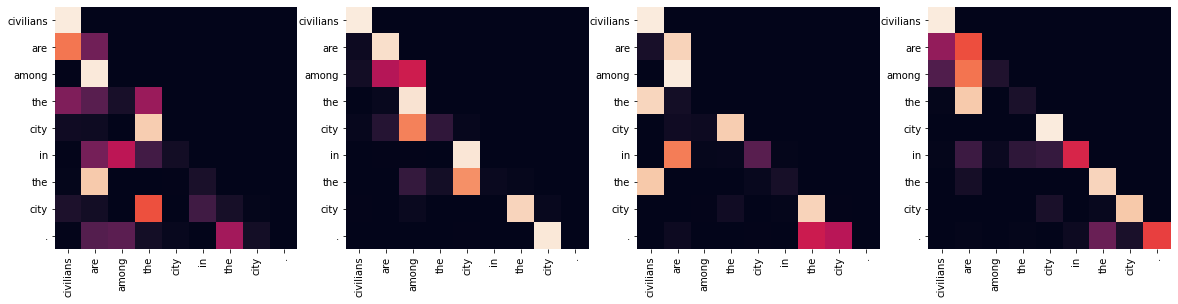

Decoder Src Layer 1


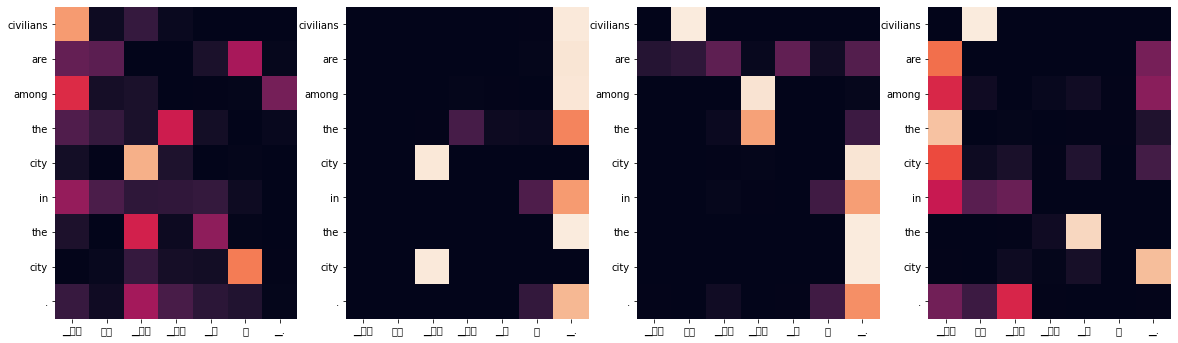

Decoder Self Layer 2


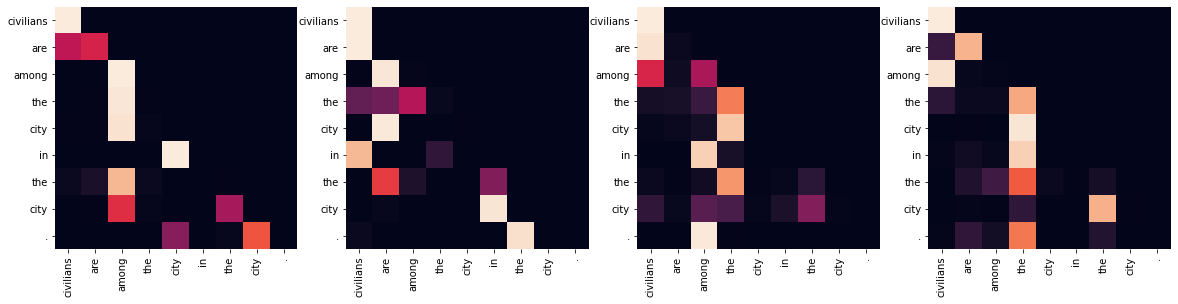

Decoder Src Layer 2


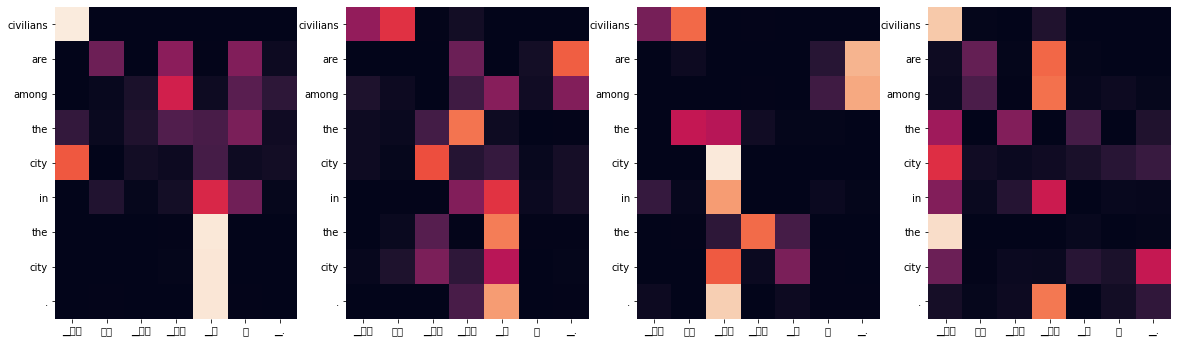

Input: 커피는 필요 없다.
Predicted translation: there is a coffee one thing , but i don t think we ve won thing a good thing .
Encoder Layer 1


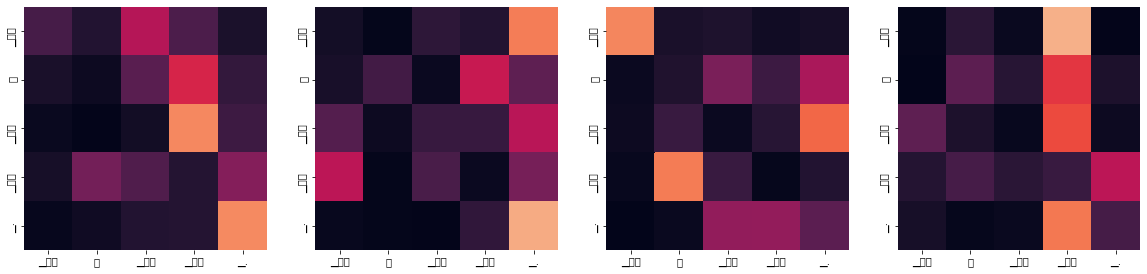

Encoder Layer 2


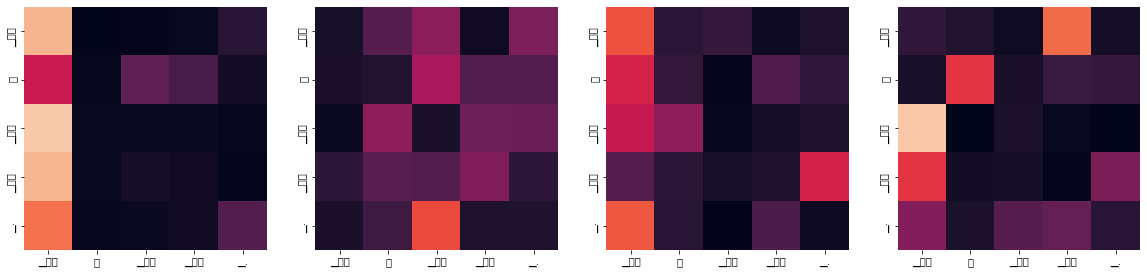

Decoder Self Layer 1


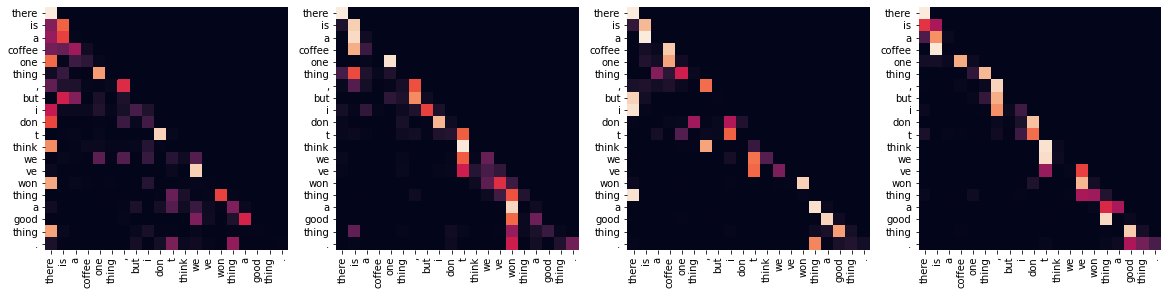

Decoder Src Layer 1


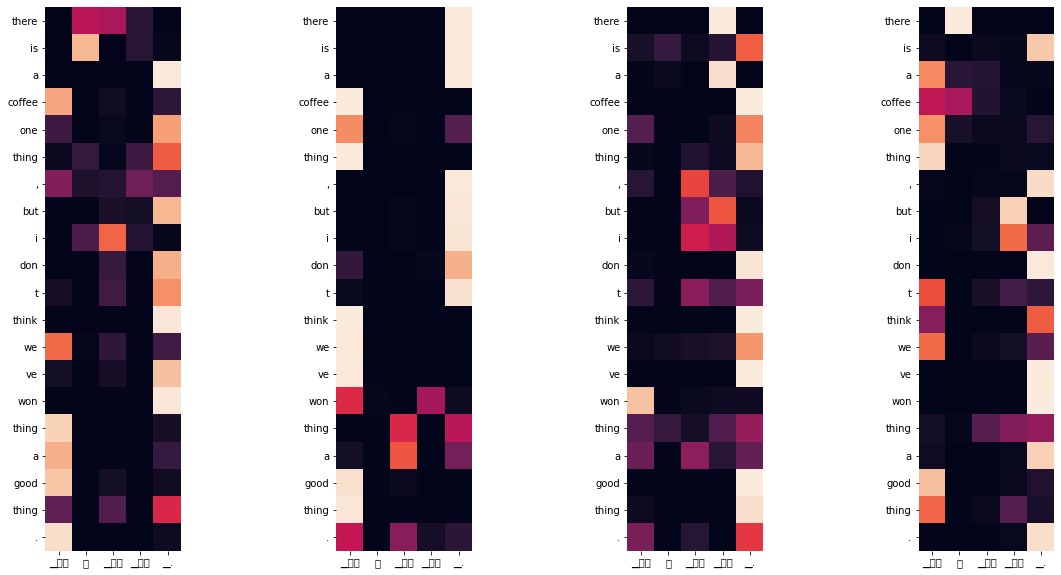

Decoder Self Layer 2


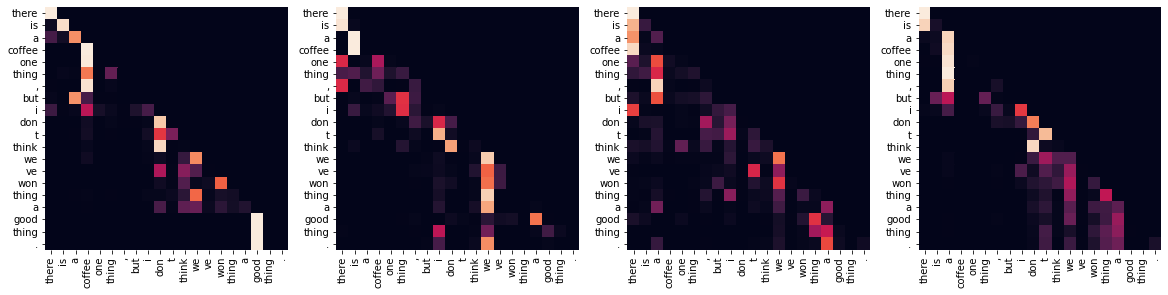

Decoder Src Layer 2


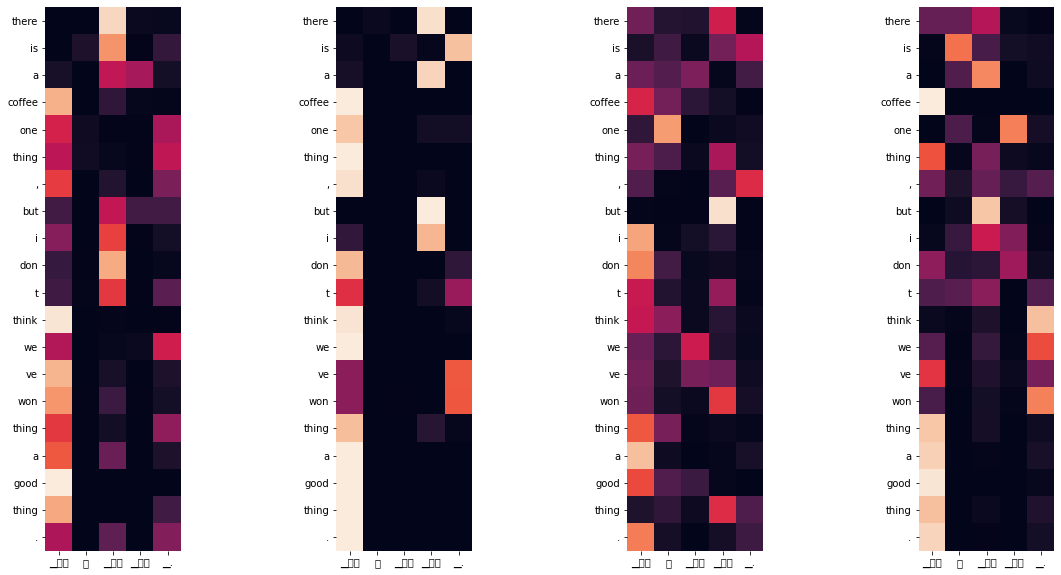

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: it was reported killed in the seven were .
Encoder Layer 1


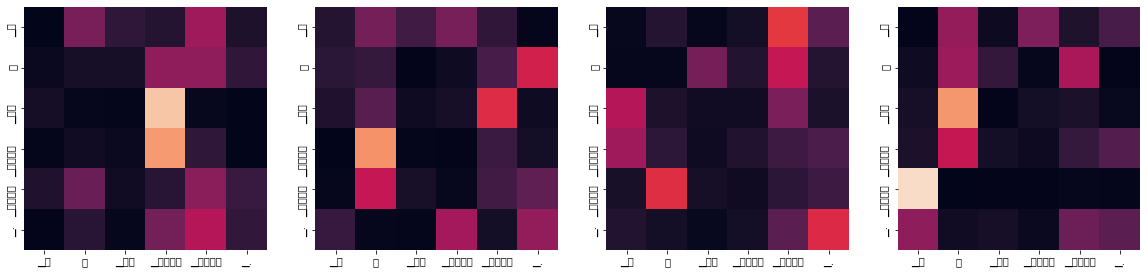

Encoder Layer 2


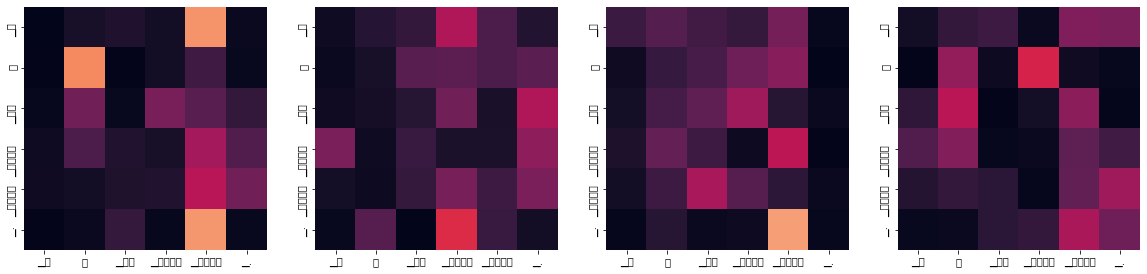

Decoder Self Layer 1


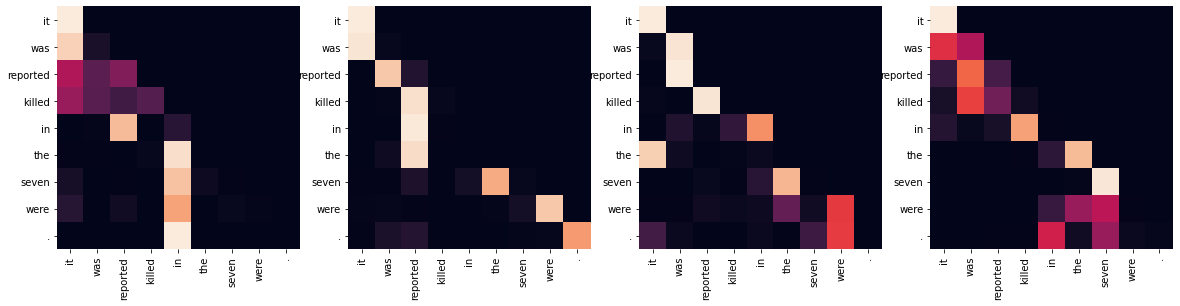

Decoder Src Layer 1


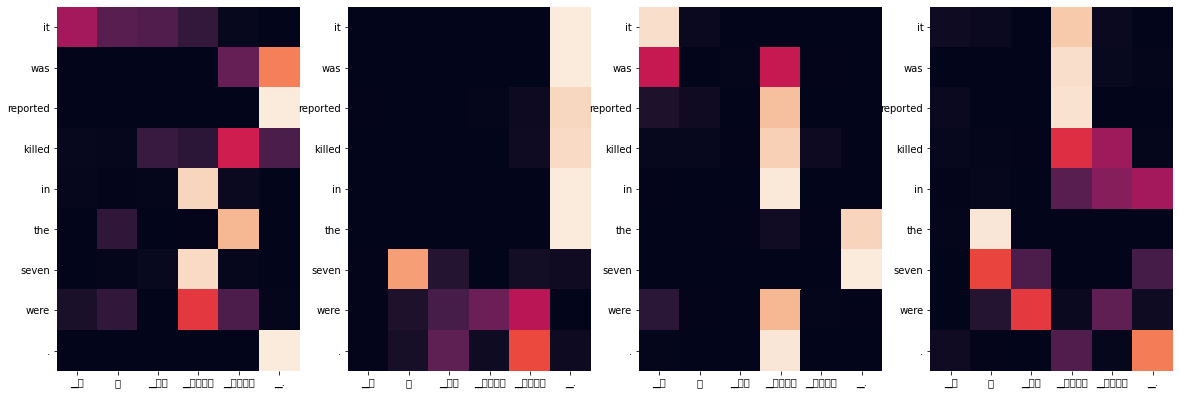

Decoder Self Layer 2


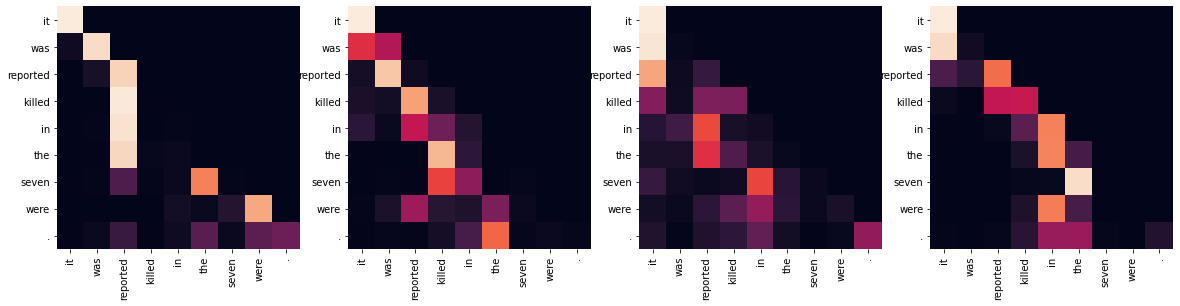

Decoder Src Layer 2


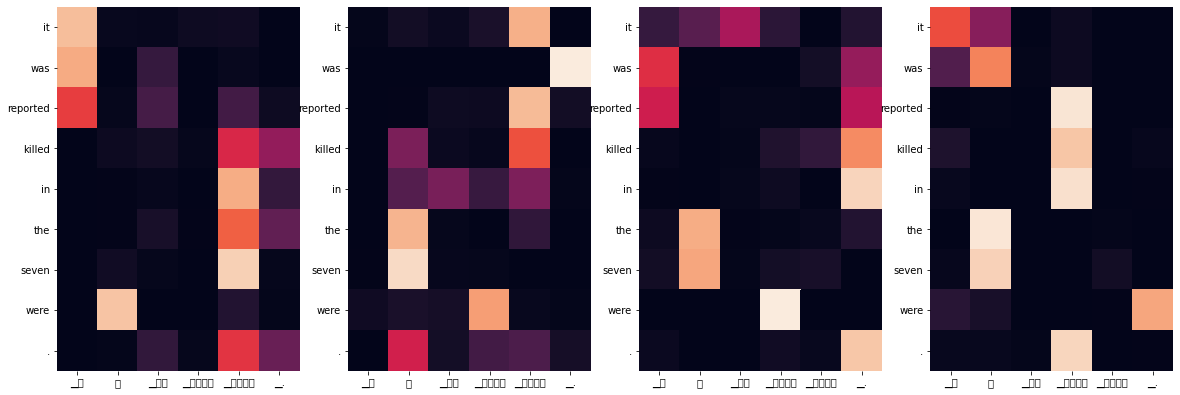

  0%|          | 0/909 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he is the presidential candidate of the president .
Encoder Layer 1


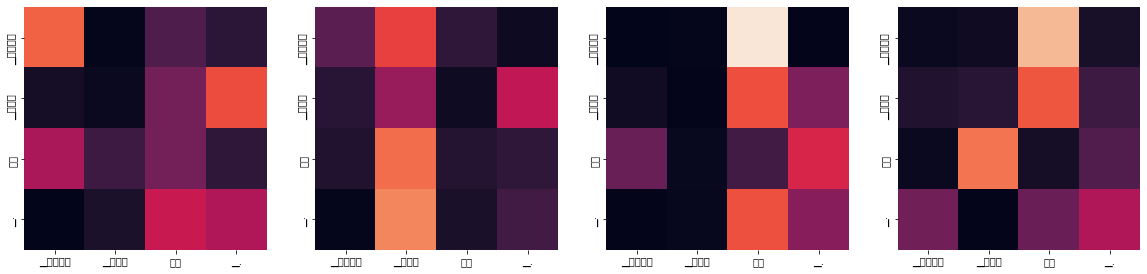

Encoder Layer 2


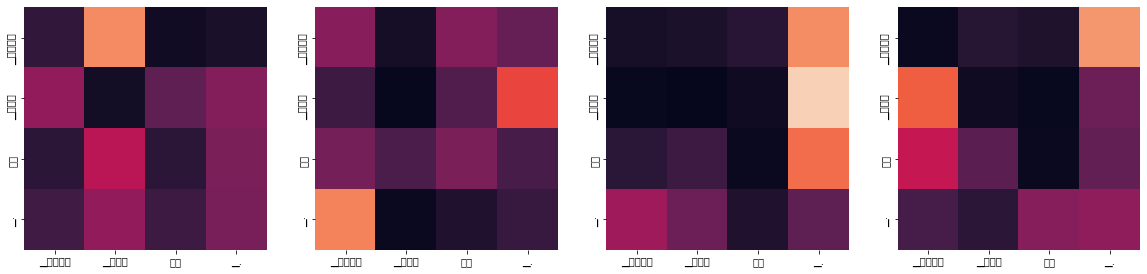

Decoder Self Layer 1


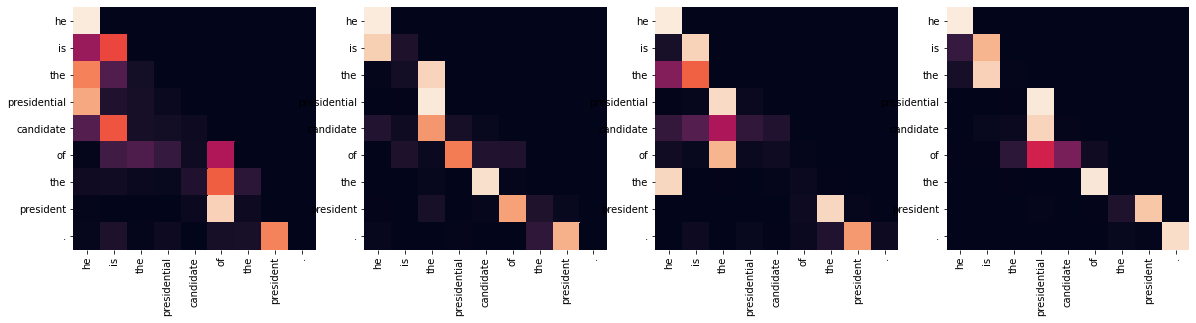

Decoder Src Layer 1


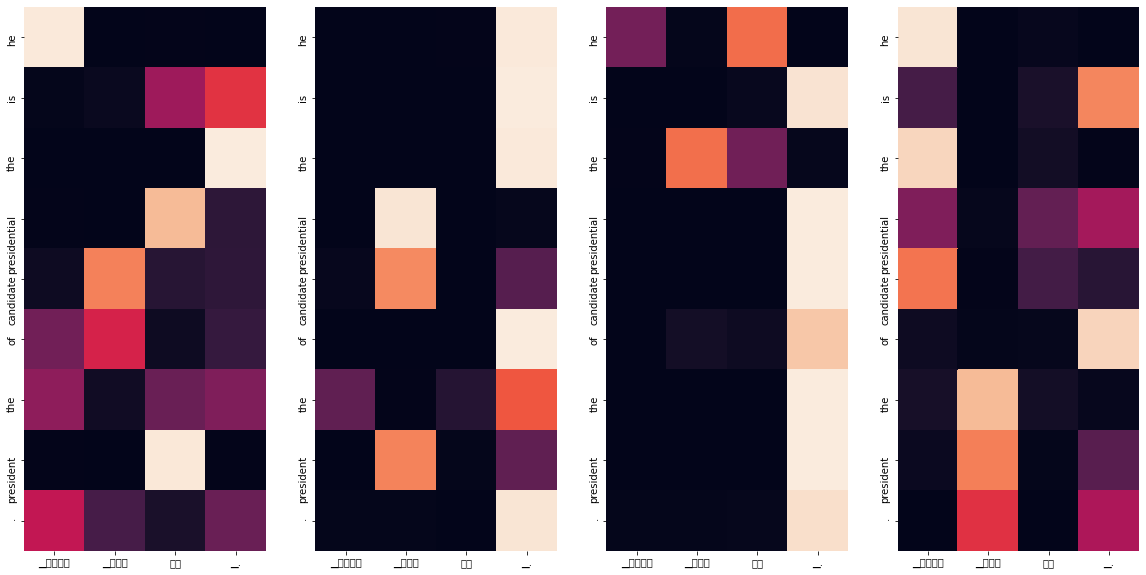

Decoder Self Layer 2


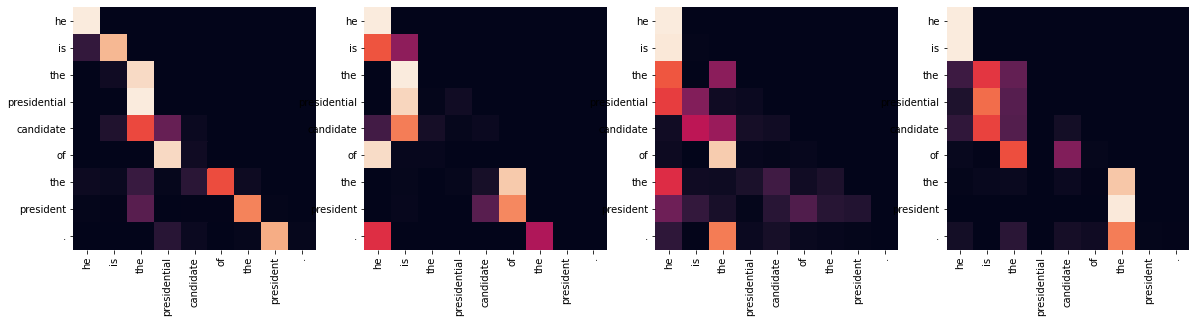

Decoder Src Layer 2


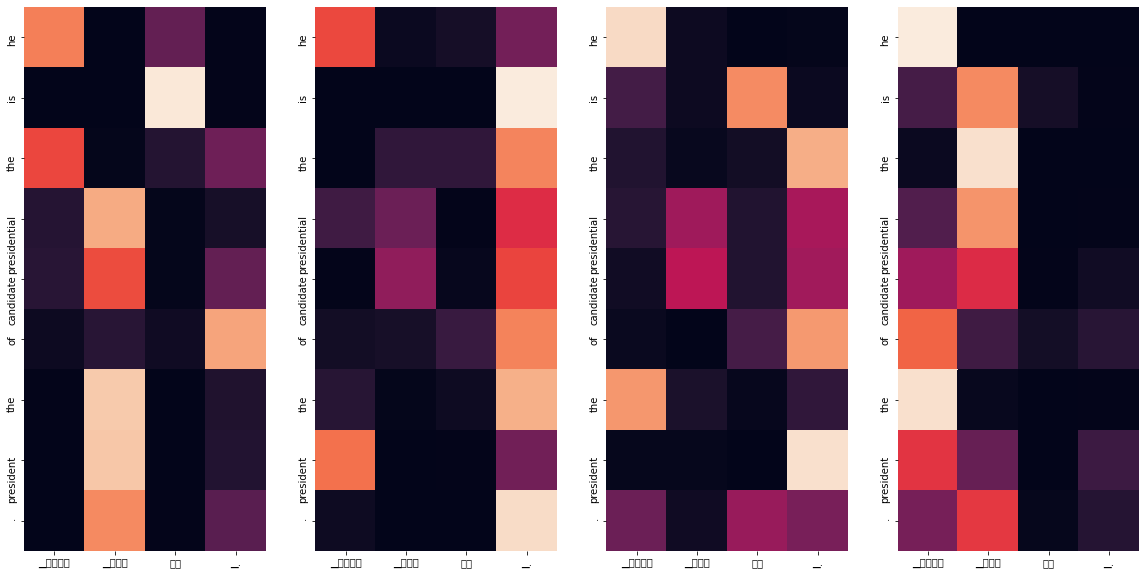

Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the city of city are naval cities .
Encoder Layer 1


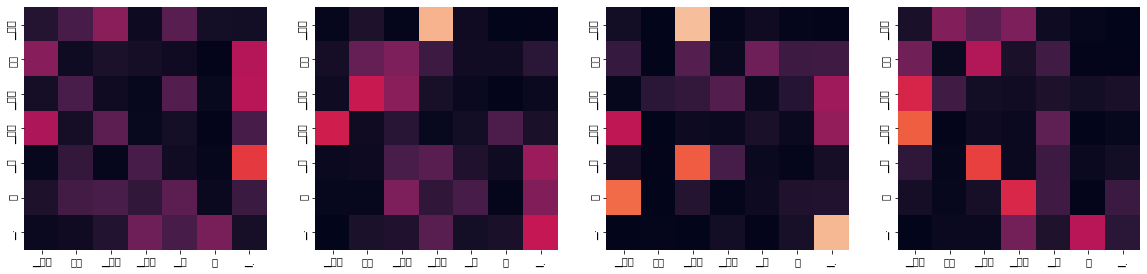

Encoder Layer 2


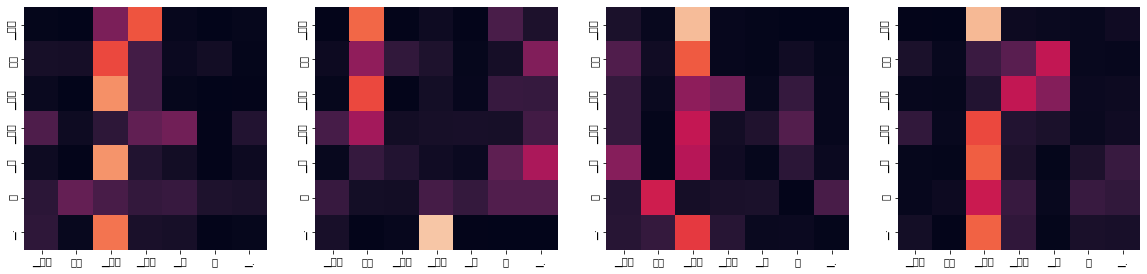

Decoder Self Layer 1


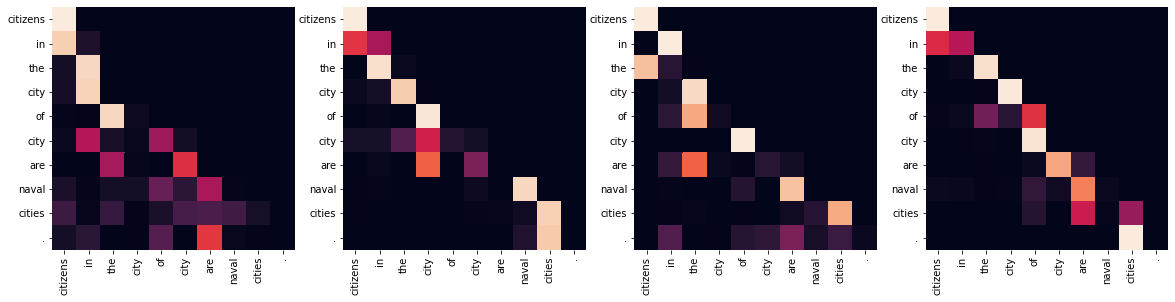

Decoder Src Layer 1


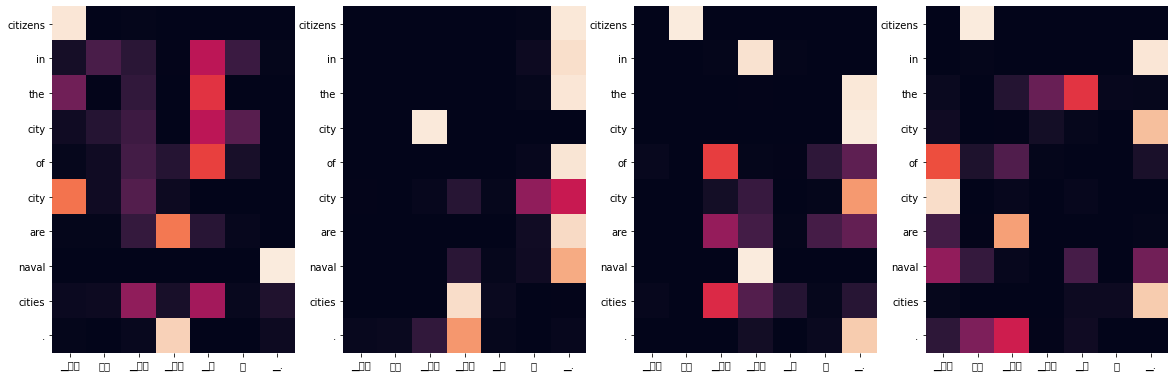

Decoder Self Layer 2


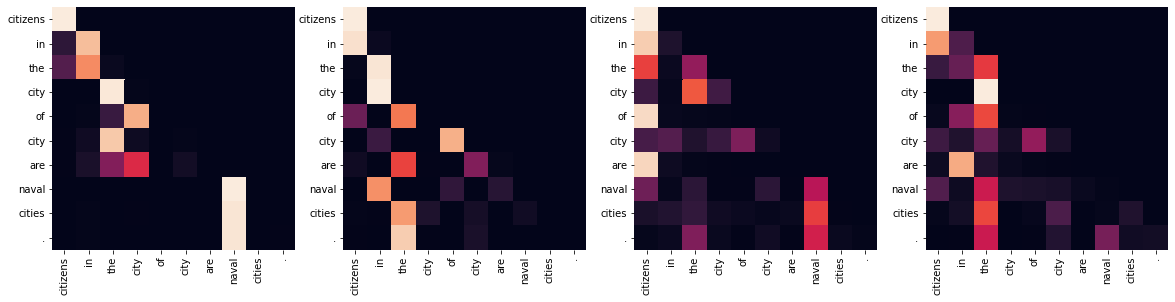

Decoder Src Layer 2


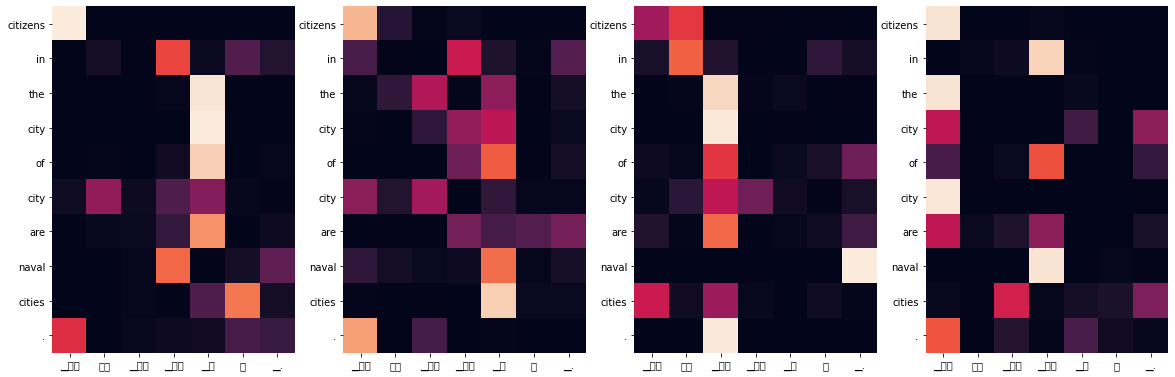

Input: 커피는 필요 없다.
Predicted translation: there is a coffee tim don t thinkable coffee is a coffee thing .
Encoder Layer 1


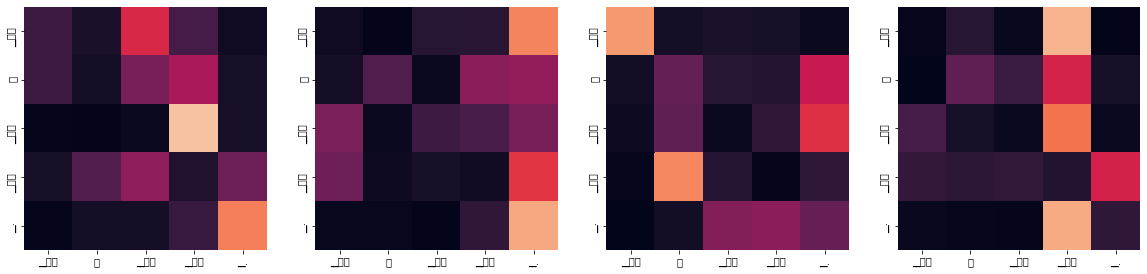

Encoder Layer 2


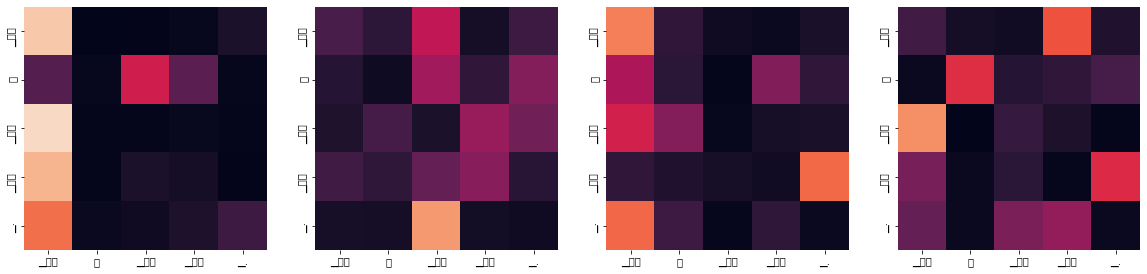

Decoder Self Layer 1


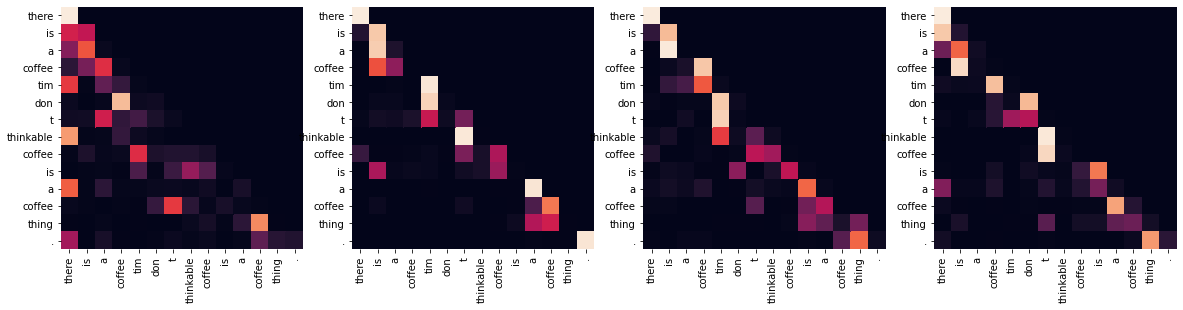

Decoder Src Layer 1


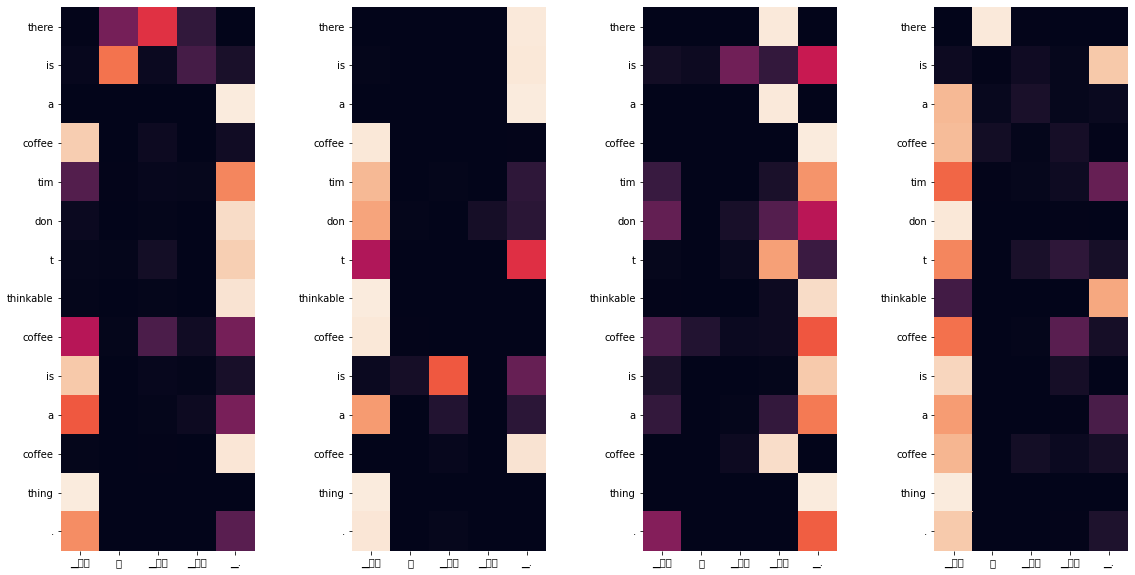

Decoder Self Layer 2


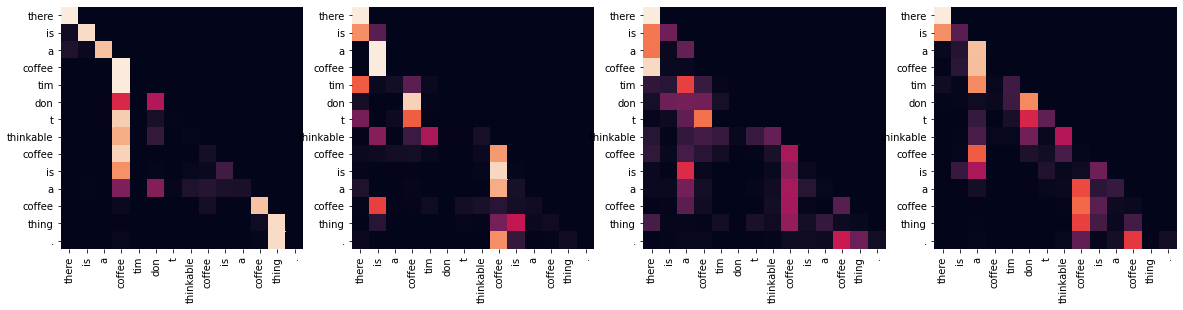

Decoder Src Layer 2


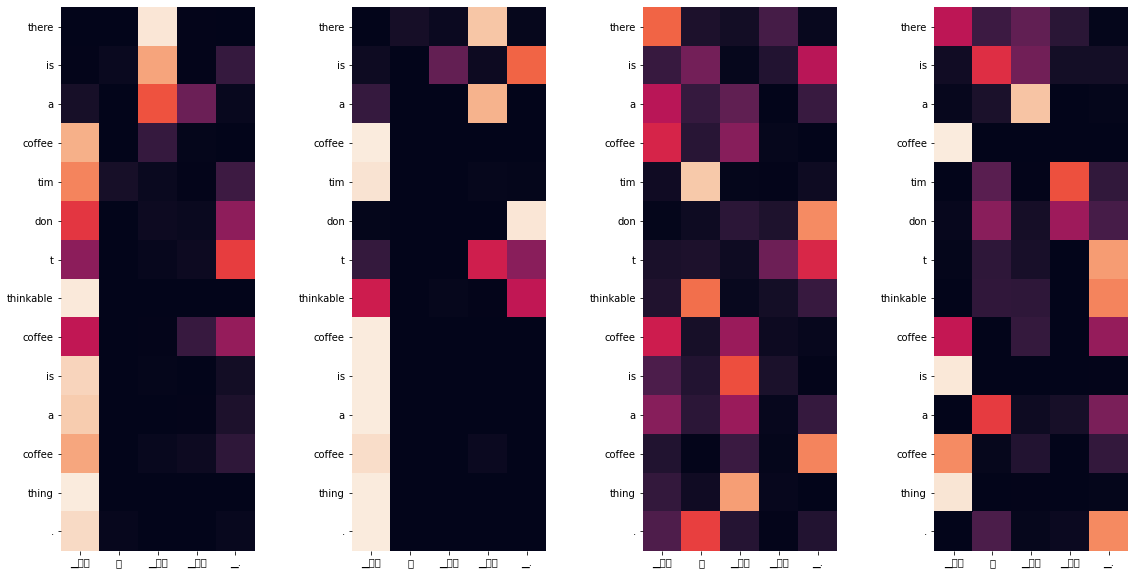

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were reported in the seven were accident .
Encoder Layer 1


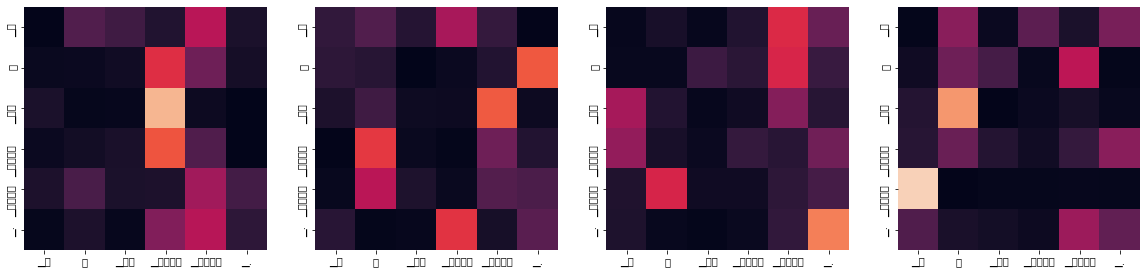

Encoder Layer 2


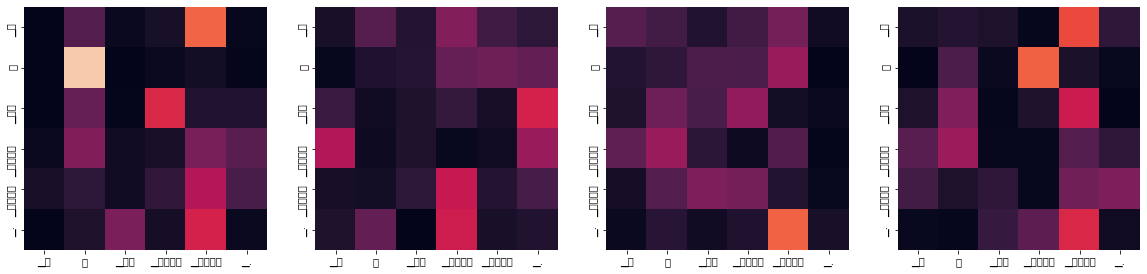

Decoder Self Layer 1


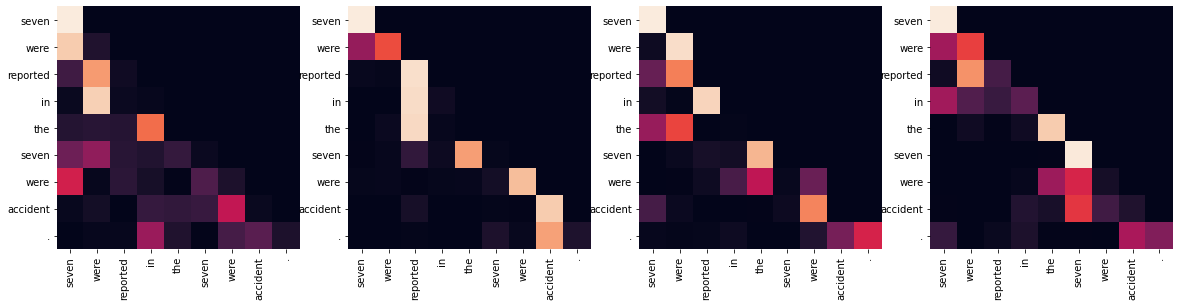

Decoder Src Layer 1


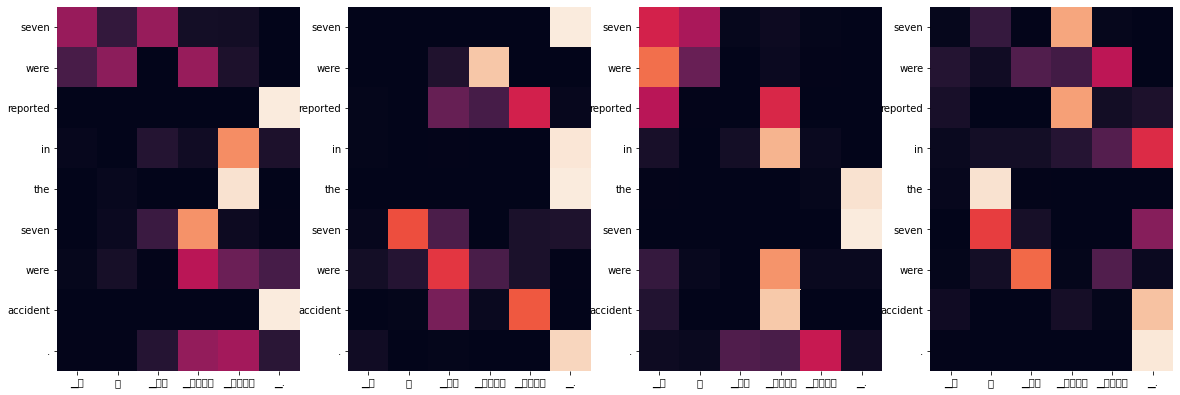

Decoder Self Layer 2


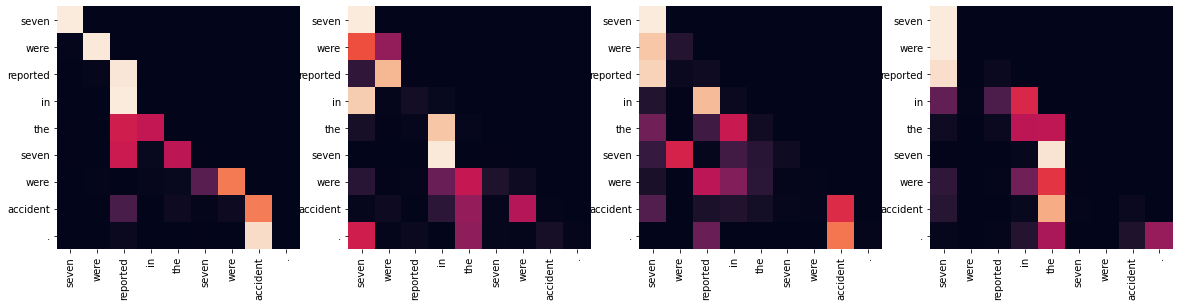

Decoder Src Layer 2


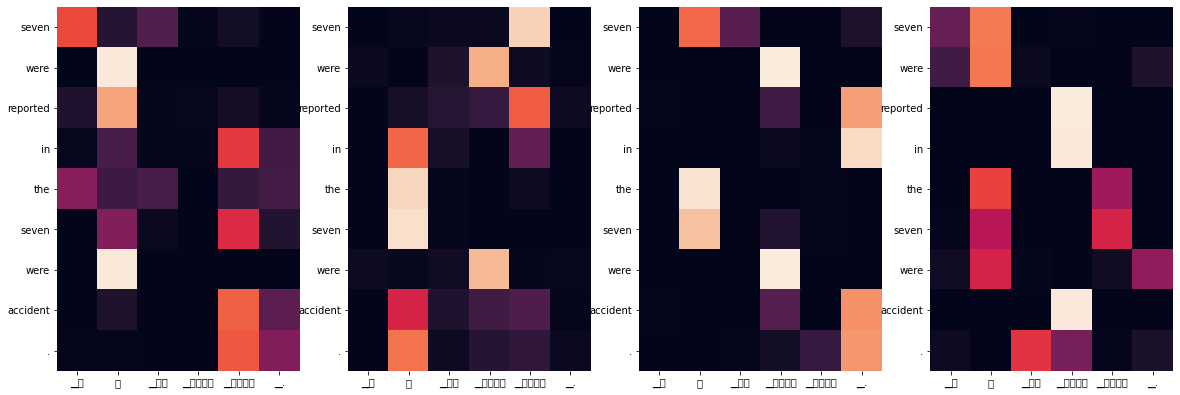

  0%|          | 0/909 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he is a president of the late president .
Encoder Layer 1


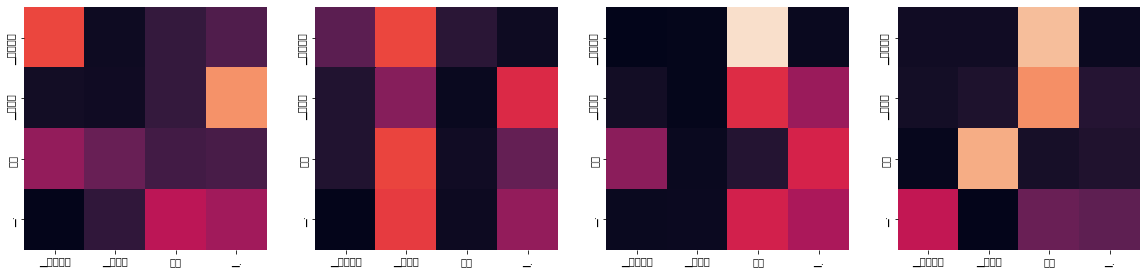

Encoder Layer 2


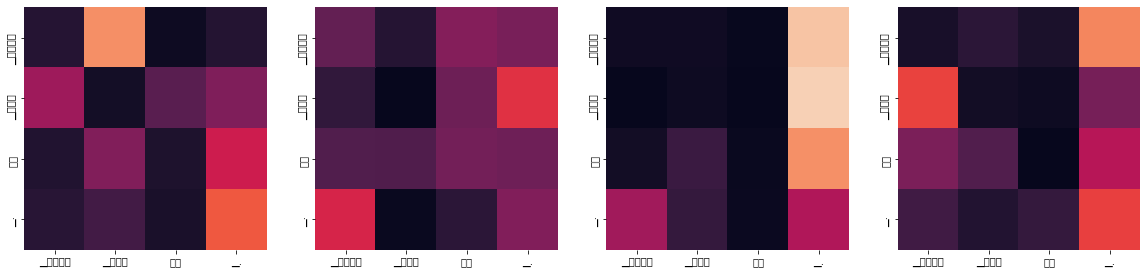

Decoder Self Layer 1


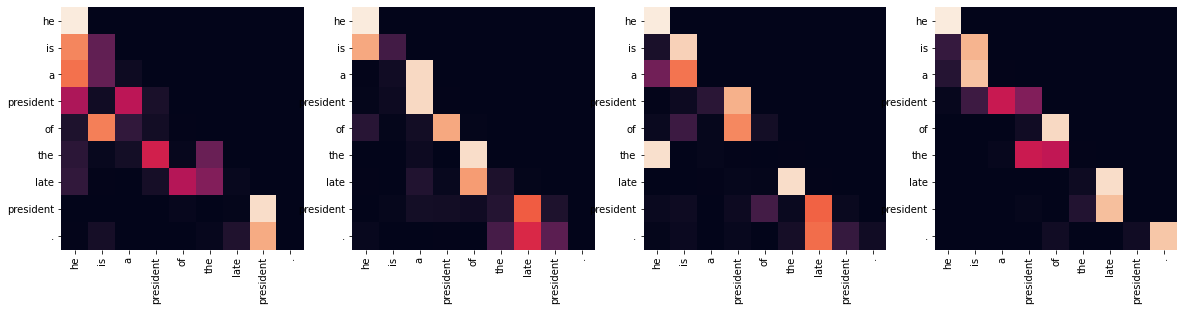

Decoder Src Layer 1


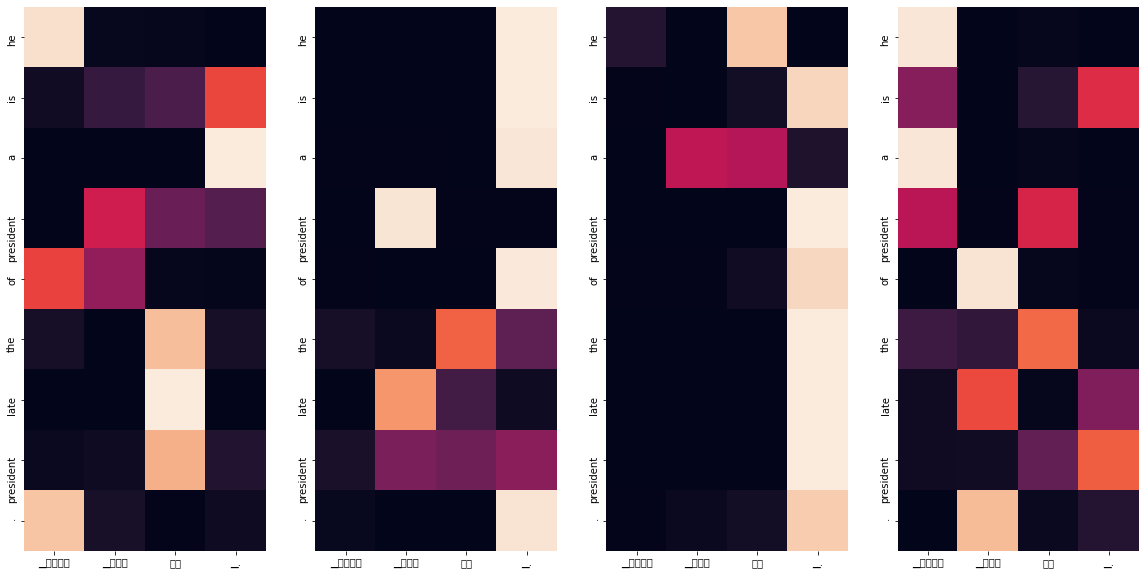

Decoder Self Layer 2


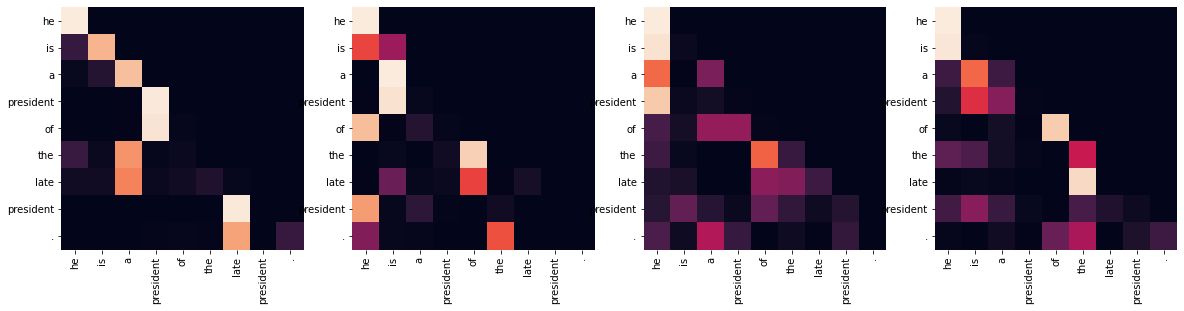

Decoder Src Layer 2


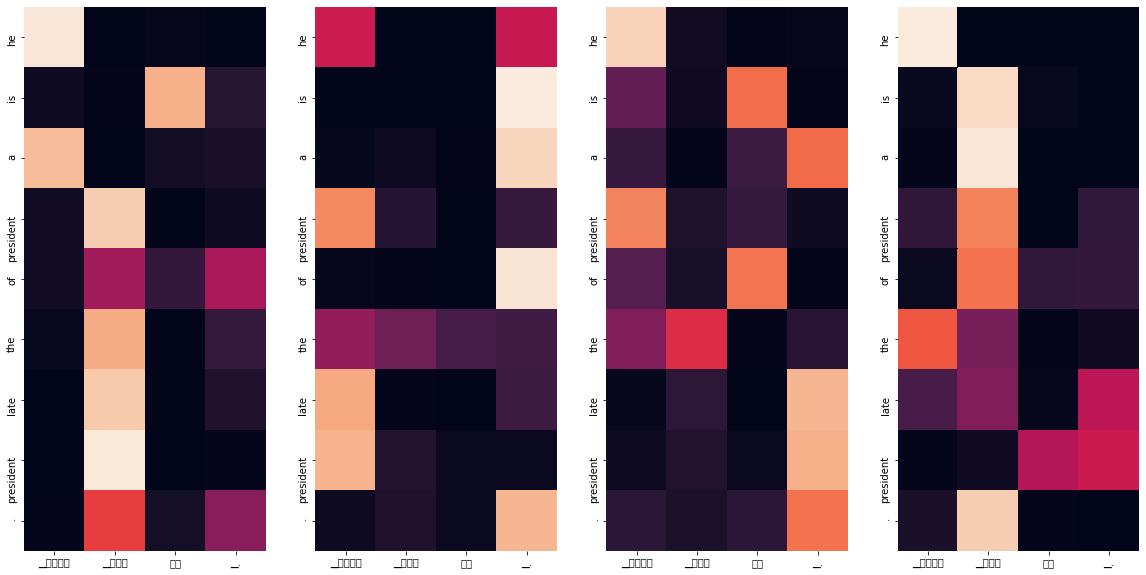

Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the city cities are caught in the rest .
Encoder Layer 1


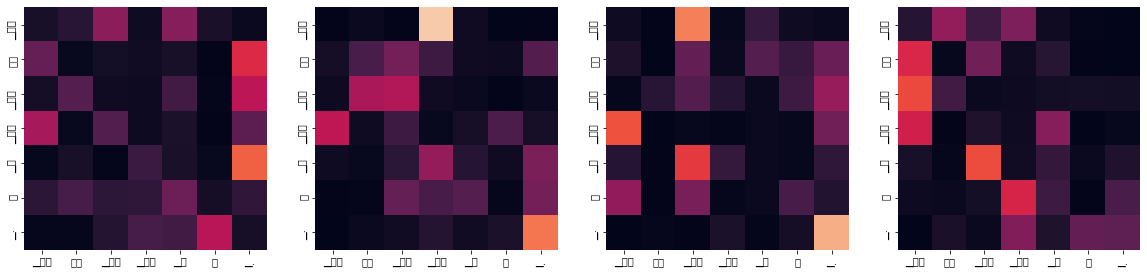

Encoder Layer 2


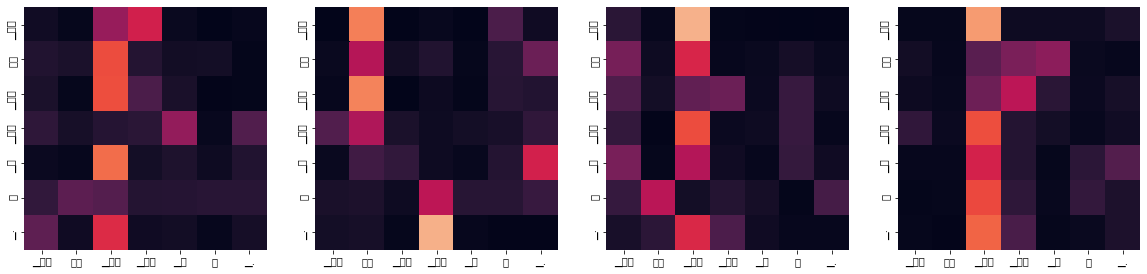

Decoder Self Layer 1


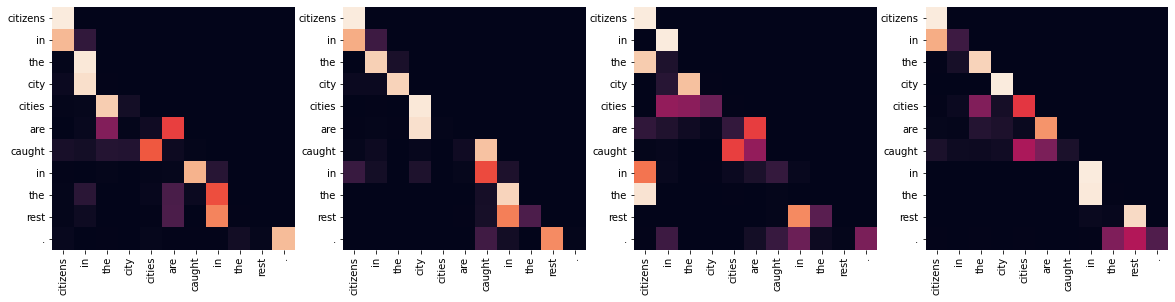

Decoder Src Layer 1


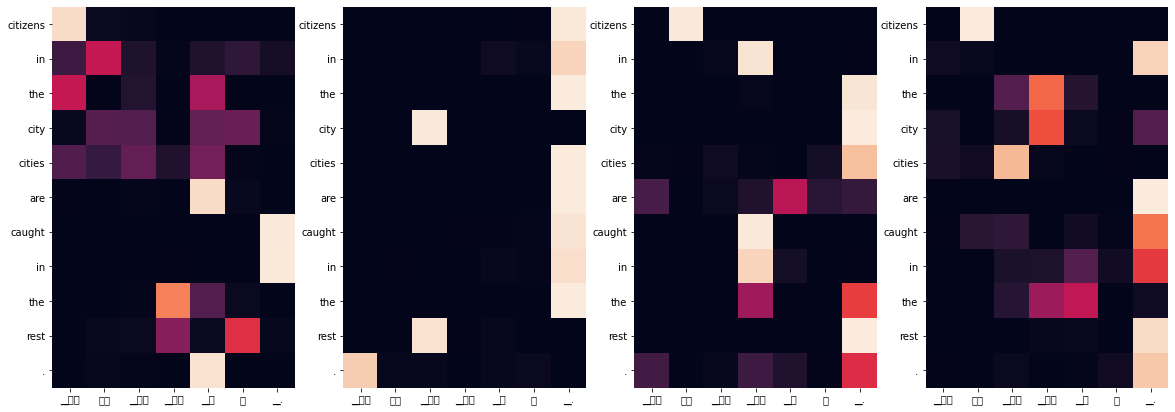

Decoder Self Layer 2


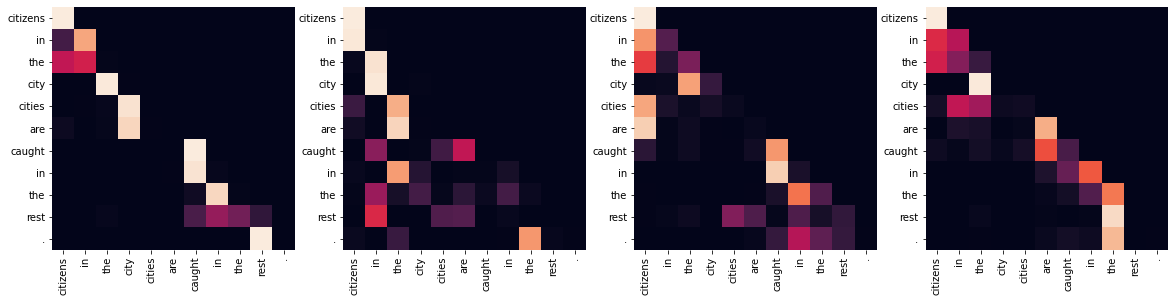

Decoder Src Layer 2


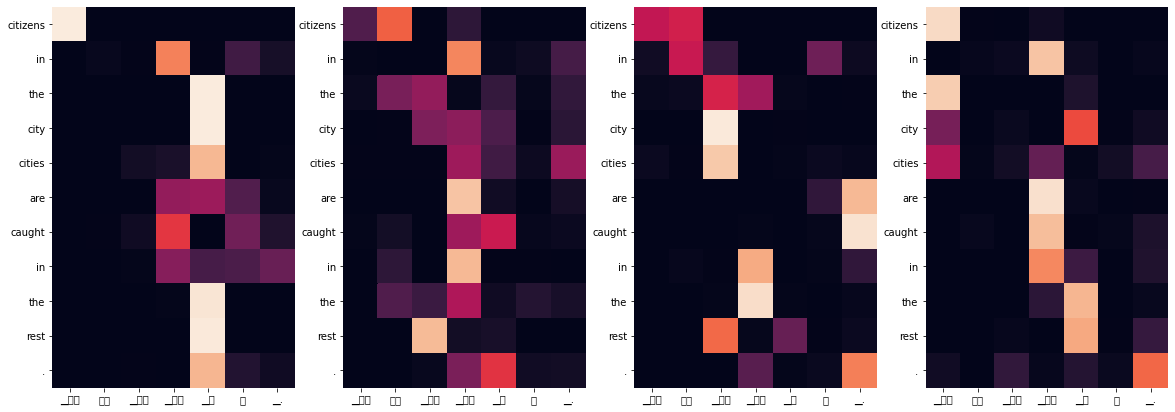

Input: 커피는 필요 없다.
Predicted translation: there is no price mass increased , there is no increased coffee .
Encoder Layer 1


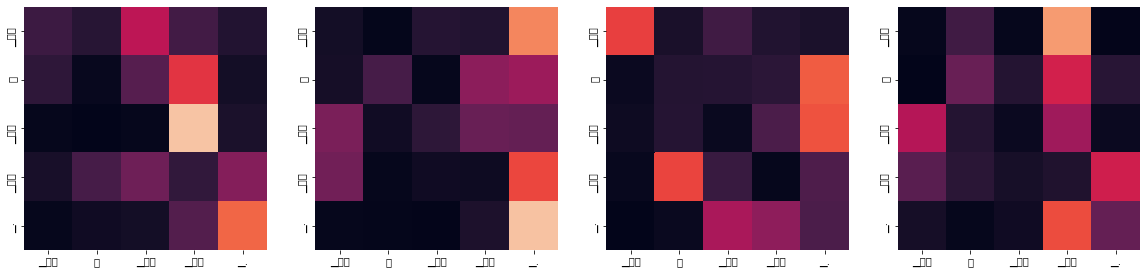

Encoder Layer 2


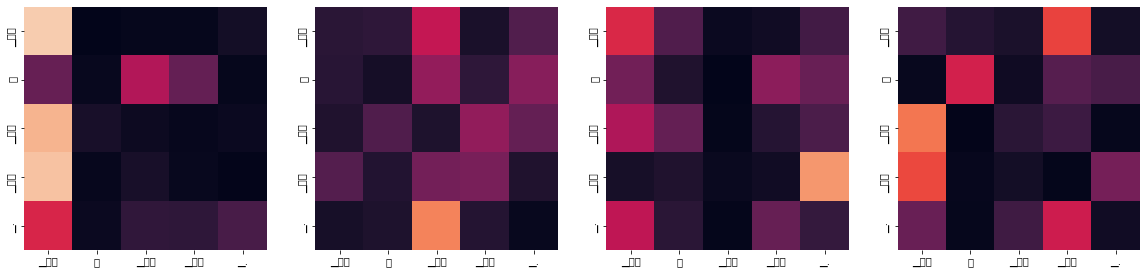

Decoder Self Layer 1


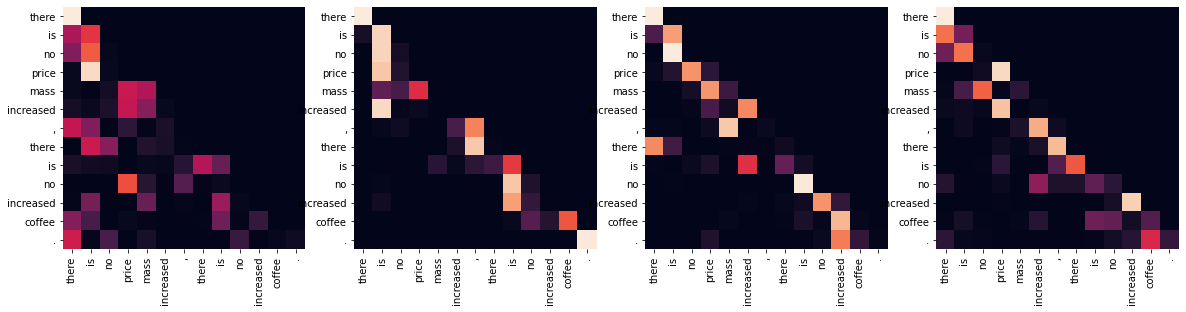

Decoder Src Layer 1


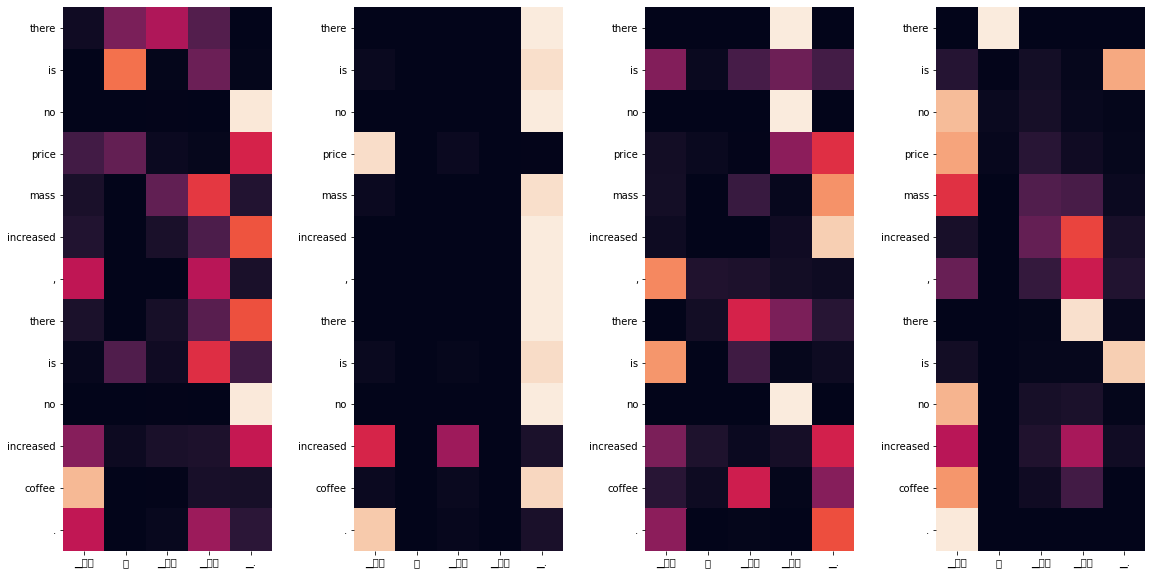

Decoder Self Layer 2


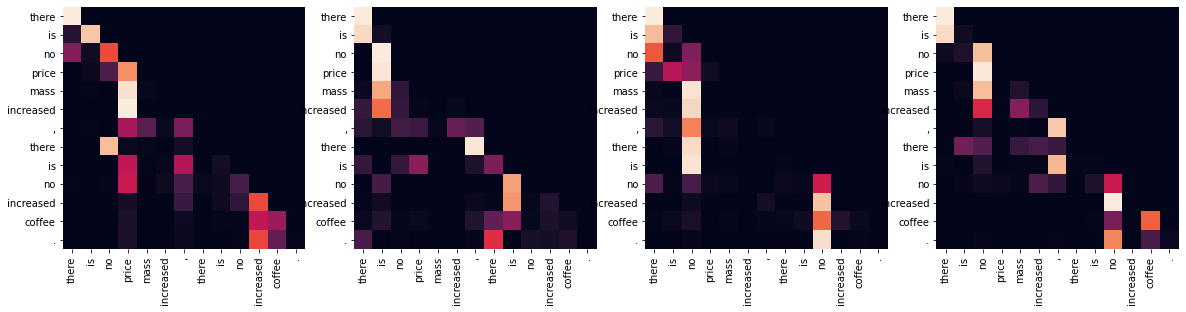

Decoder Src Layer 2


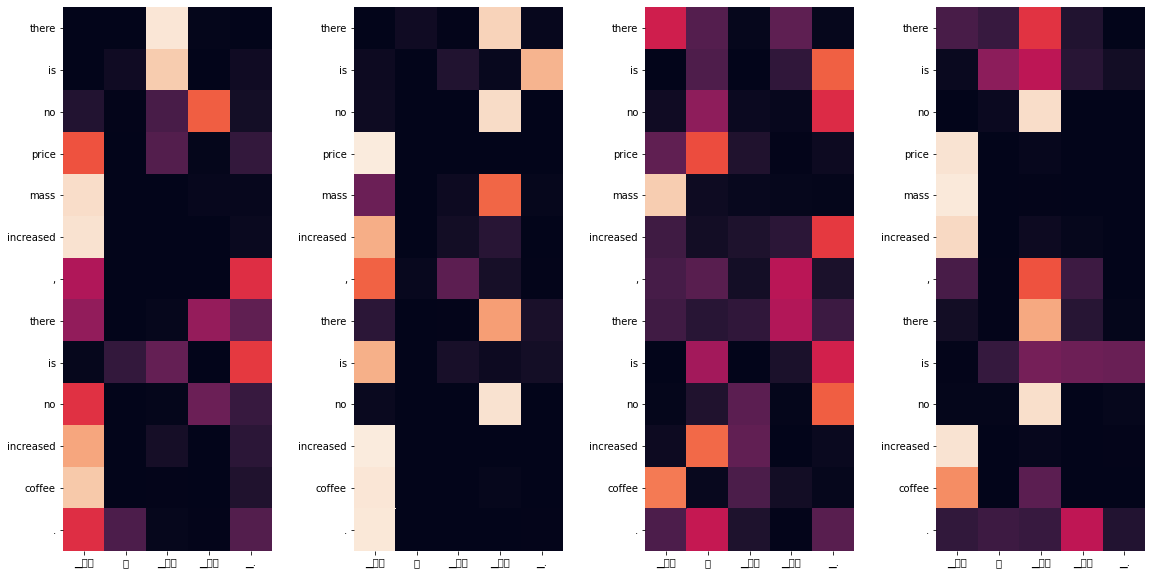

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were reported killed .
Encoder Layer 1


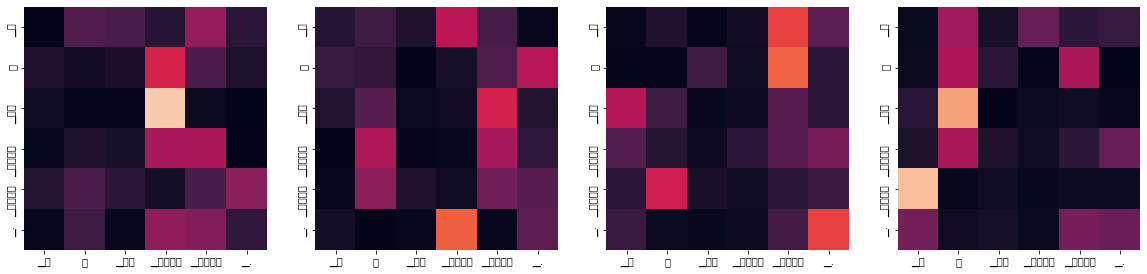

Encoder Layer 2


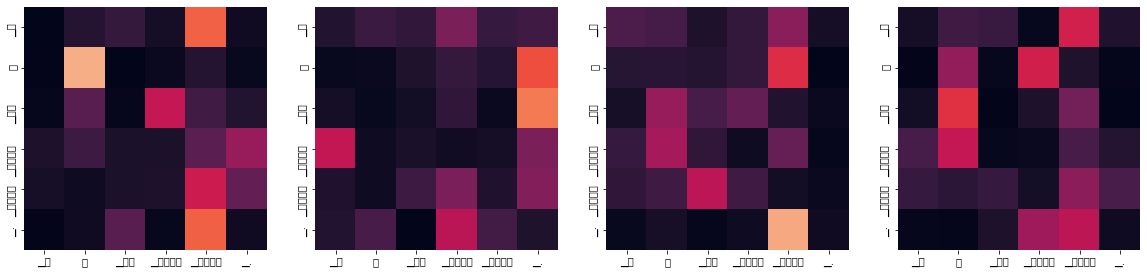

Decoder Self Layer 1


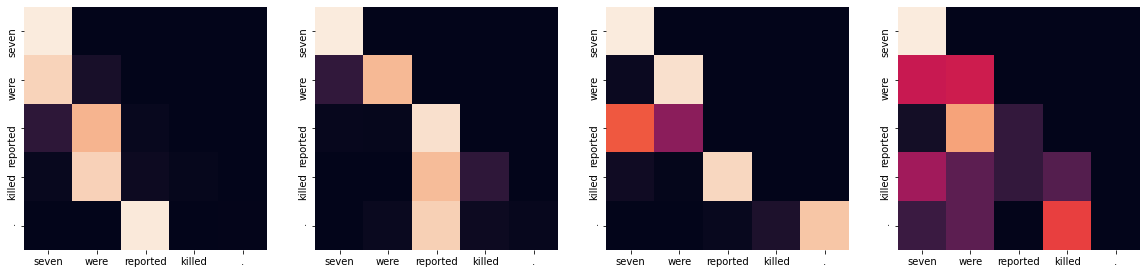

Decoder Src Layer 1


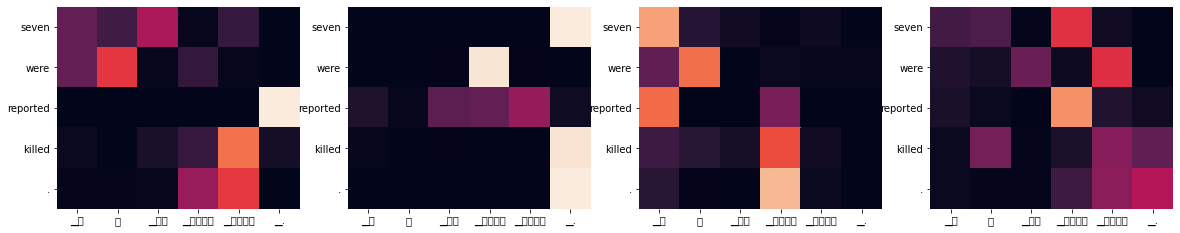

Decoder Self Layer 2


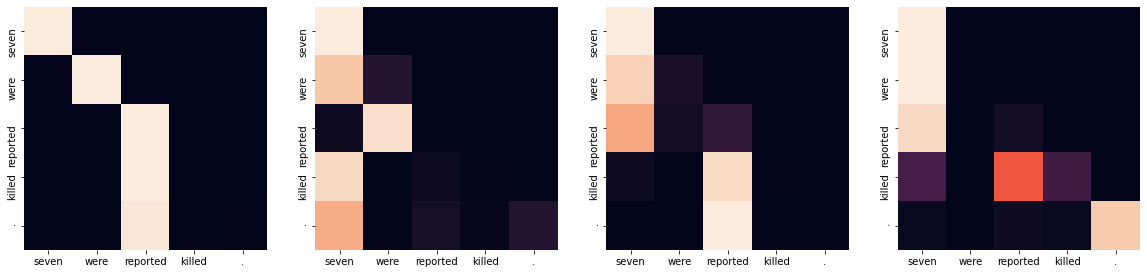

Decoder Src Layer 2


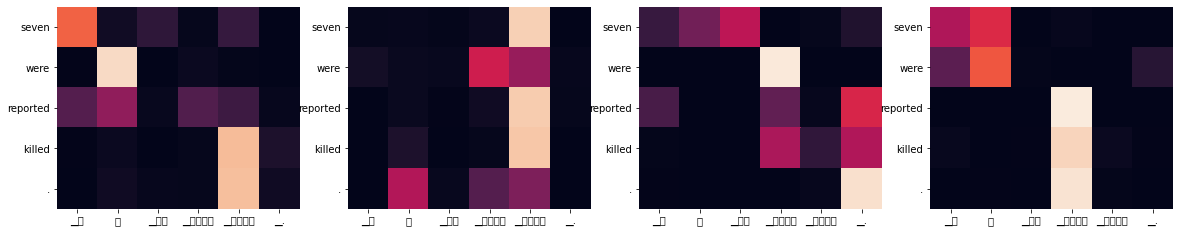

  0%|          | 0/909 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he is the president of the world .
Encoder Layer 1


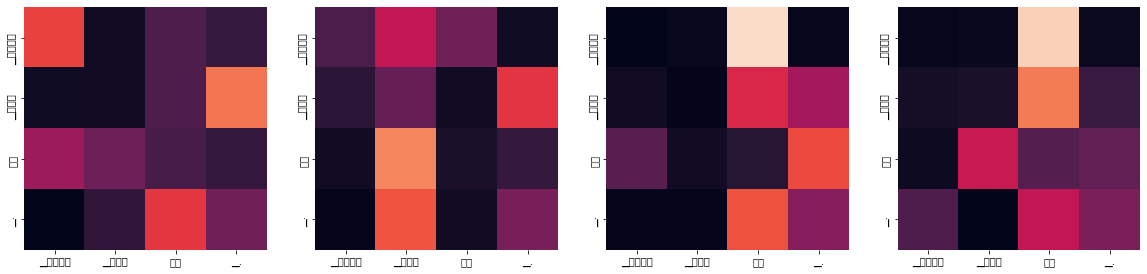

Encoder Layer 2


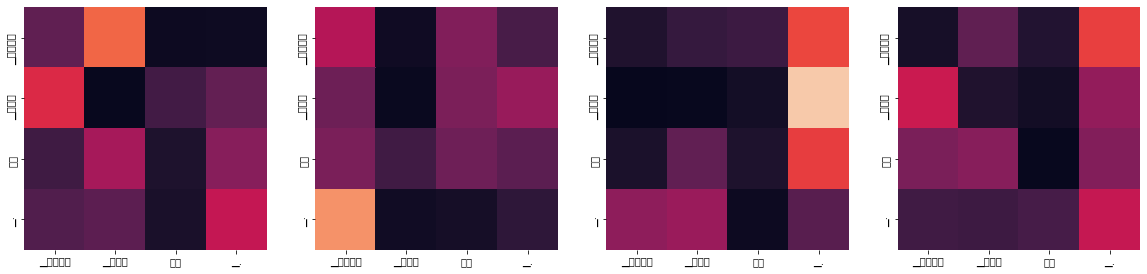

Decoder Self Layer 1


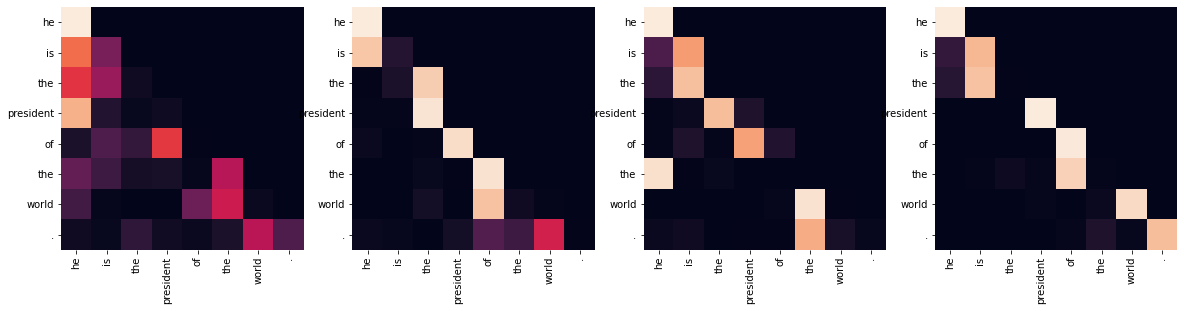

Decoder Src Layer 1


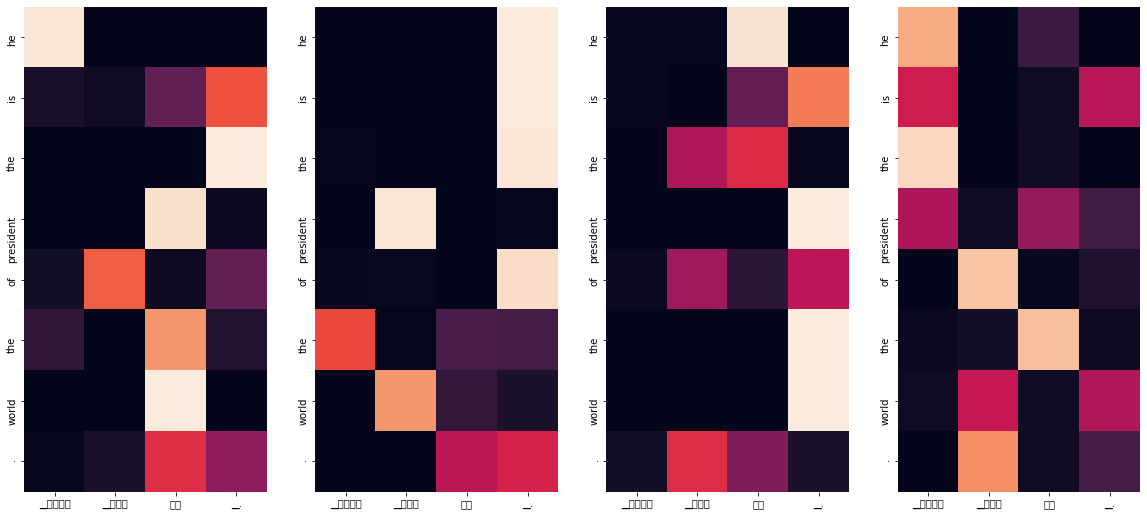

Decoder Self Layer 2


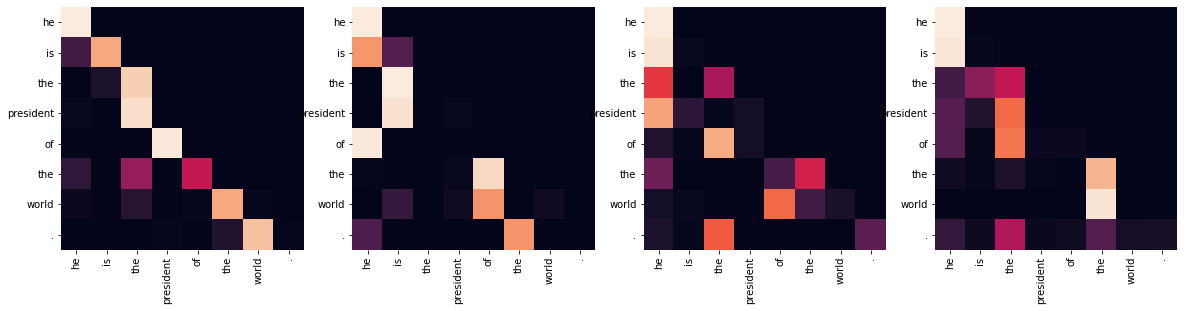

Decoder Src Layer 2


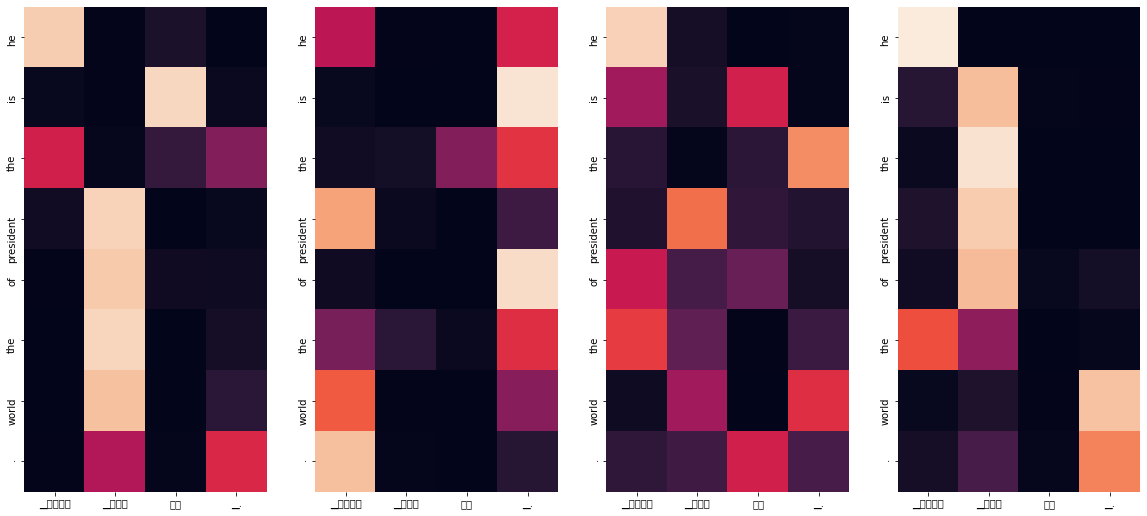

Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are in the city cities .
Encoder Layer 1


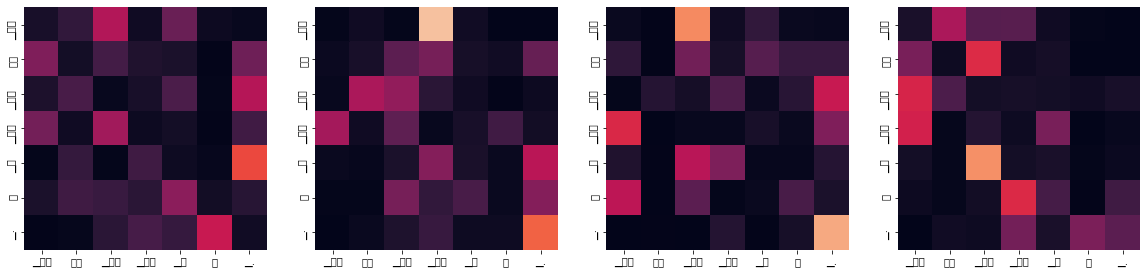

Encoder Layer 2


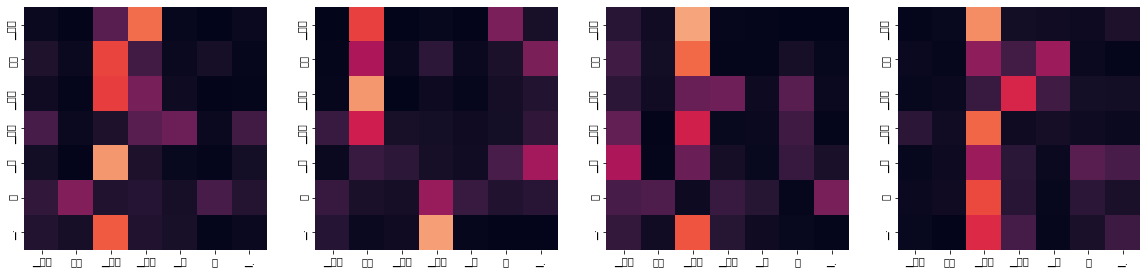

Decoder Self Layer 1


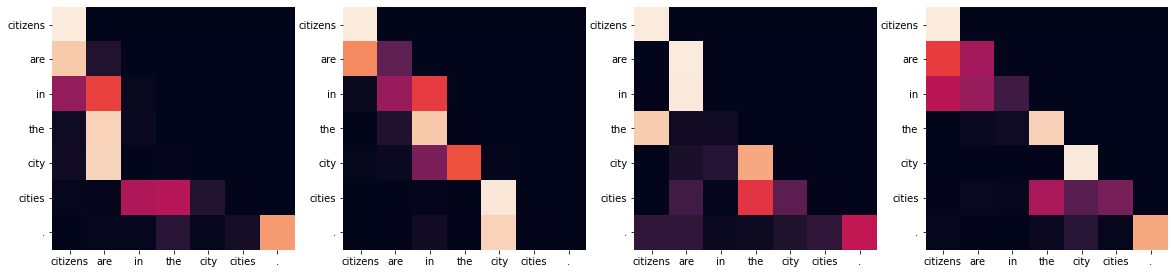

Decoder Src Layer 1


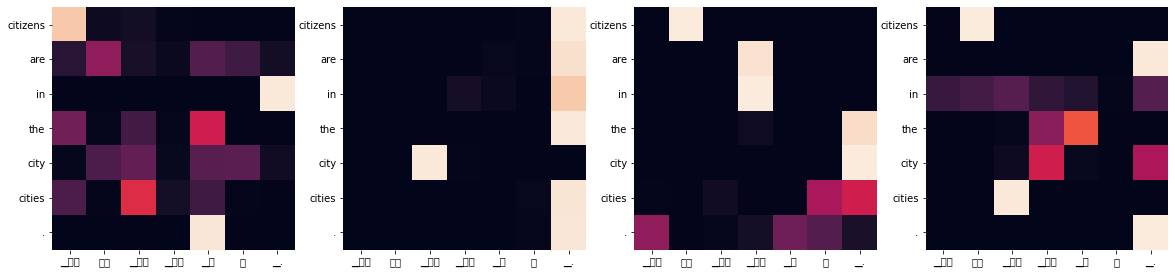

Decoder Self Layer 2


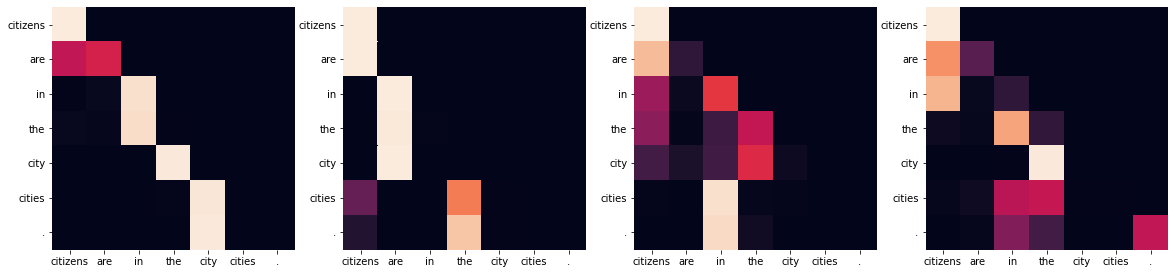

Decoder Src Layer 2


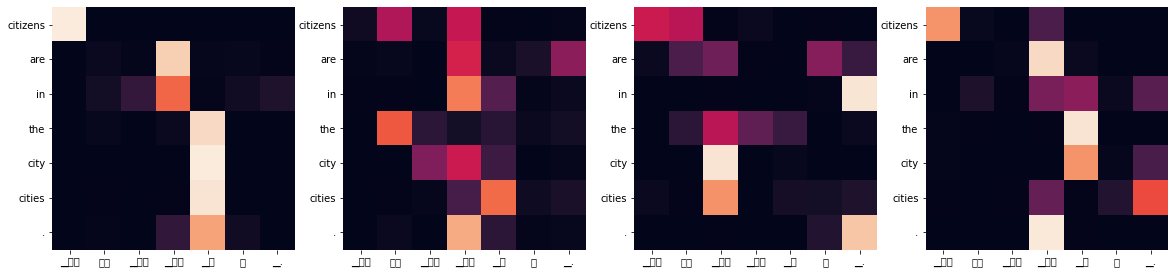

Input: 커피는 필요 없다.
Predicted translation: there is a big enough coffeeusable will be a big thing .
Encoder Layer 1


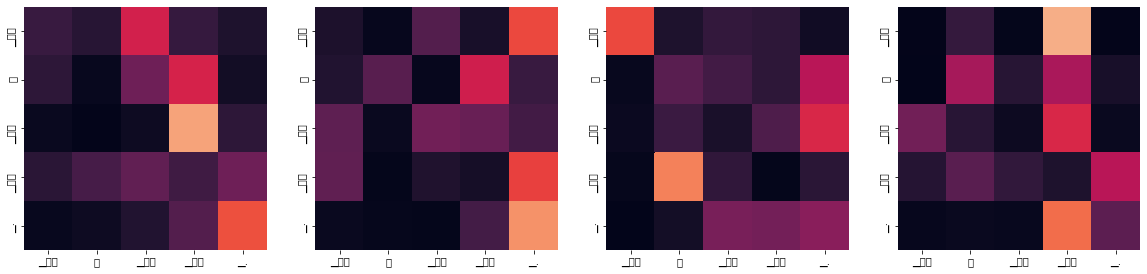

Encoder Layer 2


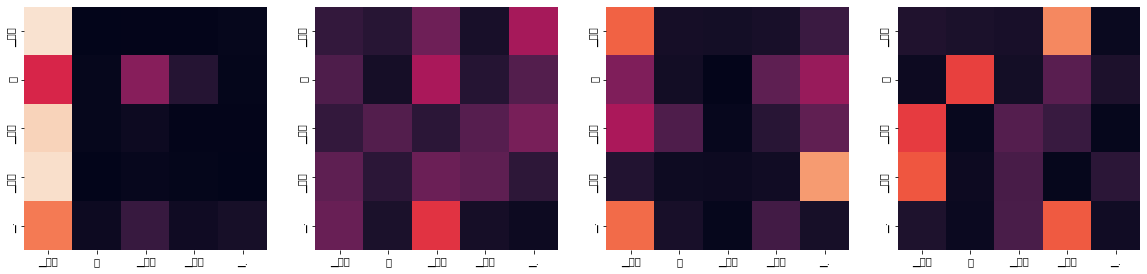

Decoder Self Layer 1


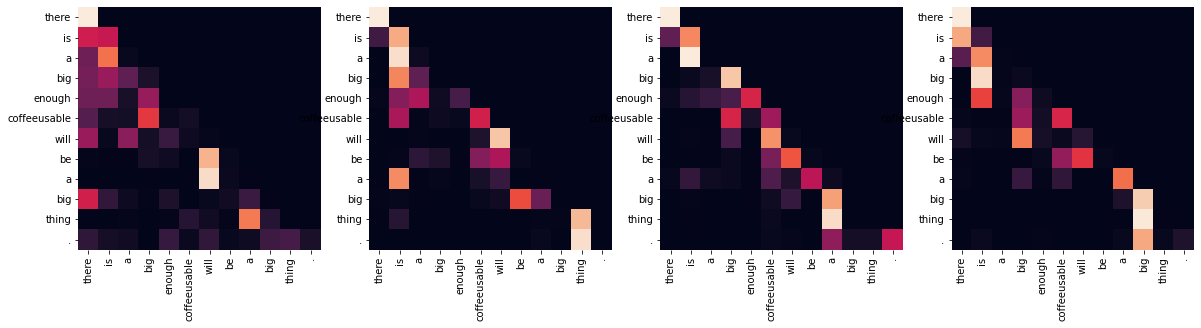

Decoder Src Layer 1


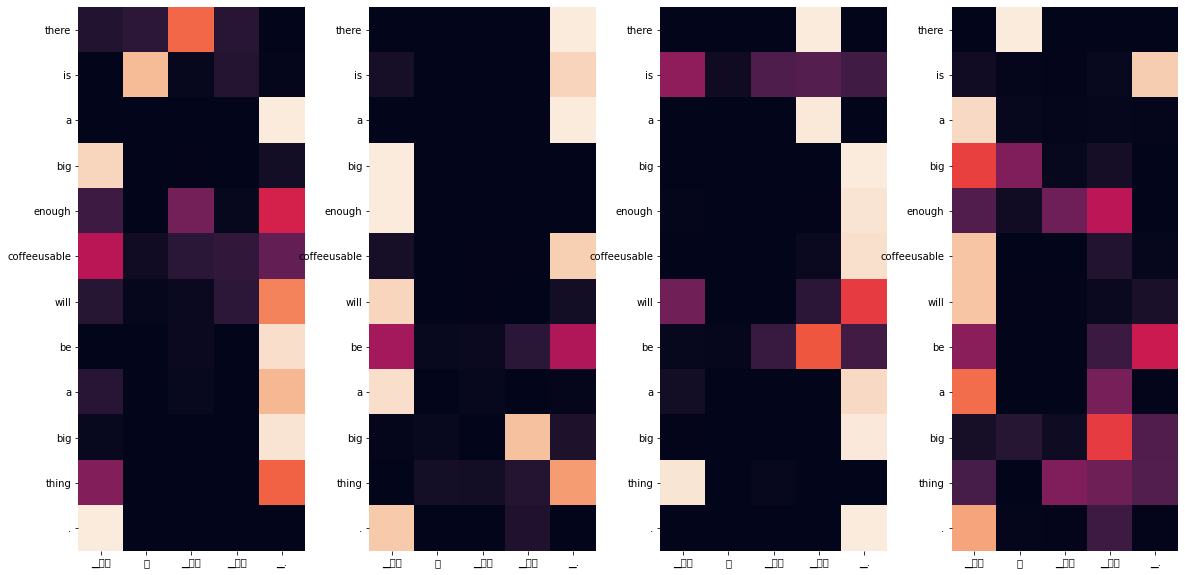

Decoder Self Layer 2


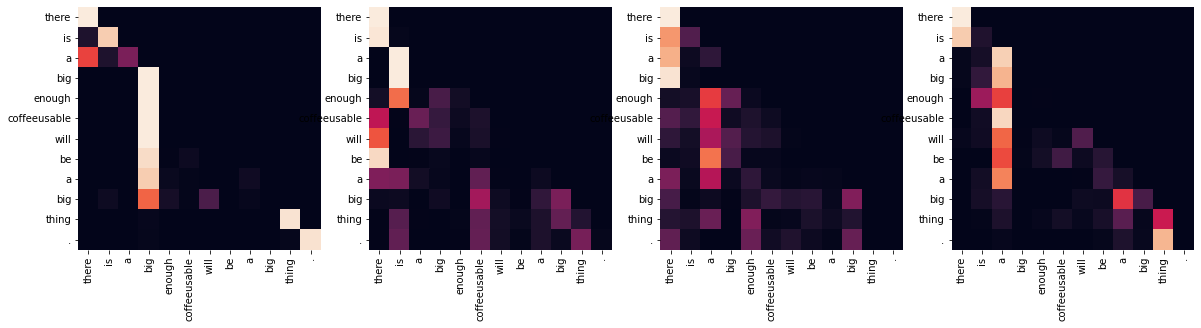

Decoder Src Layer 2


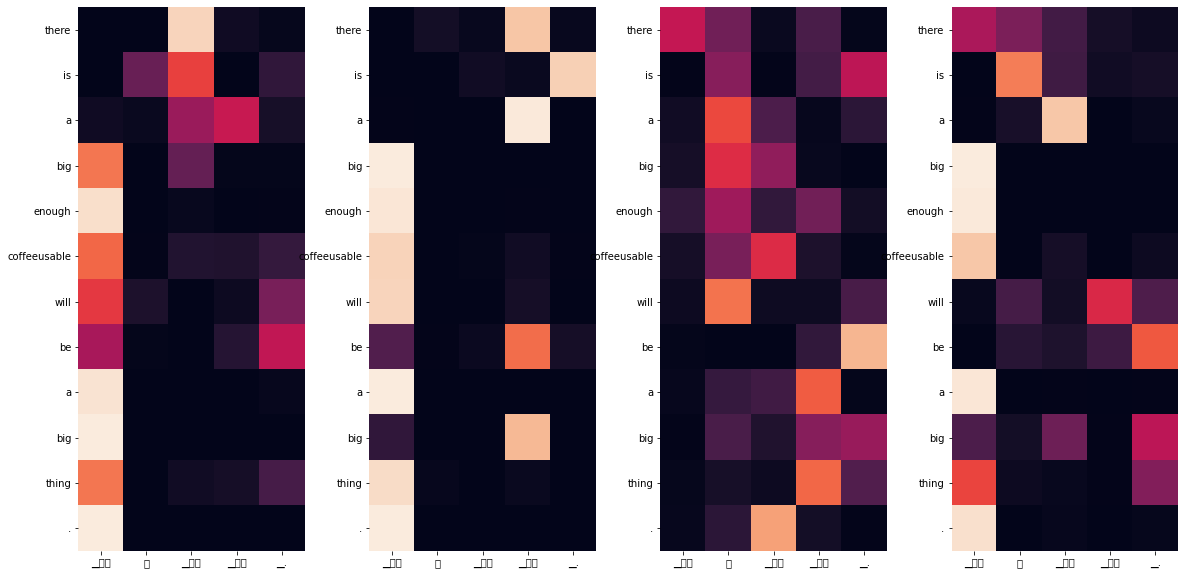

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were reported to be dead .
Encoder Layer 1


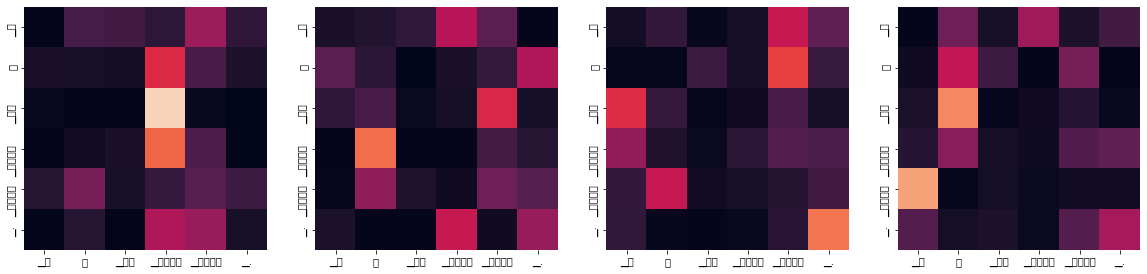

Encoder Layer 2


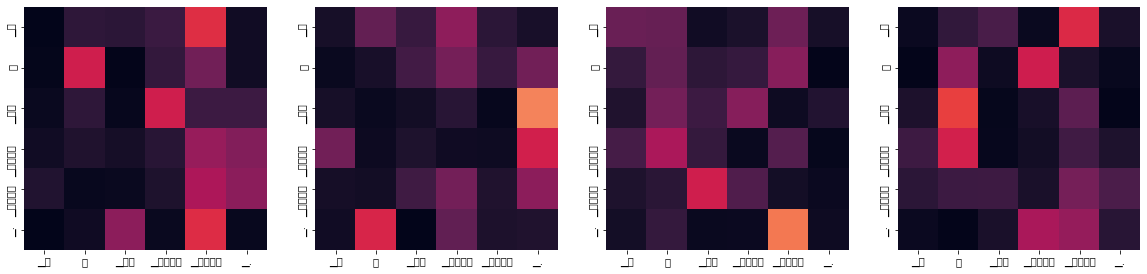

Decoder Self Layer 1


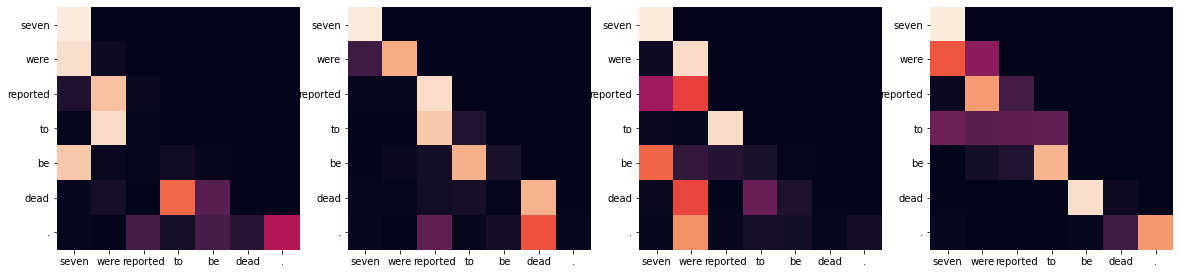

Decoder Src Layer 1


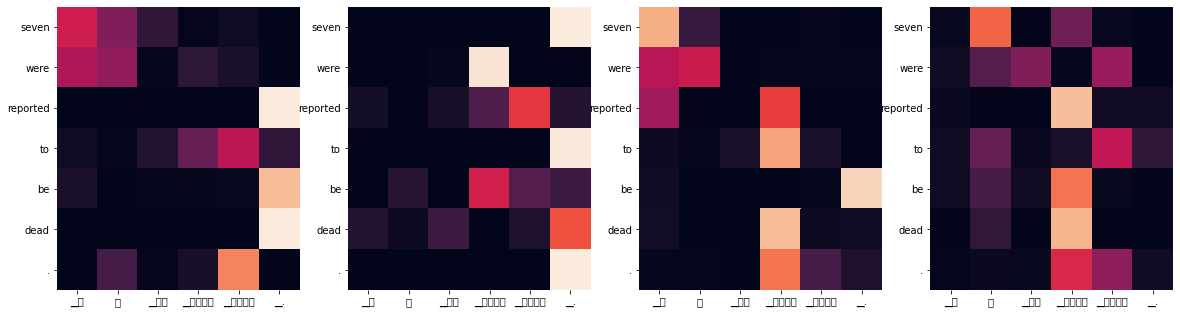

Decoder Self Layer 2


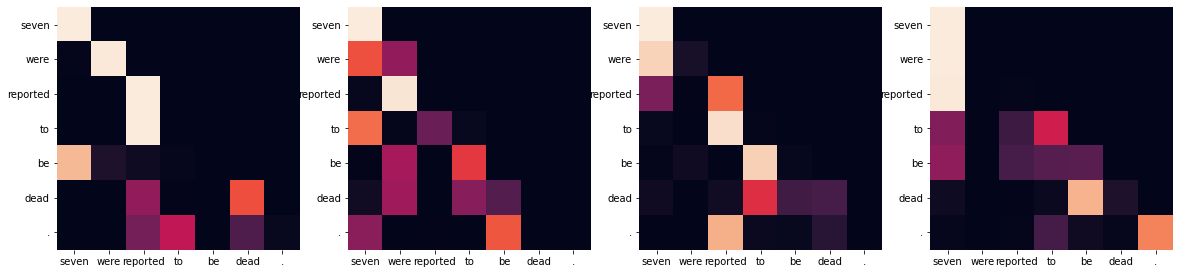

Decoder Src Layer 2


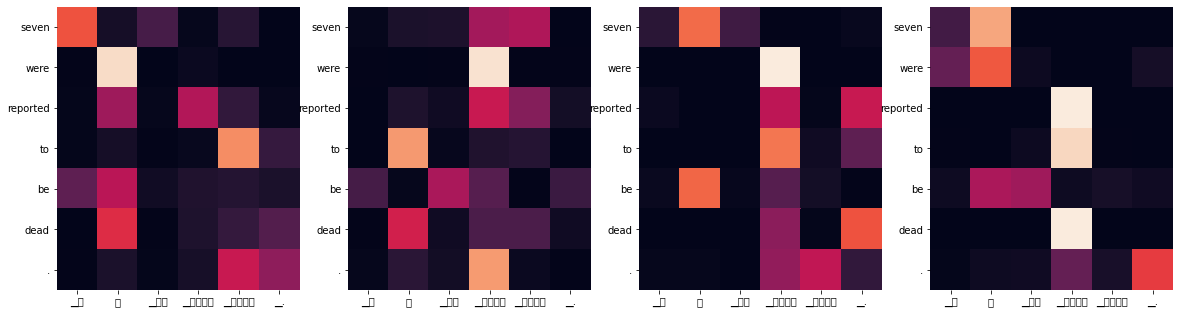

  0%|          | 0/909 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama .
Encoder Layer 1


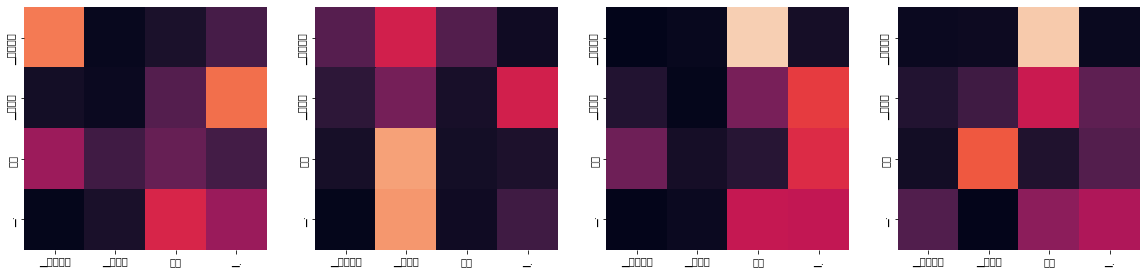

Encoder Layer 2


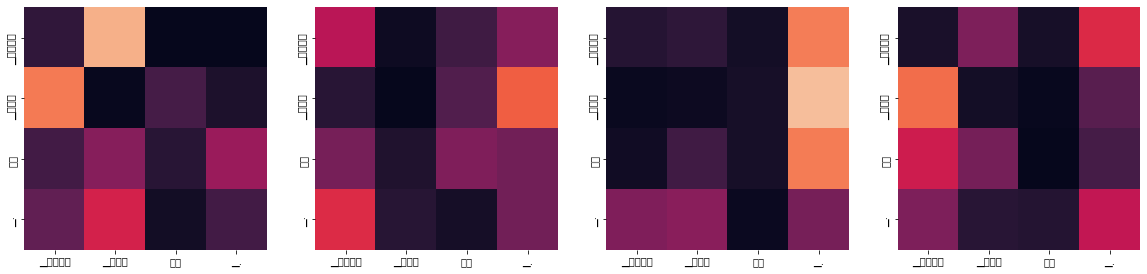

Decoder Self Layer 1


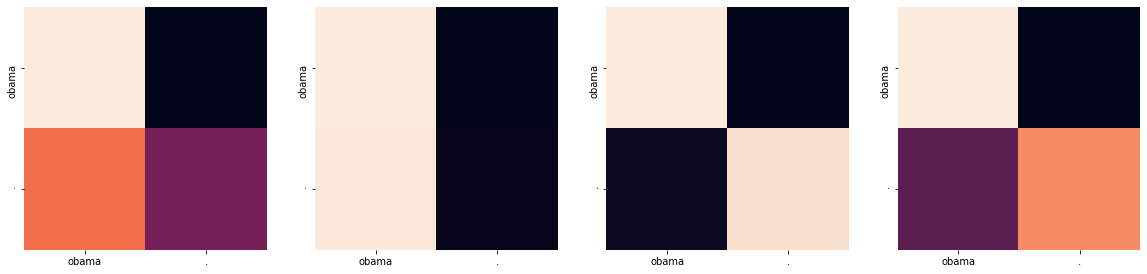

Decoder Src Layer 1


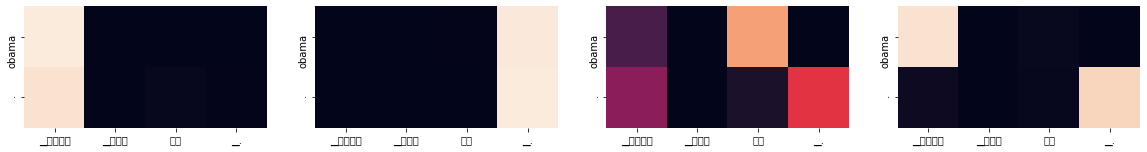

Decoder Self Layer 2


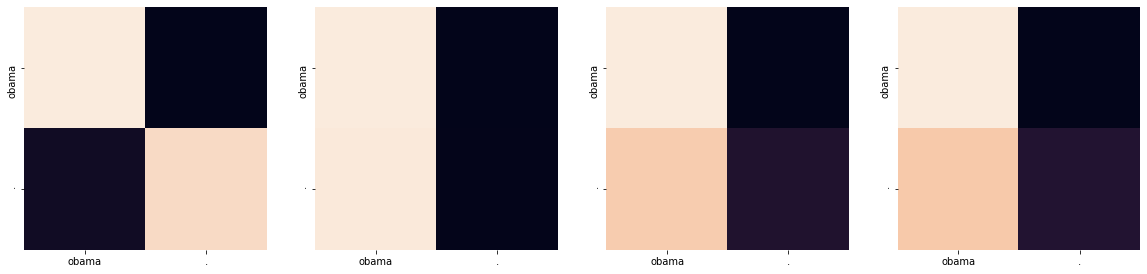

Decoder Src Layer 2


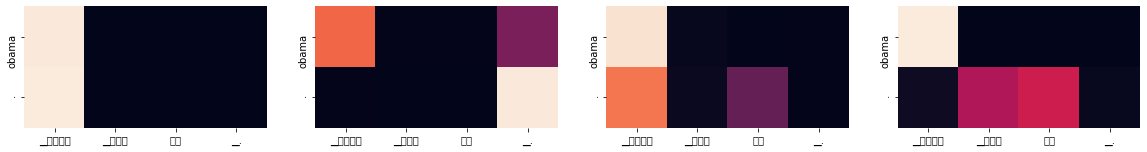

Input: 시민들은 도시 속에 산다.
Predicted translation: civil protests are planned .
Encoder Layer 1


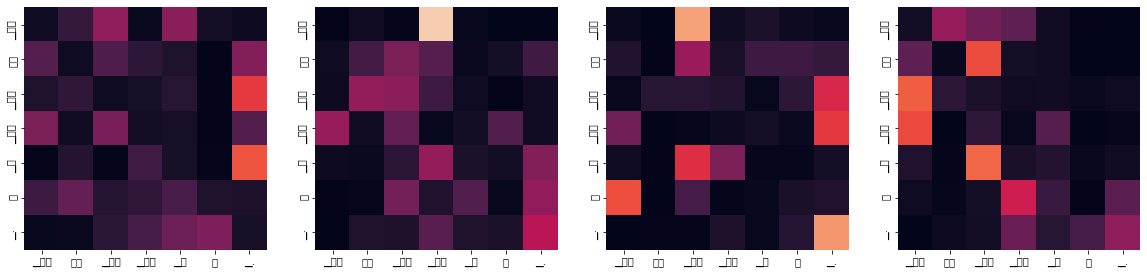

Encoder Layer 2


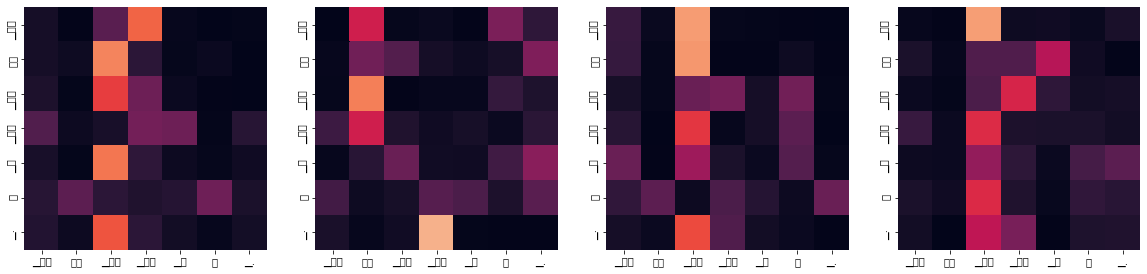

Decoder Self Layer 1


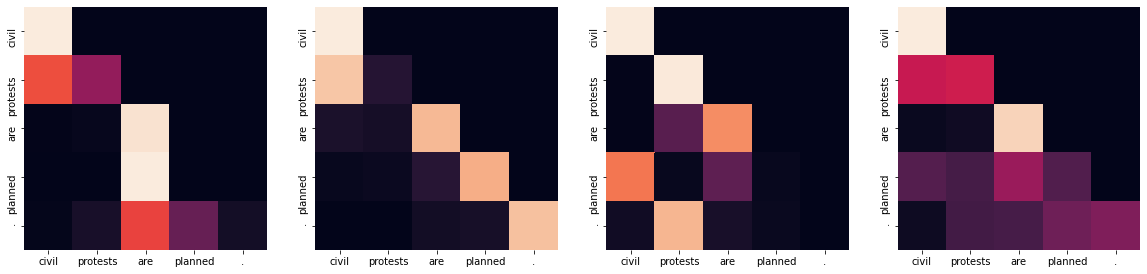

Decoder Src Layer 1


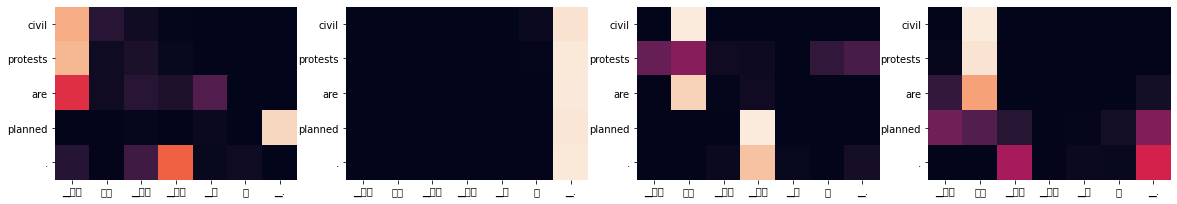

Decoder Self Layer 2


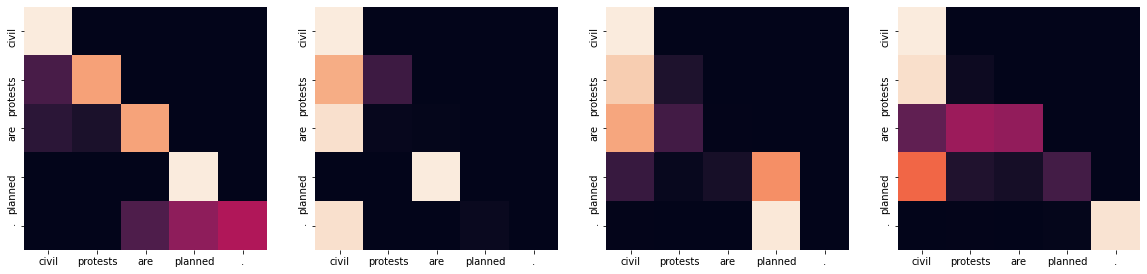

Decoder Src Layer 2


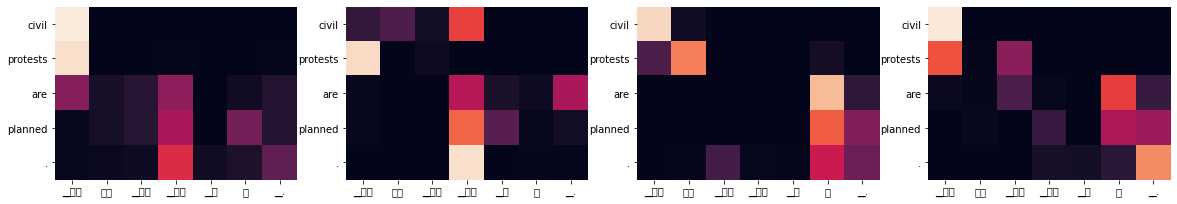

Input: 커피는 필요 없다.
Predicted translation: there are a strong don t think price is a kind of cafes
Encoder Layer 1


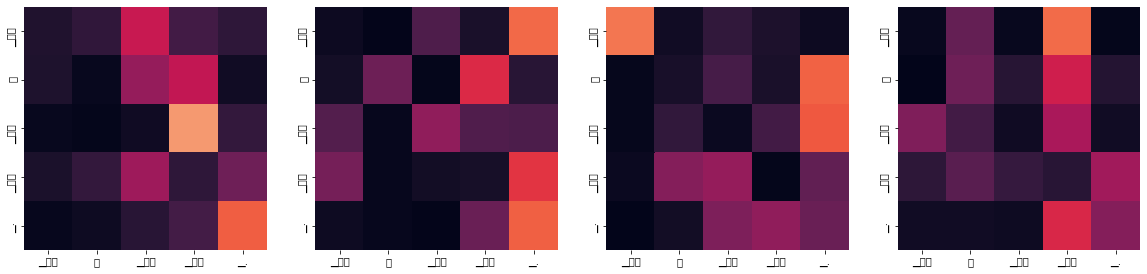

Encoder Layer 2


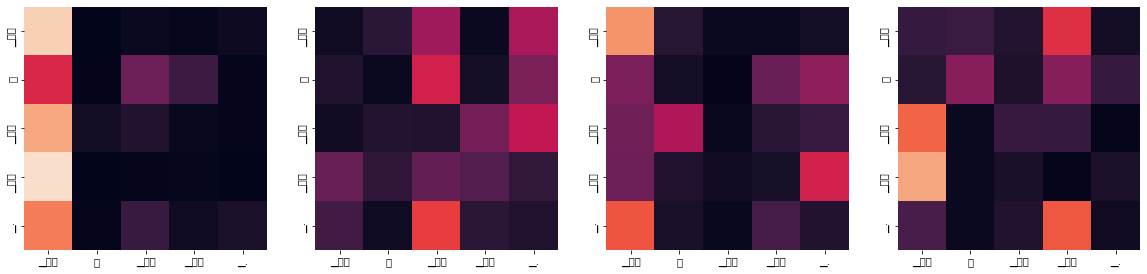

Decoder Self Layer 1


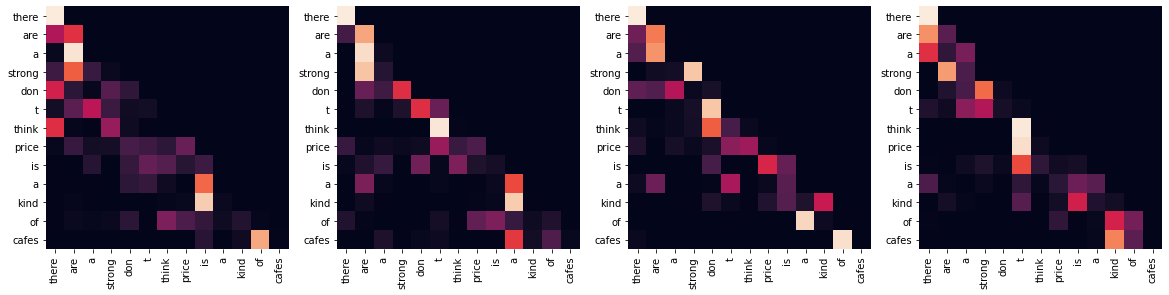

Decoder Src Layer 1


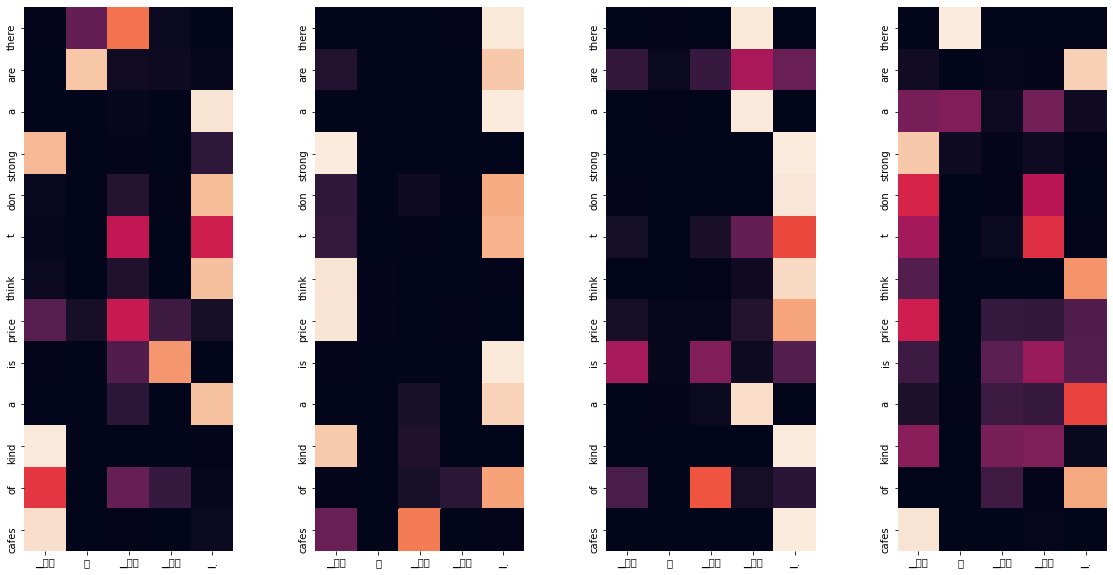

Decoder Self Layer 2


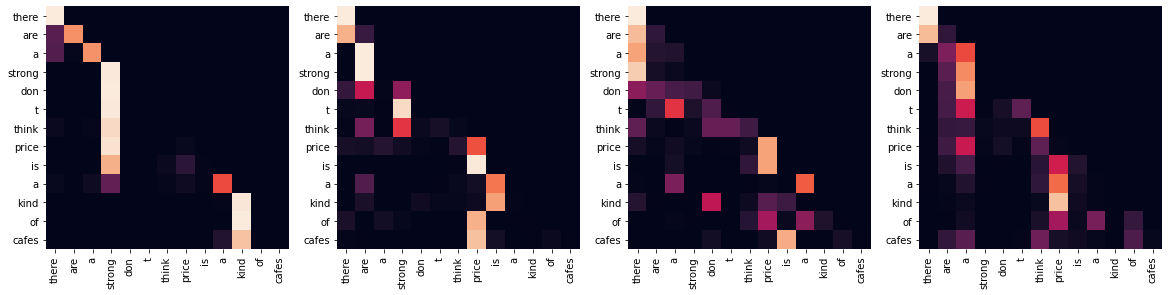

Decoder Src Layer 2


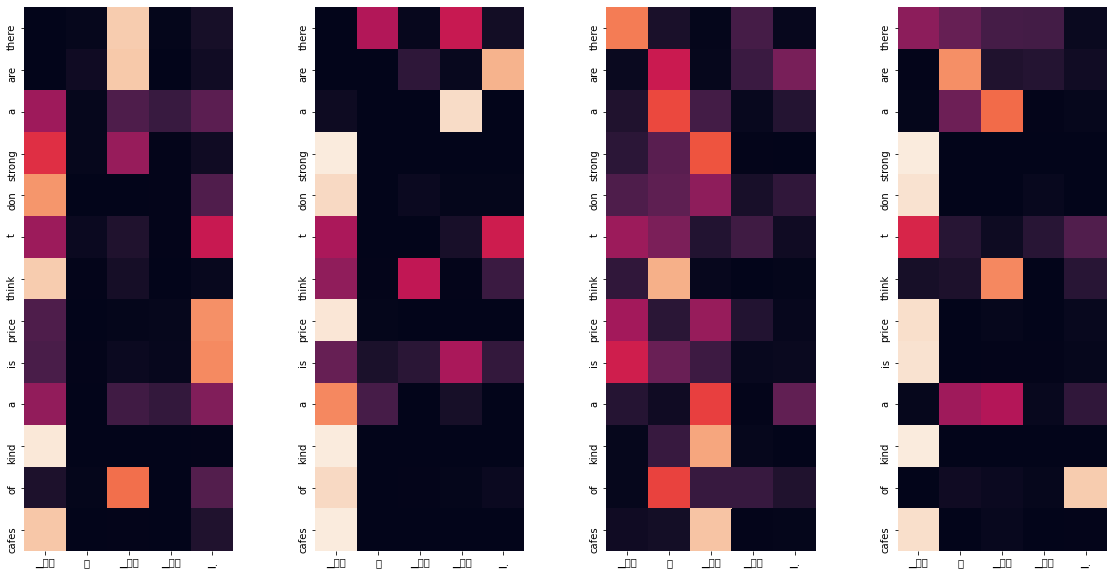

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were killed in the seven other homes .
Encoder Layer 1


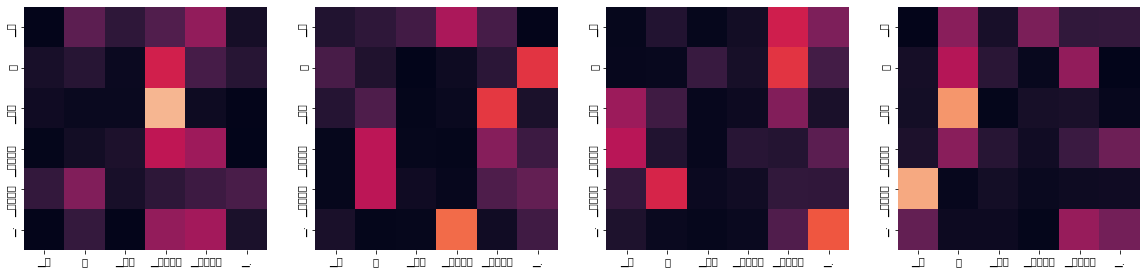

Encoder Layer 2


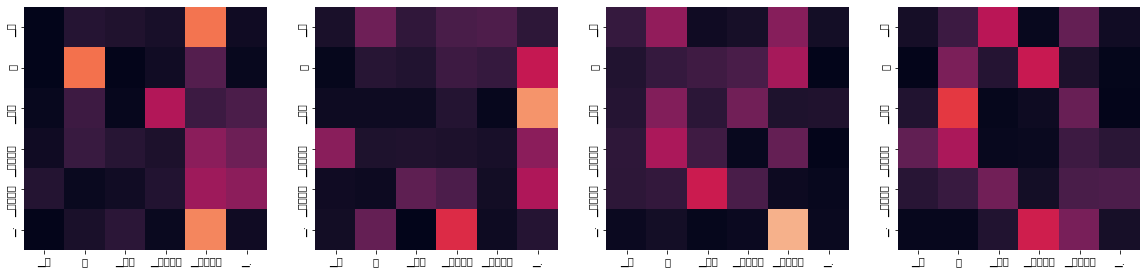

Decoder Self Layer 1


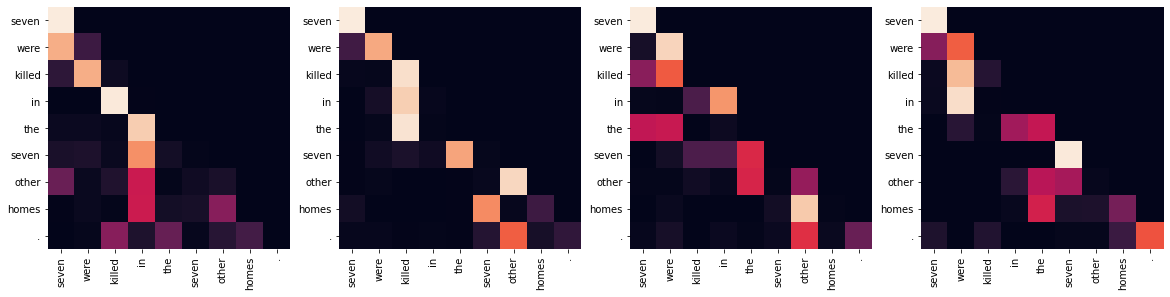

Decoder Src Layer 1


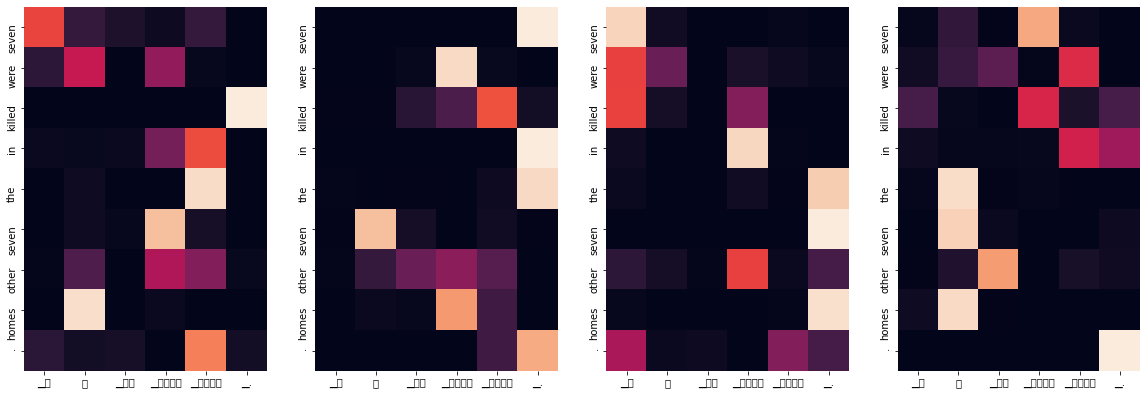

Decoder Self Layer 2


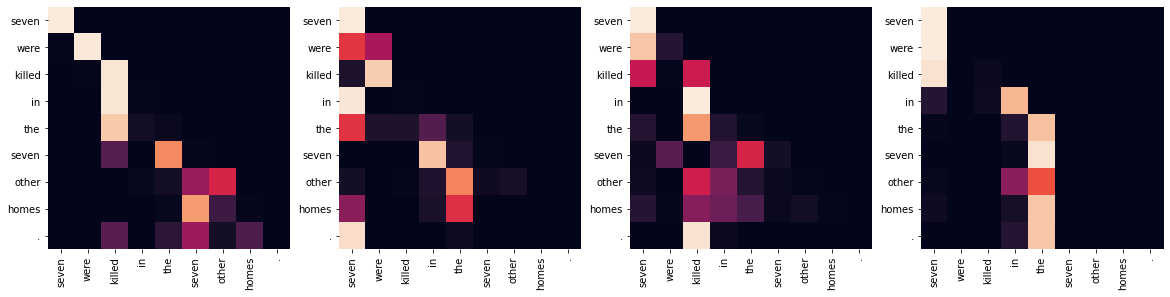

Decoder Src Layer 2


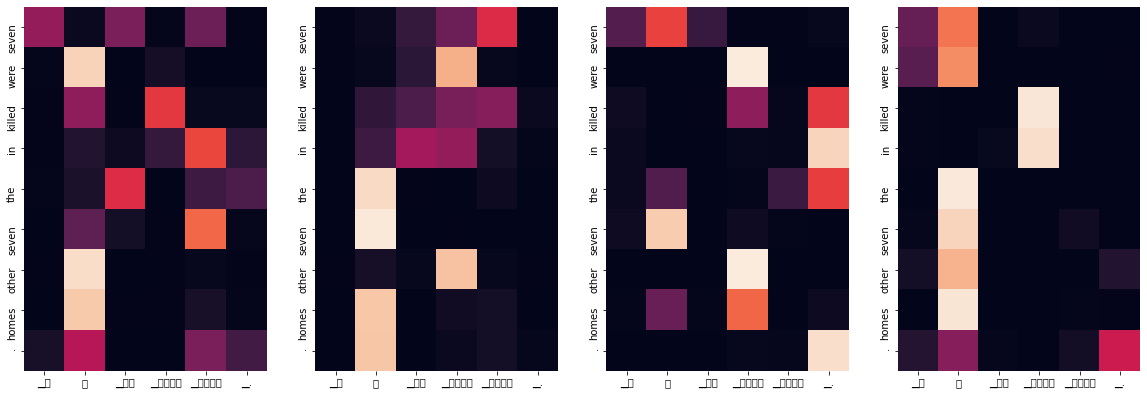

  0%|          | 0/909 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: . george is a president .
Encoder Layer 1


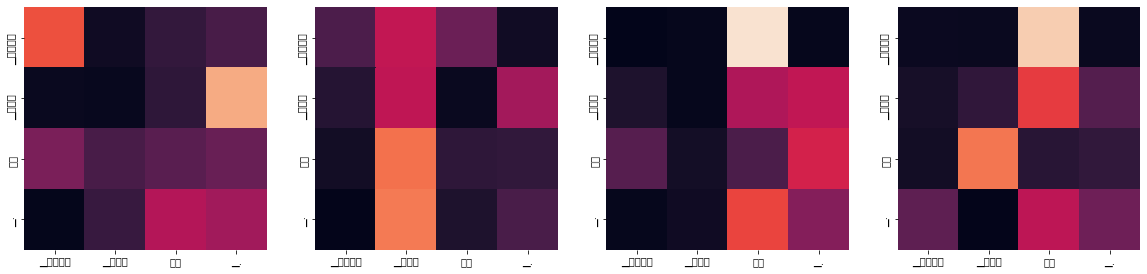

Encoder Layer 2


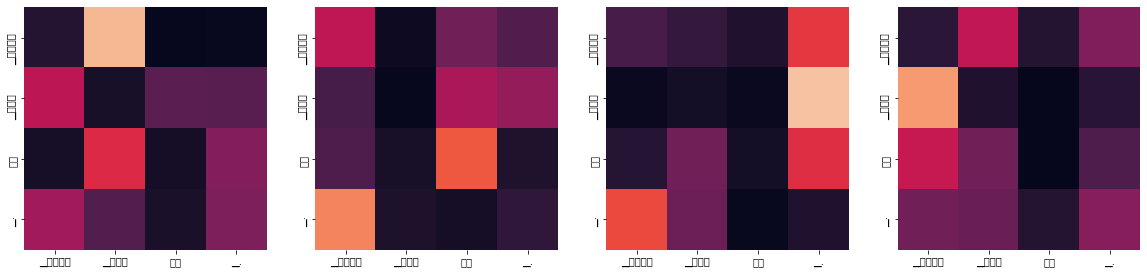

Decoder Self Layer 1


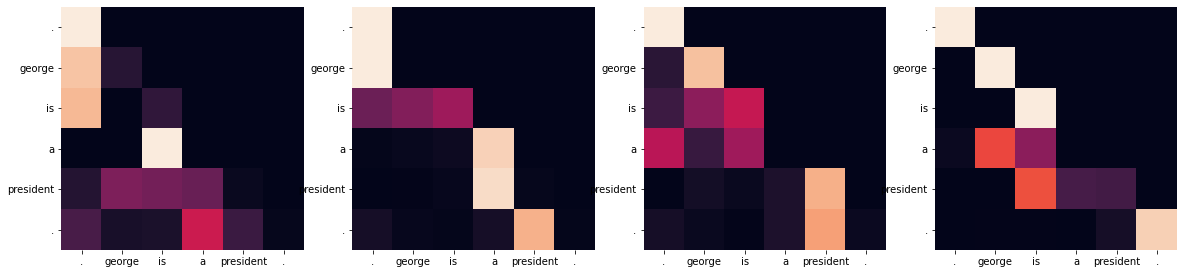

Decoder Src Layer 1


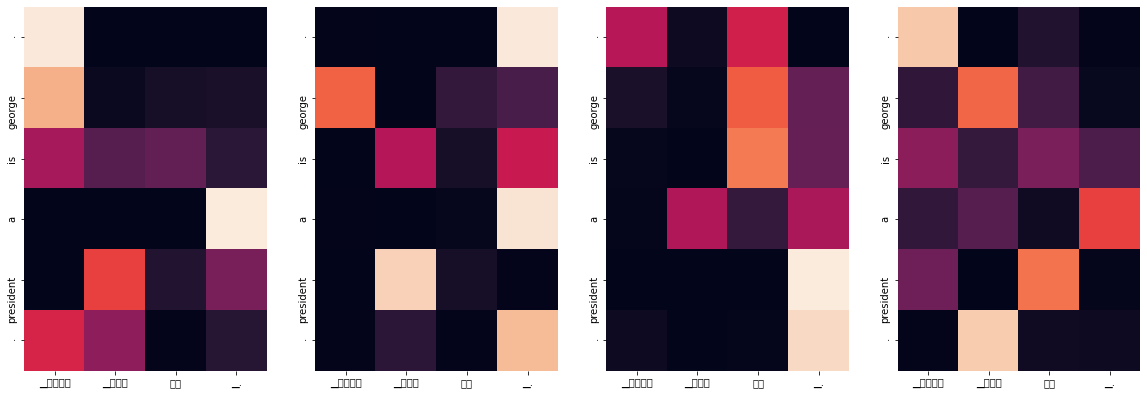

Decoder Self Layer 2


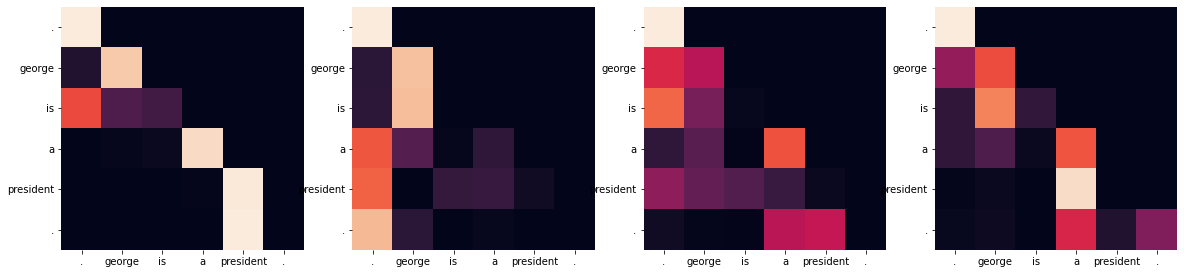

Decoder Src Layer 2


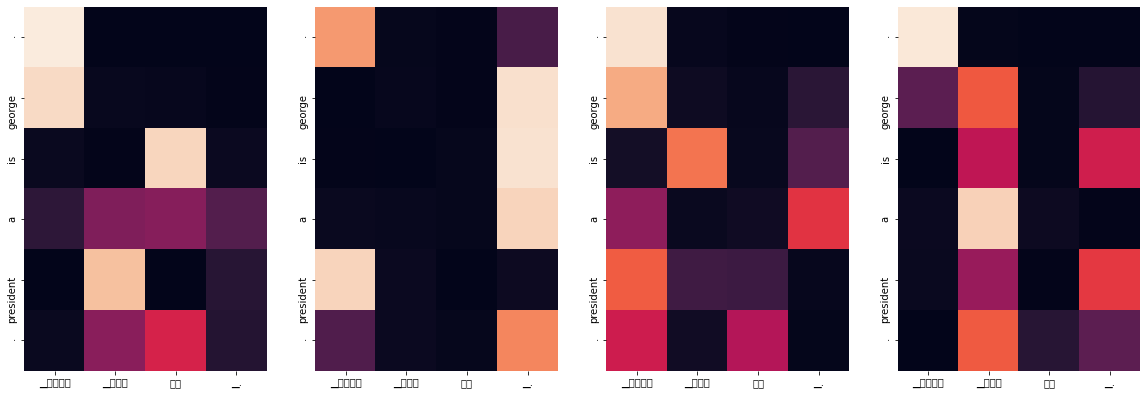

Input: 시민들은 도시 속에 산다.
Predicted translation: citizens .
Encoder Layer 1


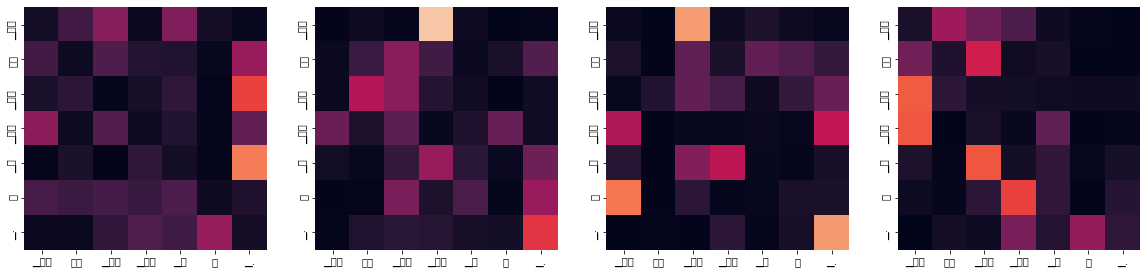

Encoder Layer 2


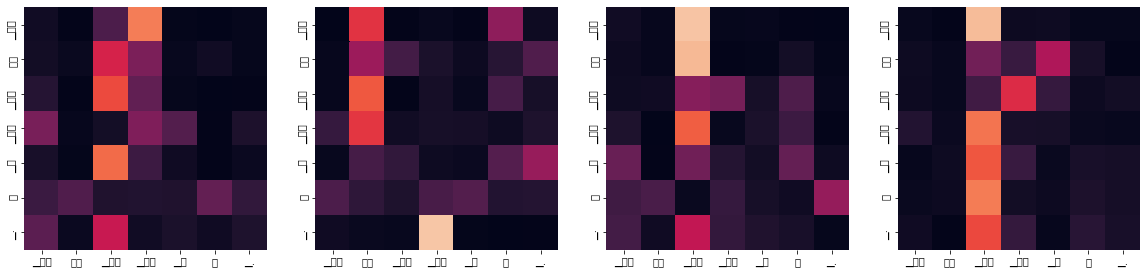

Decoder Self Layer 1


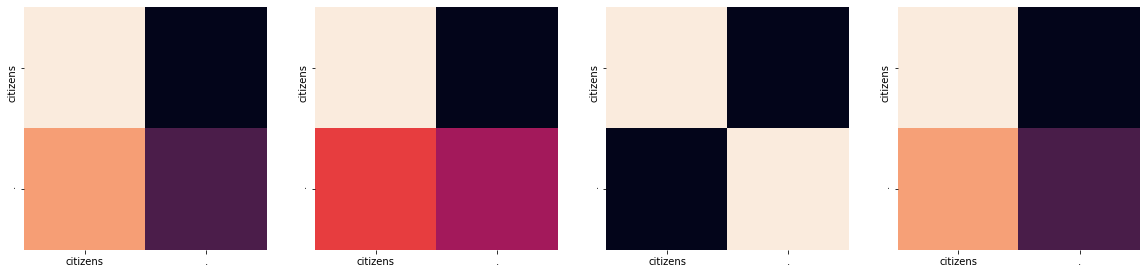

Decoder Src Layer 1


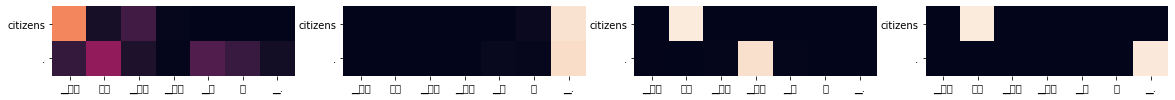

Decoder Self Layer 2


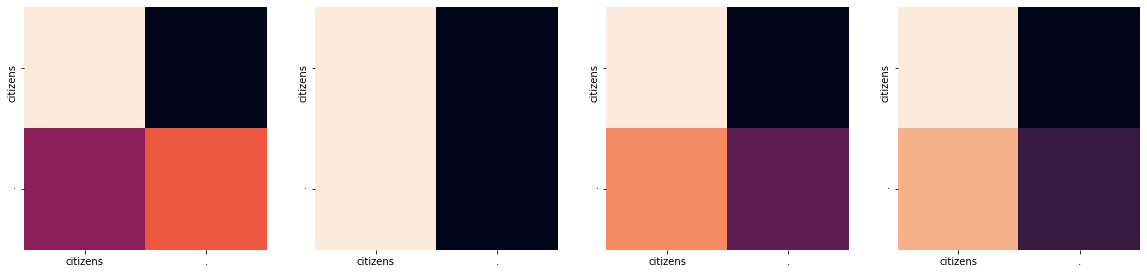

Decoder Src Layer 2


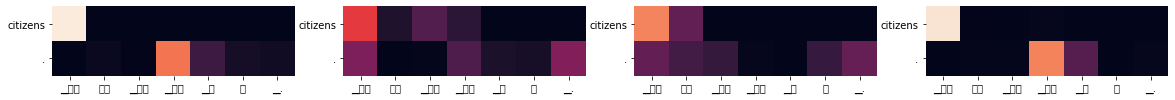

Input: 커피는 필요 없다.
Predicted translation: there is a strong exportshou cannot take place for a good portion .
Encoder Layer 1


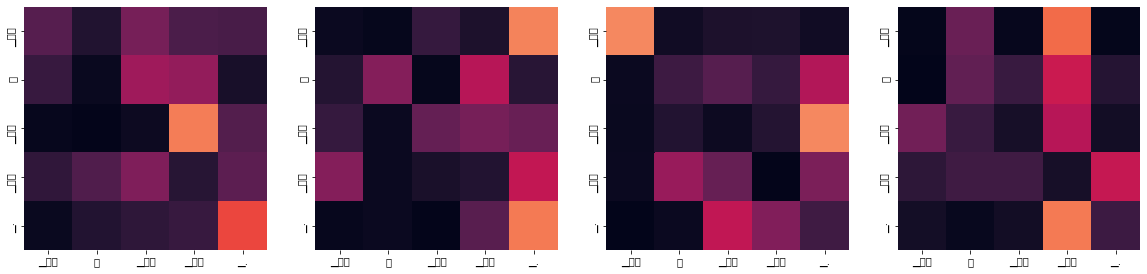

Encoder Layer 2


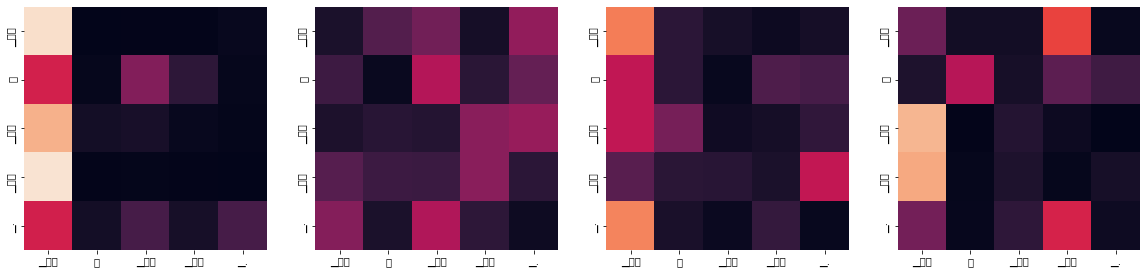

Decoder Self Layer 1


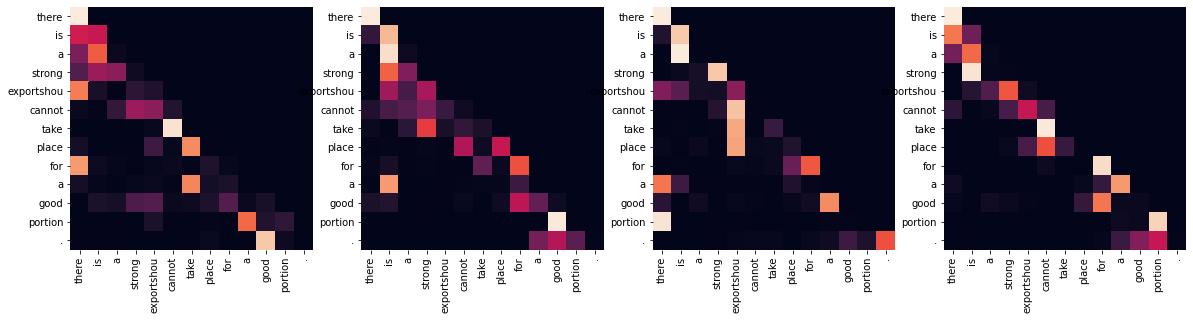

Decoder Src Layer 1


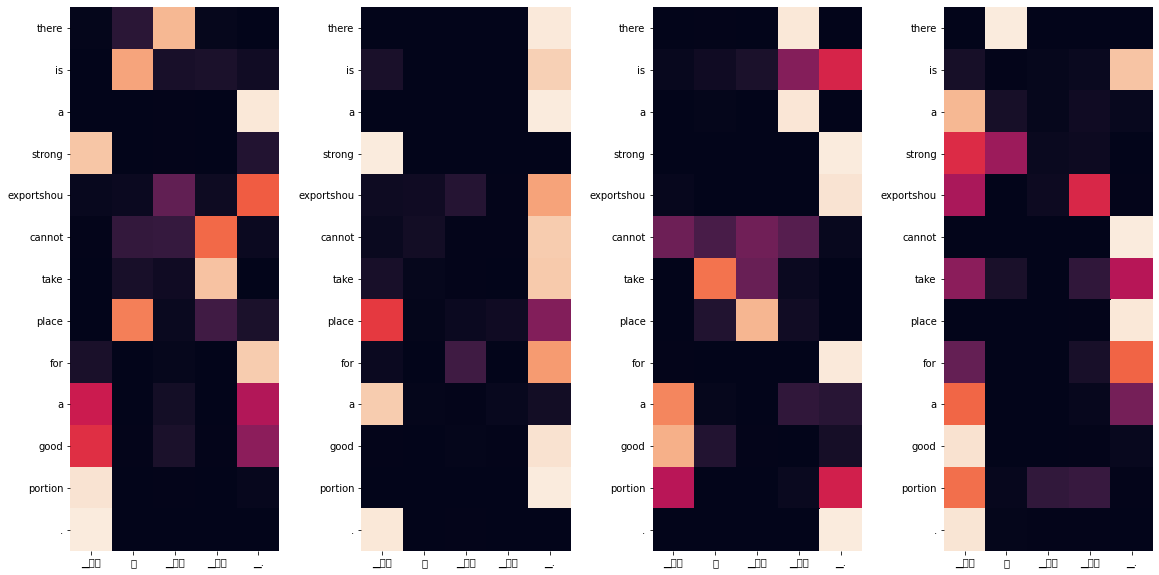

Decoder Self Layer 2


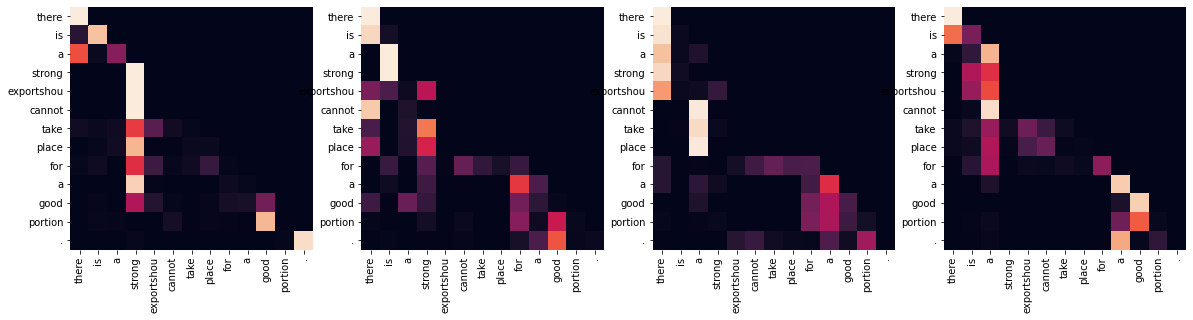

Decoder Src Layer 2


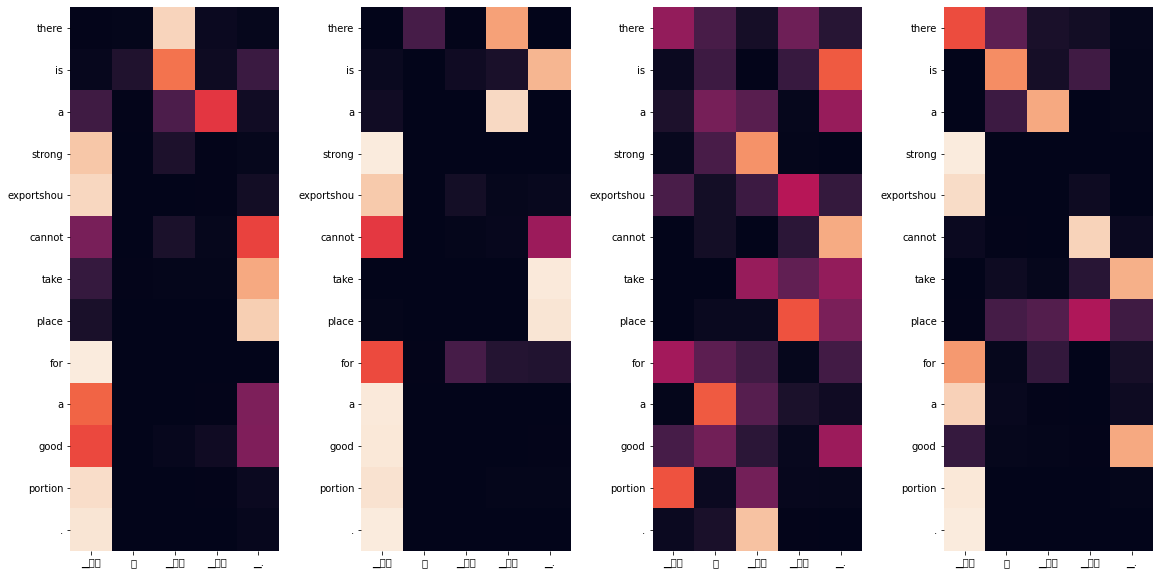

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven killed were in the seven deaths .
Encoder Layer 1


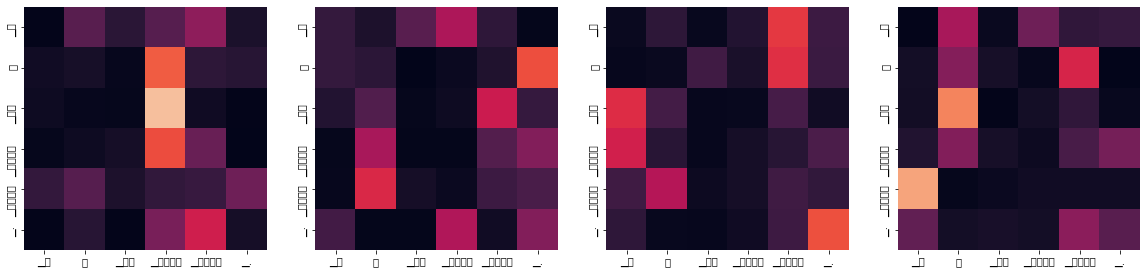

Encoder Layer 2


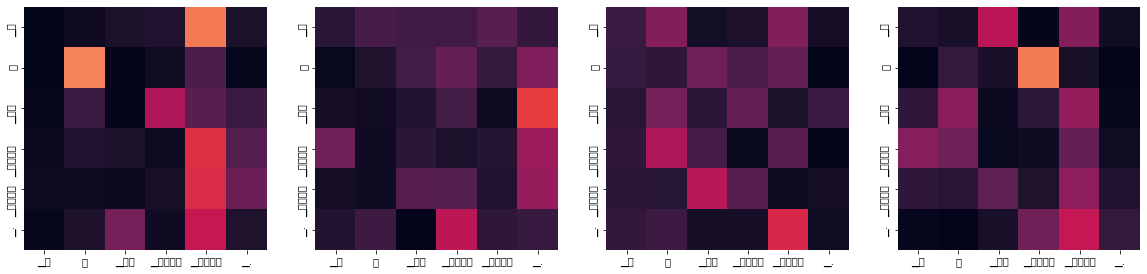

Decoder Self Layer 1


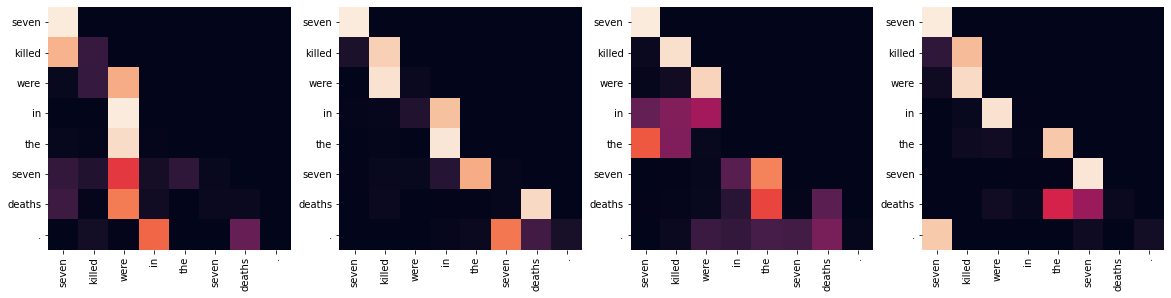

Decoder Src Layer 1


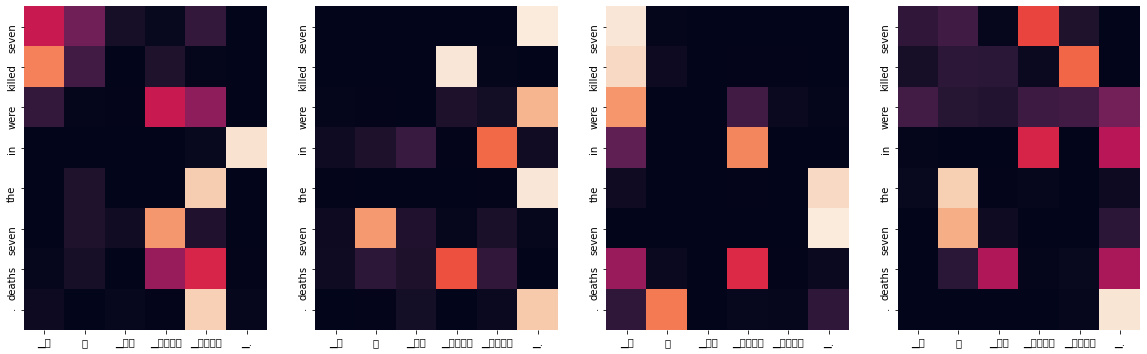

Decoder Self Layer 2


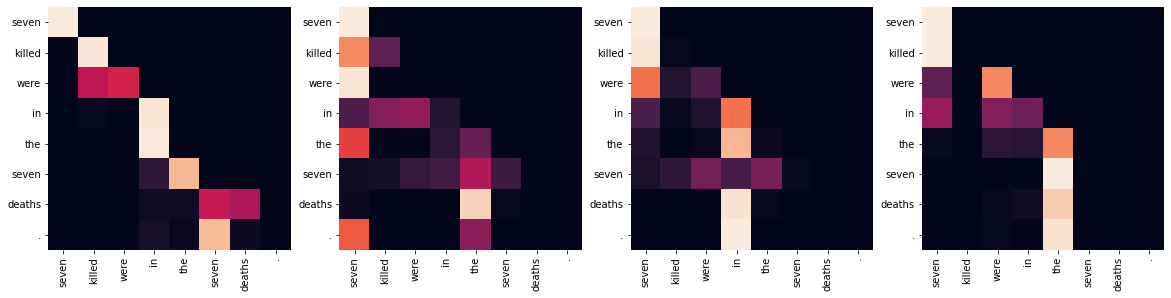

Decoder Src Layer 2


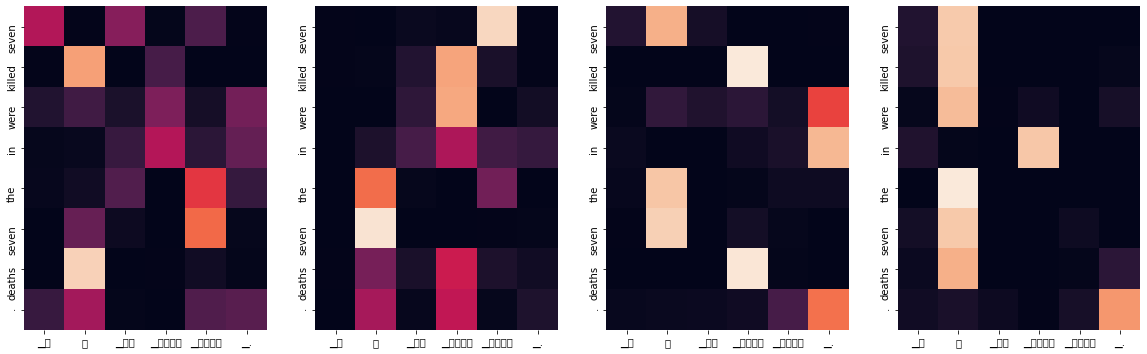

In [119]:
# 학습
BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

### Result     
|Rubrics|Details|Success|
|-----|-----|--------|
| 1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다. | 데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.|V|
| 2. Transformer 번역기 모델이 정상적으로 구동된다.| Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.|V|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.|V|